In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn import preprocessing
from numpy import mean
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Import data and preprocess

Create separate dataframes for each year of output since 2017. The final model can then learn off of 5 years of data before making its predictions for 2022. 
#### Let's get this shit

In [3]:
rb_fp = pd.read_csv('rb_fantasy3.csv')
wr_fp = pd.read_csv('wr_fantasy3.csv')
te_fp = pd.read_csv('te_fantasy3.csv')
fp_df = rb_fp.append(wr_fp.append(te_fp))
fp_df

Full Name Position   Age Fantasy Points Per Game (2014)  \
0        A.J. Dillon       RB  24.1                              -   
1        Aaron Jones       RB  27.5                              -   
2    Aaron Ripkowski       RB  29.4                              -   
3    Adrian Peterson       RB  37.2                           11.3   
4     Ahmad Bradshaw       RB  36.2                           15.4   
..               ...      ...   ...                            ...   
300        Zach Ertz       TE  31.5                              9   
301      Zach Gentry       TE  25.7                              -   
302      Zach Miller       TE  37.6                              -   
303      Zach Miller       TE  36.5                            4.5   
304     Zach Sudfeld       TE  33.1                            2.2   

    Fantasy Points Per Game (2015) Fantasy Points Per Game (2016)  \
0                                -                              -   
1                                -                              -   
2                              2.8                            4.7   
3                             16.3                              3   
4                              7.1                              -   
..                             ...                            ...   
300                           11.4                           13.1   
301                              -                              -   
302                            8.3                             12   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2017) Fantasy Points Per Game (2018)  \
0                                -                              -   
1                                8                           14.3   
2                              1.1                              -   
3                              7.9                           11.8   
4                                -                              -   
..                             ...                            ...   
300                           14.5                           17.5   
301                              -                              -   
302                              7                              -   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2019) Fantasy Points Per Game (2020)  \
0                                -                         3.6636   
1                             19.7                        18.4929   
2                                -                              -   
3                              9.8                         7.7812   
4                                -                              -   
..                             ...                            ...   
300                           14.2                         7.0455   
301                            1.4                              0   
302                              -                              -   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2021) Games (2014) Games (2015) Games (2016)  \
0                          10.9176            -            -            -   
1                          15.2667            -            -            -   
2                                -            -            1           10   
3                             6.65            1           16            3   
4                                -           10            6            -   
..                             ...          ...          ...          ...   
300                        10.6294           16           15           14   
301                            2.1            -            -       

In [4]:
fp_df['rb?'] = np.where(fp_df['Position'] == 'RB',1,0)
fp_df['wr?'] = np.where(fp_df['Position'] == 'WR',1,0)
fp_df['te?'] = np.where(fp_df['Position'] == 'TE',1,0)
fp_df

Full Name Position   Age Fantasy Points Per Game (2014)  \
0        A.J. Dillon       RB  24.1                              -   
1        Aaron Jones       RB  27.5                              -   
2    Aaron Ripkowski       RB  29.4                              -   
3    Adrian Peterson       RB  37.2                           11.3   
4     Ahmad Bradshaw       RB  36.2                           15.4   
..               ...      ...   ...                            ...   
300        Zach Ertz       TE  31.5                              9   
301      Zach Gentry       TE  25.7                              -   
302      Zach Miller       TE  37.6                              -   
303      Zach Miller       TE  36.5                            4.5   
304     Zach Sudfeld       TE  33.1                            2.2   

    Fantasy Points Per Game (2015) Fantasy Points Per Game (2016)  \
0                                -                              -   
1                                -                              -   
2                              2.8                            4.7   
3                             16.3                              3   
4                              7.1                              -   
..                             ...                            ...   
300                           11.4                           13.1   
301                              -                              -   
302                            8.3                             12   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2017) Fantasy Points Per Game (2018)  \
0                                -                              -   
1                                8                           14.3   
2                              1.1                              -   
3                              7.9                           11.8   
4                                -                              -   
..                             ...                            ...   
300                           14.5                           17.5   
301                              -                              -   
302                              7                              -   
303                              -                              -   
304                              -                              -   

    Fantasy Points Per Game (2019) Fantasy Points Per Game (2020)  ...  \
0                                -                         3.6636  ...   
1                             19.7                        18.4929  ...   
2                                -                              -  ...   
3                              9.8                         7.7812  ...   
4                                -                              -  ...   
..                             ...                            ...  ...   
300                           14.2                         7.0455  ...   
301                            1.4                              0  ...   
302                              -                              -  ...   
303                              -                              -  ...   
304                              -                              -  ...   

    Games (2015) Games (2016) Games (2017) Games (2018) Games (2019)  \
0              -            -            -            -            -   
1              -            -           10           12           16   
2              1           10           11            -            -   
3             16            3           10           16           15   
4              6            -            -            -            -   
..           ...          ...          ...          ...          ...   
300           15           14           14           16           15   
301            -            -            -     

In [5]:
fp_clean = fp_df.replace('-',np.nan).set_index('Full Name').drop(columns=['Position'])
fp_final_df = fp_clean.apply(lambda x: pd.to_numeric(x))
fp_final_df

Age  Fantasy Points Per Game (2014)  \
Full Name                                               
A.J. Dillon      24.1                             NaN   
Aaron Jones      27.5                             NaN   
Aaron Ripkowski  29.4                             NaN   
Adrian Peterson  37.2                            11.3   
Ahmad Bradshaw   36.2                            15.4   
...               ...                             ...   
Zach Ertz        31.5                             9.0   
Zach Gentry      25.7                             NaN   
Zach Miller      37.6                             NaN   
Zach Miller      36.5                             4.5   
Zach Sudfeld     33.1                             2.2   

                 Fantasy Points Per Game (2015)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                 NaN   
Aaron Ripkowski                             2.8   
Adrian Peterson                            16.3   
Ahmad Bradshaw                              7.1   
...                                         ...   
Zach Ertz                                  11.4   
Zach Gentry                                 NaN   
Zach Miller                                 8.3   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2016)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                 NaN   
Aaron Ripkowski                             4.7   
Adrian Peterson                             3.0   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  13.1   
Zach Gentry                                 NaN   
Zach Miller                                12.0   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2017)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                 8.0   
Aaron Ripkowski                             1.1   
Adrian Peterson                             7.9   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  14.5   
Zach Gentry                                 NaN   
Zach Miller                                 7.0   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2018)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                14.3   
Aaron Ripkowski                             NaN   
Adrian Peterson                            11.8   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  17.5   
Zach Gentry                                 NaN   
Zach Miller                                 NaN   
Zach Miller                                 NaN   
Zach Sudfeld                                NaN   

                 Fantasy Points Per Game (2019)  \
Full Name                                         
A.J. Dillon                                 NaN   
Aaron Jones                                19.7   
Aaron Ripkowski                             NaN   
Adrian Peterson                             9.8   
Ahmad Bradshaw                              NaN   
...                                         ...   
Zach Ertz                                  14.2   
Zach Gentry                                 1.4   
Zach Miller                                 NaN   
Zach Miller                                 NaN   
Zach Sud

In [6]:
fp_final_df['fpts_2014'] = fp_final_df['Fantasy Points Per Game (2014)'] * fp_final_df['Games (2014)']
fp_final_df['fpts_2015'] = fp_final_df['Fantasy Points Per Game (2015)'] * fp_final_df['Games (2015)']
fp_final_df['fpts_2016'] = fp_final_df['Fantasy Points Per Game (2016)'] * fp_final_df['Games (2016)']
fp_final_df['fpts_2017'] = fp_final_df['Fantasy Points Per Game (2017)'] * fp_final_df['Games (2017)']
fp_final_df['fpts_2018'] = fp_final_df['Fantasy Points Per Game (2018)'] * fp_final_df['Games (2018)']
fp_final_df['fpts_2019'] = fp_final_df['Fantasy Points Per Game (2019)'] * fp_final_df['Games (2019)']
fp_final_df['fpts_2020'] = fp_final_df['Fantasy Points Per Game (2020)'] * fp_final_df['Games (2020)']
fp_final_df['fpts_2021'] = fp_final_df['Fantasy Points Per Game (2021)'] * fp_final_df['Games (2021)']
fp_final_df.reset_index()

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
4      Ahmad Bradshaw  36.2                            15.4   
...               ...   ...                             ...   
1293        Zach Ertz  31.5                             9.0   
1294      Zach Gentry  25.7                             NaN   
1295      Zach Miller  37.6                             NaN   
1296      Zach Miller  36.5                             4.5   
1297     Zach Sudfeld  33.1                             2.2   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
4                                7.1                             NaN   
...                              ...                             ...   
1293                            11.4                            13.1   
1294                             NaN                             NaN   
1295                             8.3                            12.0   
1296                             NaN                             NaN   
1297                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
2                                1.1                             NaN   
3                                7.9                            11.8   
4                                NaN                             NaN   
...                              ...                             ...   
1293                            14.5                            17.5   
1294                             NaN                             NaN   
1295                             7.0                             NaN   
1296                             NaN                             NaN   
1297                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
2                                NaN                             NaN   
3                                9.8                          7.7812   
4                                NaN                             NaN   
...                              ...                             ...   
1293                            14.2                          7.0455   
1294                             1.4                          0.0000   
1295                             NaN                             NaN   
1296                             NaN                             NaN   
1297                             NaN                             NaN   

      Fantasy Points Per Game (2021)  ...  wr?  te?  fpts_2014  fpts_2015  \
0                            10.9176  ...    0    0        NaN        NaN   
1                            15.2667  ...    0    0        NaN        NaN   
2                                NaN  ...    0    0        NaN        2.8   
3                             6.6500  ...    0    0       11.3      260.8   
4                                NaN  ...    0    0      154.0       42.6   
...                              ...  ...  ...  ...        ...        ...   
1293                         10.6294  ...    0    1      144.0      171.0   
1294                          2.1000  ...   

In [7]:
rb_dc = pd.read_csv('rb_dc.csv')
wr_dc = pd.read_csv('wr_dc.csv')
te_dc = pd.read_csv('te_dc.csv')

dc_df = rb_dc.append(wr_dc.append(te_dc))
dc_df

Full Name Position Draft Pick College Dominator Rating Breakout Age
0        A.J. Dillon       RB       2.30                    34.8%         19.3
1        Aaron Green       RB  Undrafted                    18.7%         20.9
2        Aaron Jones       RB       5.39                    47.0%         18.8
3    Aaron Ripkowski       RB       6.30                     3.9%            -
4        Abram Smith       RB  Undrafted                    25.5%           23
..               ...      ...        ...                      ...          ...
458   Xavier Grimble       TE  Undrafted                    13.1%            -
459        Zach Ertz       TE       2.03                    31.8%         21.8
460      Zach Gentry       TE       5.03                    15.6%            -
461      Zach Miller       TE       2.06                    18.1%         20.7
462     Zach Sudfeld       TE  Undrafted                    26.1%         23.4

[2277 rows x 5 columns]

In [8]:
dc_df['cdr'] = dc_df['College Dominator Rating'].str.strip('%')
dc_df

Full Name Position Draft Pick College Dominator Rating  \
0        A.J. Dillon       RB       2.30                    34.8%   
1        Aaron Green       RB  Undrafted                    18.7%   
2        Aaron Jones       RB       5.39                    47.0%   
3    Aaron Ripkowski       RB       6.30                     3.9%   
4        Abram Smith       RB  Undrafted                    25.5%   
..               ...      ...        ...                      ...   
458   Xavier Grimble       TE  Undrafted                    13.1%   
459        Zach Ertz       TE       2.03                    31.8%   
460      Zach Gentry       TE       5.03                    15.6%   
461      Zach Miller       TE       2.06                    18.1%   
462     Zach Sudfeld       TE  Undrafted                    26.1%   

    Breakout Age   cdr  
0           19.3  34.8  
1           20.9  18.7  
2           18.8  47.0  
3              -   3.9  
4             23  25.5  
..           ...   ...  
458            -  13.1  
459         21.8  31.8  
460            -  15.6  
461         20.7  18.1  
462         23.4  26.1  

[2277 rows x 6 columns]

In [9]:
dc_df['drafted'] = np.where(dc_df['Draft Pick'] != 'Undrafted', 1, 0)
dc_df

Full Name Position Draft Pick College Dominator Rating  \
0        A.J. Dillon       RB       2.30                    34.8%   
1        Aaron Green       RB  Undrafted                    18.7%   
2        Aaron Jones       RB       5.39                    47.0%   
3    Aaron Ripkowski       RB       6.30                     3.9%   
4        Abram Smith       RB  Undrafted                    25.5%   
..               ...      ...        ...                      ...   
458   Xavier Grimble       TE  Undrafted                    13.1%   
459        Zach Ertz       TE       2.03                    31.8%   
460      Zach Gentry       TE       5.03                    15.6%   
461      Zach Miller       TE       2.06                    18.1%   
462     Zach Sudfeld       TE  Undrafted                    26.1%   

    Breakout Age   cdr  drafted  
0           19.3  34.8        1  
1           20.9  18.7        0  
2           18.8  47.0        1  
3              -   3.9        1  
4             23  25.5        0  
..           ...   ...      ...  
458            -  13.1        0  
459         21.8  31.8        1  
460            -  15.6        1  
461         20.7  18.1        1  
462         23.4  26.1        0  

[2277 rows x 7 columns]

In [10]:
dc_df_clean = dc_df[['Draft Pick','Breakout Age','cdr','drafted']].set_index(dc_df['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_final = dc_df_clean.reset_index()
dc_df_final

Full Name  Draft Pick  Breakout Age   cdr  drafted
0         A.J. Dillon        2.30          19.3  34.8        1
1         Aaron Green         NaN          20.9  18.7        0
2         Aaron Jones        5.39          18.8  47.0        1
3     Aaron Ripkowski        6.30           NaN   3.9        1
4         Abram Smith         NaN          23.0  25.5        0
...               ...         ...           ...   ...      ...
2272   Xavier Grimble         NaN           NaN  13.1        0
2273        Zach Ertz        2.03          21.8  31.8        1
2274      Zach Gentry        5.03           NaN  15.6        1
2275      Zach Miller        2.06          20.7  18.1        1
2276     Zach Sudfeld         NaN          23.4  26.1        0

[2277 rows x 5 columns]

In [11]:
full_data = fp_final_df.merge(dc_df_final,on='Full Name',how='inner')
full_data

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
4      Ahmad Bradshaw  36.2                            15.4   
...               ...   ...                             ...   
1251        Zach Ertz  31.5                             9.0   
1252      Zach Gentry  25.7                             NaN   
1253      Zach Miller  37.6                             NaN   
1254      Zach Miller  36.5                             4.5   
1255     Zach Sudfeld  33.1                             2.2   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
4                                7.1                             NaN   
...                              ...                             ...   
1251                            11.4                            13.1   
1252                             NaN                             NaN   
1253                             8.3                            12.0   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
2                                1.1                             NaN   
3                                7.9                            11.8   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.5                            17.5   
1252                             NaN                             NaN   
1253                             7.0                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
2                                NaN                             NaN   
3                                9.8                          7.7812   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   
1253                             NaN                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2021)  ...  fpts_2016  fpts_2017  fpts_2018  \
0                            10.9176  ...        NaN        NaN        NaN   
1                            15.2667  ...        NaN       80.0      171.6   
2                                NaN  ...       47.0       12.1        NaN   
3                             6.6500  ...        9.0       79.0      188.8   
4                                NaN  ...        NaN        NaN        NaN   
...                              ...  ...        ...        ...        ...   
1251                         10.6294  ...      183.4      203.0      280.0   
1252                          2.1000

In [12]:
full_data.columns

Index(['Full Name', 'Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)',
       'Fantasy Points Per Game (2017)', 'Fantasy Points Per Game (2018)',
       'Fantasy Points Per Game (2019)', 'Fantasy Points Per Game (2020)',
       'Fantasy Points Per Game (2021)', 'Games (2014)', 'Games (2015)',
       'Games (2016)', 'Games (2017)', 'Games (2018)', 'Games (2019)',
       'Games (2020)', 'Games (2021)', 'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016', 'fpts_2017', 'fpts_2018', 'fpts_2019',
       'fpts_2020', 'fpts_2021', 'Draft Pick', 'Breakout Age', 'cdr',
       'drafted'],
      dtype='object')

In [110]:
final_data = pd.DataFrame()
final_data_id = pd.DataFrame()

### 2017 predictions

In [111]:
fp_2017 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Games (2014)', 'Games (2015)',
       'Games (2016)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2017)'])
fp_2017

Full Name   Age  Fantasy Points Per Game (2014)  \
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
5          Akeem Hunt  29.3                             NaN   
7          Alex Armah  28.0                             NaN   
...               ...   ...                             ...   
1247     Virgil Green  33.8                             3.9   
1249         Will Tye  30.6                             NaN   
1250   Xavier Grimble  29.7                             NaN   
1251        Zach Ertz  31.5                             9.0   
1253      Zach Miller  37.6                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
5                                2.8                             2.1   
7                                NaN                             NaN   
...                              ...                             ...   
1247                             3.2                             5.2   
1249                             8.0                             5.8   
1250                             NaN                             4.3   
1251                            11.4                            13.1   
1253                             8.3                            12.0   

      Fantasy Points Per Game (2017)  Games (2014)  Games (2015)  \
1                                8.0           NaN           NaN   
2                                1.1           NaN           1.0   
3                                7.9           1.0          16.0   
5                                0.7           NaN           7.0   
7                                0.0           NaN           NaN   
...                              ...           ...           ...   
1247                             3.6           5.0          11.0   
1249                             3.9           NaN          13.0   
1250                             2.4           NaN           NaN   
1251                            14.5          16.0          15.0   
1253                             7.0           NaN          13.0   

      Games (2016)  rb?  wr?  te?  fpts_2014  fpts_2015  fpts_2016  fpts_2017  \
1              NaN    1    0    0        NaN        NaN        NaN       80.0   
2             10.0    1    0    0        NaN        2.8       47.0       12.1   
3              3.0    1    0    0       11.3      260.8        9.0       79.0   
5              8.0    1    0    0        NaN       19.6       16.8        9.8   
7              NaN    1    0    0        NaN        NaN        NaN        0.0   
...            ...  ...  ...  ...        ...        ...        ...        ...   
1247          10.0    0    0    1       19.5       35.2       52.0       39.6   
1249          16.0    0    0    1        NaN      104.0       92.8        7.8   
1250           8.0    0    0    1        NaN        NaN       34.4       14.4   
1251          14.0    0    0    1      144.0      171.0      183.4      203.0   
1253          10.0    0    0    1        NaN      107.9      120.0       56.0   

      Draft Pick  Breakout Age   cdr  drafted  
1           5.39          18.8  47.0        1  
2           6.30           NaN   3.9        1  
3           1.07          19.5  42.7        1  
5            NaN          20.5  27.1        0  
7           6.08           NaN   3.2        1  
...          ...           ...   ...      ...  
1247        7.01          21.1  19.5        1  
1249         NaN          21.8  36.1        0  
1250         NaN           NaN  13.1        0  
1251        2.03          21.8  31.8        1  
1253        2.06          20.7  18.1        1  

[471 rows x 20 columns]

In [112]:
fp_2017['y'] = np.where(fp_2017['fpts_2017'] > 300,1,0)
fp_2017['y'].value_counts()

0    466
1      5
Name: y, dtype: int64

In [113]:
fpts_df_2017 = fp_2017[['fpts_2014','fpts_2015', 'fpts_2016']]

In [114]:
injury_df_2017 = fp_2017[['Games (2014)','Games (2015)','Games (2016)']]

In [115]:
fppg_df_2017 = fp_2017[['Fantasy Points Per Game (2014)','Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)']]

In [116]:
df_2017 = fp_2017[['y','rb?','te?']]
df_2017

y  rb?  te?
1     0    1    0
2     0    1    0
3     0    1    0
5     0    1    0
7     0    1    0
...  ..  ...  ...
1247  0    0    1
1249  0    0    1
1250  0    0    1
1251  0    0    1
1253  0    0    1

[471 rows x 3 columns]

In [117]:
df_2017['age'] = fp_2017['Age'] - 5
df_2017

y  rb?  te?   age
1     0    1    0  22.5
2     0    1    0  24.4
3     0    1    0  32.2
5     0    1    0  24.3
7     0    1    0  23.0
...  ..  ...  ...   ...
1247  0    0    1  28.8
1249  0    0    1  25.6
1250  0    0    1  24.7
1251  0    0    1  26.5
1253  0    0    1  32.6

[471 rows x 4 columns]

In [118]:
df_2017['max_pts'] = fpts_df_2017.max(axis=1)
df_2017

y  rb?  te?   age  max_pts
1     0    1    0  22.5      NaN
2     0    1    0  24.4     47.0
3     0    1    0  32.2    260.8
5     0    1    0  24.3     19.6
7     0    1    0  23.0      NaN
...  ..  ...  ...   ...      ...
1247  0    0    1  28.8     52.0
1249  0    0    1  25.6    104.0
1250  0    0    1  24.7     34.4
1251  0    0    1  26.5    183.4
1253  0    0    1  32.6    120.0

[471 rows x 5 columns]

In [119]:
df_2017['avg_pts'] = fpts_df_2017.mean(axis=1)
df_2017

y  rb?  te?   age  max_pts     avg_pts
1     0    1    0  22.5      NaN         NaN
2     0    1    0  24.4     47.0   24.900000
3     0    1    0  32.2    260.8   93.700000
5     0    1    0  24.3     19.6   18.200000
7     0    1    0  23.0      NaN         NaN
...  ..  ...  ...   ...      ...         ...
1247  0    0    1  28.8     52.0   35.566667
1249  0    0    1  25.6    104.0   98.400000
1250  0    0    1  24.7     34.4   34.400000
1251  0    0    1  26.5    183.4  166.133333
1253  0    0    1  32.6    120.0  113.950000

[471 rows x 6 columns]

In [120]:
df_2017['last_pts'] = fpts_df_2017['fpts_2016']
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts
1     0    1    0  22.5      NaN         NaN       NaN
2     0    1    0  24.4     47.0   24.900000      47.0
3     0    1    0  32.2    260.8   93.700000       9.0
5     0    1    0  24.3     19.6   18.200000      16.8
7     0    1    0  23.0      NaN         NaN       NaN
...  ..  ...  ...   ...      ...         ...       ...
1247  0    0    1  28.8     52.0   35.566667      52.0
1249  0    0    1  25.6    104.0   98.400000      92.8
1250  0    0    1  24.7     34.4   34.400000      34.4
1251  0    0    1  26.5    183.4  166.133333     183.4
1253  0    0    1  32.6    120.0  113.950000     120.0

[471 rows x 7 columns]

In [121]:
df_2017['3_yr_trail_avg_fppg'] = fppg_df_2017.mean(axis=1)
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg
1     0    1    0  22.5      NaN         NaN       NaN                  NaN
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000
7     0    1    0  23.0      NaN         NaN       NaN                  NaN
...  ..  ...  ...   ...      ...         ...       ...                  ...
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000

[471 rows x 8 columns]

In [122]:
df_2017['injury_risk'] = injury_df_2017.sum(axis = 1) / (injury_df_2017.count(axis=1)*16)
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  
1             NaN  
2        0.343750  
3        0.416667  
5        0.468750  
7             NaN  
...           ...  
1247     0.541667  
1249     0.906250  
1250     0.500000  
1251     0.937500  
1253     0.718750  

[471 rows x 9 columns]

In [123]:
df_2017['last_yr_games_played'] = injury_df_2017['Games (2016)']
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  
1             NaN                   NaN  
2        0.343750                  10.0  
3        0.416667                   3.0  
5        0.468750                   8.0  
7             NaN                   NaN  
...           ...                   ...  
1247     0.541667                  10.0  
1249     0.906250                  16.0  
1250     0.500000                   8.0  
1251     0.937500                  14.0  
1253     0.718750                  10.0  

[471 rows x 10 columns]

In [124]:
df_2017['hit_rate'] = fpts_df_2017[fpts_df_2017 > 300].count(axis = 1) / fpts_df_2017.count(axis=1)
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  
1             NaN                   NaN       NaN  
2        0.343750                  10.0       0.0  
3        0.416667                   3.0       0.0  
5        0.468750                   8.0       0.0  
7             NaN                   NaN       NaN  
...           ...                   ...       ...  
1247     0.541667                  10.0       0.0  
1249     0.906250                  16.0       0.0  
1250     0.500000                   8.0       0.0  
1251     0.937500                  14.0       0.0  
1253     0.718750                  10.0       0.0  

[471 rows x 11 columns]

In [125]:
df_2017['Draft Pick'] = fp_2017['Draft Pick']
df_2017['Breakout Age'] = fp_2017['Breakout Age']
df_2017['cdr'] = fp_2017['cdr']
df_2017

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0       0.0        7.01          21.1   
1249     0.906250                  16.0       0.0         NaN          21.8   
1250     0.500000                   8.0       0.0         NaN           NaN   
1251     0.937500                  14.0       0.0        2.03          21.8   
1253     0.718750                  10.0       0.0        2.06          20.7   

       cdr  
1     47.0  
2      3.9  
3     42.7  
5     27.1  
7      3.2  
...    ...  
1247  19.5  
1249  36.1  
1250  13.1  
1251  31.8  
1253  18.1  

[471 rows x 14 columns]

In [126]:
df_2017_id = df_2017.copy()
df_2017_id['id'] = fp_2017['Full Name']
df_2017_id['year'] = 2017
df_2017_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0       0.0        7.01          21.1   
1249     0.906250                  16.0       0.0         NaN          21.8   
1250     0.500000                   8.0       0.0         NaN           NaN   
1251     0.937500                  14.0       0.0        2.03          21.8   
1253     0.718750                  10.0       0.0        2.06          20.7   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1247  19.5     Virgil Green  2017  
1249  36.1         Will Tye  2017  
1250  13.1   Xavier Grimble  2017  
1251  31.8        Zach Ertz  2017  
1253  18.1      Zach Miller  2017  

[471 rows x 16 columns]

In [127]:
final_data = final_data.append(df_2017)
final_data

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0       0.0        7.01          21.1   
1249     0.906250                  16.0       0.0         NaN          21.8   
1250     0.500000                   8.0       0.0         NaN           NaN   
1251     0.937500                  14.0       0.0        2.03          21.8   
1253     0.718750                  10.0       0.0        2.06          20.7   

       cdr  
1     47.0  
2      3.9  
3     42.7  
5     27.1  
7      3.2  
...    ...  
1247  19.5  
1249  36.1  
1250  13.1  
1251  31.8  
1253  18.1  

[471 rows x 14 columns]

In [128]:
final_data_id = final_data_id.append(df_2017_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  28.8     52.0   35.566667      52.0             4.100000   
1249  0    0    1  25.6    104.0   98.400000      92.8             6.900000   
1250  0    0    1  24.7     34.4   34.400000      34.4             4.300000   
1251  0    0    1  26.5    183.4  166.133333     183.4            11.166667   
1253  0    0    1  32.6    120.0  113.950000     120.0            10.150000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.541667                  10.0       0.0        7.01          21.1   
1249     0.906250                  16.0       0.0         NaN          21.8   
1250     0.500000                   8.0       0.0         NaN           NaN   
1251     0.937500                  14.0       0.0        2.03          21.8   
1253     0.718750                  10.0       0.0        2.06          20.7   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1247  19.5     Virgil Green  2017  
1249  36.1         Will Tye  2017  
1250  13.1   Xavier Grimble  2017  
1251  31.8        Zach Ertz  2017  
1253  18.1      Zach Miller  2017  

[471 rows x 16 columns]

### 2018

In [129]:
fp_2018 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2018)'])
fp_2018

Full Name   Age  Fantasy Points Per Game (2014)  \
1         Aaron Jones  27.5                             NaN   
3     Adrian Peterson  37.2                            11.3   
7          Alex Armah  28.0                             NaN   
8        Alex Collins  27.8                             NaN   
11        Alfred Blue  31.1                             6.1   
...               ...   ...                             ...   
1245     Vernon Davis  38.3                             4.8   
1247     Virgil Green  33.8                             3.9   
1248      Will Dissly  25.9                             NaN   
1250   Xavier Grimble  29.7                             NaN   
1251        Zach Ertz  31.5                             9.0   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
1                                NaN                             NaN   
3                               16.3                             3.0   
7                                NaN                             NaN   
8                                NaN                             4.0   
11                               8.0                             4.4   
...                              ...                             ...   
1245                             6.0                             7.6   
1247                             3.2                             5.2   
1248                             NaN                             NaN   
1250                             NaN                             4.3   
1251                            11.4                            13.1   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
1                                8.0                            14.3   
3                                7.9                            11.8   
7                                0.0                             1.9   
8                               11.4                            10.9   
11                               5.6                             6.1   
...                              ...                             ...   
1245                             7.6                             5.7   
1247                             3.6                             3.3   
1248                             NaN                             8.9   
1250                             2.4                             1.6   
1251                            14.5                            17.5   

      Games (2014)  Games (2015)  Games (2016)  ...  te?  fpts_2014  \
1              NaN           NaN           NaN  ...    0        NaN   
3              1.0          16.0           3.0  ...    0       11.3   
7              NaN           NaN           NaN  ...    0        NaN   
8              NaN           NaN           9.0  ...    0        NaN   
11            16.0          14.0          14.0  ...    0       97.6   
...            ...           ...           ...  ...  ...        ...   
1245          13.0          13.0          15.0  ...    1       62.4   
1247           5.0          11.0          10.0  ...    1       19.5   
1248           NaN           NaN           NaN  ...    1        NaN   
1250           NaN           NaN           8.0  ...    1        NaN   
1251          16.0          15.0          14.0  ...    1      144.0   

      fpts_2015  fpts_2016  fpts_2017  fpts_2018  Draft Pick  Breakout Age  \
1           NaN        NaN       80.0      171.6        5.39          18.8   
3         260.8        9.0       79.0      188.8        1.07          19.5   
7           NaN        NaN        0.0       15.2        6.08           NaN   
8           NaN       36.0      171.0      109.0        5.34          19.0   
11        112.0       61.6       44.8       97.6        6.05          21.4   
...         ...        ...        ...        ...         ...           ...   
1245       78.0      114.0      121.6       74.1        1.06          21.6   
1247       35.2       52.0       39.6       46.2

In [130]:
fp_2018['y'] = np.where(fp_2018['fpts_2018'] > 300,1,0)
fp_2018['y'].value_counts()

0    479
1     12
Name: y, dtype: int64

In [131]:
fpts_df_2018 = fp_2018[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017']]

injury_df_2018 = fp_2018[['Games (2014)','Games (2015)','Games (2016)','Games (2017)']]

fppg_df_2018 = fp_2018[['Fantasy Points Per Game (2015)', 
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)']]

df_2018 = fp_2018[['y','rb?','te?']]


df_2018['age'] = fp_2018['Age'] - 4


df_2018['max_pts'] = fpts_df_2018.max(axis=1)


df_2018['avg_pts'] = fpts_df_2018.mean(axis=1)


df_2018['last_pts'] = fpts_df_2018['fpts_2017']


df_2018['3_yr_trail_avg_fppg'] = fppg_df_2018.mean(axis=1)


df_2018['injury_risk'] = injury_df_2018.sum(axis = 1) / (injury_df_2018.count(axis=1)*16)


df_2018['last_yr_games_played'] = injury_df_2018['Games (2017)']


df_2018['hit_rate'] = fpts_df_2018[fpts_df_2018 > 300].count(axis = 1) / fpts_df_2018.count(axis=1)


df_2018['Draft Pick'] = fp_2018['Draft Pick']
df_2018['Breakout Age'] = fp_2018['Breakout Age']
df_2018['cdr'] = fp_2018['cdr']

df_2018_id = df_2018.copy()
df_2018_id['id'] = fp_2018['Full Name']
df_2018_id['year'] = 2018
df_2018_id


final_data = final_data.append(df_2018)
final_data

final_data_id = final_data_id.append(df_2018_id)
final_data_id

y  rb?  te?   age  max_pts  avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN      NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200      16.8             2.450000   
7     0    1    0  23.0      NaN      NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...      ...       ...                  ...   
1245  0    0    1  34.3    121.6   94.000     121.6             7.066667   
1247  0    0    1  29.8     52.0   36.575      39.6             4.000000   
1248  0    0    1  21.9      NaN      NaN       NaN                  NaN   
1250  0    0    1  25.7     34.4   24.400      14.4             3.350000   
1251  0    0    1  27.5    203.0  175.350     203.0            13.000000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1245     0.890625                  16.0       0.0        1.06          21.6   
1247     0.578125                  11.0       0.0        7.01          21.1   
1248          NaN                   NaN       NaN        4.20           NaN   
1250     0.437500                   6.0       0.0         NaN           NaN   
1251     0.921875                  14.0       0.0        2.03          21.8   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1245  35.9     Vernon Davis  2018  
1247  19.5     Virgil Green  2018  
1248  10.3      Will Dissly  2018  
1250  13.1   Xavier Grimble  2018  
1251  31.8        Zach Ertz  2018  

[962 rows x 16 columns]

### 2019

In [132]:
fp_2019 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2019)'])
fp_2019

Full Name   Age  Fantasy Points Per Game (2014)  \
1            Aaron Jones  27.5                             NaN   
3        Adrian Peterson  37.2                            11.3   
6            Alec Ingold  25.9                             NaN   
7             Alex Armah  28.0                             NaN   
9     Alexander Mattison  23.9                             NaN   
...                  ...   ...                             ...   
1247        Virgil Green  33.8                             3.9   
1248         Will Dissly  25.9                             NaN   
1250      Xavier Grimble  29.7                             NaN   
1251           Zach Ertz  31.5                             9.0   
1252         Zach Gentry  25.7                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
1                                NaN                             NaN   
3                               16.3                             3.0   
6                                NaN                             NaN   
7                                NaN                             NaN   
9                                NaN                             NaN   
...                              ...                             ...   
1247                             3.2                             5.2   
1248                             NaN                             NaN   
1250                             NaN                             4.3   
1251                            11.4                            13.1   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
1                                8.0                            14.3   
3                                7.9                            11.8   
6                                NaN                             NaN   
7                                0.0                             1.9   
9                                NaN                             NaN   
...                              ...                             ...   
1247                             3.6                             3.3   
1248                             NaN                             8.9   
1250                             2.4                             1.6   
1251                            14.5                            17.5   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Games (2014)  Games (2015)  ...  \
1                               19.7           NaN           NaN  ...   
3                                9.8           1.0          16.0  ...   
6                                1.6           NaN           NaN  ...   
7                                1.2           NaN           NaN  ...   
9                                5.3           NaN           NaN  ...   
...                              ...           ...           ...  ...   
1247                             1.9           5.0          11.0  ...   
1248                            12.3           NaN           NaN  ...   
1250                             0.6           NaN           NaN  ...   
1251                            14.2          16.0          15.0  ...   
1252                             1.4           NaN           NaN  ...   

      fpts_2014  fpts_2015  fpts_2016  fpts_2017  fpts_2018  fpts_2019  \
1           NaN        NaN        NaN       80.0      171.6      315.2   
3          11.3      260.8        9.0       79.0      188.8      147.0   
6           NaN        NaN        NaN        NaN        NaN       17.6   
7           NaN        NaN        NaN        0.0       15.2        9.6   
9           NaN        NaN        NaN        NaN        NaN       68.9   
...         ...        ...        ...        ...        ...        ...   
1247       19.5       35.2       52.0       39.6       46.2       22.8   
1248        NaN        

In [133]:
fp_2019['y'] = np.where(fp_2019['fpts_2019'] > 300,1,0)
fp_2019['y'].value_counts()

0    480
1      5
Name: y, dtype: int64

In [134]:
fpts_df_2019 = fp_2019[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018']]

injury_df_2019 = fp_2019[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)']]

fppg_df_2019 = fp_2019[[
                          'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)']]

df_2019 = fp_2019[['y','rb?','te?']]


df_2019['age'] = fp_2019['Age'] - 3


df_2019['max_pts'] = fpts_df_2019.max(axis=1)


df_2019['avg_pts'] = fpts_df_2019.mean(axis=1)


df_2019['last_pts'] = fpts_df_2019['fpts_2018']


df_2019['3_yr_trail_avg_fppg'] = fppg_df_2019.mean(axis=1)


df_2019['injury_risk'] = injury_df_2019.sum(axis = 1) / (injury_df_2019.count(axis=1)*16)


df_2019['last_yr_games_played'] = injury_df_2019['Games (2018)']


df_2019['hit_rate'] = fpts_df_2019[fpts_df_2019 > 300].count(axis = 1) / fpts_df_2019.count(axis=1)


df_2019['Draft Pick'] = fp_2019['Draft Pick']
df_2019['Breakout Age'] = fp_2019['Breakout Age']
df_2019['cdr'] = fp_2019['cdr']

df_2019_id = df_2019.copy()
df_2019_id['id'] = fp_2019['Full Name']
df_2019_id['year'] = 2019
df_2019_id


final_data = final_data.append(df_2019)
final_data

final_data_id = final_data_id.append(df_2019_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1247  0    0    1  30.8     52.0   38.500000      46.2             4.033333   
1248  0    0    1  22.9     35.6   35.600000      35.6             8.900000   
1250  0    0    1  26.7     34.4   20.533333      12.8             2.766667   
1251  0    0    1  28.5    280.0  196.280000     280.0            15.033333   
1252  0    0    1  22.7      NaN         NaN       NaN                  NaN   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1247     0.637500                  14.0       0.0        7.01          21.1   
1248     0.250000                   4.0       0.0        4.20           NaN   
1250     0.458333                   8.0       0.0         NaN           NaN   
1251     0.937500                  16.0       0.0        2.03          21.8   
1252          NaN                   NaN       NaN        5.03           NaN   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1247  19.5     Virgil Green  2019  
1248  10.3      Will Dissly  2019  
1250  13.1   Xavier Grimble  2019  
1251  31.8        Zach Ertz  2019  
1252  15.6      Zach Gentry  2019  

[1447 rows x 16 columns]

### 2020

In [135]:
fp_2020 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2020)'])
fp_2020

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
3     Adrian Peterson  37.2                            11.3   
6         Alec Ingold  25.9                             NaN   
7          Alex Armah  28.0                             NaN   
...               ...   ...                             ...   
1244   Vance McDonald  32.0                             0.8   
1247     Virgil Green  33.8                             3.9   
1248      Will Dissly  25.9                             NaN   
1251        Zach Ertz  31.5                             9.0   
1252      Zach Gentry  25.7                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
3                               16.3                             3.0   
6                                NaN                             NaN   
7                                NaN                             NaN   
...                              ...                             ...   
1244                             5.8                             8.7   
1247                             3.2                             5.2   
1248                             NaN                             NaN   
1251                            11.4                            13.1   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
3                                7.9                            11.8   
6                                NaN                             NaN   
7                                0.0                             1.9   
...                              ...                             ...   
1244                             4.3                             8.9   
1247                             3.6                             3.3   
1248                             NaN                             8.9   
1251                            14.5                            17.5   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
3                                9.8                          7.7812   
6                                1.6                          2.7000   
7                                1.2                          0.6000   
...                              ...                             ...   
1244                             6.0                          1.7786   
1247                             1.9                          2.3333   
1248                            12.3                          3.8188   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   

      Games (2014)  ...  fpts_2015  fpts_2016  fpts_2017  fpts_2018  \
0              NaN  ...        NaN        NaN        NaN        NaN   
1              NaN  ...        NaN        NaN       80.0      171.6   
3              1.0  ...      260.8        9.0       79.0      188.8   
6              NaN  ...        NaN        NaN        NaN        NaN   
7              NaN  ...        NaN        NaN        0.0       15.2   
...            ...  ...        ...        ...        ...        ...   
1244           4.0  ...       81.2       87.0       38.7      133.5   
1247           5.0  ...       35.2       52.0       39.6       46.2   
1248           NaN  .

In [136]:
fp_2020['y'] = np.where(fp_2020['fpts_2020'] > 300,1,0)
fp_2020['y'].value_counts()

0    536
1      7
Name: y, dtype: int64

In [137]:
fpts_df_2020 = fp_2020[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019']]

injury_df_2020 = fp_2020[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)']]

fppg_df_2020 = fp_2020[['Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)']]

df_2020 = fp_2020[['y','rb?','te?']]


df_2020['age'] = fp_2020['Age'] - 2


df_2020['max_pts'] = fpts_df_2020.max(axis=1)


df_2020['avg_pts'] = fpts_df_2020.mean(axis=1)


df_2020['last_pts'] = fpts_df_2020['fpts_2019']


df_2020['3_yr_trail_avg_fppg'] = fppg_df_2020.mean(axis=1)


df_2020['injury_risk'] = injury_df_2020.sum(axis = 1) / (injury_df_2020.count(axis=1)*16)


df_2020['last_yr_games_played'] = injury_df_2020['Games (2019)']


df_2020['hit_rate'] = fpts_df_2020[fpts_df_2020 > 300].count(axis = 1) / fpts_df_2020.count(axis=1)


df_2020['Draft Pick'] = fp_2020['Draft Pick']
df_2020['Breakout Age'] = fp_2020['Breakout Age']
df_2020['cdr'] = fp_2020['cdr']

df_2020_id = df_2020.copy()
df_2020_id['id'] = fp_2020['Full Name']
df_2020_id['year'] = 2020
df_2020_id

final_data = final_data.append(df_2020)
final_data

final_data_id = final_data_id.append(df_2020_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000      47.0             3.750000   
3     0    1    0  32.2    260.8   93.700000       9.0            10.200000   
5     0    1    0  24.3     19.6   18.200000      16.8             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1244  0    0    1  30.0    133.5   71.266667      84.0             6.400000   
1247  0    0    1  31.8     52.0   35.883333      22.8             2.933333   
1248  0    0    1  23.9     73.8   54.700000      73.8            10.600000   
1251  0    0    1  29.5    280.0  199.066667     213.0            15.400000   
1252  0    0    1  23.7      1.4    1.400000       1.4             1.400000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1244     0.687500                  14.0       0.0        2.23          20.2   
1247     0.656250                  12.0       0.0        7.01          21.1   
1248     0.312500                   6.0       0.0        4.20           NaN   
1251     0.937500                  15.0       0.0        2.03          21.8   
1252     0.062500                   1.0       0.0        5.03           NaN   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1244  26.6   Vance McDonald  2020  
1247  19.5     Virgil Green  2020  
1248  10.3      Will Dissly  2020  
1251  31.8        Zach Ertz  2020  
1252  15.6      Zach Gentry  2020  

[1990 rows x 16 columns]

### 2021

In [138]:
fp_2021 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']].dropna(subset=['Fantasy Points Per Game (2021)'])
fp_2021

Full Name   Age  Fantasy Points Per Game (2014)  \
0            A.J. Dillon  24.1                             NaN   
1            Aaron Jones  27.5                             NaN   
3        Adrian Peterson  37.2                            11.3   
8           Alex Collins  27.8                             NaN   
9     Alexander Mattison  23.9                             NaN   
...                  ...   ...                             ...   
1242        Tyler Higbee  29.4                             NaN   
1243         Tyler Kroft  29.6                             NaN   
1248         Will Dissly  25.9                             NaN   
1251           Zach Ertz  31.5                             9.0   
1252         Zach Gentry  25.7                             NaN   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
3                               16.3                             3.0   
8                                NaN                             4.0   
9                                NaN                             NaN   
...                              ...                             ...   
1242                             NaN                             2.1   
1243                             3.7                             2.7   
1248                             NaN                             NaN   
1251                            11.4                            13.1   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
3                                7.9                            11.8   
8                               11.4                            10.9   
9                                NaN                             NaN   
...                              ...                             ...   
1242                             4.3                             4.7   
1243                             8.3                             1.5   
1248                             NaN                             8.9   
1251                            14.5                            17.5   
1252                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
3                                9.8                          7.7812   
8                                NaN                          7.0333   
9                                5.3                          6.6846   
...                              ...                             ...   
1242                            11.5                          8.5467   
1243                             2.1                          4.1900   
1248                            12.3                          3.8188   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   

      Fantasy Points Per Game (2021)  ...  fpts_2016  fpts_2017  fpts_2018  \
0                            10.9176  ...        NaN        NaN        NaN   
1                            15.2667  ...        NaN       80.0      171.6   
3                             6.6500  ...        9.0       79.0      188.8   
8                             6.2545  ...       36.0      171.0      109.0   
9                             7.8688  ...        NaN        NaN        NaN   
...                              ...  ...        ...        ...        ...   
1242                          9.8000  ...       25.2       60.2       65.8   
124

In [139]:
fp_2021['y'] = np.where(fp_2021['fpts_2021'] > 300,1,0)
fp_2021['y'].value_counts()

0    541
1      9
Name: y, dtype: int64

In [140]:
fpts_df_2021 = fp_2021[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020']]

injury_df_2021 = fp_2021[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)']]

fppg_df_2021 = fp_2021[[
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)']]

df_2021 = fp_2021[['y','rb?','te?']]


df_2021['age'] = fp_2021['Age'] - 1


df_2021['max_pts'] = fpts_df_2021.max(axis=1)


df_2021['avg_pts'] = fpts_df_2021.mean(axis=1)


df_2021['last_pts'] = fpts_df_2021['fpts_2020']


df_2021['3_yr_trail_avg_fppg'] = fppg_df_2021.mean(axis=1)


df_2021['injury_risk'] = injury_df_2021.sum(axis = 1) / (injury_df_2021.count(axis=1)*16)


df_2021['last_yr_games_played'] = injury_df_2021['Games (2020)']


df_2021['hit_rate'] = fpts_df_2021[fpts_df_2021 > 300].count(axis = 1) / fpts_df_2021.count(axis=1)


df_2021['Draft Pick'] = fp_2021['Draft Pick']
df_2021['Breakout Age'] = fp_2021['Breakout Age']
df_2021['cdr'] = fp_2021['cdr']

df_2021_id = df_2021.copy()
df_2021_id['id'] = fp_2021['Full Name']
df_2021_id['year'] = 2021
df_2021_id

final_data = final_data.append(df_2021)
final_data

final_data_id = final_data_id.append(df_2021_id)
final_data_id

y  rb?  te?   age  max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
1     0    1    0  22.5      NaN         NaN       NaN                  NaN   
2     0    1    0  24.4     47.0   24.900000   47.0000             3.750000   
3     0    1    0  32.2    260.8   93.700000    9.0000            10.200000   
5     0    1    0  24.3     19.6   18.200000   16.8000             2.450000   
7     0    1    0  23.0      NaN         NaN       NaN                  NaN   
...  ..  ...  ...   ...      ...         ...       ...                  ...   
1242  0    0    1  28.4    161.0   88.080100  128.2005             8.248900   
1243  0    0    1  28.6    124.5   40.216667   41.9000             2.596667   
1248  0    0    1  24.9     73.8   56.833600   61.1008             8.339600   
1251  0    0    1  30.5    280.0  181.700071   77.5005            12.915167   
1252  0    0    1  24.7      1.4    0.700000    0.0000             0.700000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
1             NaN                   NaN       NaN        5.39          18.8   
2        0.343750                  10.0       0.0        6.30           NaN   
3        0.416667                   3.0       0.0        1.07          19.5   
5        0.468750                   8.0       0.0         NaN          20.5   
7             NaN                   NaN       NaN        6.08           NaN   
...           ...                   ...       ...         ...           ...   
1242     0.864583                  15.0       0.0        4.12          22.7   
1243     0.562500                  10.0       0.0        3.21          20.9   
1248     0.500000                  16.0       0.0        4.20           NaN   
1251     0.906250                  11.0       0.0        2.03          21.8   
1252     0.083333                   2.0       0.0        5.03           NaN   

       cdr               id  year  
1     47.0      Aaron Jones  2017  
2      3.9  Aaron Ripkowski  2017  
3     42.7  Adrian Peterson  2017  
5     27.1       Akeem Hunt  2017  
7      3.2       Alex Armah  2017  
...    ...              ...   ...  
1242  15.6     Tyler Higbee  2021  
1243  11.5      Tyler Kroft  2021  
1248  10.3      Will Dissly  2021  
1251  31.8        Zach Ertz  2021  
1252  15.6      Zach Gentry  2021  

[2540 rows x 16 columns]

In [141]:
final_data.to_csv('final_data_league_winner.csv')
final_data_id.to_csv('final_data_id_league_winner.csv')

## CREATE 2022 DATAFRAME TO BE SCORED

In [142]:
fp_2022 = full_data[['Full Name','Age', 'Fantasy Points Per Game (2014)',
       'Fantasy Points Per Game (2015)', 'Fantasy Points Per Game (2016)','Fantasy Points Per Game (2017)',
                       'Fantasy Points Per Game (2018)','Fantasy Points Per Game (2019)',
                     'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)',
                     'Games (2014)', 'Games (2015)',
       'Games (2016)','Games (2017)','Games (2018)','Games (2019)','Games (2019)','Games (2020)','Games (2021)',
                     'rb?', 'wr?', 'te?', 'fpts_2014',
       'fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020','fpts_2021',
                     'Draft Pick', 'Breakout Age', 'cdr',
       'drafted']]
fp_2022

Full Name   Age  Fantasy Points Per Game (2014)  \
0         A.J. Dillon  24.1                             NaN   
1         Aaron Jones  27.5                             NaN   
2     Aaron Ripkowski  29.4                             NaN   
3     Adrian Peterson  37.2                            11.3   
4      Ahmad Bradshaw  36.2                            15.4   
...               ...   ...                             ...   
1251        Zach Ertz  31.5                             9.0   
1252      Zach Gentry  25.7                             NaN   
1253      Zach Miller  37.6                             NaN   
1254      Zach Miller  36.5                             4.5   
1255     Zach Sudfeld  33.1                             2.2   

      Fantasy Points Per Game (2015)  Fantasy Points Per Game (2016)  \
0                                NaN                             NaN   
1                                NaN                             NaN   
2                                2.8                             4.7   
3                               16.3                             3.0   
4                                7.1                             NaN   
...                              ...                             ...   
1251                            11.4                            13.1   
1252                             NaN                             NaN   
1253                             8.3                            12.0   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2017)  Fantasy Points Per Game (2018)  \
0                                NaN                             NaN   
1                                8.0                            14.3   
2                                1.1                             NaN   
3                                7.9                            11.8   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.5                            17.5   
1252                             NaN                             NaN   
1253                             7.0                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2019)  Fantasy Points Per Game (2020)  \
0                                NaN                          3.6636   
1                               19.7                         18.4929   
2                                NaN                             NaN   
3                                9.8                          7.7812   
4                                NaN                             NaN   
...                              ...                             ...   
1251                            14.2                          7.0455   
1252                             1.4                          0.0000   
1253                             NaN                             NaN   
1254                             NaN                             NaN   
1255                             NaN                             NaN   

      Fantasy Points Per Game (2021)  ...  fpts_2016  fpts_2017  fpts_2018  \
0                            10.9176  ...        NaN        NaN        NaN   
1                            15.2667  ...        NaN       80.0      171.6   
2                                NaN  ...       47.0       12.1        NaN   
3                             6.6500  ...        9.0       79.0      188.8   
4                                NaN  ...        NaN        NaN        NaN   
...                              ...  ...        ...        ...        ...   
1251                         10.6294  ...      183.4      203.0      280.0   
1252                          2.1000

In [143]:
fpts_df_2022 = fp_2022[['fpts_2014','fpts_2015', 'fpts_2016','fpts_2017','fpts_2018','fpts_2019','fpts_2020',
                        'fpts_2021']]

injury_df_2022 = fp_2022[['Games (2014)','Games (2015)','Games (2016)','Games (2017)','Games (2018)','Games (2019)',
                         'Games (2020)','Games (2021)']]

fppg_df_2022 = fp_2022[['Fantasy Points Per Game (2019)',
                       'Fantasy Points Per Game (2020)','Fantasy Points Per Game (2021)']]

df_2022 = fp_2022[['rb?','te?']]


df_2022['age'] = fp_2022['Age']


df_2022['max_pts'] = fpts_df_2022.max(axis=1)


df_2022['avg_pts'] = fpts_df_2022.mean(axis=1)


df_2022['last_pts'] = fpts_df_2022['fpts_2021']


df_2022['3_yr_trail_avg_fppg'] = fppg_df_2022.mean(axis=1)


df_2022['injury_risk'] = injury_df_2022.sum(axis = 1) / (injury_df_2022.count(axis=1)*16)


df_2022['last_yr_games_played'] = injury_df_2022['Games (2021)']


df_2022['hit_rate'] = fpts_df_2022[fpts_df_2022 > 300].count(axis = 1) / fpts_df_2022.count(axis=1)


df_2022['Draft Pick'] = fp_2022['Draft Pick']
df_2022['Breakout Age'] = fp_2022['Breakout Age']
df_2022['cdr'] = fp_2022['cdr']

df_2022_id = df_2022.copy()
df_2022_id['id'] = fp_2022['Full Name']
df_2022_id['year'] = 2022

df_2022

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0       1    0  24.1  185.5992  112.949400  185.5992             7.290600   
1       1    0  27.5  315.2000  210.940220  229.0005            17.819867   
2       1    0  29.4   47.0000   20.633333       NaN                  NaN   
3       1    0  37.2  260.8000  105.874900   26.6000             8.077067   
4       1    0  36.2  154.0000   98.300000       NaN                  NaN   
...   ...  ...   ...       ...         ...       ...                  ...   
1251    0    1  31.5  280.0000  181.575038  180.6998            10.624967   
1252    0    1  25.7   35.7000   12.366667   35.7000             1.166667   
1253    0    1  37.6  120.0000   94.633333       NaN                  NaN   
1254    0    1  36.5   13.5000   13.500000       NaN                  NaN   
1255    0    1  33.1   13.2000   13.200000       NaN                  NaN   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0        0.875000                  17.0       0.0        2.30          19.3   
1        0.864583                  15.0       0.2        5.39          18.8   
2        0.458333                   NaN       0.0        6.30           NaN   
3        0.666667                   4.0       0.0        1.07          19.5   
4        0.500000                   NaN       0.0        7.40          18.5   
...           ...                   ...       ...         ...           ...   
1251     0.923611                  17.0       0.0        2.03          21.8   
1252     0.328125                  17.0       0.0        5.03           NaN   
1253     0.645833                   NaN       0.0        2.06          20.7   
1254     0.187500                   NaN       0.0        2.06          20.7   
1255     0.375000                   NaN       0.0         NaN          23.4   

       cdr  
0     34.8  
1     47.0  
2      3.9  
3     42.7  
4     46.3  
...    ...  
1251  31.8  
1252  15.6  
1253  18.1  
1254  18.1  
1255  26.1  

[1256 rows x 13 columns]

In [144]:
rb_dc_rookie = pd.read_csv('rb_2022_rookie.csv')
wr_dc_rookie = pd.read_csv('wr_2022_rookie.csv')
te_dc_rookie = pd.read_csv('te_2022_rookie.csv')

dc_df_rookie = rb_dc_rookie.append(wr_dc_rookie.append(te_dc_rookie))
dc_df_rookie

dc_df_rookie['cdr'] = dc_df_rookie['College Dominator Rating'].str.strip('%')
dc_df_rookie

dc_df_rookie['rb?'] = np.where(dc_df_rookie['Position']=='RB',1,0)
dc_df_rookie['te?'] = np.where(dc_df_rookie['Position']=='TE',1,0)


dc_df_rookie_clean = dc_df_rookie[['Draft Pick','Breakout Age','cdr','rb?','te?','Age']].set_index(
    dc_df_rookie['Full Name']
                                                                            ).replace({'Undrafted':np.nan,
                                                                                    '-':np.nan,
                                                                                      'Supplemental (2nd)':2.50}
                                                                                     ).apply(lambda x: 
                                                                                             pd.to_numeric(x))
dc_df_rookie_final = dc_df_rookie_clean.reset_index()
dc_df_rookie_final

Full Name  Draft Pick  Breakout Age   cdr  rb?  te?   Age
0          Abram Smith         NaN          23.0  25.5    1    0  23.7
1           B.J. Smith         NaN          20.7  19.9    1    0  24.4
2            BJ Baylor         NaN          23.0  25.0    1    0  23.7
3          Breece Hall        2.04          18.3  43.9    1    0  21.0
4       Brian Robinson        3.34          22.5  24.4    1    0  23.2
..                 ...         ...           ...   ...  ...  ...   ...
144    Rodney Williams         NaN          22.4  20.8    0    1  24.1
145         Seth Green         NaN           NaN   6.9    0    1   0.0
146       Stone Smartt         NaN           NaN   4.9    0    1   0.0
147  Teagan Quitoriano        5.27           NaN  12.7    0    1  22.2
148       Trey McBride        2.23          20.8  46.3    0    1  22.5

[149 rows x 7 columns]

In [145]:
dc_df_rookie_final = dc_df_rookie_final.append({'Full Name':'Travis Etienne','Draft Pick':1.25,
                                                'Breakout Age':19,'cdr':25.7,'rb?':1,'te?':0,'Age':23.3
                                               },ignore_index=True)
dc_df_rookie_final

Full Name  Draft Pick  Breakout Age   cdr  rb?  te?   Age
0          Abram Smith         NaN          23.0  25.5    1    0  23.7
1           B.J. Smith         NaN          20.7  19.9    1    0  24.4
2            BJ Baylor         NaN          23.0  25.0    1    0  23.7
3          Breece Hall        2.04          18.3  43.9    1    0  21.0
4       Brian Robinson        3.34          22.5  24.4    1    0  23.2
..                 ...         ...           ...   ...  ...  ...   ...
145         Seth Green         NaN           NaN   6.9    0    1   0.0
146       Stone Smartt         NaN           NaN   4.9    0    1   0.0
147  Teagan Quitoriano        5.27           NaN  12.7    0    1  22.2
148       Trey McBride        2.23          20.8  46.3    0    1  22.5
149     Travis Etienne        1.25          19.0  25.7    1    0  23.3

[150 rows x 7 columns]

In [146]:
rookie_df = pd.DataFrame()
rookie_df[['id','rb?','te?','age']] = dc_df_rookie_final[['Full Name','rb?','te?','Age']]
rookie_df

id  rb?  te?   age
0          Abram Smith    1    0  23.7
1           B.J. Smith    1    0  24.4
2            BJ Baylor    1    0  23.7
3          Breece Hall    1    0  21.0
4       Brian Robinson    1    0  23.2
..                 ...  ...  ...   ...
145         Seth Green    0    1   0.0
146       Stone Smartt    0    1   0.0
147  Teagan Quitoriano    0    1  22.2
148       Trey McBride    0    1  22.5
149     Travis Etienne    1    0  23.3

[150 rows x 4 columns]

In [147]:
df_2022.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

In [148]:
rookie_df[['max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate',]] = np.nan
rookie_df

id  rb?  te?   age  max_pts  avg_pts  last_pts  \
0          Abram Smith    1    0  23.7      NaN      NaN       NaN   
1           B.J. Smith    1    0  24.4      NaN      NaN       NaN   
2            BJ Baylor    1    0  23.7      NaN      NaN       NaN   
3          Breece Hall    1    0  21.0      NaN      NaN       NaN   
4       Brian Robinson    1    0  23.2      NaN      NaN       NaN   
..                 ...  ...  ...   ...      ...      ...       ...   
145         Seth Green    0    1   0.0      NaN      NaN       NaN   
146       Stone Smartt    0    1   0.0      NaN      NaN       NaN   
147  Teagan Quitoriano    0    1  22.2      NaN      NaN       NaN   
148       Trey McBride    0    1  22.5      NaN      NaN       NaN   
149     Travis Etienne    1    0  23.3      NaN      NaN       NaN   

     3_yr_trail_avg_fppg  injury_risk  last_yr_games_played  hit_rate  
0                    NaN          NaN                   NaN       NaN  
1                    NaN          NaN                   NaN       NaN  
2                    NaN          NaN                   NaN       NaN  
3                    NaN          NaN                   NaN       NaN  
4                    NaN          NaN                   NaN       NaN  
..                   ...          ...                   ...       ...  
145                  NaN          NaN                   NaN       NaN  
146                  NaN          NaN                   NaN       NaN  
147                  NaN          NaN                   NaN       NaN  
148                  NaN          NaN                   NaN       NaN  
149                  NaN          NaN                   NaN       NaN  

[150 rows x 11 columns]

In [149]:
rookie_df[['Draft Pick', 'Breakout Age', 'cdr']] = dc_df_rookie_final[['Draft Pick', 'Breakout Age', 'cdr']]
rookie_df

id  rb?  te?   age  max_pts  avg_pts  last_pts  \
0          Abram Smith    1    0  23.7      NaN      NaN       NaN   
1           B.J. Smith    1    0  24.4      NaN      NaN       NaN   
2            BJ Baylor    1    0  23.7      NaN      NaN       NaN   
3          Breece Hall    1    0  21.0      NaN      NaN       NaN   
4       Brian Robinson    1    0  23.2      NaN      NaN       NaN   
..                 ...  ...  ...   ...      ...      ...       ...   
145         Seth Green    0    1   0.0      NaN      NaN       NaN   
146       Stone Smartt    0    1   0.0      NaN      NaN       NaN   
147  Teagan Quitoriano    0    1  22.2      NaN      NaN       NaN   
148       Trey McBride    0    1  22.5      NaN      NaN       NaN   
149     Travis Etienne    1    0  23.3      NaN      NaN       NaN   

     3_yr_trail_avg_fppg  injury_risk  last_yr_games_played  hit_rate  \
0                    NaN          NaN                   NaN       NaN   
1                    NaN          NaN                   NaN       NaN   
2                    NaN          NaN                   NaN       NaN   
3                    NaN          NaN                   NaN       NaN   
4                    NaN          NaN                   NaN       NaN   
..                   ...          ...                   ...       ...   
145                  NaN          NaN                   NaN       NaN   
146                  NaN          NaN                   NaN       NaN   
147                  NaN          NaN                   NaN       NaN   
148                  NaN          NaN                   NaN       NaN   
149                  NaN          NaN                   NaN       NaN   

     Draft Pick  Breakout Age   cdr  
0           NaN          23.0  25.5  
1           NaN          20.7  19.9  
2           NaN          23.0  25.0  
3          2.04          18.3  43.9  
4          3.34          22.5  24.4  
..          ...           ...   ...  
145         NaN           NaN   6.9  
146         NaN           NaN   4.9  
147        5.27           NaN  12.7  
148        2.23          20.8  46.3  
149        1.25          19.0  25.7  

[150 rows x 14 columns]

In [150]:
df_2022_X_id = df_2022_id.append(rookie_df)
df_2022_X_id

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0      1    0  24.1  185.5992  112.949400  185.5992             7.290600   
1      1    0  27.5  315.2000  210.940220  229.0005            17.819867   
2      1    0  29.4   47.0000   20.633333       NaN                  NaN   
3      1    0  37.2  260.8000  105.874900   26.6000             8.077067   
4      1    0  36.2  154.0000   98.300000       NaN                  NaN   
..   ...  ...   ...       ...         ...       ...                  ...   
145    0    1   0.0       NaN         NaN       NaN                  NaN   
146    0    1   0.0       NaN         NaN       NaN                  NaN   
147    0    1  22.2       NaN         NaN       NaN                  NaN   
148    0    1  22.5       NaN         NaN       NaN                  NaN   
149    1    0  23.3       NaN         NaN       NaN                  NaN   

     injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0       0.875000                  17.0       0.0        2.30          19.3   
1       0.864583                  15.0       0.2        5.39          18.8   
2       0.458333                   NaN       0.0        6.30           NaN   
3       0.666667                   4.0       0.0        1.07          19.5   
4       0.500000                   NaN       0.0        7.40          18.5   
..           ...                   ...       ...         ...           ...   
145          NaN                   NaN       NaN         NaN           NaN   
146          NaN                   NaN       NaN         NaN           NaN   
147          NaN                   NaN       NaN        5.27           NaN   
148          NaN                   NaN       NaN        2.23          20.8   
149          NaN                   NaN       NaN        1.25          19.0   

      cdr                 id    year  
0    34.8        A.J. Dillon  2022.0  
1    47.0        Aaron Jones  2022.0  
2     3.9    Aaron Ripkowski  2022.0  
3    42.7    Adrian Peterson  2022.0  
4    46.3     Ahmad Bradshaw  2022.0  
..    ...                ...     ...  
145   6.9         Seth Green     NaN  
146   4.9       Stone Smartt     NaN  
147  12.7  Teagan Quitoriano     NaN  
148  46.3       Trey McBride     NaN  
149  25.7     Travis Etienne     NaN  

[1406 rows x 15 columns]

In [151]:
df_2022_X = df_2022.append(rookie_df)
df_2022_X

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0      1    0  24.1  185.5992  112.949400  185.5992             7.290600   
1      1    0  27.5  315.2000  210.940220  229.0005            17.819867   
2      1    0  29.4   47.0000   20.633333       NaN                  NaN   
3      1    0  37.2  260.8000  105.874900   26.6000             8.077067   
4      1    0  36.2  154.0000   98.300000       NaN                  NaN   
..   ...  ...   ...       ...         ...       ...                  ...   
145    0    1   0.0       NaN         NaN       NaN                  NaN   
146    0    1   0.0       NaN         NaN       NaN                  NaN   
147    0    1  22.2       NaN         NaN       NaN                  NaN   
148    0    1  22.5       NaN         NaN       NaN                  NaN   
149    1    0  23.3       NaN         NaN       NaN                  NaN   

     injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0       0.875000                  17.0       0.0        2.30          19.3   
1       0.864583                  15.0       0.2        5.39          18.8   
2       0.458333                   NaN       0.0        6.30           NaN   
3       0.666667                   4.0       0.0        1.07          19.5   
4       0.500000                   NaN       0.0        7.40          18.5   
..           ...                   ...       ...         ...           ...   
145          NaN                   NaN       NaN         NaN           NaN   
146          NaN                   NaN       NaN         NaN           NaN   
147          NaN                   NaN       NaN        5.27           NaN   
148          NaN                   NaN       NaN        2.23          20.8   
149          NaN                   NaN       NaN        1.25          19.0   

      cdr                 id  
0    34.8                NaN  
1    47.0                NaN  
2     3.9                NaN  
3    42.7                NaN  
4    46.3                NaN  
..    ...                ...  
145   6.9         Seth Green  
146   4.9       Stone Smartt  
147  12.7  Teagan Quitoriano  
148  46.3       Trey McBride  
149  25.7     Travis Etienne  

[1406 rows x 14 columns]

## XGBOOST

In [221]:
X = final_data.drop(columns=['y'])
y = final_data['y']

In [222]:
sum(y)/len(y)

0.014960629921259842

In [232]:
imbalance = (len(y) - sum(y))/sum(y)
imbalance

65.84210526315789

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [224]:
sum(y_train)/len(y_train)

0.015223097112860892

In [225]:
sum(y_test)/len(y_test)

0.014173228346456693

In [258]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',seed=24,eval_metric='aucpr',early_stopping_rounds=100)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.06482
[1]	validation_0-aucpr:0.06005
[2]	validation_0-aucpr:0.04048
[3]	validation_0-aucpr:0.04570
[4]	validation_0-aucpr:0.07169
[5]	validation_0-aucpr:0.08690
[6]	validation_0-aucpr:0.07096
[7]	validation_0-aucpr:0.06521
[8]	validation_0-aucpr:0.08111
[9]	validation_0-aucpr:0.16248
[10]	validation_0-aucpr:0.16078
[11]	validation_0-aucpr:0.16292
[12]	validation_0-aucpr:0.16037
[13]	validation_0-aucpr:0.15897
[14]	validation_0-aucpr:0.16171
[15]	validation_0-aucpr:0.16452
[16]	validation_0-aucpr:0.16861
[17]	validation_0-aucpr:0.09487
[18]	validation_0-aucpr:0.09664
[19]	validation_0-aucpr:0.17551
[20]	validation_0-aucpr:0.17655
[21]	validation_0-aucpr:0.10085
[22]	validation_0-aucpr:0.10128
[23]	validation_0-aucpr:0.17854
[24]	validation_0-aucpr:0.10229
[25]	validation_0-aucpr:0.10126
[26]	validation_0-aucpr:0.10184
[27]	validation_0-aucpr:0.10214
[28]	validation_0-aucpr:0.10004
[29]	validation_0-aucpr:0.10356
[30]	validation_0-aucpr:0.10287
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=100, enable_categorical=False,
              eval_metric='aucpr', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, reg_lambda=1, ...)

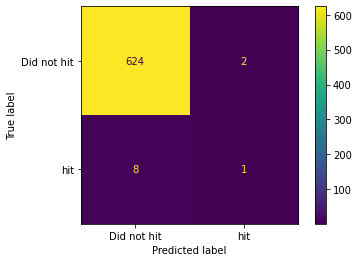

In [259]:
plot_confusion_matrix(clf_xgb,X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [260]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[0.1,0.01,0.05],
    'gamma':[0,0.25,1.0],
    'reg_lambda':[0,1.0,10.0],
    'scale_pos_weight':[1,5,10]
}

In [261]:
eval_set = [(X_test, y_test)]

In [262]:
gsearch1 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid, scoring='f1_micro'
                        ,n_jobs=10,verbose = 2, cv=3)
gsearch1.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-aucpr:0.03762
[1]	validation_0-aucpr:0.03762
[2]	validation_0-aucpr:0.03762
[3]	validation_0-aucpr:0.03442
[4]	validation_0-aucpr:0.03442
[5]	validation_0-aucpr:0.03533
[6]	validation_0-aucpr:0.05808
[7]	validation_0-aucpr:0.05808
[0]	validation_0-aucpr:0.06790
[8]	validation_0-aucpr:0.05691
[9]	validation_0-aucpr:0.05717
[1]	validation_0-aucpr:0.06658
[2]	validation_0-aucpr:0.06536
[3]	validation_0-aucpr:0.06817
[10]	validation_0-aucpr:0.05531
[11]	validation_0-aucpr:0.05531
[12]	validation_0-aucpr:0.05705
[0]	validation_0-aucpr:0.05864
[4]	validation_0-aucpr:0.08859
[1]	validation_0-aucpr:0.06343
[2]	validation_0-aucpr:0.06326
[5]	validation_0-aucpr:0.07368
[13]	validation_0-aucpr:0.05700
[6]	validation_0-aucpr:0.08724
[14]	validation_0-aucpr:0.05391
[15]	validation_0-aucpr:0.05413
[16]	validation_0-aucpr:0.05462
[0]	validation_0-aucpr:0.03603
[17]	validation_0-aucpr:0.06091
[1]	validation_0-aucpr:0.03069

[14]	validation_0-aucpr:0.05592
[24]	validation_0-aucpr:0.05444
[41]	validation_0-aucpr:0.08624
[24]	validation_0-aucpr:0.08191
[25]	validation_0-aucpr:0.05609
[50]	validation_0-aucpr:0.07704
[40]	validation_0-aucpr:0.05919
[25]	validation_0-aucpr:0.08531
[51]	validation_0-aucpr:0.07565
[41]	validation_0-aucpr:0.06221
[35]	validation_0-aucpr:0.06371
[42]	validation_0-aucpr:0.06324
[26]	validation_0-aucpr:0.08363
[52]	validation_0-aucpr:0.07286
[27]	validation_0-aucpr:0.09086
[28]	validation_0-aucpr:0.07438
[28]	validation_0-aucpr:0.07272
[29]	validation_0-aucpr:0.07801
[36]	validation_0-aucpr:0.06771
[29]	validation_0-aucpr:0.07060
[30]	validation_0-aucpr:0.07614
[31]	validation_0-aucpr:0.07295
[30]	validation_0-aucpr:0.07276
[26]	validation_0-aucpr:0.05581
[22]	validation_0-aucpr:0.06659
[42]	validation_0-aucpr:0.08639
[15]	validation_0-aucpr:0.05249
[27]	validation_0-aucpr:0.05868
[23]	validation_0-aucpr:0.06946
[16]	validation_0-aucpr:0.05092
[43]	validation_0-aucpr:0.08157
[37]	val

[95]	validation_0-aucpr:0.06229
[55]	validation_0-aucpr:0.08038
[64]	validation_0-aucpr:0.06123
[75]	validation_0-aucpr:0.08456
[81]	validation_0-aucpr:0.08737
[56]	validation_0-aucpr:0.08166
[82]	validation_0-aucpr:0.08603
[65]	validation_0-aucpr:0.06268
[57]	validation_0-aucpr:0.07940
[83]	validation_0-aucpr:0.08515
[66]	validation_0-aucpr:0.06185
[61]	validation_0-aucpr:0.08025
[62]	validation_0-aucpr:0.08750
[84]	validation_0-aucpr:0.09138
[85]	validation_0-aucpr:0.09170
[62]	validation_0-aucpr:0.08026
[63]	validation_0-aucpr:0.08983
[63]	validation_0-aucpr:0.07820
[86]	validation_0-aucpr:0.09205
[64]	validation_0-aucpr:0.08605
[48]	validation_0-aucpr:0.07081
[65]	validation_0-aucpr:0.08510
[49]	validation_0-aucpr:0.07172
[85]	validation_0-aucpr:0.07510
[86]	validation_0-aucpr:0.07493
[50]	validation_0-aucpr:0.07089
[96]	validation_0-aucpr:0.06263
[87]	validation_0-aucpr:0.07447
[51]	validation_0-aucpr:0.07054
[76]	validation_0-aucpr:0.08489
[77]	validation_0-aucpr:0.08471
[52]	val

[96]	validation_0-aucpr:0.08288
[97]	validation_0-aucpr:0.08273
[20]	validation_0-aucpr:0.03731
[11]	validation_0-aucpr:0.06801
[21]	validation_0-aucpr:0.03781
[3]	validation_0-aucpr:0.04377
[9]	validation_0-aucpr:0.05090
[10]	validation_0-aucpr:0.05146
[4]	validation_0-aucpr:0.04026
[5]	validation_0-aucpr:0.04106
[98]	validation_0-aucpr:0.08467
[99]	validation_0-aucpr:0.08826
[12]	validation_0-aucpr:0.06801
[22]	validation_0-aucpr:0.04659
[13]	validation_0-aucpr:0.06340
[11]	validation_0-aucpr:0.05774
[23]	validation_0-aucpr:0.04659
[14]	validation_0-aucpr:0.06291
[12]	validation_0-aucpr:0.05965
[24]	validation_0-aucpr:0.05491
[13]	validation_0-aucpr:0.06016
[6]	validation_0-aucpr:0.04070
[15]	validation_0-aucpr:0.05952
[7]	validation_0-aucpr:0.04070
[16]	validation_0-aucpr:0.06751
[17]	validation_0-aucpr:0.06751
[25]	validation_0-aucpr:0.05774
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-aucpr:0.06561
[26]	val

[24]	validation_0-aucpr:0.09993
[50]	validation_0-aucpr:0.07497
[35]	validation_0-aucpr:0.07264
[51]	validation_0-aucpr:0.07771
[25]	validation_0-aucpr:0.10028
[29]	validation_0-aucpr:0.06910
[18]	validation_0-aucpr:0.04811
[26]	validation_0-aucpr:0.09482
[19]	validation_0-aucpr:0.04962
[30]	validation_0-aucpr:0.07052
[31]	validation_0-aucpr:0.07065
[20]	validation_0-aucpr:0.05043
[32]	validation_0-aucpr:0.07045
[54]	validation_0-aucpr:0.07443
[33]	validation_0-aucpr:0.07102
[43]	validation_0-aucpr:0.07097
[55]	validation_0-aucpr:0.07374
[34]	validation_0-aucpr:0.07160
[44]	validation_0-aucpr:0.06725
[12]	validation_0-aucpr:0.05935
[36]	validation_0-aucpr:0.07264
[45]	validation_0-aucpr:0.06791
[24]	validation_0-aucpr:0.06111
[52]	validation_0-aucpr:0.07726
[37]	validation_0-aucpr:0.07109
[25]	validation_0-aucpr:0.06502
[13]	validation_0-aucpr:0.05219
[53]	validation_0-aucpr:0.07755
[38]	validation_0-aucpr:0.07138
[54]	validation_0-aucpr:0.07630
[14]	validation_0-aucpr:0.05219
[21]	val

[92]	validation_0-aucpr:0.07702
[81]	validation_0-aucpr:0.06069
[55]	validation_0-aucpr:0.07550
[93]	validation_0-aucpr:0.07723
[94]	validation_0-aucpr:0.07656
[56]	validation_0-aucpr:0.07553
[69]	validation_0-aucpr:0.08182
[57]	validation_0-aucpr:0.07453
[70]	validation_0-aucpr:0.08199
[93]	validation_0-aucpr:0.08047
[60]	validation_0-aucpr:0.07776
[71]	validation_0-aucpr:0.08191
[94]	validation_0-aucpr:0.07957
[45]	validation_0-aucpr:0.05734
[61]	validation_0-aucpr:0.07852
[95]	validation_0-aucpr:0.07966
[57]	validation_0-aucpr:0.06962
[62]	validation_0-aucpr:0.07829
[46]	validation_0-aucpr:0.05827
[82]	validation_0-aucpr:0.06039
[47]	validation_0-aucpr:0.05681
[83]	validation_0-aucpr:0.06074
[58]	validation_0-aucpr:0.07101
[84]	validation_0-aucpr:0.06030
[59]	validation_0-aucpr:0.07310
[95]	validation_0-aucpr:0.07406
[58]	validation_0-aucpr:0.07382
[96]	validation_0-aucpr:0.07396
[73]	validation_0-aucpr:0.16300
[72]	validation_0-aucpr:0.08079
[59]	validation_0-aucpr:0.07246
[97]	val

[11]	validation_0-aucpr:0.03644
[98]	validation_0-aucpr:0.06980
[6]	validation_0-aucpr:0.06236
[7]	validation_0-aucpr:0.06236
[8]	validation_0-aucpr:0.06017
[92]	validation_0-aucpr:0.08115
[93]	validation_0-aucpr:0.08451
[93]	validation_0-aucpr:0.08380
[94]	validation_0-aucpr:0.08475
[94]	validation_0-aucpr:0.08420
[81]	validation_0-aucpr:0.05329
[12]	validation_0-aucpr:0.03644
[95]	validation_0-aucpr:0.08476
[82]	validation_0-aucpr:0.05268
[83]	validation_0-aucpr:0.05254
[13]	validation_0-aucpr:0.03644
[14]	validation_0-aucpr:0.03644
[15]	validation_0-aucpr:0.04475
[99]	validation_0-aucpr:0.06865
[9]	validation_0-aucpr:0.06017
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.2s
[0]	validation_0-aucpr:0.03449
[10]	validation_0-aucpr:0.06017
[1]	validation_0-aucpr:0.03352
[95]	validation_0-aucpr:0.08446
[11]	validation_0-aucpr:0.06017
[96]	validation_0-aucpr:0.08427
[96]	validation_0-aucpr:0.08428
[84]	validation_0-aucpr:0.05194
[97]	

[40]	validation_0-aucpr:0.07269
[22]	validation_0-aucpr:0.05101
[10]	validation_0-aucpr:0.05564
[34]	validation_0-aucpr:0.06729
[23]	validation_0-aucpr:0.05359
[35]	validation_0-aucpr:0.06131
[25]	validation_0-aucpr:0.05501
[64]	validation_0-aucpr:0.07832
[26]	validation_0-aucpr:0.05563
[36]	validation_0-aucpr:0.06311
[65]	validation_0-aucpr:0.07562
[27]	validation_0-aucpr:0.05500
[66]	validation_0-aucpr:0.07752
[63]	validation_0-aucpr:0.07861
[47]	validation_0-aucpr:0.05647
[64]	validation_0-aucpr:0.07892
[11]	validation_0-aucpr:0.05510
[48]	validation_0-aucpr:0.05667
[65]	validation_0-aucpr:0.07981
[30]	validation_0-aucpr:0.07469
[41]	validation_0-aucpr:0.07321
[31]	validation_0-aucpr:0.07563
[42]	validation_0-aucpr:0.07321
[24]	validation_0-aucpr:0.05280
[43]	validation_0-aucpr:0.07281
[28]	validation_0-aucpr:0.05711
[25]	validation_0-aucpr:0.05330
[67]	validation_0-aucpr:0.07752
[37]	validation_0-aucpr:0.06761
[29]	validation_0-aucpr:0.05648
[68]	validation_0-aucpr:0.07705
[38]	val

[76]	validation_0-aucpr:0.07321
[70]	validation_0-aucpr:0.08500
[99]	validation_0-aucpr:0.07692
[77]	validation_0-aucpr:0.07286
[63]	validation_0-aucpr:0.08019
[61]	validation_0-aucpr:0.06264
[64]	validation_0-aucpr:0.08103
[62]	validation_0-aucpr:0.06454
[78]	validation_0-aucpr:0.07303
[65]	validation_0-aucpr:0.07908
[79]	validation_0-aucpr:0.07316
[66]	validation_0-aucpr:0.08111
[67]	validation_0-aucpr:0.08142
[55]	validation_0-aucpr:0.07820
[36]	validation_0-aucpr:0.07104
[81]	validation_0-aucpr:0.05914
[56]	validation_0-aucpr:0.07746
[82]	validation_0-aucpr:0.05928
[37]	validation_0-aucpr:0.06852
[83]	validation_0-aucpr:0.05907
[84]	validation_0-aucpr:0.05908
[71]	validation_0-aucpr:0.08552
[85]	validation_0-aucpr:0.05926
[63]	validation_0-aucpr:0.06468
[86]	validation_0-aucpr:0.05939
[72]	validation_0-aucpr:0.08642
[57]	validation_0-aucpr:0.07569
[38]	validation_0-aucpr:0.06613
[64]	validation_0-aucpr:0.06404
[73]	validation_0-aucpr:0.08591
[65]	validation_0-aucpr:0.06381
[39]	val

[16]	validation_0-aucpr:0.07477
[1]	validation_0-aucpr:0.18217
[2]	validation_0-aucpr:0.19155
[20]	validation_0-aucpr:0.05019
[98]	validation_0-aucpr:0.08848
[21]	validation_0-aucpr:0.04925
[99]	validation_0-aucpr:0.08930
[17]	validation_0-aucpr:0.06877
[85]	validation_0-aucpr:0.06997
[CV] END gamma=0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-aucpr:0.02009
[18]	validation_0-aucpr:0.07144
[86]	validation_0-aucpr:0.07083
[1]	validation_0-aucpr:0.03442
[87]	validation_0-aucpr:0.07062
[3]	validation_0-aucpr:0.17905
[88]	validation_0-aucpr:0.07084
[22]	validation_0-aucpr:0.05316
[4]	validation_0-aucpr:0.16656
[89]	validation_0-aucpr:0.07139
[90]	validation_0-aucpr:0.07191
[23]	validation_0-aucpr:0.05637
[24]	validation_0-aucpr:0.05147
[19]	validation_0-aucpr:0.07176
[2]	validation_0-aucpr:0.03782
[5]	validation_0-aucpr:0.16989
[20]	validation_0-aucpr:0.07140
[3]	validation_0-aucpr:0.03572
[6]	validation_0-aucpr:0.17160
[25]	val

[15]	validation_0-aucpr:0.05475
[66]	validation_0-aucpr:0.08336
[29]	validation_0-aucpr:0.08601
[27]	validation_0-aucpr:0.06169
[16]	validation_0-aucpr:0.05531
[67]	validation_0-aucpr:0.08415
[30]	validation_0-aucpr:0.08601
[28]	validation_0-aucpr:0.06922
[37]	validation_0-aucpr:0.10459
[29]	validation_0-aucpr:0.07395
[38]	validation_0-aucpr:0.10403
[30]	validation_0-aucpr:0.06548
[39]	validation_0-aucpr:0.07364
[42]	validation_0-aucpr:0.07768
[43]	validation_0-aucpr:0.07687
[40]	validation_0-aucpr:0.07877
[27]	validation_0-aucpr:0.05872
[68]	validation_0-aucpr:0.07067
[28]	validation_0-aucpr:0.05986
[69]	validation_0-aucpr:0.06981
[68]	validation_0-aucpr:0.08088
[17]	validation_0-aucpr:0.05287
[39]	validation_0-aucpr:0.10434
[70]	validation_0-aucpr:0.06754
[18]	validation_0-aucpr:0.05282
[71]	validation_0-aucpr:0.06863
[69]	validation_0-aucpr:0.07917
[40]	validation_0-aucpr:0.10894
[31]	validation_0-aucpr:0.08284
[70]	validation_0-aucpr:0.08120
[44]	validation_0-aucpr:0.07825
[41]	val

[56]	validation_0-aucpr:0.08078
[43]	validation_0-aucpr:0.06161
[57]	validation_0-aucpr:0.07894
[53]	validation_0-aucpr:0.07457
[44]	validation_0-aucpr:0.06659
[58]	validation_0-aucpr:0.07876
[59]	validation_0-aucpr:0.07889
[54]	validation_0-aucpr:0.07457
[60]	validation_0-aucpr:0.07710
[61]	validation_0-aucpr:0.07196
[73]	validation_0-aucpr:0.08484
[55]	validation_0-aucpr:0.07459
[74]	validation_0-aucpr:0.08157
[53]	validation_0-aucpr:0.09713
[75]	validation_0-aucpr:0.07950
[54]	validation_0-aucpr:0.09746
[45]	validation_0-aucpr:0.06544
[46]	validation_0-aucpr:0.06753
[70]	validation_0-aucpr:0.08379
[47]	validation_0-aucpr:0.07076
[71]	validation_0-aucpr:0.08381
[72]	validation_0-aucpr:0.16960
[56]	validation_0-aucpr:0.07522
[76]	validation_0-aucpr:0.08074
[73]	validation_0-aucpr:0.16986
[77]	validation_0-aucpr:0.08074
[74]	validation_0-aucpr:0.16990
[57]	validation_0-aucpr:0.07539
[78]	validation_0-aucpr:0.07753
[55]	validation_0-aucpr:0.08540
[58]	validation_0-aucpr:0.07604
[56]	val

[19]	validation_0-aucpr:0.04374
[77]	validation_0-aucpr:0.06760
[87]	validation_0-aucpr:0.07714
[78]	validation_0-aucpr:0.06671
[88]	validation_0-aucpr:0.07672
[12]	validation_0-aucpr:0.06544
[13]	validation_0-aucpr:0.07223
[90]	validation_0-aucpr:0.06455
[91]	validation_0-aucpr:0.06484
[88]	validation_0-aucpr:0.08662
[20]	validation_0-aucpr:0.04134
[89]	validation_0-aucpr:0.08668
[90]	validation_0-aucpr:0.08624
[21]	validation_0-aucpr:0.04177
[89]	validation_0-aucpr:0.07192
[91]	validation_0-aucpr:0.08556
[90]	validation_0-aucpr:0.07632
[79]	validation_0-aucpr:0.06780
[91]	validation_0-aucpr:0.07590
[14]	validation_0-aucpr:0.06762
[80]	validation_0-aucpr:0.06772
[15]	validation_0-aucpr:0.06424
[81]	validation_0-aucpr:0.06751
[92]	validation_0-aucpr:0.06389
[16]	validation_0-aucpr:0.07025
[22]	validation_0-aucpr:0.04177
[93]	validation_0-aucpr:0.06400
[92]	validation_0-aucpr:0.08551
[94]	validation_0-aucpr:0.06404
[93]	validation_0-aucpr:0.08537
[23]	validation_0-aucpr:0.05302
[94]	val

[33]	validation_0-aucpr:0.07658
[10]	validation_0-aucpr:0.06052
[15]	validation_0-aucpr:0.17779
[28]	validation_0-aucpr:0.06545
[34]	validation_0-aucpr:0.07683
[11]	validation_0-aucpr:0.06631
[12]	validation_0-aucpr:0.04426
[12]	validation_0-aucpr:0.07363
[13]	validation_0-aucpr:0.06902
[35]	validation_0-aucpr:0.07008
[35]	validation_0-aucpr:0.07290
[13]	validation_0-aucpr:0.04525
[36]	validation_0-aucpr:0.06949
[67]	validation_0-aucpr:0.07070
[37]	validation_0-aucpr:0.06792
[68]	validation_0-aucpr:0.07105
[14]	validation_0-aucpr:0.04426
[69]	validation_0-aucpr:0.07168
[16]	validation_0-aucpr:0.10385
[15]	validation_0-aucpr:0.04525
[19]	validation_0-aucpr:0.05362
[29]	validation_0-aucpr:0.06738
[17]	validation_0-aucpr:0.10439
[20]	validation_0-aucpr:0.05435
[30]	validation_0-aucpr:0.06704
[18]	validation_0-aucpr:0.10490
[31]	validation_0-aucpr:0.07603
[68]	validation_0-aucpr:0.07489
[31]	validation_0-aucpr:0.06795
[36]	validation_0-aucpr:0.07302
[32]	validation_0-aucpr:0.07547
[69]	val

[67]	validation_0-aucpr:0.07161
[50]	validation_0-aucpr:0.06795
[42]	validation_0-aucpr:0.08151
[68]	validation_0-aucpr:0.07213
[43]	validation_0-aucpr:0.08109
[69]	validation_0-aucpr:0.06895
[51]	validation_0-aucpr:0.06843
[55]	validation_0-aucpr:0.09796
[38]	validation_0-aucpr:0.07346
[56]	validation_0-aucpr:0.09877
[39]	validation_0-aucpr:0.07163
[57]	validation_0-aucpr:0.09802
[39]	validation_0-aucpr:0.08735
[40]	validation_0-aucpr:0.07116
[65]	validation_0-aucpr:0.10815
[40]	validation_0-aucpr:0.16598
[66]	validation_0-aucpr:0.10737
[70]	validation_0-aucpr:0.06814
[41]	validation_0-aucpr:0.16565
[67]	validation_0-aucpr:0.10723
[71]	validation_0-aucpr:0.06941
[52]	validation_0-aucpr:0.06857
[65]	validation_0-aucpr:0.06553
[53]	validation_0-aucpr:0.06822
[72]	validation_0-aucpr:0.07011
[66]	validation_0-aucpr:0.06698
[44]	validation_0-aucpr:0.07930
[54]	validation_0-aucpr:0.07056
[67]	validation_0-aucpr:0.06554
[58]	validation_0-aucpr:0.09923
[45]	validation_0-aucpr:0.08057
[41]	val

[84]	validation_0-aucpr:0.07066
[71]	validation_0-aucpr:0.16802
[17]	validation_0-aucpr:0.05938
[85]	validation_0-aucpr:0.06956
[75]	validation_0-aucpr:0.07700
[86]	validation_0-aucpr:0.07069
[76]	validation_0-aucpr:0.07311
[92]	validation_0-aucpr:0.17665
[19]	validation_0-aucpr:0.04476
[93]	validation_0-aucpr:0.17663
[94]	validation_0-aucpr:0.17668
[20]	validation_0-aucpr:0.04476
[97]	validation_0-aucpr:0.07259
[21]	validation_0-aucpr:0.04476
[98]	validation_0-aucpr:0.07176
[99]	validation_0-aucpr:0.07104
[72]	validation_0-aucpr:0.16886
[73]	validation_0-aucpr:0.16957
[18]	validation_0-aucpr:0.05950
[70]	validation_0-aucpr:0.06816
[77]	validation_0-aucpr:0.07254
[19]	validation_0-aucpr:0.05341
[87]	validation_0-aucpr:0.07038
[71]	validation_0-aucpr:0.06738
[78]	validation_0-aucpr:0.07400
[88]	validation_0-aucpr:0.07093
[95]	validation_0-aucpr:0.17642
[79]	validation_0-aucpr:0.07557
[89]	validation_0-aucpr:0.07021
[96]	validation_0-aucpr:0.17648
[97]	validation_0-aucpr:0.17611
[22]	val

[7]	validation_0-aucpr:0.05379
[13]	validation_0-aucpr:0.05929
[14]	validation_0-aucpr:0.05981
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=10; total time=   1.5s
[0]	validation_0-aucpr:0.03848
[8]	validation_0-aucpr:0.05920
[15]	validation_0-aucpr:0.05864
[56]	validation_0-aucpr:0.08791
[27]	validation_0-aucpr:0.06253
[62]	validation_0-aucpr:0.09616
[57]	validation_0-aucpr:0.08839
[21]	validation_0-aucpr:0.05351
[63]	validation_0-aucpr:0.09693
[28]	validation_0-aucpr:0.06197
[22]	validation_0-aucpr:0.05371
[64]	validation_0-aucpr:0.09698
[65]	validation_0-aucpr:0.09719
[20]	validation_0-aucpr:0.06523
[66]	validation_0-aucpr:0.09686
[21]	validation_0-aucpr:0.06662
[16]	validation_0-aucpr:0.05864
[1]	validation_0-aucpr:0.03848
[17]	validation_0-aucpr:0.06195
[9]	validation_0-aucpr:0.05914
[2]	validation_0-aucpr:0.03761
[CV] END gamma=0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=10; total time=   1.6s
[0]	validation_0-aucpr:0.0

[53]	validation_0-aucpr:0.06767
[64]	validation_0-aucpr:0.06693
[43]	validation_0-aucpr:0.05768
[54]	validation_0-aucpr:0.06673
[65]	validation_0-aucpr:0.06743
[44]	validation_0-aucpr:0.05758
[41]	validation_0-aucpr:0.06904
[94]	validation_0-aucpr:0.07678
[42]	validation_0-aucpr:0.06885
[21]	validation_0-aucpr:0.07224
[95]	validation_0-aucpr:0.07668
[57]	validation_0-aucpr:0.08700
[22]	validation_0-aucpr:0.07249
[64]	validation_0-aucpr:0.07117
[58]	validation_0-aucpr:0.08581
[23]	validation_0-aucpr:0.07109
[65]	validation_0-aucpr:0.07072
[24]	validation_0-aucpr:0.06970
[43]	validation_0-aucpr:0.06851
[27]	validation_0-aucpr:0.06493
[44]	validation_0-aucpr:0.06876
[96]	validation_0-aucpr:0.07697
[28]	validation_0-aucpr:0.06681
[97]	validation_0-aucpr:0.07689
[59]	validation_0-aucpr:0.08687
[45]	validation_0-aucpr:0.07023
[60]	validation_0-aucpr:0.08717
[66]	validation_0-aucpr:0.07055
[61]	validation_0-aucpr:0.08701
[66]	validation_0-aucpr:0.06801
[62]	validation_0-aucpr:0.08621
[67]	val

[77]	validation_0-aucpr:0.05974
[18]	validation_0-aucpr:0.07055
[89]	validation_0-aucpr:0.16422
[57]	validation_0-aucpr:0.07311
[90]	validation_0-aucpr:0.16410
[58]	validation_0-aucpr:0.07228
[91]	validation_0-aucpr:0.16397
[92]	validation_0-aucpr:0.16405
[7]	validation_0-aucpr:0.17168
[59]	validation_0-aucpr:0.07317
[93]	validation_0-aucpr:0.16420
[86]	validation_0-aucpr:0.06744
[8]	validation_0-aucpr:0.17135
[99]	validation_0-aucpr:0.06551
[98]	validation_0-aucpr:0.06641
[87]	validation_0-aucpr:0.06746
[75]	validation_0-aucpr:0.08504
[99]	validation_0-aucpr:0.06688
[51]	validation_0-aucpr:0.08593
[76]	validation_0-aucpr:0.08470
[78]	validation_0-aucpr:0.05974
[52]	validation_0-aucpr:0.08480
[77]	validation_0-aucpr:0.08464
[19]	validation_0-aucpr:0.07076
[79]	validation_0-aucpr:0.05985
[20]	validation_0-aucpr:0.07173
[94]	validation_0-aucpr:0.16424
[88]	validation_0-aucpr:0.06666
[95]	validation_0-aucpr:0.16448
[9]	validation_0-aucpr:0.16151
[89]	validation_0-aucpr:0.06675
[60]	valida

[32]	validation_0-aucpr:0.07943
[4]	validation_0-aucpr:0.14749
[33]	validation_0-aucpr:0.08060
[34]	validation_0-aucpr:0.08130
[5]	validation_0-aucpr:0.14749
[56]	validation_0-aucpr:0.06791
[2]	validation_0-aucpr:0.03267
[57]	validation_0-aucpr:0.06696
[6]	validation_0-aucpr:0.14643
[10]	validation_0-aucpr:0.16675
[58]	validation_0-aucpr:0.06744
[7]	validation_0-aucpr:0.15525
[11]	validation_0-aucpr:0.16543
[8]	validation_0-aucpr:0.15525
[3]	validation_0-aucpr:0.02999
[97]	validation_0-aucpr:0.07971
[98]	validation_0-aucpr:0.08011
[99]	validation_0-aucpr:0.07979
[59]	validation_0-aucpr:0.06725
[60]	validation_0-aucpr:0.06825
[12]	validation_0-aucpr:0.16480
[61]	validation_0-aucpr:0.06773
[12]	validation_0-aucpr:0.05449
[13]	validation_0-aucpr:0.16537
[13]	validation_0-aucpr:0.05157
[35]	validation_0-aucpr:0.08114
[4]	validation_0-aucpr:0.02888
[62]	validation_0-aucpr:0.06658
[36]	validation_0-aucpr:0.07653
[63]	validation_0-aucpr:0.06671
[14]	validation_0-aucpr:0.05569
[64]	validation_

[43]	validation_0-aucpr:0.09649
[14]	validation_0-aucpr:0.06410
[44]	validation_0-aucpr:0.09599
[15]	validation_0-aucpr:0.06414
[27]	validation_0-aucpr:0.06164
[16]	validation_0-aucpr:0.06615
[31]	validation_0-aucpr:0.08817
[17]	validation_0-aucpr:0.04269
[20]	validation_0-aucpr:0.05482
[32]	validation_0-aucpr:0.08737
[18]	validation_0-aucpr:0.04310
[21]	validation_0-aucpr:0.05517
[37]	validation_0-aucpr:0.08519
[38]	validation_0-aucpr:0.07552
[26]	validation_0-aucpr:0.08133
[66]	validation_0-aucpr:0.06767
[67]	validation_0-aucpr:0.06779
[45]	validation_0-aucpr:0.09048
[27]	validation_0-aucpr:0.08234
[68]	validation_0-aucpr:0.06872
[46]	validation_0-aucpr:0.09169
[28]	validation_0-aucpr:0.08634
[28]	validation_0-aucpr:0.06572
[47]	validation_0-aucpr:0.09121
[33]	validation_0-aucpr:0.08543
[29]	validation_0-aucpr:0.07169
[19]	validation_0-aucpr:0.04280
[48]	validation_0-aucpr:0.09292
[39]	validation_0-aucpr:0.07706
[20]	validation_0-aucpr:0.03967
[22]	validation_0-aucpr:0.05516
[69]	val

[64]	validation_0-aucpr:0.17772
[86]	validation_0-aucpr:0.12155
[87]	validation_0-aucpr:0.12229
[52]	validation_0-aucpr:0.07375
[65]	validation_0-aucpr:0.17825
[66]	validation_0-aucpr:0.17796
[75]	validation_0-aucpr:0.08260
[53]	validation_0-aucpr:0.07312
[64]	validation_0-aucpr:0.08448
[58]	validation_0-aucpr:0.07336
[65]	validation_0-aucpr:0.08461
[76]	validation_0-aucpr:0.08373
[66]	validation_0-aucpr:0.08512
[77]	validation_0-aucpr:0.08373
[78]	validation_0-aucpr:0.08435
[18]	validation_0-aucpr:0.09833
[79]	validation_0-aucpr:0.08413
[80]	validation_0-aucpr:0.08276
[58]	validation_0-aucpr:0.07337
[59]	validation_0-aucpr:0.07253
[19]	validation_0-aucpr:0.08422
[57]	validation_0-aucpr:0.08516
[60]	validation_0-aucpr:0.07138
[58]	validation_0-aucpr:0.08579
[59]	validation_0-aucpr:0.07304
[88]	validation_0-aucpr:0.12229
[60]	validation_0-aucpr:0.07585
[59]	validation_0-aucpr:0.08621
[20]	validation_0-aucpr:0.08339
[89]	validation_0-aucpr:0.11787
[21]	validation_0-aucpr:0.07602
[90]	val

[96]	validation_0-aucpr:0.09633
[97]	validation_0-aucpr:0.06627
[4]	validation_0-aucpr:0.07535
[97]	validation_0-aucpr:0.09679
[89]	validation_0-aucpr:0.08024
[22]	validation_0-aucpr:0.06621
[90]	validation_0-aucpr:0.07694
[23]	validation_0-aucpr:0.06915
[91]	validation_0-aucpr:0.07676
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-aucpr:0.06483
[98]	validation_0-aucpr:0.06620
[5]	validation_0-aucpr:0.09766
[98]	validation_0-aucpr:0.09806
[99]	validation_0-aucpr:0.06512
[99]	validation_0-aucpr:0.09760
[6]	validation_0-aucpr:0.08141
[7]	validation_0-aucpr:0.09965
[8]	validation_0-aucpr:0.17217
[54]	validation_0-aucpr:0.07453
[9]	validation_0-aucpr:0.08817
[24]	validation_0-aucpr:0.07138
[92]	validation_0-aucpr:0.07719
[55]	validation_0-aucpr:0.07429
[1]	validation_0-aucpr:0.07125
[93]	validation_0-aucpr:0.07717
[94]	validation_0-aucpr:0.07727
[25]	validation_0-aucpr:0.07011
[2]	validation_0-aucpr:0.07125
[26]	valid

[93]	validation_0-aucpr:0.07335
[20]	validation_0-aucpr:0.07126
[23]	validation_0-aucpr:0.04175
[21]	validation_0-aucpr:0.07318
[23]	validation_0-aucpr:0.06907
[22]	validation_0-aucpr:0.05729
[44]	validation_0-aucpr:0.18375
[34]	validation_0-aucpr:0.07083
[24]	validation_0-aucpr:0.07030
[45]	validation_0-aucpr:0.18714
[35]	validation_0-aucpr:0.07044
[23]	validation_0-aucpr:0.05838
[25]	validation_0-aucpr:0.07114
[36]	validation_0-aucpr:0.07198
[20]	validation_0-aucpr:0.05686
[13]	validation_0-aucpr:0.06691
[21]	validation_0-aucpr:0.05886
[22]	validation_0-aucpr:0.05723
[14]	validation_0-aucpr:0.06594
[23]	validation_0-aucpr:0.05856
[61]	validation_0-aucpr:0.07828
[24]	validation_0-aucpr:0.06271
[24]	validation_0-aucpr:0.04175
[62]	validation_0-aucpr:0.07852
[94]	validation_0-aucpr:0.07299
[63]	validation_0-aucpr:0.08057
[95]	validation_0-aucpr:0.07370
[25]	validation_0-aucpr:0.05076
[22]	validation_0-aucpr:0.06347
[64]	validation_0-aucpr:0.07892
[96]	validation_0-aucpr:0.07372
[65]	val

[64]	validation_0-aucpr:0.07507
[79]	validation_0-aucpr:0.18455
[96]	validation_0-aucpr:0.08444
[65]	validation_0-aucpr:0.07383
[80]	validation_0-aucpr:0.18467
[7]	validation_0-aucpr:0.04516
[97]	validation_0-aucpr:0.08438
[81]	validation_0-aucpr:0.18428
[53]	validation_0-aucpr:0.09266
[52]	validation_0-aucpr:0.07599
[8]	validation_0-aucpr:0.04632
[42]	validation_0-aucpr:0.06276
[54]	validation_0-aucpr:0.09266
[52]	validation_0-aucpr:0.07406
[51]	validation_0-aucpr:0.09314
[55]	validation_0-aucpr:0.09213
[53]	validation_0-aucpr:0.07355
[53]	validation_0-aucpr:0.07560
[52]	validation_0-aucpr:0.09679
[54]	validation_0-aucpr:0.07650
[54]	validation_0-aucpr:0.08214
[43]	validation_0-aucpr:0.06275
[66]	validation_0-aucpr:0.07510
[58]	validation_0-aucpr:0.08103
[98]	validation_0-aucpr:0.08457
[82]	validation_0-aucpr:0.18293
[67]	validation_0-aucpr:0.07485
[59]	validation_0-aucpr:0.08103
[83]	validation_0-aucpr:0.18390
[99]	validation_0-aucpr:0.08464
[60]	validation_0-aucpr:0.07905
[84]	valid

[89]	validation_0-aucpr:0.10321
[82]	validation_0-aucpr:0.08164
[90]	validation_0-aucpr:0.10328
[11]	validation_0-aucpr:0.06135
[71]	validation_0-aucpr:0.06967
[72]	validation_0-aucpr:0.06966
[12]	validation_0-aucpr:0.06195
[96]	validation_0-aucpr:0.07302
[90]	validation_0-aucpr:0.09937
[91]	validation_0-aucpr:0.09960
[82]	validation_0-aucpr:0.07650
[1]	validation_0-aucpr:0.05085
[83]	validation_0-aucpr:0.07571
[97]	validation_0-aucpr:0.07293
[83]	validation_0-aucpr:0.07598
[84]	validation_0-aucpr:0.07537
[2]	validation_0-aucpr:0.05085
[98]	validation_0-aucpr:0.07329
[84]	validation_0-aucpr:0.07554
[85]	validation_0-aucpr:0.07526
[3]	validation_0-aucpr:0.04927
[91]	validation_0-aucpr:0.10299
[13]	validation_0-aucpr:0.06118
[38]	validation_0-aucpr:0.06526
[4]	validation_0-aucpr:0.06368
[92]	validation_0-aucpr:0.10314
[39]	validation_0-aucpr:0.06836
[14]	validation_0-aucpr:0.06009
[93]	validation_0-aucpr:0.10216
[15]	validation_0-aucpr:0.05408
[94]	validation_0-aucpr:0.10326
[92]	validat

[42]	validation_0-aucpr:0.06471
[13]	validation_0-aucpr:0.04027
[22]	validation_0-aucpr:0.02851
[23]	validation_0-aucpr:0.02763
[79]	validation_0-aucpr:0.07883
[23]	validation_0-aucpr:0.03961
[80]	validation_0-aucpr:0.07759
[24]	validation_0-aucpr:0.03928
[61]	validation_0-aucpr:0.06928
[27]	validation_0-aucpr:0.05008
[81]	validation_0-aucpr:0.07843
[82]	validation_0-aucpr:0.07845
[28]	validation_0-aucpr:0.05279
[25]	validation_0-aucpr:0.03928
[62]	validation_0-aucpr:0.06980
[1]	validation_0-aucpr:0.03215
[29]	validation_0-aucpr:0.04518
[30]	validation_0-aucpr:0.04518
[2]	validation_0-aucpr:0.03313
[17]	validation_0-aucpr:0.06555
[14]	validation_0-aucpr:0.04027
[43]	validation_0-aucpr:0.06245
[18]	validation_0-aucpr:0.06203
[24]	validation_0-aucpr:0.02862
[19]	validation_0-aucpr:0.06217
[15]	validation_0-aucpr:0.04027
[25]	validation_0-aucpr:0.02914
[26]	validation_0-aucpr:0.03591
[44]	validation_0-aucpr:0.06187
[16]	validation_0-aucpr:0.04027
[63]	validation_0-aucpr:0.06980
[27]	valid

[63]	validation_0-aucpr:0.03350
[55]	validation_0-aucpr:0.06623
[94]	validation_0-aucpr:0.07609
[57]	validation_0-aucpr:0.05790
[61]	validation_0-aucpr:0.05306
[95]	validation_0-aucpr:0.07601
[51]	validation_0-aucpr:0.03493
[58]	validation_0-aucpr:0.05814
[40]	validation_0-aucpr:0.03579
[52]	validation_0-aucpr:0.03463
[CV] END gamma=0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   2.2s
[0]	validation_0-aucpr:0.06790
[1]	validation_0-aucpr:0.06790
[2]	validation_0-aucpr:0.06790
[53]	validation_0-aucpr:0.03551
[41]	validation_0-aucpr:0.03579
[66]	validation_0-aucpr:0.05694
[3]	validation_0-aucpr:0.06790
[54]	validation_0-aucpr:0.03468
[42]	validation_0-aucpr:0.03579
[55]	validation_0-aucpr:0.03468
[74]	validation_0-aucpr:0.06552
[67]	validation_0-aucpr:0.05728
[62]	validation_0-aucpr:0.05321
[68]	validation_0-aucpr:0.05728
[75]	validation_0-aucpr:0.06598
[63]	validation_0-aucpr:0.05327
[64]	validation_0-aucpr:0.03367
[56]	validation_0-aucpr:0.06623
[5

[78]	validation_0-aucpr:0.05097
[93]	validation_0-aucpr:0.06904
[79]	validation_0-aucpr:0.05097
[80]	validation_0-aucpr:0.05097
[94]	validation_0-aucpr:0.06904
[81]	validation_0-aucpr:0.05097
[86]	validation_0-aucpr:0.06131
[82]	validation_0-aucpr:0.05097
[87]	validation_0-aucpr:0.06065
[34]	validation_0-aucpr:0.06446
[93]	validation_0-aucpr:0.05782
[35]	validation_0-aucpr:0.06596
[13]	validation_0-aucpr:0.02851
[94]	validation_0-aucpr:0.05801
[36]	validation_0-aucpr:0.06042
[14]	validation_0-aucpr:0.02851
[95]	validation_0-aucpr:0.06904
[37]	validation_0-aucpr:0.05939
[90]	validation_0-aucpr:0.03322
[96]	validation_0-aucpr:0.06904
[38]	validation_0-aucpr:0.06000
[91]	validation_0-aucpr:0.03322
[97]	validation_0-aucpr:0.06904
[15]	validation_0-aucpr:0.02851
[92]	validation_0-aucpr:0.03322
[88]	validation_0-aucpr:0.06154
[16]	validation_0-aucpr:0.02851
[95]	validation_0-aucpr:0.05798
[17]	validation_0-aucpr:0.02851
[96]	validation_0-aucpr:0.05784
[89]	validation_0-aucpr:0.06201
[18]	val

[57]	validation_0-aucpr:0.05919
[2]	validation_0-aucpr:0.07877
[31]	validation_0-aucpr:0.03384
[34]	validation_0-aucpr:0.03008
[58]	validation_0-aucpr:0.05919
[32]	validation_0-aucpr:0.03384
[35]	validation_0-aucpr:0.02955
[36]	validation_0-aucpr:0.03008
[59]	validation_0-aucpr:0.05919
[17]	validation_0-aucpr:0.03508
[9]	validation_0-aucpr:0.02970
[33]	validation_0-aucpr:0.03384
[29]	validation_0-aucpr:0.04796
[18]	validation_0-aucpr:0.03508
[34]	validation_0-aucpr:0.03384
[19]	validation_0-aucpr:0.03443
[10]	validation_0-aucpr:0.02970
[30]	validation_0-aucpr:0.04796
[11]	validation_0-aucpr:0.02970
[12]	validation_0-aucpr:0.02970
[14]	validation_0-aucpr:0.04094
[17]	validation_0-aucpr:0.06728
[80]	validation_0-aucpr:0.11849
[3]	validation_0-aucpr:0.07877
[15]	validation_0-aucpr:0.03966
[18]	validation_0-aucpr:0.06728
[81]	validation_0-aucpr:0.11832
[16]	validation_0-aucpr:0.03966
[82]	validation_0-aucpr:0.11751
[4]	validation_0-aucpr:0.07877
[60]	validation_0-aucpr:0.06005
[17]	validat

[57]	validation_0-aucpr:0.04172
[65]	validation_0-aucpr:0.03580
[32]	validation_0-aucpr:0.08276
[58]	validation_0-aucpr:0.04251
[33]	validation_0-aucpr:0.08276
[43]	validation_0-aucpr:0.03562
[39]	validation_0-aucpr:0.04026
[59]	validation_0-aucpr:0.04219
[44]	validation_0-aucpr:0.03562
[45]	validation_0-aucpr:0.03562
[60]	validation_0-aucpr:0.04252
[40]	validation_0-aucpr:0.04026
[61]	validation_0-aucpr:0.04219
[41]	validation_0-aucpr:0.04026
[88]	validation_0-aucpr:0.07258
[61]	validation_0-aucpr:0.03591
[89]	validation_0-aucpr:0.07258
[66]	validation_0-aucpr:0.03580
[62]	validation_0-aucpr:0.03870
[34]	validation_0-aucpr:0.08276
[67]	validation_0-aucpr:0.03580
[35]	validation_0-aucpr:0.08276
[68]	validation_0-aucpr:0.03335
[36]	validation_0-aucpr:0.08276
[42]	validation_0-aucpr:0.04026
[59]	validation_0-aucpr:0.03261
[43]	validation_0-aucpr:0.04026
[46]	validation_0-aucpr:0.03562
[60]	validation_0-aucpr:0.03261
[90]	validation_0-aucpr:0.07258
[47]	validation_0-aucpr:0.03508
[61]	val

[83]	validation_0-aucpr:0.07486
[77]	validation_0-aucpr:0.03441
[93]	validation_0-aucpr:0.05354
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=10; total time=   1.6s
[0]	validation_0-aucpr:0.03753
[94]	validation_0-aucpr:0.05322
[84]	validation_0-aucpr:0.07486
[22]	validation_0-aucpr:0.03852
[1]	validation_0-aucpr:0.03848
[23]	validation_0-aucpr:0.03852
[98]	validation_0-aucpr:0.03907
[24]	validation_0-aucpr:0.03852
[99]	validation_0-aucpr:0.03907
[89]	validation_0-aucpr:0.04624
[90]	validation_0-aucpr:0.04593
[65]	validation_0-aucpr:0.07049
[91]	validation_0-aucpr:0.04605
[66]	validation_0-aucpr:0.07049
[96]	validation_0-aucpr:0.03404
[78]	validation_0-aucpr:0.03441
[67]	validation_0-aucpr:0.07049
[73]	validation_0-aucpr:0.05000
[97]	validation_0-aucpr:0.04208
[79]	validation_0-aucpr:0.03441
[74]	validation_0-aucpr:0.04965
[98]	validation_0-aucpr:0.04130
[95]	validation_0-aucpr:0.05406
[85]	validation_0-aucpr:0.07486
[2]	validation_0-aucpr:0.04003
[8

[23]	validation_0-aucpr:0.07485
[23]	validation_0-aucpr:0.05032
[24]	validation_0-aucpr:0.07485
[24]	validation_0-aucpr:0.05032
[25]	validation_0-aucpr:0.04927
[1]	validation_0-aucpr:0.04769
[44]	validation_0-aucpr:0.03305
[26]	validation_0-aucpr:0.04927
[27]	validation_0-aucpr:0.04927
[45]	validation_0-aucpr:0.03305
[2]	validation_0-aucpr:0.05148
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.05164
[1]	validation_0-aucpr:0.05164
[2]	validation_0-aucpr:0.05164
[26]	validation_0-aucpr:0.04455
[3]	validation_0-aucpr:0.05164
[27]	validation_0-aucpr:0.04229
[4]	validation_0-aucpr:0.05164
[28]	validation_0-aucpr:0.04229
[8]	validation_0-aucpr:0.03549
[5]	validation_0-aucpr:0.05164
[14]	validation_0-aucpr:0.06136
[9]	validation_0-aucpr:0.03433
[15]	validation_0-aucpr:0.06136
[67]	validation_0-aucpr:0.06383
[10]	validation_0-aucpr:0.03352
[16]	validation_0-aucpr:0.06136
[68]	validation_0-aucpr:0.06492
[25]	val

[65]	validation_0-aucpr:0.05573
[58]	validation_0-aucpr:0.04414
[66]	validation_0-aucpr:0.05573
[67]	validation_0-aucpr:0.05832
[25]	validation_0-aucpr:0.03852
[59]	validation_0-aucpr:0.04467
[26]	validation_0-aucpr:0.03852
[65]	validation_0-aucpr:0.04571
[35]	validation_0-aucpr:0.04606
[77]	validation_0-aucpr:0.04420
[66]	validation_0-aucpr:0.04571
[78]	validation_0-aucpr:0.04420
[27]	validation_0-aucpr:0.03852
[79]	validation_0-aucpr:0.04420
[28]	validation_0-aucpr:0.03852
[32]	validation_0-aucpr:0.07264
[67]	validation_0-aucpr:0.04571
[43]	validation_0-aucpr:0.03413
[33]	validation_0-aucpr:0.07264
[44]	validation_0-aucpr:0.03549
[34]	validation_0-aucpr:0.07264
[36]	validation_0-aucpr:0.04606
[60]	validation_0-aucpr:0.04554
[51]	validation_0-aucpr:0.05437
[61]	validation_0-aucpr:0.04655
[52]	validation_0-aucpr:0.05437
[80]	validation_0-aucpr:0.04420
[53]	validation_0-aucpr:0.05437
[81]	validation_0-aucpr:0.04420
[37]	validation_0-aucpr:0.04606
[68]	validation_0-aucpr:0.04571
[62]	val

[79]	validation_0-aucpr:0.03294
[80]	validation_0-aucpr:0.03198
[70]	validation_0-aucpr:0.03923
[81]	validation_0-aucpr:0.03294
[71]	validation_0-aucpr:0.03923
[72]	validation_0-aucpr:0.03923
[17]	validation_0-aucpr:0.05329
[65]	validation_0-aucpr:0.06580
[18]	validation_0-aucpr:0.05329
[93]	validation_0-aucpr:0.05556
[66]	validation_0-aucpr:0.06580
[94]	validation_0-aucpr:0.05556
[95]	validation_0-aucpr:0.05556
[67]	validation_0-aucpr:0.06580
[70]	validation_0-aucpr:0.07725
[73]	validation_0-aucpr:0.03923
[71]	validation_0-aucpr:0.07725
[82]	validation_0-aucpr:0.03198
[74]	validation_0-aucpr:0.03923
[83]	validation_0-aucpr:0.03198
[75]	validation_0-aucpr:0.03785
[19]	validation_0-aucpr:0.05329
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=10; total time=   1.5s
[0]	validation_0-aucpr:0.04273
[20]	validation_0-aucpr:0.05329
[96]	validation_0-aucpr:0.05556
[21]	validation_0-aucpr:0.05329
[97]	validation_0-aucpr:0.05556
[68]	validation_0-aucpr:0.0658

[21]	validation_0-aucpr:0.06687
[56]	validation_0-aucpr:0.04822
[22]	validation_0-aucpr:0.06637
[CV] END gamma=0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.6s
[0]	validation_0-aucpr:0.02009
[1]	validation_0-aucpr:0.03442
[20]	validation_0-aucpr:0.04446
[26]	validation_0-aucpr:0.06309
[27]	validation_0-aucpr:0.07347
[36]	validation_0-aucpr:0.04601
[11]	validation_0-aucpr:0.18011
[57]	validation_0-aucpr:0.04822
[21]	validation_0-aucpr:0.04446
[37]	validation_0-aucpr:0.04601
[58]	validation_0-aucpr:0.04822
[12]	validation_0-aucpr:0.18011
[13]	validation_0-aucpr:0.18011
[23]	validation_0-aucpr:0.06637
[59]	validation_0-aucpr:0.04822
[24]	validation_0-aucpr:0.06637
[22]	validation_0-aucpr:0.04360
[38]	validation_0-aucpr:0.04601
[2]	validation_0-aucpr:0.03779
[28]	validation_0-aucpr:0.07351
[39]	validation_0-aucpr:0.04601
[3]	validation_0-aucpr:0.03422
[29]	validation_0-aucpr:0.07351
[14]	validation_0-aucpr:0.18011
[40]	validation_0-aucpr:0.04601
[

[43]	validation_0-aucpr:0.18679
[79]	validation_0-aucpr:0.04193
[31]	validation_0-aucpr:0.03581
[27]	validation_0-aucpr:0.10098
[93]	validation_0-aucpr:0.05689
[32]	validation_0-aucpr:0.03325
[28]	validation_0-aucpr:0.10098
[94]	validation_0-aucpr:0.05689
[29]	validation_0-aucpr:0.09938
[33]	validation_0-aucpr:0.03581
[52]	validation_0-aucpr:0.04256
[95]	validation_0-aucpr:0.05516
[19]	validation_0-aucpr:0.02968
[54]	validation_0-aucpr:0.07303
[34]	validation_0-aucpr:0.03581
[55]	validation_0-aucpr:0.07312
[35]	validation_0-aucpr:0.03581
[53]	validation_0-aucpr:0.04159
[20]	validation_0-aucpr:0.02999
[36]	validation_0-aucpr:0.03581
[37]	validation_0-aucpr:0.03581
[80]	validation_0-aucpr:0.04193
[38]	validation_0-aucpr:0.03581
[81]	validation_0-aucpr:0.04193
[82]	validation_0-aucpr:0.04193
[56]	validation_0-aucpr:0.07383
[96]	validation_0-aucpr:0.05516
[54]	validation_0-aucpr:0.04205
[25]	validation_0-aucpr:0.19372
[97]	validation_0-aucpr:0.05503
[57]	validation_0-aucpr:0.07312
[21]	val

[65]	validation_0-aucpr:0.04659
[6]	validation_0-aucpr:0.03209
[61]	validation_0-aucpr:0.08922
[85]	validation_0-aucpr:0.04005
[7]	validation_0-aucpr:0.03064
[66]	validation_0-aucpr:0.04659
[8]	validation_0-aucpr:0.03064
[75]	validation_0-aucpr:0.17327
[89]	validation_0-aucpr:0.06986
[76]	validation_0-aucpr:0.17327
[91]	validation_0-aucpr:0.06848
[15]	validation_0-aucpr:0.06107
[90]	validation_0-aucpr:0.06986
[16]	validation_0-aucpr:0.06107
[56]	validation_0-aucpr:0.18734
[54]	validation_0-aucpr:0.03086
[9]	validation_0-aucpr:0.03064
[92]	validation_0-aucpr:0.06848
[57]	validation_0-aucpr:0.18734
[10]	validation_0-aucpr:0.03064
[55]	validation_0-aucpr:0.03045
[11]	validation_0-aucpr:0.03064
[86]	validation_0-aucpr:0.04005
[67]	validation_0-aucpr:0.04659
[77]	validation_0-aucpr:0.17327
[62]	validation_0-aucpr:0.10231
[87]	validation_0-aucpr:0.04042
[78]	validation_0-aucpr:0.17327
[68]	validation_0-aucpr:0.04659
[63]	validation_0-aucpr:0.10269
[64]	validation_0-aucpr:0.17985
[65]	validat

[16]	validation_0-aucpr:0.03405
[13]	validation_0-aucpr:0.05947
[55]	validation_0-aucpr:0.02981
[54]	validation_0-aucpr:0.03783
[93]	validation_0-aucpr:0.17653
[14]	validation_0-aucpr:0.05947
[15]	validation_0-aucpr:0.05947
[55]	validation_0-aucpr:0.03718
[16]	validation_0-aucpr:0.05947
[91]	validation_0-aucpr:0.04007
[17]	validation_0-aucpr:0.03405
[94]	validation_0-aucpr:0.17653
[18]	validation_0-aucpr:0.03344
[92]	validation_0-aucpr:0.04007
[56]	validation_0-aucpr:0.03931
[8]	validation_0-aucpr:0.05092
[93]	validation_0-aucpr:0.04017
[57]	validation_0-aucpr:0.03930
[56]	validation_0-aucpr:0.02981
[9]	validation_0-aucpr:0.05092
[10]	validation_0-aucpr:0.05092
[57]	validation_0-aucpr:0.02981
[11]	validation_0-aucpr:0.05092
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.9s
[0]	validation_0-aucpr:0.03489
[58]	validation_0-aucpr:0.02981
[19]	validation_0-aucpr:0.03348
[12]	validation_0-aucpr:0.05092
[95]	validation_0-aucpr:0.17653
[20

[29]	validation_0-aucpr:0.07175
[64]	validation_0-aucpr:0.05656
[75]	validation_0-aucpr:0.03291
[76]	validation_0-aucpr:0.03291
[65]	validation_0-aucpr:0.05656
[30]	validation_0-aucpr:0.07175
[37]	validation_0-aucpr:0.04522
[31]	validation_0-aucpr:0.08276
[66]	validation_0-aucpr:0.05656
[38]	validation_0-aucpr:0.04522
[32]	validation_0-aucpr:0.08276
[67]	validation_0-aucpr:0.05656
[48]	validation_0-aucpr:0.07373
[17]	validation_0-aucpr:0.04133
[39]	validation_0-aucpr:0.04522
[18]	validation_0-aucpr:0.04253
[49]	validation_0-aucpr:0.07373
[40]	validation_0-aucpr:0.04522
[50]	validation_0-aucpr:0.07373
[17]	validation_0-aucpr:0.07762
[25]	validation_0-aucpr:0.08141
[26]	validation_0-aucpr:0.08141
[77]	validation_0-aucpr:0.03342
[78]	validation_0-aucpr:0.03342
[18]	validation_0-aucpr:0.07822
[79]	validation_0-aucpr:0.03399
[19]	validation_0-aucpr:0.07822
[19]	validation_0-aucpr:0.04253
[20]	validation_0-aucpr:0.07822
[51]	validation_0-aucpr:0.07373
[41]	validation_0-aucpr:0.04522
[20]	val

[39]	validation_0-aucpr:0.04257
[55]	validation_0-aucpr:0.04003
[40]	validation_0-aucpr:0.04257
[35]	validation_0-aucpr:0.04345
[77]	validation_0-aucpr:0.04692
[86]	validation_0-aucpr:0.17398
[72]	validation_0-aucpr:0.10934
[59]	validation_0-aucpr:0.06143
[73]	validation_0-aucpr:0.10934
[60]	validation_0-aucpr:0.06263
[87]	validation_0-aucpr:0.17398
[74]	validation_0-aucpr:0.10934
[4]	validation_0-aucpr:0.06474
[75]	validation_0-aucpr:0.10998
[5]	validation_0-aucpr:0.06474
[76]	validation_0-aucpr:0.10996
[65]	validation_0-aucpr:0.07961
[56]	validation_0-aucpr:0.04003
[66]	validation_0-aucpr:0.08218
[41]	validation_0-aucpr:0.04257
[36]	validation_0-aucpr:0.04345
[42]	validation_0-aucpr:0.04257
[37]	validation_0-aucpr:0.04914
[43]	validation_0-aucpr:0.04257
[57]	validation_0-aucpr:0.04003
[78]	validation_0-aucpr:0.04692
[61]	validation_0-aucpr:0.06263
[6]	validation_0-aucpr:0.06136
[79]	validation_0-aucpr:0.04692
[88]	validation_0-aucpr:0.17398
[62]	validation_0-aucpr:0.06263
[89]	valida

[94]	validation_0-aucpr:0.08086
[15]	validation_0-aucpr:0.04587
[90]	validation_0-aucpr:0.05277
[66]	validation_0-aucpr:0.05573
[80]	validation_0-aucpr:0.04350
[91]	validation_0-aucpr:0.05277
[16]	validation_0-aucpr:0.04587
[67]	validation_0-aucpr:0.05573
[17]	validation_0-aucpr:0.04587
[68]	validation_0-aucpr:0.05573
[81]	validation_0-aucpr:0.04350
[92]	validation_0-aucpr:0.05277
[82]	validation_0-aucpr:0.04350
[83]	validation_0-aucpr:0.04350
[84]	validation_0-aucpr:0.04350
[35]	validation_0-aucpr:0.06053
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.7s
[0]	validation_0-aucpr:0.04507
[36]	validation_0-aucpr:0.06053
[37]	validation_0-aucpr:0.06053
[79]	validation_0-aucpr:0.03924
[80]	validation_0-aucpr:0.03924
[18]	validation_0-aucpr:0.04587
[93]	validation_0-aucpr:0.05277
[81]	validation_0-aucpr:0.03924
[82]	validation_0-aucpr:0.03924
[19]	validation_0-aucpr:0.04587
[95]	validation_0-aucpr:0.08086
[94]	validation_0-aucpr:0.05277

[75]	validation_0-aucpr:0.05556
[9]	validation_0-aucpr:0.05053
[76]	validation_0-aucpr:0.05556
[2]	validation_0-aucpr:0.02395
[10]	validation_0-aucpr:0.05053
[27]	validation_0-aucpr:0.05961
[77]	validation_0-aucpr:0.05556
[11]	validation_0-aucpr:0.04505
[28]	validation_0-aucpr:0.05961
[78]	validation_0-aucpr:0.05556
[3]	validation_0-aucpr:0.02395
[12]	validation_0-aucpr:0.04505
[79]	validation_0-aucpr:0.05556
[17]	validation_0-aucpr:0.04822
[18]	validation_0-aucpr:0.04822
[4]	validation_0-aucpr:0.02446
[21]	validation_0-aucpr:0.07254
[5]	validation_0-aucpr:0.02446
[49]	validation_0-aucpr:0.04707
[22]	validation_0-aucpr:0.07254
[11]	validation_0-aucpr:0.03984
[6]	validation_0-aucpr:0.02446
[50]	validation_0-aucpr:0.04707
[12]	validation_0-aucpr:0.03815
[29]	validation_0-aucpr:0.05961
[19]	validation_0-aucpr:0.04822
[13]	validation_0-aucpr:0.03791
[30]	validation_0-aucpr:0.05736
[20]	validation_0-aucpr:0.04822
[14]	validation_0-aucpr:0.03791
[23]	validation_0-aucpr:0.07254
[51]	validatio

[1]	validation_0-aucpr:0.14427
[44]	validation_0-aucpr:0.04793
[47]	validation_0-aucpr:0.04542
[59]	validation_0-aucpr:0.07610
[2]	validation_0-aucpr:0.14590
[84]	validation_0-aucpr:0.04150
[22]	validation_0-aucpr:0.04522
[3]	validation_0-aucpr:0.14424
[63]	validation_0-aucpr:0.05269
[27]	validation_0-aucpr:0.07554
[23]	validation_0-aucpr:0.04522
[56]	validation_0-aucpr:0.06264
[32]	validation_0-aucpr:0.02451
[28]	validation_0-aucpr:0.07486
[57]	validation_0-aucpr:0.06041
[85]	validation_0-aucpr:0.04150
[33]	validation_0-aucpr:0.02390
[60]	validation_0-aucpr:0.07654
[48]	validation_0-aucpr:0.04542
[86]	validation_0-aucpr:0.04150
[34]	validation_0-aucpr:0.02390
[61]	validation_0-aucpr:0.07654
[49]	validation_0-aucpr:0.04542
[45]	validation_0-aucpr:0.04793
[50]	validation_0-aucpr:0.04542
[64]	validation_0-aucpr:0.05057
[24]	validation_0-aucpr:0.04522
[46]	validation_0-aucpr:0.04793
[58]	validation_0-aucpr:0.06041
[65]	validation_0-aucpr:0.04973
[47]	validation_0-aucpr:0.05165
[25]	valida

[94]	validation_0-aucpr:0.06428
[34]	validation_0-aucpr:0.14424
[95]	validation_0-aucpr:0.06428
[77]	validation_0-aucpr:0.05122
[55]	validation_0-aucpr:0.07601
[97]	validation_0-aucpr:0.04448
[52]	validation_0-aucpr:0.05538
[56]	validation_0-aucpr:0.07601
[88]	validation_0-aucpr:0.04621
[89]	validation_0-aucpr:0.04621
[98]	validation_0-aucpr:0.04448
[90]	validation_0-aucpr:0.04621
[53]	validation_0-aucpr:0.05599
[62]	validation_0-aucpr:0.03959
[54]	validation_0-aucpr:0.05599
[6]	validation_0-aucpr:0.03334
[78]	validation_0-aucpr:0.05122
[7]	validation_0-aucpr:0.03334
[96]	validation_0-aucpr:0.06428
[91]	validation_0-aucpr:0.04607
[57]	validation_0-aucpr:0.07601
[79]	validation_0-aucpr:0.05122
[97]	validation_0-aucpr:0.06428
[99]	validation_0-aucpr:0.04448
[92]	validation_0-aucpr:0.04725
[58]	validation_0-aucpr:0.07601
[63]	validation_0-aucpr:0.03861
[59]	validation_0-aucpr:0.07601
[8]	validation_0-aucpr:0.03388
[64]	validation_0-aucpr:0.03982
[80]	validation_0-aucpr:0.06016
[98]	valida

[62]	validation_0-aucpr:0.16585
[84]	validation_0-aucpr:0.07630
[81]	validation_0-aucpr:0.06042
[37]	validation_0-aucpr:0.03554
[14]	validation_0-aucpr:0.03339
[85]	validation_0-aucpr:0.07630
[82]	validation_0-aucpr:0.06042
[91]	validation_0-aucpr:0.04189
[18]	validation_0-aucpr:0.06344
[12]	validation_0-aucpr:0.07667
[15]	validation_0-aucpr:0.14380
[92]	validation_0-aucpr:0.04191
[19]	validation_0-aucpr:0.06923
[16]	validation_0-aucpr:0.14380
[13]	validation_0-aucpr:0.07667
[20]	validation_0-aucpr:0.06930
[15]	validation_0-aucpr:0.03266
[21]	validation_0-aucpr:0.06929
[CV] END gamma=0, learning_rate=0.01, max_depth=4, reg_lambda=10.0, scale_pos_weight=10; total time=   1.9s
[0]	validation_0-aucpr:0.02832
[93]	validation_0-aucpr:0.05041
[38]	validation_0-aucpr:0.03554
[94]	validation_0-aucpr:0.05069
[1]	validation_0-aucpr:0.02765
[63]	validation_0-aucpr:0.16585
[2]	validation_0-aucpr:0.02887
[86]	validation_0-aucpr:0.07630
[39]	validation_0-aucpr:0.03517
[64]	validation_0-aucpr:0.16585

[48]	validation_0-aucpr:0.04259
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.2s
[0]	validation_0-aucpr:0.05022
[46]	validation_0-aucpr:0.14380
[10]	validation_0-aucpr:0.03548
[69]	validation_0-aucpr:0.05032
[1]	validation_0-aucpr:0.05244
[11]	validation_0-aucpr:0.03548
[41]	validation_0-aucpr:0.02780
[3]	validation_0-aucpr:0.05251
[12]	validation_0-aucpr:0.03548
[42]	validation_0-aucpr:0.02720
[4]	validation_0-aucpr:0.05556
[70]	validation_0-aucpr:0.05164
[43]	validation_0-aucpr:0.02780
[5]	validation_0-aucpr:0.05486
[6]	validation_0-aucpr:0.05486
[46]	validation_0-aucpr:0.03187
[93]	validation_0-aucpr:0.16436
[54]	validation_0-aucpr:0.15611
[49]	validation_0-aucpr:0.04281
[47]	validation_0-aucpr:0.03187
[94]	validation_0-aucpr:0.16098
[50]	validation_0-aucpr:0.04259
[13]	validation_0-aucpr:0.03548
[47]	validation_0-aucpr:0.14380
[14]	validation_0-aucpr:0.03441
[7]	validation_0-aucpr:0.05486
[95]	validation_0-aucpr:0.16098
[15]	va

[73]	validation_0-aucpr:0.04225
[36]	validation_0-aucpr:0.05336
[25]	validation_0-aucpr:0.05158
[74]	validation_0-aucpr:0.04340
[49]	validation_0-aucpr:0.03863
[69]	validation_0-aucpr:0.03154
[68]	validation_0-aucpr:0.14443
[50]	validation_0-aucpr:0.03863
[79]	validation_0-aucpr:0.16228
[51]	validation_0-aucpr:0.03863
[70]	validation_0-aucpr:0.03154
[69]	validation_0-aucpr:0.14443
[75]	validation_0-aucpr:0.02726
[80]	validation_0-aucpr:0.16228
[3]	validation_0-aucpr:0.04521
[4]	validation_0-aucpr:0.04484
[76]	validation_0-aucpr:0.02726
[77]	validation_0-aucpr:0.02726
[37]	validation_0-aucpr:0.05336
[93]	validation_0-aucpr:0.05015
[78]	validation_0-aucpr:0.02726
[26]	validation_0-aucpr:0.05158
[79]	validation_0-aucpr:0.02726
[75]	validation_0-aucpr:0.04849
[27]	validation_0-aucpr:0.05158
[38]	validation_0-aucpr:0.05336
[76]	validation_0-aucpr:0.04849
[52]	validation_0-aucpr:0.03863
[39]	validation_0-aucpr:0.05336
[71]	validation_0-aucpr:0.03154
[53]	validation_0-aucpr:0.03863
[54]	valid

[54]	validation_0-aucpr:0.07436
[73]	validation_0-aucpr:0.05656
[98]	validation_0-aucpr:0.04013
[89]	validation_0-aucpr:0.03459
[74]	validation_0-aucpr:0.05656
[99]	validation_0-aucpr:0.04013
[90]	validation_0-aucpr:0.03459
[34]	validation_0-aucpr:0.04786
[91]	validation_0-aucpr:0.03459
[35]	validation_0-aucpr:0.04786
[9]	validation_0-aucpr:0.05065
[95]	validation_0-aucpr:0.16292
[10]	validation_0-aucpr:0.05065
[55]	validation_0-aucpr:0.07330
[96]	validation_0-aucpr:0.16292
[75]	validation_0-aucpr:0.05656
[56]	validation_0-aucpr:0.07225
[92]	validation_0-aucpr:0.03459
[76]	validation_0-aucpr:0.05656
[36]	validation_0-aucpr:0.04786
[93]	validation_0-aucpr:0.03459
[37]	validation_0-aucpr:0.04909
[94]	validation_0-aucpr:0.03459
[11]	validation_0-aucpr:0.06687
[97]	validation_0-aucpr:0.16292
[12]	validation_0-aucpr:0.06687
[57]	validation_0-aucpr:0.07436
[95]	validation_0-aucpr:0.03459
[58]	validation_0-aucpr:0.07436
[96]	validation_0-aucpr:0.03459
[77]	validation_0-aucpr:0.05656
[78]	vali

[28]	validation_0-aucpr:0.05028
[20]	validation_0-aucpr:0.04518
[43]	validation_0-aucpr:0.09563
[21]	validation_0-aucpr:0.04518
[22]	validation_0-aucpr:0.04766
[44]	validation_0-aucpr:0.09563
[23]	validation_0-aucpr:0.04766
[28]	validation_0-aucpr:0.04250
[29]	validation_0-aucpr:0.06752
[26]	validation_0-aucpr:0.06825
[30]	validation_0-aucpr:0.06891
[29]	validation_0-aucpr:0.04250
[31]	validation_0-aucpr:0.06840
[67]	validation_0-aucpr:0.05308
[86]	validation_0-aucpr:0.07612
[68]	validation_0-aucpr:0.05167
[30]	validation_0-aucpr:0.04250
[16]	validation_0-aucpr:0.06136
[29]	validation_0-aucpr:0.04776
[17]	validation_0-aucpr:0.06136
[45]	validation_0-aucpr:0.09613
[18]	validation_0-aucpr:0.06136
[27]	validation_0-aucpr:0.06825
[46]	validation_0-aucpr:0.09613
[30]	validation_0-aucpr:0.05028
[24]	validation_0-aucpr:0.04766
[87]	validation_0-aucpr:0.07612
[25]	validation_0-aucpr:0.04851
[28]	validation_0-aucpr:0.06662
[26]	validation_0-aucpr:0.05100
[88]	validation_0-aucpr:0.07870
[69]	val

[55]	validation_0-aucpr:0.06976
[65]	validation_0-aucpr:0.07158
[76]	validation_0-aucpr:0.09825
[66]	validation_0-aucpr:0.07008
[25]	validation_0-aucpr:0.05109
[77]	validation_0-aucpr:0.09825
[67]	validation_0-aucpr:0.06988
[58]	validation_0-aucpr:0.05775
[26]	validation_0-aucpr:0.05109
[71]	validation_0-aucpr:0.04054
[69]	validation_0-aucpr:0.05591
[72]	validation_0-aucpr:0.04054
[59]	validation_0-aucpr:0.05775
[73]	validation_0-aucpr:0.04054
[70]	validation_0-aucpr:0.05591
[60]	validation_0-aucpr:0.05775
[61]	validation_0-aucpr:0.05775
[62]	validation_0-aucpr:0.05775
[27]	validation_0-aucpr:0.05109
[78]	validation_0-aucpr:0.09847
[79]	validation_0-aucpr:0.11156
[28]	validation_0-aucpr:0.05109
[60]	validation_0-aucpr:0.04298
[56]	validation_0-aucpr:0.06976
[CV] END gamma=0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.4s
[0]	validation_0-aucpr:0.04507
[68]	validation_0-aucpr:0.06660
[1]	validation_0-aucpr:0.05646
[57]	validation_0-aucpr:0.06976


[94]	validation_0-aucpr:0.05556
[99]	validation_0-aucpr:0.04789
[84]	validation_0-aucpr:0.04372
[85]	validation_0-aucpr:0.04372
[23]	validation_0-aucpr:0.06063
[24]	validation_0-aucpr:0.06063
[11]	validation_0-aucpr:0.05158
[97]	validation_0-aucpr:0.06331
[95]	validation_0-aucpr:0.05556
[12]	validation_0-aucpr:0.05158
[53]	validation_0-aucpr:0.05088
[98]	validation_0-aucpr:0.06079
[96]	validation_0-aucpr:0.05556
[97]	validation_0-aucpr:0.05556
[78]	validation_0-aucpr:0.07183
[54]	validation_0-aucpr:0.05088
[98]	validation_0-aucpr:0.05556
[79]	validation_0-aucpr:0.07183
[99]	validation_0-aucpr:0.05556
[25]	validation_0-aucpr:0.06063
[86]	validation_0-aucpr:0.04372
[13]	validation_0-aucpr:0.05158
[26]	validation_0-aucpr:0.06063
[14]	validation_0-aucpr:0.05158
[87]	validation_0-aucpr:0.04372
[99]	validation_0-aucpr:0.06070
[80]	validation_0-aucpr:0.07183
[55]	validation_0-aucpr:0.05088
[81]	validation_0-aucpr:0.07183
[27]	validation_0-aucpr:0.06063
[56]	validation_0-aucpr:0.05088
[15]	val

[25]	validation_0-aucpr:0.05126
[22]	validation_0-aucpr:0.03820
[60]	validation_0-aucpr:0.05486
[23]	validation_0-aucpr:0.03990
[24]	validation_0-aucpr:0.05480
[22]	validation_0-aucpr:0.03455
[25]	validation_0-aucpr:0.05666
[23]	validation_0-aucpr:0.03516
[26]	validation_0-aucpr:0.05698
[53]	validation_0-aucpr:0.07254
[24]	validation_0-aucpr:0.05053
[61]	validation_0-aucpr:0.05486
[54]	validation_0-aucpr:0.07254
[26]	validation_0-aucpr:0.05126
[62]	validation_0-aucpr:0.05486
[27]	validation_0-aucpr:0.05126
[25]	validation_0-aucpr:0.04649
[24]	validation_0-aucpr:0.03483
[26]	validation_0-aucpr:0.04743
[63]	validation_0-aucpr:0.05486
[25]	validation_0-aucpr:0.03535
[10]	validation_0-aucpr:0.06517
[26]	validation_0-aucpr:0.05044
[64]	validation_0-aucpr:0.05486
[87]	validation_0-aucpr:0.04831
[65]	validation_0-aucpr:0.05486
[11]	validation_0-aucpr:0.06517
[66]	validation_0-aucpr:0.05486
[12]	validation_0-aucpr:0.06112
[24]	validation_0-aucpr:0.03977
[88]	validation_0-aucpr:0.04831
[25]	val

[65]	validation_0-aucpr:0.06959
[47]	validation_0-aucpr:0.06530
[54]	validation_0-aucpr:0.04637
[91]	validation_0-aucpr:0.04930
[55]	validation_0-aucpr:0.04637
[92]	validation_0-aucpr:0.04930
[58]	validation_0-aucpr:0.06368
[53]	validation_0-aucpr:0.04877
[1]	validation_0-aucpr:0.03215
[82]	validation_0-aucpr:0.07629
[59]	validation_0-aucpr:0.06368
[60]	validation_0-aucpr:0.06306
[2]	validation_0-aucpr:0.03313
[83]	validation_0-aucpr:0.07629
[61]	validation_0-aucpr:0.06369
[62]	validation_0-aucpr:0.06319
[32]	validation_0-aucpr:0.07374
[66]	validation_0-aucpr:0.06984
[48]	validation_0-aucpr:0.06582
[33]	validation_0-aucpr:0.07382
[67]	validation_0-aucpr:0.07054
[49]	validation_0-aucpr:0.06602
[56]	validation_0-aucpr:0.04637
[68]	validation_0-aucpr:0.07026
[93]	validation_0-aucpr:0.04930
[54]	validation_0-aucpr:0.04938
[50]	validation_0-aucpr:0.06862
[57]	validation_0-aucpr:0.04637
[3]	validation_0-aucpr:0.03215
[84]	validation_0-aucpr:0.07629
[60]	validation_0-aucpr:0.06368
[55]	valida

[73]	validation_0-aucpr:0.06985
[90]	validation_0-aucpr:0.04488
[9]	validation_0-aucpr:0.07718
[81]	validation_0-aucpr:0.04824
[91]	validation_0-aucpr:0.04515
[10]	validation_0-aucpr:0.06826
[82]	validation_0-aucpr:0.04824
[92]	validation_0-aucpr:0.04544
[83]	validation_0-aucpr:0.04795
[93]	validation_0-aucpr:0.04544
[84]	validation_0-aucpr:0.04795
[1]	validation_0-aucpr:0.02851
[85]	validation_0-aucpr:0.04795
[2]	validation_0-aucpr:0.02851
[93]	validation_0-aucpr:0.06592
[42]	validation_0-aucpr:0.04962
[3]	validation_0-aucpr:0.02851
[94]	validation_0-aucpr:0.06592
[92]	validation_0-aucpr:0.06503
[74]	validation_0-aucpr:0.07355
[43]	validation_0-aucpr:0.05078
[93]	validation_0-aucpr:0.06554
[95]	validation_0-aucpr:0.06592
[44]	validation_0-aucpr:0.05280
[94]	validation_0-aucpr:0.06430
[96]	validation_0-aucpr:0.06592
[11]	validation_0-aucpr:0.07219
[75]	validation_0-aucpr:0.07218
[4]	validation_0-aucpr:0.02851
[12]	validation_0-aucpr:0.08405
[45]	validation_0-aucpr:0.05282
[5]	validatio

[20]	validation_0-aucpr:0.04214
[19]	validation_0-aucpr:0.07486
[22]	validation_0-aucpr:0.03774
[32]	validation_0-aucpr:0.06345
[21]	validation_0-aucpr:0.04184
[20]	validation_0-aucpr:0.07472
[23]	validation_0-aucpr:0.03675
[33]	validation_0-aucpr:0.06296
[22]	validation_0-aucpr:0.04263
[24]	validation_0-aucpr:0.06163
[89]	validation_0-aucpr:0.07675
[50]	validation_0-aucpr:0.09981
[2]	validation_0-aucpr:0.03966
[51]	validation_0-aucpr:0.09766
[55]	validation_0-aucpr:0.08298
[52]	validation_0-aucpr:0.09492
[90]	validation_0-aucpr:0.07885
[56]	validation_0-aucpr:0.08257
[3]	validation_0-aucpr:0.04094
[57]	validation_0-aucpr:0.08621
[26]	validation_0-aucpr:0.05235
[1]	validation_0-aucpr:0.02970
[2]	validation_0-aucpr:0.03068
[27]	validation_0-aucpr:0.05285
[28]	validation_0-aucpr:0.05200
[3]	validation_0-aucpr:0.02970
[34]	validation_0-aucpr:0.06474
[4]	validation_0-aucpr:0.03966
[25]	validation_0-aucpr:0.06053
[5]	validation_0-aucpr:0.03562
[35]	validation_0-aucpr:0.06384
[26]	validation

[58]	validation_0-aucpr:0.06048
[66]	validation_0-aucpr:0.07097
[1]	validation_0-aucpr:0.07877
[54]	validation_0-aucpr:0.06866
[59]	validation_0-aucpr:0.06126
[67]	validation_0-aucpr:0.07165
[55]	validation_0-aucpr:0.07021
[2]	validation_0-aucpr:0.08048
[60]	validation_0-aucpr:0.06222
[68]	validation_0-aucpr:0.06837
[61]	validation_0-aucpr:0.06205
[3]	validation_0-aucpr:0.08095
[34]	validation_0-aucpr:0.06610
[69]	validation_0-aucpr:0.06903
[62]	validation_0-aucpr:0.06372
[4]	validation_0-aucpr:0.08095
[35]	validation_0-aucpr:0.06667
[5]	validation_0-aucpr:0.08095
[36]	validation_0-aucpr:0.07252
[55]	validation_0-aucpr:0.06204
[57]	validation_0-aucpr:0.07149
[56]	validation_0-aucpr:0.06456
[85]	validation_0-aucpr:0.08128
[58]	validation_0-aucpr:0.07149
[33]	validation_0-aucpr:0.04413
[59]	validation_0-aucpr:0.07218
[34]	validation_0-aucpr:0.04691
[86]	validation_0-aucpr:0.08163
[35]	validation_0-aucpr:0.04640
[87]	validation_0-aucpr:0.08272
[56]	validation_0-aucpr:0.06981
[89]	validati

[85]	validation_0-aucpr:0.07875
[64]	validation_0-aucpr:0.07939
[86]	validation_0-aucpr:0.07886
[87]	validation_0-aucpr:0.07938
[62]	validation_0-aucpr:0.06405
[93]	validation_0-aucpr:0.07388
[65]	validation_0-aucpr:0.07696
[92]	validation_0-aucpr:0.07162
[66]	validation_0-aucpr:0.07644
[63]	validation_0-aucpr:0.06994
[93]	validation_0-aucpr:0.07135
[94]	validation_0-aucpr:0.07440
[64]	validation_0-aucpr:0.07035
[94]	validation_0-aucpr:0.07269
[95]	validation_0-aucpr:0.07335
[84]	validation_0-aucpr:0.06873
[87]	validation_0-aucpr:0.06819
[85]	validation_0-aucpr:0.06865
[88]	validation_0-aucpr:0.06742
[88]	validation_0-aucpr:0.08202
[86]	validation_0-aucpr:0.06903
[89]	validation_0-aucpr:0.07039
[89]	validation_0-aucpr:0.08183
[90]	validation_0-aucpr:0.08112
[67]	validation_0-aucpr:0.07629
[68]	validation_0-aucpr:0.07665
[CV] END gamma=0, learning_rate=0.05, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   2.0s
[0]	validation_0-aucpr:0.03852
[69]	validation_0-aucpr:0.07503
[

[11]	validation_0-aucpr:0.06236
[15]	validation_0-aucpr:0.05573
[38]	validation_0-aucpr:0.05575
[16]	validation_0-aucpr:0.06170
[11]	validation_0-aucpr:0.05231
[39]	validation_0-aucpr:0.05677
[17]	validation_0-aucpr:0.06631
[12]	validation_0-aucpr:0.04962
[20]	validation_0-aucpr:0.04563
[5]	validation_0-aucpr:0.03549
[13]	validation_0-aucpr:0.04819
[21]	validation_0-aucpr:0.04693
[84]	validation_0-aucpr:0.07860
[22]	validation_0-aucpr:0.04693
[39]	validation_0-aucpr:0.11205
[85]	validation_0-aucpr:0.07860
[86]	validation_0-aucpr:0.07535
[40]	validation_0-aucpr:0.11089
[12]	validation_0-aucpr:0.06236
[13]	validation_0-aucpr:0.06236
[41]	validation_0-aucpr:0.11089
[14]	validation_0-aucpr:0.06236
[6]	validation_0-aucpr:0.03413
[40]	validation_0-aucpr:0.05678
[7]	validation_0-aucpr:0.03413
[41]	validation_0-aucpr:0.05678
[18]	validation_0-aucpr:0.06631
[14]	validation_0-aucpr:0.04002
[19]	validation_0-aucpr:0.06631
[15]	validation_0-aucpr:0.04002
[23]	validation_0-aucpr:0.04765
[16]	valida

[47]	validation_0-aucpr:0.06442
[65]	validation_0-aucpr:0.06733
[42]	validation_0-aucpr:0.04517
[34]	validation_0-aucpr:0.05770
[67]	validation_0-aucpr:0.08138
[43]	validation_0-aucpr:0.04396
[35]	validation_0-aucpr:0.05872
[56]	validation_0-aucpr:0.05709
[44]	validation_0-aucpr:0.04517
[68]	validation_0-aucpr:0.08142
[57]	validation_0-aucpr:0.05603
[69]	validation_0-aucpr:0.08140
[36]	validation_0-aucpr:0.05904
[46]	validation_0-aucpr:0.06836
[66]	validation_0-aucpr:0.06774
[37]	validation_0-aucpr:0.05925
[38]	validation_0-aucpr:0.05946
[47]	validation_0-aucpr:0.06836
[18]	validation_0-aucpr:0.07834
[22]	validation_0-aucpr:0.03918
[48]	validation_0-aucpr:0.06729
[19]	validation_0-aucpr:0.09727
[45]	validation_0-aucpr:0.04334
[49]	validation_0-aucpr:0.06729
[50]	validation_0-aucpr:0.06729
[46]	validation_0-aucpr:0.04245
[51]	validation_0-aucpr:0.06729
[52]	validation_0-aucpr:0.06666
[47]	validation_0-aucpr:0.04245
[23]	validation_0-aucpr:0.03918
[67]	validation_0-aucpr:0.07311
[24]	val

[48]	validation_0-aucpr:0.07379
[94]	validation_0-aucpr:0.07622
[70]	validation_0-aucpr:0.06756
[24]	validation_0-aucpr:0.06581
[49]	validation_0-aucpr:0.07907
[95]	validation_0-aucpr:0.07577
[50]	validation_0-aucpr:0.07446
[62]	validation_0-aucpr:0.06088
[71]	validation_0-aucpr:0.06745
[63]	validation_0-aucpr:0.06072
[72]	validation_0-aucpr:0.06761
[74]	validation_0-aucpr:0.06945
[48]	validation_0-aucpr:0.05757
[73]	validation_0-aucpr:0.06761
[75]	validation_0-aucpr:0.06797
[64]	validation_0-aucpr:0.06085
[49]	validation_0-aucpr:0.05808
[93]	validation_0-aucpr:0.07351
[94]	validation_0-aucpr:0.07423
[95]	validation_0-aucpr:0.07361
[65]	validation_0-aucpr:0.06125
[50]	validation_0-aucpr:0.05729
[96]	validation_0-aucpr:0.07362
[66]	validation_0-aucpr:0.06083
[97]	validation_0-aucpr:0.07292
[51]	validation_0-aucpr:0.05678
[89]	validation_0-aucpr:0.06567
[67]	validation_0-aucpr:0.06099
[52]	validation_0-aucpr:0.05871
[90]	validation_0-aucpr:0.06665
[79]	validation_0-aucpr:0.06813
[68]	val

[8]	validation_0-aucpr:0.04601
[87]	validation_0-aucpr:0.07402
[58]	validation_0-aucpr:0.07520
[88]	validation_0-aucpr:0.07421
[59]	validation_0-aucpr:0.07457
[9]	validation_0-aucpr:0.04601
[60]	validation_0-aucpr:0.07411
[10]	validation_0-aucpr:0.04757
[11]	validation_0-aucpr:0.04184
[10]	validation_0-aucpr:0.04840
[98]	validation_0-aucpr:0.05660
[11]	validation_0-aucpr:0.04822
[99]	validation_0-aucpr:0.05706
[5]	validation_0-aucpr:0.07299
[12]	validation_0-aucpr:0.04822
[6]	validation_0-aucpr:0.07299
[82]	validation_0-aucpr:0.07236
[83]	validation_0-aucpr:0.07080
[89]	validation_0-aucpr:0.07409
[13]	validation_0-aucpr:0.05716
[61]	validation_0-aucpr:0.07419
[14]	validation_0-aucpr:0.05631
[90]	validation_0-aucpr:0.07434
[91]	validation_0-aucpr:0.07429
[62]	validation_0-aucpr:0.07419
[7]	validation_0-aucpr:0.07091
[8]	validation_0-aucpr:0.07061
[84]	validation_0-aucpr:0.07080
[63]	validation_0-aucpr:0.07380
[85]	validation_0-aucpr:0.07028
[12]	validation_0-aucpr:0.04184
[64]	validatio

[30]	validation_0-aucpr:0.04936
[53]	validation_0-aucpr:0.05523
[21]	validation_0-aucpr:0.17109
[56]	validation_0-aucpr:0.05884
[27]	validation_0-aucpr:0.08184
[57]	validation_0-aucpr:0.05884
[22]	validation_0-aucpr:0.17045
[58]	validation_0-aucpr:0.05889
[23]	validation_0-aucpr:0.17045
[17]	validation_0-aucpr:0.04214
[3]	validation_0-aucpr:0.18434
[9]	validation_0-aucpr:0.08922
[18]	validation_0-aucpr:0.04207
[10]	validation_0-aucpr:0.08922
[4]	validation_0-aucpr:0.19372
[54]	validation_0-aucpr:0.05523
[55]	validation_0-aucpr:0.05549
[40]	validation_0-aucpr:0.06887
[31]	validation_0-aucpr:0.05388
[28]	validation_0-aucpr:0.07482
[32]	validation_0-aucpr:0.05047
[59]	validation_0-aucpr:0.06031
[29]	validation_0-aucpr:0.06648
[41]	validation_0-aucpr:0.07288
[60]	validation_0-aucpr:0.06021
[61]	validation_0-aucpr:0.06176
[19]	validation_0-aucpr:0.03907
[24]	validation_0-aucpr:0.17009
[11]	validation_0-aucpr:0.09017
[20]	validation_0-aucpr:0.04396
[25]	validation_0-aucpr:0.16860
[5]	validat

[31]	validation_0-aucpr:0.17453
[51]	validation_0-aucpr:0.08685
[45]	validation_0-aucpr:0.04782
[67]	validation_0-aucpr:0.07112
[87]	validation_0-aucpr:0.07684
[58]	validation_0-aucpr:0.06402
[13]	validation_0-aucpr:0.03059
[88]	validation_0-aucpr:0.07769
[59]	validation_0-aucpr:0.06316
[89]	validation_0-aucpr:0.07753
[55]	validation_0-aucpr:0.05643
[96]	validation_0-aucpr:0.06401
[68]	validation_0-aucpr:0.07145
[97]	validation_0-aucpr:0.06401
[90]	validation_0-aucpr:0.07949
[56]	validation_0-aucpr:0.05676
[41]	validation_0-aucpr:0.08004
[91]	validation_0-aucpr:0.07922
[57]	validation_0-aucpr:0.05751
[42]	validation_0-aucpr:0.08125
[46]	validation_0-aucpr:0.04782
[32]	validation_0-aucpr:0.17775
[58]	validation_0-aucpr:0.05821
[59]	validation_0-aucpr:0.05821
[14]	validation_0-aucpr:0.03184
[33]	validation_0-aucpr:0.17655
[52]	validation_0-aucpr:0.08570
[34]	validation_0-aucpr:0.17458
[15]	validation_0-aucpr:0.03138
[53]	validation_0-aucpr:0.08752
[35]	validation_0-aucpr:0.10196
[16]	val

[88]	validation_0-aucpr:0.06248
[10]	validation_0-aucpr:0.04001
[41]	validation_0-aucpr:0.05044
[81]	validation_0-aucpr:0.07469
[72]	validation_0-aucpr:0.07305
[96]	validation_0-aucpr:0.06818
[42]	validation_0-aucpr:0.05044
[97]	validation_0-aucpr:0.06805
[73]	validation_0-aucpr:0.07392
[82]	validation_0-aucpr:0.07420
[84]	validation_0-aucpr:0.06827
[58]	validation_0-aucpr:0.08033
[1]	validation_0-aucpr:0.02938
[74]	validation_0-aucpr:0.09088
[2]	validation_0-aucpr:0.02938
[85]	validation_0-aucpr:0.06822
[75]	validation_0-aucpr:0.09083
[59]	validation_0-aucpr:0.07867
[3]	validation_0-aucpr:0.03064
[89]	validation_0-aucpr:0.06232
[11]	validation_0-aucpr:0.04252
[90]	validation_0-aucpr:0.06245
[43]	validation_0-aucpr:0.05109
[98]	validation_0-aucpr:0.06836
[12]	validation_0-aucpr:0.03560
[91]	validation_0-aucpr:0.06878
[44]	validation_0-aucpr:0.05644
[99]	validation_0-aucpr:0.06771
[13]	validation_0-aucpr:0.04088
[76]	validation_0-aucpr:0.09062
[74]	validation_0-aucpr:0.07384
[60]	valida

[88]	validation_0-aucpr:0.06253
[32]	validation_0-aucpr:0.03601
[44]	validation_0-aucpr:0.05285
[71]	validation_0-aucpr:0.09020
[5]	validation_0-aucpr:0.05947
[33]	validation_0-aucpr:0.03479
[17]	validation_0-aucpr:0.03538
[6]	validation_0-aucpr:0.05947
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=1; total time=   2.2s
[0]	validation_0-aucpr:0.04535
[7]	validation_0-aucpr:0.05947
[18]	validation_0-aucpr:0.03622
[8]	validation_0-aucpr:0.05947
[34]	validation_0-aucpr:0.03479
[9]	validation_0-aucpr:0.05947
[45]	validation_0-aucpr:0.05295
[46]	validation_0-aucpr:0.05204
[47]	validation_0-aucpr:0.05387
[89]	validation_0-aucpr:0.06254
[72]	validation_0-aucpr:0.09049
[35]	validation_0-aucpr:0.03479
[73]	validation_0-aucpr:0.09087
[90]	validation_0-aucpr:0.06805
[74]	validation_0-aucpr:0.09067
[36]	validation_0-aucpr:0.03376
[19]	validation_0-aucpr:0.03770
[75]	validation_0-aucpr:0.09105
[20]	validation_0-aucpr:0.04469
[76]	validation_0-aucpr:0.08993
[37]	v

[29]	validation_0-aucpr:0.04857
[39]	validation_0-aucpr:0.09371
[77]	validation_0-aucpr:0.05713
[30]	validation_0-aucpr:0.04942
[86]	validation_0-aucpr:0.06655
[78]	validation_0-aucpr:0.05738
[31]	validation_0-aucpr:0.04933
[87]	validation_0-aucpr:0.06912
[40]	validation_0-aucpr:0.08194
[79]	validation_0-aucpr:0.05719
[41]	validation_0-aucpr:0.08079
[80]	validation_0-aucpr:0.06176
[51]	validation_0-aucpr:0.07619
[81]	validation_0-aucpr:0.06308
[33]	validation_0-aucpr:0.08265
[82]	validation_0-aucpr:0.06335
[52]	validation_0-aucpr:0.07915
[34]	validation_0-aucpr:0.08296
[25]	validation_0-aucpr:0.18200
[53]	validation_0-aucpr:0.07438
[35]	validation_0-aucpr:0.08348
[58]	validation_0-aucpr:0.06723
[54]	validation_0-aucpr:0.07554
[26]	validation_0-aucpr:0.18235
[59]	validation_0-aucpr:0.06723
[55]	validation_0-aucpr:0.07494
[56]	validation_0-aucpr:0.07388
[11]	validation_0-aucpr:0.04195
[88]	validation_0-aucpr:0.06763
[32]	validation_0-aucpr:0.04849
[89]	validation_0-aucpr:0.06816
[12]	val

[61]	validation_0-aucpr:0.08996
[92]	validation_0-aucpr:0.07393
[93]	validation_0-aucpr:0.07412
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.9s
[0]	validation_0-aucpr:0.03520
[2]	validation_0-aucpr:0.04045
[40]	validation_0-aucpr:0.05394
[3]	validation_0-aucpr:0.04234
[61]	validation_0-aucpr:0.06676
[41]	validation_0-aucpr:0.05295
[72]	validation_0-aucpr:0.08997
[62]	validation_0-aucpr:0.06625
[42]	validation_0-aucpr:0.05404
[94]	validation_0-aucpr:0.07073
[4]	validation_0-aucpr:0.04234
[73]	validation_0-aucpr:0.09013
[73]	validation_0-aucpr:0.07072
[95]	validation_0-aucpr:0.07043
[96]	validation_0-aucpr:0.07069
[92]	validation_0-aucpr:0.07509
[74]	validation_0-aucpr:0.06963
[97]	validation_0-aucpr:0.07063
[93]	validation_0-aucpr:0.07525
[98]	validation_0-aucpr:0.07063
[99]	validation_0-aucpr:0.07139
[32]	validation_0-aucpr:0.04840
[63]	validation_0-aucpr:0.07139
[75]	validation_0-aucpr:0.06985
[33]	validation_0-aucpr:0.04843
[6

[41]	validation_0-aucpr:0.07473
[98]	validation_0-aucpr:0.09651
[9]	validation_0-aucpr:0.04641
[74]	validation_0-aucpr:0.07475
[10]	validation_0-aucpr:0.04710
[42]	validation_0-aucpr:0.07586
[37]	validation_0-aucpr:0.04476
[43]	validation_0-aucpr:0.07382
[11]	validation_0-aucpr:0.06236
[38]	validation_0-aucpr:0.04476
[12]	validation_0-aucpr:0.06236
[13]	validation_0-aucpr:0.06236
[99]	validation_0-aucpr:0.09674
[75]	validation_0-aucpr:0.08761
[95]	validation_0-aucpr:0.08005
[39]	validation_0-aucpr:0.04476
[76]	validation_0-aucpr:0.08800
[77]	validation_0-aucpr:0.07491
[40]	validation_0-aucpr:0.04476
[96]	validation_0-aucpr:0.07974
[73]	validation_0-aucpr:0.05919
[78]	validation_0-aucpr:0.16578
[74]	validation_0-aucpr:0.06073
[14]	validation_0-aucpr:0.06236
[79]	validation_0-aucpr:0.16658
[15]	validation_0-aucpr:0.06017
[97]	validation_0-aucpr:0.08234
[44]	validation_0-aucpr:0.07420
[11]	validation_0-aucpr:0.04710
[98]	validation_0-aucpr:0.08070
[12]	validation_0-aucpr:0.04679
[45]	vali

[80]	validation_0-aucpr:0.07907
[47]	validation_0-aucpr:0.06314
[81]	validation_0-aucpr:0.07801
[56]	validation_0-aucpr:0.06935
[76]	validation_0-aucpr:0.06408
[57]	validation_0-aucpr:0.06969
[58]	validation_0-aucpr:0.07015
[26]	validation_0-aucpr:0.05315
[77]	validation_0-aucpr:0.06458
[29]	validation_0-aucpr:0.06194
[19]	validation_0-aucpr:0.06428
[27]	validation_0-aucpr:0.05315
[30]	validation_0-aucpr:0.06194
[48]	validation_0-aucpr:0.06295
[20]	validation_0-aucpr:0.06428
[49]	validation_0-aucpr:0.06261
[31]	validation_0-aucpr:0.06185
[50]	validation_0-aucpr:0.06261
[28]	validation_0-aucpr:0.05315
[15]	validation_0-aucpr:0.05122
[29]	validation_0-aucpr:0.05328
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=10; total time=   1.9s
[0]	validation_0-aucpr:0.03848
[82]	validation_0-aucpr:0.07683
[16]	validation_0-aucpr:0.05122
[59]	validation_0-aucpr:0.07117
[83]	validation_0-aucpr:0.07838
[60]	validation_0-aucpr:0.07088
[78]	validation_0-aucpr:0.0672

[47]	validation_0-aucpr:0.05078
[98]	validation_0-aucpr:0.09344
[69]	validation_0-aucpr:0.06505
[70]	validation_0-aucpr:0.06577
[48]	validation_0-aucpr:0.05131
[99]	validation_0-aucpr:0.09289
[37]	validation_0-aucpr:0.04401
[84]	validation_0-aucpr:0.06679
[28]	validation_0-aucpr:0.04342
[38]	validation_0-aucpr:0.04401
[85]	validation_0-aucpr:0.06634
[86]	validation_0-aucpr:0.06834
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-aucpr:0.04671
[87]	validation_0-aucpr:0.06658
[61]	validation_0-aucpr:0.06168
[56]	validation_0-aucpr:0.06302
[49]	validation_0-aucpr:0.05348
[62]	validation_0-aucpr:0.06748
[29]	validation_0-aucpr:0.04409
[57]	validation_0-aucpr:0.06302
[63]	validation_0-aucpr:0.06748
[50]	validation_0-aucpr:0.05348
[71]	validation_0-aucpr:0.06563
[72]	validation_0-aucpr:0.06563
[1]	validation_0-aucpr:0.05597
[73]	validation_0-aucpr:0.06634
[39]	validation_0-aucpr:0.04401
[2]	validation_0-aucpr:0.05511


[76]	validation_0-aucpr:0.05489
[25]	validation_0-aucpr:0.08076
[90]	validation_0-aucpr:0.06573
[21]	validation_0-aucpr:0.06357
[54]	validation_0-aucpr:0.06099
[CV] END gamma=0, learning_rate=0.05, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.8s
[0]	validation_0-aucpr:0.02257
[91]	validation_0-aucpr:0.06592
[22]	validation_0-aucpr:0.06962
[77]	validation_0-aucpr:0.05532
[1]	validation_0-aucpr:0.03353
[78]	validation_0-aucpr:0.05532
[13]	validation_0-aucpr:0.16591
[23]	validation_0-aucpr:0.05917
[82]	validation_0-aucpr:0.06772
[55]	validation_0-aucpr:0.06142
[83]	validation_0-aucpr:0.06801
[24]	validation_0-aucpr:0.05917
[79]	validation_0-aucpr:0.05539
[2]	validation_0-aucpr:0.03572
[26]	validation_0-aucpr:0.08096
[92]	validation_0-aucpr:0.06506
[3]	validation_0-aucpr:0.03486
[27]	validation_0-aucpr:0.07635
[93]	validation_0-aucpr:0.06533
[14]	validation_0-aucpr:0.16477
[80]	validation_0-aucpr:0.05558
[99]	validation_0-aucpr:0.06942
[81]	validation_0-aucpr:0.05551
[

[59]	validation_0-aucpr:0.07585
[13]	validation_0-aucpr:0.03187
[34]	validation_0-aucpr:0.05894
[60]	validation_0-aucpr:0.07565
[14]	validation_0-aucpr:0.03377
[90]	validation_0-aucpr:0.06618
[28]	validation_0-aucpr:0.16460
[45]	validation_0-aucpr:0.05993
[29]	validation_0-aucpr:0.16649
[46]	validation_0-aucpr:0.06026
[8]	validation_0-aucpr:0.02856
[18]	validation_0-aucpr:0.16801
[7]	validation_0-aucpr:0.15207
[60]	validation_0-aucpr:0.05799
[9]	validation_0-aucpr:0.02746
[8]	validation_0-aucpr:0.05608
[19]	validation_0-aucpr:0.16882
[61]	validation_0-aucpr:0.05753
[10]	validation_0-aucpr:0.02699
[91]	validation_0-aucpr:0.06644
[35]	validation_0-aucpr:0.05894
[92]	validation_0-aucpr:0.06646
[36]	validation_0-aucpr:0.05905
[30]	validation_0-aucpr:0.17139
[61]	validation_0-aucpr:0.07373
[31]	validation_0-aucpr:0.16683
[47]	validation_0-aucpr:0.06181
[9]	validation_0-aucpr:0.04483
[62]	validation_0-aucpr:0.05781
[32]	validation_0-aucpr:0.16994
[48]	validation_0-aucpr:0.06221
[20]	validati

[15]	validation_0-aucpr:0.03525
[66]	validation_0-aucpr:0.11240
[90]	validation_0-aucpr:0.07565
[67]	validation_0-aucpr:0.11252
[91]	validation_0-aucpr:0.07554
[65]	validation_0-aucpr:0.07609
[68]	validation_0-aucpr:0.18941
[46]	validation_0-aucpr:0.07162
[69]	validation_0-aucpr:0.18941
[66]	validation_0-aucpr:0.07929
[70]	validation_0-aucpr:0.18777
[46]	validation_0-aucpr:0.06193
[45]	validation_0-aucpr:0.05807
[16]	validation_0-aucpr:0.03525
[47]	validation_0-aucpr:0.06170
[17]	validation_0-aucpr:0.03525
[48]	validation_0-aucpr:0.06170
[46]	validation_0-aucpr:0.06695
[49]	validation_0-aucpr:0.06038
[92]	validation_0-aucpr:0.07616
[51]	validation_0-aucpr:0.17477
[50]	validation_0-aucpr:0.06035
[93]	validation_0-aucpr:0.07885
[47]	validation_0-aucpr:0.07179
[18]	validation_0-aucpr:0.03525
[67]	validation_0-aucpr:0.07824
[19]	validation_0-aucpr:0.03351
[48]	validation_0-aucpr:0.07212
[20]	validation_0-aucpr:0.04197
[47]	validation_0-aucpr:0.06569
[68]	validation_0-aucpr:0.07989
[49]	val

[91]	validation_0-aucpr:0.07209
[9]	validation_0-aucpr:0.07302
[27]	validation_0-aucpr:0.06842
[92]	validation_0-aucpr:0.07198
[73]	validation_0-aucpr:0.07038
[28]	validation_0-aucpr:0.06795
[93]	validation_0-aucpr:0.07168
[94]	validation_0-aucpr:0.07215
[79]	validation_0-aucpr:0.07141
[74]	validation_0-aucpr:0.07000
[75]	validation_0-aucpr:0.07004
[96]	validation_0-aucpr:0.08242
[80]	validation_0-aucpr:0.07053
[86]	validation_0-aucpr:0.08626
[97]	validation_0-aucpr:0.08234
[49]	validation_0-aucpr:0.15428
[87]	validation_0-aucpr:0.08624
[10]	validation_0-aucpr:0.07539
[88]	validation_0-aucpr:0.08961
[50]	validation_0-aucpr:0.07811
[29]	validation_0-aucpr:0.06795
[81]	validation_0-aucpr:0.07027
[30]	validation_0-aucpr:0.06856
[98]	validation_0-aucpr:0.07979
[31]	validation_0-aucpr:0.07014
[82]	validation_0-aucpr:0.06985
[99]	validation_0-aucpr:0.08014
[83]	validation_0-aucpr:0.06948
[51]	validation_0-aucpr:0.06609
[84]	validation_0-aucpr:0.06949
[52]	validation_0-aucpr:0.06948
[CV] END 

[12]	validation_0-aucpr:0.04298
[14]	validation_0-aucpr:0.06810
[13]	validation_0-aucpr:0.04257
[7]	validation_0-aucpr:0.05270
[91]	validation_0-aucpr:0.07945
[16]	validation_0-aucpr:0.07394
[8]	validation_0-aucpr:0.05011
[48]	validation_0-aucpr:0.07154
[17]	validation_0-aucpr:0.08302
[92]	validation_0-aucpr:0.08253
[36]	validation_0-aucpr:0.16827
[49]	validation_0-aucpr:0.06917
[15]	validation_0-aucpr:0.07138
[79]	validation_0-aucpr:0.07662
[37]	validation_0-aucpr:0.16823
[50]	validation_0-aucpr:0.06896
[16]	validation_0-aucpr:0.06844
[38]	validation_0-aucpr:0.16831
[80]	validation_0-aucpr:0.07658
[51]	validation_0-aucpr:0.06879
[14]	validation_0-aucpr:0.04257
[52]	validation_0-aucpr:0.06879
[35]	validation_0-aucpr:0.05481
[9]	validation_0-aucpr:0.04807
[15]	validation_0-aucpr:0.04257
[36]	validation_0-aucpr:0.05481
[93]	validation_0-aucpr:0.08197
[10]	validation_0-aucpr:0.05011
[94]	validation_0-aucpr:0.08498
[11]	validation_0-aucpr:0.05011
[18]	validation_0-aucpr:0.07394
[81]	valida

[38]	validation_0-aucpr:0.04835
[43]	validation_0-aucpr:0.05838
[50]	validation_0-aucpr:0.07029
[39]	validation_0-aucpr:0.04835
[44]	validation_0-aucpr:0.05838
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.8s
[0]	validation_0-aucpr:0.04912
[45]	validation_0-aucpr:0.05838
[12]	validation_0-aucpr:0.06236
[44]	validation_0-aucpr:0.07244
[46]	validation_0-aucpr:0.05975
[77]	validation_0-aucpr:0.17537
[13]	validation_0-aucpr:0.06236
[78]	validation_0-aucpr:0.17537
[55]	validation_0-aucpr:0.08286
[67]	validation_0-aucpr:0.06798
[79]	validation_0-aucpr:0.17537
[68]	validation_0-aucpr:0.06768
[56]	validation_0-aucpr:0.08319
[45]	validation_0-aucpr:0.06847
[85]	validation_0-aucpr:0.06370
[46]	validation_0-aucpr:0.07002
[51]	validation_0-aucpr:0.07044
[14]	validation_0-aucpr:0.06236
[86]	validation_0-aucpr:0.06362
[15]	validation_0-aucpr:0.06017
[16]	validation_0-aucpr:0.06017
[52]	validation_0-aucpr:0.07138
[57]	validation_0-aucpr:0.08319

[69]	validation_0-aucpr:0.06524
[75]	validation_0-aucpr:0.06944
[81]	validation_0-aucpr:0.07051
[98]	validation_0-aucpr:0.07342
[90]	validation_0-aucpr:0.09973
[82]	validation_0-aucpr:0.07033
[99]	validation_0-aucpr:0.07346
[83]	validation_0-aucpr:0.07021
[47]	validation_0-aucpr:0.05856
[91]	validation_0-aucpr:0.09910
[48]	validation_0-aucpr:0.05956
[76]	validation_0-aucpr:0.06395
[76]	validation_0-aucpr:0.06944
[49]	validation_0-aucpr:0.05956
[77]	validation_0-aucpr:0.06933
[77]	validation_0-aucpr:0.06395
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.2s
[0]	validation_0-aucpr:0.05164
[78]	validation_0-aucpr:0.06852
[78]	validation_0-aucpr:0.06381
[70]	validation_0-aucpr:0.06524
[1]	validation_0-aucpr:0.05164
[71]	validation_0-aucpr:0.06609
[33]	validation_0-aucpr:0.06646
[34]	validation_0-aucpr:0.06627
[84]	validation_0-aucpr:0.07012
[CV] END gamma=0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total tim

[88]	validation_0-aucpr:0.09215
[89]	validation_0-aucpr:0.09215
[38]	validation_0-aucpr:0.05398
[10]	validation_0-aucpr:0.04804
[39]	validation_0-aucpr:0.05390
[17]	validation_0-aucpr:0.06592
[11]	validation_0-aucpr:0.04951
[40]	validation_0-aucpr:0.05400
[18]	validation_0-aucpr:0.06592
[2]	validation_0-aucpr:0.03819
[3]	validation_0-aucpr:0.03701
[70]	validation_0-aucpr:0.06014
[71]	validation_0-aucpr:0.06115
[30]	validation_0-aucpr:0.04956
[90]	validation_0-aucpr:0.09215
[31]	validation_0-aucpr:0.04900
[19]	validation_0-aucpr:0.06606
[12]	validation_0-aucpr:0.04824
[91]	validation_0-aucpr:0.09215
[20]	validation_0-aucpr:0.06606
[72]	validation_0-aucpr:0.06199
[92]	validation_0-aucpr:0.09215
[4]	validation_0-aucpr:0.03663
[93]	validation_0-aucpr:0.09215
[73]	validation_0-aucpr:0.06213
[5]	validation_0-aucpr:0.03768
[74]	validation_0-aucpr:0.06278
[94]	validation_0-aucpr:0.09152
[13]	validation_0-aucpr:0.04824
[75]	validation_0-aucpr:0.06289
[76]	validation_0-aucpr:0.06261
[14]	validat

[10]	validation_0-aucpr:0.05099
[39]	validation_0-aucpr:0.04337
[51]	validation_0-aucpr:0.06153
[11]	validation_0-aucpr:0.05875
[52]	validation_0-aucpr:0.06227
[12]	validation_0-aucpr:0.05875
[34]	validation_0-aucpr:0.07716
[35]	validation_0-aucpr:0.07716
[38]	validation_0-aucpr:0.07440
[76]	validation_0-aucpr:0.05940
[36]	validation_0-aucpr:0.07817
[39]	validation_0-aucpr:0.07809
[37]	validation_0-aucpr:0.07835
[77]	validation_0-aucpr:0.05978
[40]	validation_0-aucpr:0.07516
[38]	validation_0-aucpr:0.07827
[63]	validation_0-aucpr:0.06535
[42]	validation_0-aucpr:0.04902
[41]	validation_0-aucpr:0.07580
[64]	validation_0-aucpr:0.06529
[42]	validation_0-aucpr:0.07581
[43]	validation_0-aucpr:0.04902
[65]	validation_0-aucpr:0.06549
[13]	validation_0-aucpr:0.06554
[66]	validation_0-aucpr:0.06535
[40]	validation_0-aucpr:0.04337
[53]	validation_0-aucpr:0.06227
[14]	validation_0-aucpr:0.06879
[67]	validation_0-aucpr:0.06501
[15]	validation_0-aucpr:0.07148
[54]	validation_0-aucpr:0.06279
[68]	val

[55]	validation_0-aucpr:0.07290
[56]	validation_0-aucpr:0.07306
[83]	validation_0-aucpr:0.06145
[95]	validation_0-aucpr:0.07132
[84]	validation_0-aucpr:0.06157
[72]	validation_0-aucpr:0.05770
[96]	validation_0-aucpr:0.07342
[78]	validation_0-aucpr:0.08387
[79]	validation_0-aucpr:0.08352
[27]	validation_0-aucpr:0.05893
[73]	validation_0-aucpr:0.05760
[28]	validation_0-aucpr:0.06034
[80]	validation_0-aucpr:0.08288
[77]	validation_0-aucpr:0.07593
[74]	validation_0-aucpr:0.05761
[81]	validation_0-aucpr:0.08155
[78]	validation_0-aucpr:0.06896
[85]	validation_0-aucpr:0.06184
[79]	validation_0-aucpr:0.07041
[80]	validation_0-aucpr:0.07037
[75]	validation_0-aucpr:0.04886
[86]	validation_0-aucpr:0.06267
[87]	validation_0-aucpr:0.06093
[81]	validation_0-aucpr:0.06930
[76]	validation_0-aucpr:0.04955
[82]	validation_0-aucpr:0.07497
[77]	validation_0-aucpr:0.05012
[85]	validation_0-aucpr:0.06103
[29]	validation_0-aucpr:0.05780
[97]	validation_0-aucpr:0.07362
[86]	validation_0-aucpr:0.06140
[30]	val

[4]	validation_0-aucpr:0.04435
[35]	validation_0-aucpr:0.08275
[1]	validation_0-aucpr:0.03273
[5]	validation_0-aucpr:0.04727
[8]	validation_0-aucpr:0.05719
[36]	validation_0-aucpr:0.08275
[2]	validation_0-aucpr:0.02866
[6]	validation_0-aucpr:0.04937
[9]	validation_0-aucpr:0.05406
[37]	validation_0-aucpr:0.08366
[3]	validation_0-aucpr:0.03419
[10]	validation_0-aucpr:0.05417
[4]	validation_0-aucpr:0.03913
[15]	validation_0-aucpr:0.11688
[5]	validation_0-aucpr:0.03719
[16]	validation_0-aucpr:0.11662
[6]	validation_0-aucpr:0.03347
[72]	validation_0-aucpr:0.08191
[73]	validation_0-aucpr:0.08243
[17]	validation_0-aucpr:0.11546
[74]	validation_0-aucpr:0.08822
[7]	validation_0-aucpr:0.05025
[4]	validation_0-aucpr:0.03413
[11]	validation_0-aucpr:0.05508
[8]	validation_0-aucpr:0.05034
[5]	validation_0-aucpr:0.03198
[12]	validation_0-aucpr:0.05457
[6]	validation_0-aucpr:0.03198
[38]	validation_0-aucpr:0.08525
[7]	validation_0-aucpr:0.03347
[39]	validation_0-aucpr:0.08498
[18]	validation_0-aucpr:0

[9]	validation_0-aucpr:0.05019
[34]	validation_0-aucpr:0.06657
[42]	validation_0-aucpr:0.07487
[10]	validation_0-aucpr:0.04904
[14]	validation_0-aucpr:0.06264
[43]	validation_0-aucpr:0.08023
[36]	validation_0-aucpr:0.06894
[15]	validation_0-aucpr:0.06317
[37]	validation_0-aucpr:0.06955
[21]	validation_0-aucpr:0.06147
[22]	validation_0-aucpr:0.06330
[16]	validation_0-aucpr:0.06557
[38]	validation_0-aucpr:0.06972
[23]	validation_0-aucpr:0.06076
[66]	validation_0-aucpr:0.07825
[39]	validation_0-aucpr:0.06986
[35]	validation_0-aucpr:0.06566
[40]	validation_0-aucpr:0.06978
[67]	validation_0-aucpr:0.07912
[36]	validation_0-aucpr:0.06480
[68]	validation_0-aucpr:0.07805
[41]	validation_0-aucpr:0.07153
[37]	validation_0-aucpr:0.06480
[69]	validation_0-aucpr:0.07772
[44]	validation_0-aucpr:0.07804
[11]	validation_0-aucpr:0.04850
[33]	validation_0-aucpr:0.06786
[17]	validation_0-aucpr:0.07569
[45]	validation_0-aucpr:0.07711
[34]	validation_0-aucpr:0.06818
[18]	validation_0-aucpr:0.07319
[12]	vali

[58]	validation_0-aucpr:0.06743
[62]	validation_0-aucpr:0.07659
[75]	validation_0-aucpr:0.08134
[59]	validation_0-aucpr:0.06618
[63]	validation_0-aucpr:0.07460
[42]	validation_0-aucpr:0.07234
[60]	validation_0-aucpr:0.06789
[64]	validation_0-aucpr:0.07687
[36]	validation_0-aucpr:0.07264
[64]	validation_0-aucpr:0.08749
[76]	validation_0-aucpr:0.08137
[37]	validation_0-aucpr:0.07109
[65]	validation_0-aucpr:0.08235
[77]	validation_0-aucpr:0.07896
[66]	validation_0-aucpr:0.08825
[38]	validation_0-aucpr:0.07138
[78]	validation_0-aucpr:0.07474
[67]	validation_0-aucpr:0.08832
[52]	validation_0-aucpr:0.07326
[13]	validation_0-aucpr:0.06398
[53]	validation_0-aucpr:0.07298
[54]	validation_0-aucpr:0.07311
[14]	validation_0-aucpr:0.06360
[15]	validation_0-aucpr:0.06318
[55]	validation_0-aucpr:0.07401
[56]	validation_0-aucpr:0.07397
[57]	validation_0-aucpr:0.07188
[58]	validation_0-aucpr:0.07242
[62]	validation_0-aucpr:0.07195
[61]	validation_0-aucpr:0.06765
[43]	validation_0-aucpr:0.07097
[65]	val

[91]	validation_0-aucpr:0.08144
[92]	validation_0-aucpr:0.08086
[96]	validation_0-aucpr:0.08063
[99]	validation_0-aucpr:0.09621
[97]	validation_0-aucpr:0.08051
[98]	validation_0-aucpr:0.07723
[67]	validation_0-aucpr:0.08599
[47]	validation_0-aucpr:0.07347
[68]	validation_0-aucpr:0.08596
[69]	validation_0-aucpr:0.08558
[97]	validation_0-aucpr:0.06383
[48]	validation_0-aucpr:0.07347
[98]	validation_0-aucpr:0.06315
[49]	validation_0-aucpr:0.07340
[76]	validation_0-aucpr:0.06218
[99]	validation_0-aucpr:0.06233
[77]	validation_0-aucpr:0.06046
[50]	validation_0-aucpr:0.07417
[78]	validation_0-aucpr:0.06088
[51]	validation_0-aucpr:0.07354
[13]	validation_0-aucpr:0.09451
[93]	validation_0-aucpr:0.08127
[52]	validation_0-aucpr:0.07402
[14]	validation_0-aucpr:0.11345
[94]	validation_0-aucpr:0.08234
[99]	validation_0-aucpr:0.07744
[95]	validation_0-aucpr:0.08229
[15]	validation_0-aucpr:0.11395
[70]	validation_0-aucpr:0.08610
[71]	validation_0-aucpr:0.08587
[72]	validation_0-aucpr:0.08621
[79]	val

[31]	validation_0-aucpr:0.06663
[22]	validation_0-aucpr:0.08553
[4]	validation_0-aucpr:0.04323
[32]	validation_0-aucpr:0.06748
[5]	validation_0-aucpr:0.04323
[23]	validation_0-aucpr:0.08381
[21]	validation_0-aucpr:0.06325
[23]	validation_0-aucpr:0.03847
[22]	validation_0-aucpr:0.06345
[24]	validation_0-aucpr:0.03754
[25]	validation_0-aucpr:0.04647
[24]	validation_0-aucpr:0.08005
[23]	validation_0-aucpr:0.06654
[27]	validation_0-aucpr:0.05566
[56]	validation_0-aucpr:0.08751
[26]	validation_0-aucpr:0.04743
[28]	validation_0-aucpr:0.05716
[27]	validation_0-aucpr:0.05399
[57]	validation_0-aucpr:0.08766
[29]	validation_0-aucpr:0.05881
[33]	validation_0-aucpr:0.07163
[58]	validation_0-aucpr:0.08472
[19]	validation_0-aucpr:0.05930
[6]	validation_0-aucpr:0.03908
[34]	validation_0-aucpr:0.06883
[24]	validation_0-aucpr:0.06472
[20]	validation_0-aucpr:0.05939
[7]	validation_0-aucpr:0.03918
[25]	validation_0-aucpr:0.06517
[35]	validation_0-aucpr:0.06683
[21]	validation_0-aucpr:0.06153
[26]	validat

[45]	validation_0-aucpr:0.05852
[25]	validation_0-aucpr:0.08451
[89]	validation_0-aucpr:0.06958
[51]	validation_0-aucpr:0.07968
[26]	validation_0-aucpr:0.07967
[46]	validation_0-aucpr:0.05876
[27]	validation_0-aucpr:0.07457
[47]	validation_0-aucpr:0.05836
[28]	validation_0-aucpr:0.07457
[90]	validation_0-aucpr:0.06995
[91]	validation_0-aucpr:0.06910
[29]	validation_0-aucpr:0.07496
[32]	validation_0-aucpr:0.06031
[61]	validation_0-aucpr:0.07264
[62]	validation_0-aucpr:0.07201
[49]	validation_0-aucpr:0.07155
[55]	validation_0-aucpr:0.07534
[33]	validation_0-aucpr:0.06048
[59]	validation_0-aucpr:0.07176
[50]	validation_0-aucpr:0.07155
[56]	validation_0-aucpr:0.07737
[60]	validation_0-aucpr:0.07270
[51]	validation_0-aucpr:0.07066
[57]	validation_0-aucpr:0.07676
[9]	validation_0-aucpr:0.06642
[61]	validation_0-aucpr:0.07155
[10]	validation_0-aucpr:0.06722
[52]	validation_0-aucpr:0.07923
[53]	validation_0-aucpr:0.08588
[11]	validation_0-aucpr:0.06701
[92]	validation_0-aucpr:0.06905
[48]	vali

[59]	validation_0-aucpr:0.07227
[87]	validation_0-aucpr:0.07948
[88]	validation_0-aucpr:0.07894
[56]	validation_0-aucpr:0.07609
[90]	validation_0-aucpr:0.07973
[71]	validation_0-aucpr:0.06542
[91]	validation_0-aucpr:0.07907
[72]	validation_0-aucpr:0.06294
[92]	validation_0-aucpr:0.07832
[73]	validation_0-aucpr:0.06179
[90]	validation_0-aucpr:0.07235
[91]	validation_0-aucpr:0.07331
[57]	validation_0-aucpr:0.07616
[79]	validation_0-aucpr:0.05894
[92]	validation_0-aucpr:0.07241
[80]	validation_0-aucpr:0.05883
[35]	validation_0-aucpr:0.07018
[79]	validation_0-aucpr:0.07666
[60]	validation_0-aucpr:0.07183
[36]	validation_0-aucpr:0.07038
[80]	validation_0-aucpr:0.07651
[37]	validation_0-aucpr:0.07099
[81]	validation_0-aucpr:0.07616
[81]	validation_0-aucpr:0.05962
[61]	validation_0-aucpr:0.07161
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=1.0, scale_pos_weight=10; total time=   1.4s
[0]	validation_0-aucpr:0.03753
[82]	validation_0-aucpr:0.07596
[89]	validation_0-aucpr:0.07

[42]	validation_0-aucpr:0.07634
[82]	validation_0-aucpr:0.07469
[11]	validation_0-aucpr:0.05463
[3]	validation_0-aucpr:0.17905
[83]	validation_0-aucpr:0.07412
[4]	validation_0-aucpr:0.16656
[16]	validation_0-aucpr:0.04665
[5]	validation_0-aucpr:0.07438
[17]	validation_0-aucpr:0.04693
[18]	validation_0-aucpr:0.05052
[6]	validation_0-aucpr:0.07477
[84]	validation_0-aucpr:0.07346
[12]	validation_0-aucpr:0.05366
[CV] END gamma=0.25, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.02009
[13]	validation_0-aucpr:0.05327
[1]	validation_0-aucpr:0.03456
[43]	validation_0-aucpr:0.07722
[85]	validation_0-aucpr:0.07264
[12]	validation_0-aucpr:0.05465
[44]	validation_0-aucpr:0.07702
[5]	validation_0-aucpr:0.16989
[13]	validation_0-aucpr:0.05658
[45]	validation_0-aucpr:0.07809
[6]	validation_0-aucpr:0.17160
[7]	validation_0-aucpr:0.17297
[19]	validation_0-aucpr:0.05012
[20]	validation_0-aucpr:0.05050
[7]	validation_0-aucpr:0.06729
[8]	v

[29]	validation_0-aucpr:0.10126
[90]	validation_0-aucpr:0.08960
[30]	validation_0-aucpr:0.10127
[68]	validation_0-aucpr:0.06729
[48]	validation_0-aucpr:0.07038
[51]	validation_0-aucpr:0.07773
[51]	validation_0-aucpr:0.07147
[49]	validation_0-aucpr:0.07346
[52]	validation_0-aucpr:0.07957
[37]	validation_0-aucpr:0.08010
[52]	validation_0-aucpr:0.07119
[53]	validation_0-aucpr:0.08076
[38]	validation_0-aucpr:0.08191
[53]	validation_0-aucpr:0.07574
[43]	validation_0-aucpr:0.07996
[44]	validation_0-aucpr:0.07784
[25]	validation_0-aucpr:0.08572
[91]	validation_0-aucpr:0.08970
[26]	validation_0-aucpr:0.09471
[92]	validation_0-aucpr:0.08980
[93]	validation_0-aucpr:0.08959
[54]	validation_0-aucpr:0.06972
[69]	validation_0-aucpr:0.06803
[31]	validation_0-aucpr:0.10181
[11]	validation_0-aucpr:0.04488
[55]	validation_0-aucpr:0.06952
[70]	validation_0-aucpr:0.06799
[32]	validation_0-aucpr:0.10181
[12]	validation_0-aucpr:0.04671
[33]	validation_0-aucpr:0.08931
[71]	validation_0-aucpr:0.06775
[54]	val

[75]	validation_0-aucpr:0.08174
[49]	validation_0-aucpr:0.08075
[84]	validation_0-aucpr:0.08364
[34]	validation_0-aucpr:0.08127
[50]	validation_0-aucpr:0.06967
[85]	validation_0-aucpr:0.08378
[86]	validation_0-aucpr:0.08413
[61]	validation_0-aucpr:0.17720
[62]	validation_0-aucpr:0.17716
[89]	validation_0-aucpr:0.07068
[63]	validation_0-aucpr:0.17754
[90]	validation_0-aucpr:0.07068
[2]	validation_0-aucpr:0.09259
[91]	validation_0-aucpr:0.07068
[66]	validation_0-aucpr:0.08165
[89]	validation_0-aucpr:0.08033
[90]	validation_0-aucpr:0.08033
[67]	validation_0-aucpr:0.08282
[91]	validation_0-aucpr:0.08033
[3]	validation_0-aucpr:0.03710
[76]	validation_0-aucpr:0.08054
[68]	validation_0-aucpr:0.08138
[4]	validation_0-aucpr:0.03747
[77]	validation_0-aucpr:0.08071
[51]	validation_0-aucpr:0.06731
[35]	validation_0-aucpr:0.08289
[78]	validation_0-aucpr:0.08040
[87]	validation_0-aucpr:0.08458
[52]	validation_0-aucpr:0.06859
[36]	validation_0-aucpr:0.07921
[88]	validation_0-aucpr:0.08404
[64]	valida

[44]	validation_0-aucpr:0.07408
[26]	validation_0-aucpr:0.05386
[45]	validation_0-aucpr:0.07133
[18]	validation_0-aucpr:0.03916
[19]	validation_0-aucpr:0.07244
[19]	validation_0-aucpr:0.03916
[20]	validation_0-aucpr:0.07671
[21]	validation_0-aucpr:0.07981
[14]	validation_0-aucpr:0.17021
[80]	validation_0-aucpr:0.08805
[15]	validation_0-aucpr:0.17021
[81]	validation_0-aucpr:0.08802
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.08043
[82]	validation_0-aucpr:0.10179
[1]	validation_0-aucpr:0.07714
[22]	validation_0-aucpr:0.07865
[23]	validation_0-aucpr:0.08012
[27]	validation_0-aucpr:0.05066
[4]	validation_0-aucpr:0.04510
[24]	validation_0-aucpr:0.07910
[28]	validation_0-aucpr:0.05325
[46]	validation_0-aucpr:0.07234
[20]	validation_0-aucpr:0.04109
[83]	validation_0-aucpr:0.08825
[47]	validation_0-aucpr:0.07259
[29]	validation_0-aucpr:0.05283
[84]	validation_0-aucpr:0.08814
[85]	validation_0-aucpr:0.08800
[

[28]	validation_0-aucpr:0.07667
[19]	validation_0-aucpr:0.10070
[9]	validation_0-aucpr:0.04155
[48]	validation_0-aucpr:0.08205
[30]	validation_0-aucpr:0.06936
[20]	validation_0-aucpr:0.10078
[10]	validation_0-aucpr:0.04203
[21]	validation_0-aucpr:0.10093
[42]	validation_0-aucpr:0.07015
[57]	validation_0-aucpr:0.08246
[49]	validation_0-aucpr:0.08478
[22]	validation_0-aucpr:0.10164
[58]	validation_0-aucpr:0.08268
[43]	validation_0-aucpr:0.07104
[59]	validation_0-aucpr:0.07803
[23]	validation_0-aucpr:0.08981
[50]	validation_0-aucpr:0.08495
[51]	validation_0-aucpr:0.08569
[53]	validation_0-aucpr:0.07474
[78]	validation_0-aucpr:0.07094
[29]	validation_0-aucpr:0.07667
[54]	validation_0-aucpr:0.07576
[30]	validation_0-aucpr:0.07667
[79]	validation_0-aucpr:0.07242
[55]	validation_0-aucpr:0.07634
[31]	validation_0-aucpr:0.07041
[31]	validation_0-aucpr:0.07603
[80]	validation_0-aucpr:0.07200
[11]	validation_0-aucpr:0.04268
[60]	validation_0-aucpr:0.07770
[32]	validation_0-aucpr:0.07097
[12]	vali

[35]	validation_0-aucpr:0.08501
[72]	validation_0-aucpr:0.06893
[28]	validation_0-aucpr:0.05952
[59]	validation_0-aucpr:0.09707
[73]	validation_0-aucpr:0.06893
[36]	validation_0-aucpr:0.16170
[74]	validation_0-aucpr:0.06957
[29]	validation_0-aucpr:0.06336
[82]	validation_0-aucpr:0.07845
[83]	validation_0-aucpr:0.07798
[64]	validation_0-aucpr:0.10793
[84]	validation_0-aucpr:0.07788
[65]	validation_0-aucpr:0.10792
[90]	validation_0-aucpr:0.08479
[49]	validation_0-aucpr:0.08548
[60]	validation_0-aucpr:0.09645
[91]	validation_0-aucpr:0.08475
[50]	validation_0-aucpr:0.08562
[92]	validation_0-aucpr:0.08496
[37]	validation_0-aucpr:0.16251
[61]	validation_0-aucpr:0.09870
[96]	validation_0-aucpr:0.06790
[30]	validation_0-aucpr:0.06340
[38]	validation_0-aucpr:0.16372
[75]	validation_0-aucpr:0.07080
[97]	validation_0-aucpr:0.06786
[31]	validation_0-aucpr:0.06678
[98]	validation_0-aucpr:0.06765
[39]	validation_0-aucpr:0.16326
[32]	validation_0-aucpr:0.06902
[85]	validation_0-aucpr:0.07804
[66]	val

[61]	validation_0-aucpr:0.07578
[9]	validation_0-aucpr:0.03986
[69]	validation_0-aucpr:0.17166
[62]	validation_0-aucpr:0.07554
[63]	validation_0-aucpr:0.07624
[4]	validation_0-aucpr:0.05909
[5]	validation_0-aucpr:0.05775
[98]	validation_0-aucpr:0.09516
[6]	validation_0-aucpr:0.05775
[99]	validation_0-aucpr:0.09510
[81]	validation_0-aucpr:0.08566
[82]	validation_0-aucpr:0.08578
[22]	validation_0-aucpr:0.09503
[93]	validation_0-aucpr:0.17217
[10]	validation_0-aucpr:0.03924
[23]	validation_0-aucpr:0.09432
[94]	validation_0-aucpr:0.17217
[11]	validation_0-aucpr:0.03799
[95]	validation_0-aucpr:0.17247
[64]	validation_0-aucpr:0.07329
[12]	validation_0-aucpr:0.03799
[65]	validation_0-aucpr:0.07605
[83]	validation_0-aucpr:0.08666
[66]	validation_0-aucpr:0.08077
[84]	validation_0-aucpr:0.08631
[CV] END gamma=0.25, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.4s
[0]	validation_0-aucpr:0.04519
[7]	validation_0-aucpr:0.05775
[85]	validation_0-aucpr:0.08262
[1

[26]	validation_0-aucpr:0.07073
[37]	validation_0-aucpr:0.06213
[38]	validation_0-aucpr:0.06184
[63]	validation_0-aucpr:0.07514
[64]	validation_0-aucpr:0.07499
[65]	validation_0-aucpr:0.07501
[6]	validation_0-aucpr:0.04831
[53]	validation_0-aucpr:0.08098
[7]	validation_0-aucpr:0.05379
[54]	validation_0-aucpr:0.07694
[55]	validation_0-aucpr:0.07722
[19]	validation_0-aucpr:0.06264
[20]	validation_0-aucpr:0.06254
[24]	validation_0-aucpr:0.06376
[52]	validation_0-aucpr:0.09932
[21]	validation_0-aucpr:0.06267
[25]	validation_0-aucpr:0.06443
[53]	validation_0-aucpr:0.09980
[39]	validation_0-aucpr:0.06273
[27]	validation_0-aucpr:0.06459
[40]	validation_0-aucpr:0.06312
[28]	validation_0-aucpr:0.07171
[41]	validation_0-aucpr:0.06353
[54]	validation_0-aucpr:0.09720
[66]	validation_0-aucpr:0.07438
[8]	validation_0-aucpr:0.05920
[67]	validation_0-aucpr:0.07413
[22]	validation_0-aucpr:0.06151
[9]	validation_0-aucpr:0.05914
[26]	validation_0-aucpr:0.06431
[23]	validation_0-aucpr:0.06196
[27]	validat

[94]	validation_0-aucpr:0.06710
[53]	validation_0-aucpr:0.06884
[14]	validation_0-aucpr:0.04381
[54]	validation_0-aucpr:0.07184
[15]	validation_0-aucpr:0.04202
[83]	validation_0-aucpr:0.09780
[84]	validation_0-aucpr:0.09854
[16]	validation_0-aucpr:0.04230
[80]	validation_0-aucpr:0.08680
[52]	validation_0-aucpr:0.15922
[65]	validation_0-aucpr:0.06510
[32]	validation_0-aucpr:0.06793
[81]	validation_0-aucpr:0.08213
[53]	validation_0-aucpr:0.15958
[66]	validation_0-aucpr:0.06546
[26]	validation_0-aucpr:0.04379
[46]	validation_0-aucpr:0.06660
[27]	validation_0-aucpr:0.04887
[33]	validation_0-aucpr:0.06864
[67]	validation_0-aucpr:0.06545
[68]	validation_0-aucpr:0.06470
[47]	validation_0-aucpr:0.06520
[28]	validation_0-aucpr:0.05147
[55]	validation_0-aucpr:0.07193
[85]	validation_0-aucpr:0.09854
[69]	validation_0-aucpr:0.06504
[56]	validation_0-aucpr:0.07212
[86]	validation_0-aucpr:0.09854
[95]	validation_0-aucpr:0.06708
[17]	validation_0-aucpr:0.04918
[57]	validation_0-aucpr:0.06846
[87]	val

[14]	validation_0-aucpr:0.08086
[98]	validation_0-aucpr:0.07119
[91]	validation_0-aucpr:0.16470
[70]	validation_0-aucpr:0.05653
[71]	validation_0-aucpr:0.05673
[99]	validation_0-aucpr:0.07120
[92]	validation_0-aucpr:0.16481
[93]	validation_0-aucpr:0.16626
[71]	validation_0-aucpr:0.08721
[87]	validation_0-aucpr:0.07074
[72]	validation_0-aucpr:0.08662
[52]	validation_0-aucpr:0.06850
[88]	validation_0-aucpr:0.06526
[10]	validation_0-aucpr:0.05703
[73]	validation_0-aucpr:0.08699
[5]	validation_0-aucpr:0.16652
[53]	validation_0-aucpr:0.07061
[72]	validation_0-aucpr:0.05680
[15]	validation_0-aucpr:0.08067
[6]	validation_0-aucpr:0.18002
[73]	validation_0-aucpr:0.05731
[94]	validation_0-aucpr:0.16428
[95]	validation_0-aucpr:0.16411
[89]	validation_0-aucpr:0.06512
[74]	validation_0-aucpr:0.08740
[90]	validation_0-aucpr:0.07066
[11]	validation_0-aucpr:0.05556
[75]	validation_0-aucpr:0.08728
[54]	validation_0-aucpr:0.07116
[12]	validation_0-aucpr:0.06168
[16]	validation_0-aucpr:0.08067
[7]	valida

[51]	validation_0-aucpr:0.08103
[25]	validation_0-aucpr:0.06337
[52]	validation_0-aucpr:0.07922
[9]	validation_0-aucpr:0.03866
[10]	validation_0-aucpr:0.04277
[53]	validation_0-aucpr:0.08286
[37]	validation_0-aucpr:0.07300
[47]	validation_0-aucpr:0.09006
[54]	validation_0-aucpr:0.08379
[38]	validation_0-aucpr:0.07499
[48]	validation_0-aucpr:0.09198
[14]	validation_0-aucpr:0.17241
[49]	validation_0-aucpr:0.09186
[15]	validation_0-aucpr:0.17404
[23]	validation_0-aucpr:0.18191
[50]	validation_0-aucpr:0.09236
[51]	validation_0-aucpr:0.09597
[24]	validation_0-aucpr:0.18127
[25]	validation_0-aucpr:0.18174
[26]	validation_0-aucpr:0.06803
[11]	validation_0-aucpr:0.04123
[27]	validation_0-aucpr:0.06780
[39]	validation_0-aucpr:0.07506
[40]	validation_0-aucpr:0.07515
[16]	validation_0-aucpr:0.17371
[26]	validation_0-aucpr:0.18496
[55]	validation_0-aucpr:0.08389
[27]	validation_0-aucpr:0.18780
[56]	validation_0-aucpr:0.08318
[17]	validation_0-aucpr:0.17055
[52]	validation_0-aucpr:0.09096
[57]	vali

[68]	validation_0-aucpr:0.07305
[22]	validation_0-aucpr:0.08588
[19]	validation_0-aucpr:0.03549
[69]	validation_0-aucpr:0.07415
[70]	validation_0-aucpr:0.07439
[20]	validation_0-aucpr:0.03520
[71]	validation_0-aucpr:0.07413
[72]	validation_0-aucpr:0.07385
[37]	validation_0-aucpr:0.08266
[88]	validation_0-aucpr:0.09536
[89]	validation_0-aucpr:0.07874
[89]	validation_0-aucpr:0.09536
[90]	validation_0-aucpr:0.07874
[23]	validation_0-aucpr:0.06013
[91]	validation_0-aucpr:0.07874
[32]	validation_0-aucpr:0.06455
[53]	validation_0-aucpr:0.10925
[90]	validation_0-aucpr:0.09536
[24]	validation_0-aucpr:0.05948
[33]	validation_0-aucpr:0.06514
[54]	validation_0-aucpr:0.10892
[49]	validation_0-aucpr:0.08374
[55]	validation_0-aucpr:0.11049
[23]	validation_0-aucpr:0.08658
[50]	validation_0-aucpr:0.08527
[56]	validation_0-aucpr:0.11003
[57]	validation_0-aucpr:0.11195
[24]	validation_0-aucpr:0.09458
[58]	validation_0-aucpr:0.10977
[25]	validation_0-aucpr:0.09489
[59]	validation_0-aucpr:0.10742
[21]	val

[91]	validation_0-aucpr:0.10589
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.4s
[0]	validation_0-aucpr:0.05915
[46]	validation_0-aucpr:0.07457
[63]	validation_0-aucpr:0.07196
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.05022
[48]	validation_0-aucpr:0.06991
[47]	validation_0-aucpr:0.07208
[64]	validation_0-aucpr:0.07086
[65]	validation_0-aucpr:0.06939
[48]	validation_0-aucpr:0.07284
[1]	validation_0-aucpr:0.05244
[66]	validation_0-aucpr:0.07070
[49]	validation_0-aucpr:0.07633
[2]	validation_0-aucpr:0.05106
[50]	validation_0-aucpr:0.07786
[67]	validation_0-aucpr:0.06974
[51]	validation_0-aucpr:0.10556
[49]	validation_0-aucpr:0.07011
[68]	validation_0-aucpr:0.07053
[52]	validation_0-aucpr:0.08725
[50]	validation_0-aucpr:0.06992
[85]	validation_0-aucpr:0.08565
[86]	validation_0-aucpr:0.08565
[92]	validation_0-aucpr:0.10589
[51]	validation_0-aucpr:

[29]	validation_0-aucpr:0.06948
[12]	validation_0-aucpr:0.05508
[83]	validation_0-aucpr:0.09841
[30]	validation_0-aucpr:0.06743
[84]	validation_0-aucpr:0.10065
[31]	validation_0-aucpr:0.06317
[93]	validation_0-aucpr:0.08564
[13]	validation_0-aucpr:0.05490
[94]	validation_0-aucpr:0.08564
[85]	validation_0-aucpr:0.09728
[86]	validation_0-aucpr:0.09550
[3]	validation_0-aucpr:0.07559
[21]	validation_0-aucpr:0.07602
[77]	validation_0-aucpr:0.07692
[4]	validation_0-aucpr:0.07535
[22]	validation_0-aucpr:0.07585
[81]	validation_0-aucpr:0.06706
[78]	validation_0-aucpr:0.07715
[23]	validation_0-aucpr:0.07493
[79]	validation_0-aucpr:0.07690
[82]	validation_0-aucpr:0.06723
[95]	validation_0-aucpr:0.08564
[14]	validation_0-aucpr:0.05878
[83]	validation_0-aucpr:0.06705
[15]	validation_0-aucpr:0.05548
[CV] END gamma=0.25, learning_rate=0.1, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   1.6s
[0]	validation_0-aucpr:0.06483
[84]	validation_0-aucpr:0.06753
[96]	validation_0-aucpr:0.08558
[

[48]	validation_0-aucpr:0.07221
[10]	validation_0-aucpr:0.04122
[17]	validation_0-aucpr:0.07125
[5]	validation_0-aucpr:0.05775
[11]	validation_0-aucpr:0.03997
[32]	validation_0-aucpr:0.07064
[18]	validation_0-aucpr:0.06403
[33]	validation_0-aucpr:0.07095
[44]	validation_0-aucpr:0.17657
[34]	validation_0-aucpr:0.07152
[78]	validation_0-aucpr:0.07325
[45]	validation_0-aucpr:0.17835
[19]	validation_0-aucpr:0.06403
[79]	validation_0-aucpr:0.07398
[64]	validation_0-aucpr:0.07337
[46]	validation_0-aucpr:0.17896
[65]	validation_0-aucpr:0.07336
[47]	validation_0-aucpr:0.18018
[13]	validation_0-aucpr:0.07279
[49]	validation_0-aucpr:0.07340
[18]	validation_0-aucpr:0.07438
[48]	validation_0-aucpr:0.18057
[6]	validation_0-aucpr:0.05775
[14]	validation_0-aucpr:0.09036
[50]	validation_0-aucpr:0.07940
[19]	validation_0-aucpr:0.07391
[7]	validation_0-aucpr:0.05775
[51]	validation_0-aucpr:0.07851
[12]	validation_0-aucpr:0.03997
[8]	validation_0-aucpr:0.06022
[20]	validation_0-aucpr:0.06484
[13]	validat

[36]	validation_0-aucpr:0.07481
[78]	validation_0-aucpr:0.08341
[79]	validation_0-aucpr:0.08379
[46]	validation_0-aucpr:0.10081
[38]	validation_0-aucpr:0.08169
[47]	validation_0-aucpr:0.10093
[39]	validation_0-aucpr:0.08184
[60]	validation_0-aucpr:0.08012
[77]	validation_0-aucpr:0.17134
[61]	validation_0-aucpr:0.08046
[78]	validation_0-aucpr:0.17105
[95]	validation_0-aucpr:0.07244
[62]	validation_0-aucpr:0.07947
[45]	validation_0-aucpr:0.06746
[79]	validation_0-aucpr:0.17220
[96]	validation_0-aucpr:0.07349
[80]	validation_0-aucpr:0.17204
[46]	validation_0-aucpr:0.06843
[97]	validation_0-aucpr:0.07245
[37]	validation_0-aucpr:0.07576
[47]	validation_0-aucpr:0.06802
[37]	validation_0-aucpr:0.06599
[38]	validation_0-aucpr:0.07481
[48]	validation_0-aucpr:0.06915
[38]	validation_0-aucpr:0.06917
[80]	validation_0-aucpr:0.08395
[49]	validation_0-aucpr:0.06907
[81]	validation_0-aucpr:0.08395
[40]	validation_0-aucpr:0.07876
[50]	validation_0-aucpr:0.06864
[39]	validation_0-aucpr:0.06951
[48]	val

[75]	validation_0-aucpr:0.08010
[65]	validation_0-aucpr:0.07598
[18]	validation_0-aucpr:0.07294
[66]	validation_0-aucpr:0.07621
[76]	validation_0-aucpr:0.08018
[64]	validation_0-aucpr:0.07750
[65]	validation_0-aucpr:0.07607
[79]	validation_0-aucpr:0.16706
[90]	validation_0-aucpr:0.07719
[67]	validation_0-aucpr:0.10190
[91]	validation_0-aucpr:0.07719
[7]	validation_0-aucpr:0.04583
[80]	validation_0-aucpr:0.16766
[68]	validation_0-aucpr:0.10094
[92]	validation_0-aucpr:0.07718
[81]	validation_0-aucpr:0.16730
[93]	validation_0-aucpr:0.07718
[69]	validation_0-aucpr:0.10232
[8]	validation_0-aucpr:0.04698
[67]	validation_0-aucpr:0.07669
[19]	validation_0-aucpr:0.06438
[77]	validation_0-aucpr:0.07984
[20]	validation_0-aucpr:0.06885
[78]	validation_0-aucpr:0.08056
[68]	validation_0-aucpr:0.08001
[79]	validation_0-aucpr:0.08030
[66]	validation_0-aucpr:0.07586
[82]	validation_0-aucpr:0.16870
[69]	validation_0-aucpr:0.08012
[94]	validation_0-aucpr:0.07695
[83]	validation_0-aucpr:0.16835
[70]	valid

[3]	validation_0-aucpr:0.04649
[95]	validation_0-aucpr:0.07458
[19]	validation_0-aucpr:0.06357
[4]	validation_0-aucpr:0.04743
[96]	validation_0-aucpr:0.07467
[20]	validation_0-aucpr:0.06384
[5]	validation_0-aucpr:0.04804
[6]	validation_0-aucpr:0.04933
[46]	validation_0-aucpr:0.06459
[47]	validation_0-aucpr:0.06459
[94]	validation_0-aucpr:0.08477
[33]	validation_0-aucpr:0.06621
[95]	validation_0-aucpr:0.07932
[25]	validation_0-aucpr:0.07034
[34]	validation_0-aucpr:0.06376
[26]	validation_0-aucpr:0.07306
[97]	validation_0-aucpr:0.07491
[21]	validation_0-aucpr:0.06263
[35]	validation_0-aucpr:0.06338
[98]	validation_0-aucpr:0.07503
[22]	validation_0-aucpr:0.06341
[99]	validation_0-aucpr:0.06946
[7]	validation_0-aucpr:0.04824
[48]	validation_0-aucpr:0.06444
[96]	validation_0-aucpr:0.07869
[49]	validation_0-aucpr:0.06563
[97]	validation_0-aucpr:0.08534
[50]	validation_0-aucpr:0.06540
[27]	validation_0-aucpr:0.07720
[36]	validation_0-aucpr:0.06391
[51]	validation_0-aucpr:0.06517
[28]	validati

[25]	validation_0-aucpr:0.04027
[71]	validation_0-aucpr:0.06959
[42]	validation_0-aucpr:0.05598
[72]	validation_0-aucpr:0.06929
[26]	validation_0-aucpr:0.06459
[39]	validation_0-aucpr:0.05069
[27]	validation_0-aucpr:0.06459
[59]	validation_0-aucpr:0.06426
[70]	validation_0-aucpr:0.08241
[60]	validation_0-aucpr:0.06493
[71]	validation_0-aucpr:0.08242
[30]	validation_0-aucpr:0.03168
[41]	validation_0-aucpr:0.03591
[43]	validation_0-aucpr:0.05587
[42]	validation_0-aucpr:0.03591
[31]	validation_0-aucpr:0.03168
[44]	validation_0-aucpr:0.05556
[43]	validation_0-aucpr:0.05768
[32]	validation_0-aucpr:0.03168
[73]	validation_0-aucpr:0.06913
[40]	validation_0-aucpr:0.05061
[61]	validation_0-aucpr:0.06482
[41]	validation_0-aucpr:0.05107
[74]	validation_0-aucpr:0.06908
[87]	validation_0-aucpr:0.06604
[28]	validation_0-aucpr:0.06459
[42]	validation_0-aucpr:0.05129
[29]	validation_0-aucpr:0.06459
[88]	validation_0-aucpr:0.06547
[62]	validation_0-aucpr:0.06589
[72]	validation_0-aucpr:0.08233
[30]	val

[61]	validation_0-aucpr:0.03334
[56]	validation_0-aucpr:0.03387
[68]	validation_0-aucpr:0.06200
[57]	validation_0-aucpr:0.03410
[62]	validation_0-aucpr:0.03334
[73]	validation_0-aucpr:0.05694
[63]	validation_0-aucpr:0.03334
[74]	validation_0-aucpr:0.05694
[75]	validation_0-aucpr:0.05694
[85]	validation_0-aucpr:0.06237
[97]	validation_0-aucpr:0.07576
[86]	validation_0-aucpr:0.06380
[98]	validation_0-aucpr:0.07571
[60]	validation_0-aucpr:0.06623
[61]	validation_0-aucpr:0.06623
[98]	validation_0-aucpr:0.09250
[58]	validation_0-aucpr:0.03387
[69]	validation_0-aucpr:0.06191
[67]	validation_0-aucpr:0.05494
[99]	validation_0-aucpr:0.09223
[59]	validation_0-aucpr:0.03387
[70]	validation_0-aucpr:0.06184
[68]	validation_0-aucpr:0.05527
[60]	validation_0-aucpr:0.03387
[64]	validation_0-aucpr:0.03334
[76]	validation_0-aucpr:0.05694
[65]	validation_0-aucpr:0.03334
[87]	validation_0-aucpr:0.06373
[77]	validation_0-aucpr:0.05694
[88]	validation_0-aucpr:0.06294
[99]	validation_0-aucpr:0.07614
[66]	val

[23]	validation_0-aucpr:0.02820
[24]	validation_0-aucpr:0.02820
[8]	validation_0-aucpr:0.03139
[25]	validation_0-aucpr:0.02820
[9]	validation_0-aucpr:0.03139
[42]	validation_0-aucpr:0.03579
[10]	validation_0-aucpr:0.03173
[43]	validation_0-aucpr:0.03579
[2]	validation_0-aucpr:0.05519
[44]	validation_0-aucpr:0.03579
[3]	validation_0-aucpr:0.05519
[25]	validation_0-aucpr:0.06733
[26]	validation_0-aucpr:0.06733
[11]	validation_0-aucpr:0.03173
[26]	validation_0-aucpr:0.02820
[12]	validation_0-aucpr:0.03173
[27]	validation_0-aucpr:0.02820
[28]	validation_0-aucpr:0.04060
[4]	validation_0-aucpr:0.05519
[5]	validation_0-aucpr:0.05519
[45]	validation_0-aucpr:0.03642
[27]	validation_0-aucpr:0.06733
[6]	validation_0-aucpr:0.04405
[46]	validation_0-aucpr:0.03642
[13]	validation_0-aucpr:0.03173
[28]	validation_0-aucpr:0.06733
[47]	validation_0-aucpr:0.03642
[29]	validation_0-aucpr:0.06733
[14]	validation_0-aucpr:0.03173
[48]	validation_0-aucpr:0.03642
[15]	validation_0-aucpr:0.03173
[29]	validation

[74]	validation_0-aucpr:0.05108
[16]	validation_0-aucpr:0.02970
[60]	validation_0-aucpr:0.06005
[56]	validation_0-aucpr:0.08342
[17]	validation_0-aucpr:0.02995
[57]	validation_0-aucpr:0.09175
[18]	validation_0-aucpr:0.02995
[42]	validation_0-aucpr:0.03384
[61]	validation_0-aucpr:0.06005
[43]	validation_0-aucpr:0.03384
[62]	validation_0-aucpr:0.06093
[20]	validation_0-aucpr:0.03966
[25]	validation_0-aucpr:0.03038
[21]	validation_0-aucpr:0.03966
[21]	validation_0-aucpr:0.06728
[26]	validation_0-aucpr:0.03038
[23]	validation_0-aucpr:0.03223
[22]	validation_0-aucpr:0.06728
[34]	validation_0-aucpr:0.04796
[24]	validation_0-aucpr:0.03223
[23]	validation_0-aucpr:0.06728
[25]	validation_0-aucpr:0.03223
[27]	validation_0-aucpr:0.03137
[35]	validation_0-aucpr:0.04866
[22]	validation_0-aucpr:0.03562
[75]	validation_0-aucpr:0.05108
[58]	validation_0-aucpr:0.09203
[23]	validation_0-aucpr:0.03562
[36]	validation_0-aucpr:0.04866
[76]	validation_0-aucpr:0.05081
[19]	validation_0-aucpr:0.03247
[24]	val

[60]	validation_0-aucpr:0.03261
[63]	validation_0-aucpr:0.04427
[49]	validation_0-aucpr:0.04026
[88]	validation_0-aucpr:0.10415
[61]	validation_0-aucpr:0.03261
[64]	validation_0-aucpr:0.04367
[57]	validation_0-aucpr:0.03956
[62]	validation_0-aucpr:0.03261
[63]	validation_0-aucpr:0.03261
[58]	validation_0-aucpr:0.03919
[64]	validation_0-aucpr:0.03261
[65]	validation_0-aucpr:0.03261
[59]	validation_0-aucpr:0.03919
[66]	validation_0-aucpr:0.03261
[72]	validation_0-aucpr:0.05263
[73]	validation_0-aucpr:0.05263
[74]	validation_0-aucpr:0.05263
[52]	validation_0-aucpr:0.03508
[65]	validation_0-aucpr:0.04427
[53]	validation_0-aucpr:0.03441
[50]	validation_0-aucpr:0.04026
[66]	validation_0-aucpr:0.04371
[59]	validation_0-aucpr:0.05903
[51]	validation_0-aucpr:0.04026
[89]	validation_0-aucpr:0.10395
[90]	validation_0-aucpr:0.10406
[52]	validation_0-aucpr:0.04239
[60]	validation_0-aucpr:0.05903
[53]	validation_0-aucpr:0.04239
[94]	validation_0-aucpr:0.07258
[91]	validation_0-aucpr:0.10461
[61]	val

[20]	validation_0-aucpr:0.08375
[91]	validation_0-aucpr:0.03175
[84]	validation_0-aucpr:0.03441
[85]	validation_0-aucpr:0.03441
[2]	validation_0-aucpr:0.04003
[3]	validation_0-aucpr:0.03848
[91]	validation_0-aucpr:0.07374
[84]	validation_0-aucpr:0.04965
[92]	validation_0-aucpr:0.07374
[85]	validation_0-aucpr:0.04965
[95]	validation_0-aucpr:0.04525
[6]	validation_0-aucpr:0.03852
[93]	validation_0-aucpr:0.07374
[92]	validation_0-aucpr:0.03175
[7]	validation_0-aucpr:0.03852
[96]	validation_0-aucpr:0.04525
[86]	validation_0-aucpr:0.03441
[93]	validation_0-aucpr:0.03175
[4]	validation_0-aucpr:0.03848
[87]	validation_0-aucpr:0.03441
[94]	validation_0-aucpr:0.03175
[95]	validation_0-aucpr:0.03175
[5]	validation_0-aucpr:0.03848
[21]	validation_0-aucpr:0.08375
[96]	validation_0-aucpr:0.03175
[22]	validation_0-aucpr:0.08375
[6]	validation_0-aucpr:0.03848
[86]	validation_0-aucpr:0.05006
[97]	validation_0-aucpr:0.04487
[94]	validation_0-aucpr:0.07374
[98]	validation_0-aucpr:0.04487
[95]	validation

[21]	validation_0-aucpr:0.05380
[15]	validation_0-aucpr:0.03461
[22]	validation_0-aucpr:0.05284
[23]	validation_0-aucpr:0.05284
[24]	validation_0-aucpr:0.05459
[15]	validation_0-aucpr:0.05992
[24]	validation_0-aucpr:0.07508
[5]	validation_0-aucpr:0.05164
[16]	validation_0-aucpr:0.05992
[25]	validation_0-aucpr:0.07508
[6]	validation_0-aucpr:0.05164
[17]	validation_0-aucpr:0.05992
[26]	validation_0-aucpr:0.07508
[45]	validation_0-aucpr:0.03305
[18]	validation_0-aucpr:0.05992
[8]	validation_0-aucpr:0.04769
[48]	validation_0-aucpr:0.03964
[46]	validation_0-aucpr:0.03305
[9]	validation_0-aucpr:0.04769
[47]	validation_0-aucpr:0.03305
[49]	validation_0-aucpr:0.05794
[10]	validation_0-aucpr:0.04769
[27]	validation_0-aucpr:0.07508
[50]	validation_0-aucpr:0.05794
[28]	validation_0-aucpr:0.07508
[29]	validation_0-aucpr:0.07508
[30]	validation_0-aucpr:0.07508
[31]	validation_0-aucpr:0.07508
[64]	validation_0-aucpr:0.06766
[32]	validation_0-aucpr:0.07508
[29]	validation_0-aucpr:0.04630
[65]	validat

[34]	validation_0-aucpr:0.05760
[77]	validation_0-aucpr:0.06715
[46]	validation_0-aucpr:0.03413
[59]	validation_0-aucpr:0.06170
[78]	validation_0-aucpr:0.06715
[60]	validation_0-aucpr:0.06170
[61]	validation_0-aucpr:0.06170
[93]	validation_0-aucpr:0.07564
[49]	validation_0-aucpr:0.05437
[94]	validation_0-aucpr:0.06990
[50]	validation_0-aucpr:0.05437
[95]	validation_0-aucpr:0.07579
[39]	validation_0-aucpr:0.04606
[51]	validation_0-aucpr:0.05437
[96]	validation_0-aucpr:0.07000
[62]	validation_0-aucpr:0.06170
[40]	validation_0-aucpr:0.04606
[97]	validation_0-aucpr:0.07579
[41]	validation_0-aucpr:0.04265
[63]	validation_0-aucpr:0.06631
[98]	validation_0-aucpr:0.07000
[64]	validation_0-aucpr:0.06170
[42]	validation_0-aucpr:0.04265
[60]	validation_0-aucpr:0.04519
[76]	validation_0-aucpr:0.04420
[43]	validation_0-aucpr:0.04323
[77]	validation_0-aucpr:0.04420
[44]	validation_0-aucpr:0.04323
[62]	validation_0-aucpr:0.04279
[61]	validation_0-aucpr:0.04519
[35]	validation_0-aucpr:0.05760
[62]	val

[68]	validation_0-aucpr:0.09153
[9]	validation_0-aucpr:0.03852
[69]	validation_0-aucpr:0.09153
[70]	validation_0-aucpr:0.09153
[73]	validation_0-aucpr:0.03923
[74]	validation_0-aucpr:0.03923
[84]	validation_0-aucpr:0.03198
[85]	validation_0-aucpr:0.03198
[91]	validation_0-aucpr:0.05556
[86]	validation_0-aucpr:0.03221
[10]	validation_0-aucpr:0.03852
[92]	validation_0-aucpr:0.05556
[11]	validation_0-aucpr:0.03852
[93]	validation_0-aucpr:0.05556
[96]	validation_0-aucpr:0.07279
[12]	validation_0-aucpr:0.03852
[13]	validation_0-aucpr:0.03852
[14]	validation_0-aucpr:0.03852
[97]	validation_0-aucpr:0.07279
[98]	validation_0-aucpr:0.07279
[71]	validation_0-aucpr:0.09153
[75]	validation_0-aucpr:0.03785
[72]	validation_0-aucpr:0.09153
[76]	validation_0-aucpr:0.03785
[73]	validation_0-aucpr:0.09153
[77]	validation_0-aucpr:0.03870
[94]	validation_0-aucpr:0.05556
[87]	validation_0-aucpr:0.03221
[88]	validation_0-aucpr:0.03198
[95]	validation_0-aucpr:0.05556
[96]	validation_0-aucpr:0.05556
[89]	vali

[18]	validation_0-aucpr:0.06691
[10]	validation_0-aucpr:0.03204
[25]	validation_0-aucpr:0.04103
[26]	validation_0-aucpr:0.04183
[25]	validation_0-aucpr:0.04344
[15]	validation_0-aucpr:0.18011
[56]	validation_0-aucpr:0.06214
[26]	validation_0-aucpr:0.04344
[16]	validation_0-aucpr:0.18011
[2]	validation_0-aucpr:0.08674
[57]	validation_0-aucpr:0.06214
[37]	validation_0-aucpr:0.04601
[19]	validation_0-aucpr:0.06884
[11]	validation_0-aucpr:0.03279
[58]	validation_0-aucpr:0.06359
[38]	validation_0-aucpr:0.04601
[20]	validation_0-aucpr:0.06305
[12]	validation_0-aucpr:0.03279
[39]	validation_0-aucpr:0.04601
[27]	validation_0-aucpr:0.04239
[40]	validation_0-aucpr:0.04601
[28]	validation_0-aucpr:0.04239
[41]	validation_0-aucpr:0.04601
[43]	validation_0-aucpr:0.05329
[3]	validation_0-aucpr:0.07409
[44]	validation_0-aucpr:0.05329
[17]	validation_0-aucpr:0.18011
[45]	validation_0-aucpr:0.04840
[27]	validation_0-aucpr:0.04127
[18]	validation_0-aucpr:0.18011
[28]	validation_0-aucpr:0.04247
[59]	valid

[53]	validation_0-aucpr:0.03865
[37]	validation_0-aucpr:0.03581
[38]	validation_0-aucpr:0.03581
[54]	validation_0-aucpr:0.03974
[39]	validation_0-aucpr:0.03696
[76]	validation_0-aucpr:0.05835
[55]	validation_0-aucpr:0.03865
[42]	validation_0-aucpr:0.18679
[71]	validation_0-aucpr:0.04298
[56]	validation_0-aucpr:0.03945
[72]	validation_0-aucpr:0.04298
[28]	validation_0-aucpr:0.10098
[73]	validation_0-aucpr:0.04298
[25]	validation_0-aucpr:0.19372
[43]	validation_0-aucpr:0.18679
[29]	validation_0-aucpr:0.09938
[26]	validation_0-aucpr:0.19372
[77]	validation_0-aucpr:0.05835
[30]	validation_0-aucpr:0.09938
[55]	validation_0-aucpr:0.06216
[48]	validation_0-aucpr:0.08282
[78]	validation_0-aucpr:0.05835
[90]	validation_0-aucpr:0.06722
[56]	validation_0-aucpr:0.06216
[74]	validation_0-aucpr:0.04273
[44]	validation_0-aucpr:0.18679
[49]	validation_0-aucpr:0.08282
[91]	validation_0-aucpr:0.06722
[75]	validation_0-aucpr:0.04273
[76]	validation_0-aucpr:0.04193
[45]	validation_0-aucpr:0.18679
[77]	val

[61]	validation_0-aucpr:0.10231
[80]	validation_0-aucpr:0.07578
[87]	validation_0-aucpr:0.04077
[60]	validation_0-aucpr:0.17670
[76]	validation_0-aucpr:0.17327
[88]	validation_0-aucpr:0.04118
[61]	validation_0-aucpr:0.17670
[77]	validation_0-aucpr:0.17327
[71]	validation_0-aucpr:0.04659
[88]	validation_0-aucpr:0.05951
[89]	validation_0-aucpr:0.05990
[72]	validation_0-aucpr:0.04659
[9]	validation_0-aucpr:0.03267
[62]	validation_0-aucpr:0.10231
[10]	validation_0-aucpr:0.03034
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=10; total time=   1.8s
[0]	validation_0-aucpr:0.02832
[81]	validation_0-aucpr:0.07578
[63]	validation_0-aucpr:0.17985
[64]	validation_0-aucpr:0.17985
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=10; total time=   1.8s
[0]	validation_0-aucpr:0.06877
[82]	validation_0-aucpr:0.07578
[89]	validation_0-aucpr:0.04118
[1]	validation_0-aucpr:0.06877
[78]	validation_0-aucpr:0.17327
[73]	validatio

[1]	validation_0-aucpr:0.05092
[44]	validation_0-aucpr:0.02981
[10]	validation_0-aucpr:0.06267
[11]	validation_0-aucpr:0.06728
[12]	validation_0-aucpr:0.06728
[97]	validation_0-aucpr:0.17646
[13]	validation_0-aucpr:0.03548
[14]	validation_0-aucpr:0.03473
[15]	validation_0-aucpr:0.03405
[46]	validation_0-aucpr:0.03045
[2]	validation_0-aucpr:0.05092
[47]	validation_0-aucpr:0.03045
[98]	validation_0-aucpr:0.17646
[45]	validation_0-aucpr:0.02981
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=5; total time=   2.0s
[0]	validation_0-aucpr:0.03489
[3]	validation_0-aucpr:0.05092
[99]	validation_0-aucpr:0.17405
[46]	validation_0-aucpr:0.02981
[39]	validation_0-aucpr:0.04039
[1]	validation_0-aucpr:0.04124
[4]	validation_0-aucpr:0.05092
[47]	validation_0-aucpr:0.02981
[16]	validation_0-aucpr:0.03405
[40]	validation_0-aucpr:0.04039
[13]	validation_0-aucpr:0.06728
[17]	validation_0-aucpr:0.03405
[14]	validation_0-aucpr:0.06728
[18]	validation_0-aucpr:0.03344
[48

[70]	validation_0-aucpr:0.03448
[71]	validation_0-aucpr:0.03448
[39]	validation_0-aucpr:0.04774
[72]	validation_0-aucpr:0.03448
[58]	validation_0-aucpr:0.05903
[35]	validation_0-aucpr:0.04522
[36]	validation_0-aucpr:0.04522
[19]	validation_0-aucpr:0.04253
[32]	validation_0-aucpr:0.08276
[20]	validation_0-aucpr:0.04253
[33]	validation_0-aucpr:0.08276
[26]	validation_0-aucpr:0.08141
[34]	validation_0-aucpr:0.08295
[79]	validation_0-aucpr:0.04254
[83]	validation_0-aucpr:0.03138
[27]	validation_0-aucpr:0.08141
[89]	validation_0-aucpr:0.02981
[80]	validation_0-aucpr:0.04254
[81]	validation_0-aucpr:0.04297
[21]	validation_0-aucpr:0.04253
[84]	validation_0-aucpr:0.03138
[90]	validation_0-aucpr:0.02981
[59]	validation_0-aucpr:0.05903
[22]	validation_0-aucpr:0.04253
[91]	validation_0-aucpr:0.02981
[40]	validation_0-aucpr:0.04774
[60]	validation_0-aucpr:0.05903
[73]	validation_0-aucpr:0.03439
[92]	validation_0-aucpr:0.02981
[61]	validation_0-aucpr:0.05656
[41]	validation_0-aucpr:0.04774
[74]	val

[60]	validation_0-aucpr:0.08127
[53]	validation_0-aucpr:0.04003
[97]	validation_0-aucpr:0.06912
[54]	validation_0-aucpr:0.04003
[CV] END gamma=0.25, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=10; total time=   1.8s
[0]	validation_0-aucpr:0.03822
[1]	validation_0-aucpr:0.03822
[55]	validation_0-aucpr:0.03945
[2]	validation_0-aucpr:0.03822
[8]	validation_0-aucpr:0.07641
[74]	validation_0-aucpr:0.17124
[75]	validation_0-aucpr:0.17124
[70]	validation_0-aucpr:0.10934
[9]	validation_0-aucpr:0.07641
[71]	validation_0-aucpr:0.10934
[10]	validation_0-aucpr:0.07788
[5]	validation_0-aucpr:0.04485
[71]	validation_0-aucpr:0.04596
[72]	validation_0-aucpr:0.10934
[11]	validation_0-aucpr:0.07788
[72]	validation_0-aucpr:0.04596
[12]	validation_0-aucpr:0.07788
[61]	validation_0-aucpr:0.08127
[6]	validation_0-aucpr:0.04485
[7]	validation_0-aucpr:0.04485
[73]	validation_0-aucpr:0.10934
[62]	validation_0-aucpr:0.08127
[8]	validation_0-aucpr:0.04485
[56]	validation_0-aucpr:0.04003
[74]	

[24]	validation_0-aucpr:0.05992
[37]	validation_0-aucpr:0.07902
[39]	validation_0-aucpr:0.05477
[25]	validation_0-aucpr:0.05992
[6]	validation_0-aucpr:0.04521
[38]	validation_0-aucpr:0.07902
[26]	validation_0-aucpr:0.05992
[40]	validation_0-aucpr:0.05477
[7]	validation_0-aucpr:0.04685
[98]	validation_0-aucpr:0.13073
[96]	validation_0-aucpr:0.04500
[99]	validation_0-aucpr:0.11162
[42]	validation_0-aucpr:0.04319
[43]	validation_0-aucpr:0.04319
[44]	validation_0-aucpr:0.04319
[88]	validation_0-aucpr:0.08560
[45]	validation_0-aucpr:0.04319
[27]	validation_0-aucpr:0.05992
[97]	validation_0-aucpr:0.04500
[89]	validation_0-aucpr:0.08560
[28]	validation_0-aucpr:0.05992
[90]	validation_0-aucpr:0.08207
[80]	validation_0-aucpr:0.04266
[39]	validation_0-aucpr:0.07902
[91]	validation_0-aucpr:0.08086
[40]	validation_0-aucpr:0.07902
[81]	validation_0-aucpr:0.04266
[92]	validation_0-aucpr:0.08086
[8]	validation_0-aucpr:0.04521
[98]	validation_0-aucpr:0.04598
[41]	validation_0-aucpr:0.05477
[9]	validat

[12]	validation_0-aucpr:0.04822
[74]	validation_0-aucpr:0.06176
[17]	validation_0-aucpr:0.05961
[75]	validation_0-aucpr:0.06176
[18]	validation_0-aucpr:0.05961
[76]	validation_0-aucpr:0.06176
[19]	validation_0-aucpr:0.05961
[93]	validation_0-aucpr:0.03924
[16]	validation_0-aucpr:0.05158
[17]	validation_0-aucpr:0.04987
[94]	validation_0-aucpr:0.03924
[18]	validation_0-aucpr:0.04987
[95]	validation_0-aucpr:0.03924
[7]	validation_0-aucpr:0.05053
[40]	validation_0-aucpr:0.04587
[41]	validation_0-aucpr:0.04707
[8]	validation_0-aucpr:0.05053
[77]	validation_0-aucpr:0.06176
[69]	validation_0-aucpr:0.05775
[80]	validation_0-aucpr:0.06717
[78]	validation_0-aucpr:0.06176
[70]	validation_0-aucpr:0.05775
[81]	validation_0-aucpr:0.06717
[96]	validation_0-aucpr:0.03924
[13]	validation_0-aucpr:0.04822
[71]	validation_0-aucpr:0.05775
[82]	validation_0-aucpr:0.06717
[97]	validation_0-aucpr:0.03924
[9]	validation_0-aucpr:0.05053
[14]	validation_0-aucpr:0.04822
[98]	validation_0-aucpr:0.03799
[10]	valida

[5]	validation_0-aucpr:0.05647
[57]	validation_0-aucpr:0.07610
[15]	validation_0-aucpr:0.02532
[58]	validation_0-aucpr:0.07610
[6]	validation_0-aucpr:0.05815
[16]	validation_0-aucpr:0.02532
[2]	validation_0-aucpr:0.03264
[3]	validation_0-aucpr:0.03586
[79]	validation_0-aucpr:0.04150
[53]	validation_0-aucpr:0.05659
[44]	validation_0-aucpr:0.04793
[80]	validation_0-aucpr:0.04150
[54]	validation_0-aucpr:0.05659
[37]	validation_0-aucpr:0.04514
[53]	validation_0-aucpr:0.06264
[59]	validation_0-aucpr:0.07610
[45]	validation_0-aucpr:0.04793
[38]	validation_0-aucpr:0.04542
[54]	validation_0-aucpr:0.06264
[60]	validation_0-aucpr:0.07610
[55]	validation_0-aucpr:0.06264
[17]	validation_0-aucpr:0.02437
[61]	validation_0-aucpr:0.07610
[7]	validation_0-aucpr:0.05815
[56]	validation_0-aucpr:0.06264
[4]	validation_0-aucpr:0.03586
[8]	validation_0-aucpr:0.05647
[57]	validation_0-aucpr:0.06041
[5]	validation_0-aucpr:0.03586
[39]	validation_0-aucpr:0.04542
[55]	validation_0-aucpr:0.05659
[CV] END gamma=0

[29]	validation_0-aucpr:0.14424
[35]	validation_0-aucpr:0.05402
[36]	validation_0-aucpr:0.06895
[96]	validation_0-aucpr:0.06093
[30]	validation_0-aucpr:0.14424
[97]	validation_0-aucpr:0.06093
[94]	validation_0-aucpr:0.06428
[98]	validation_0-aucpr:0.06093
[95]	validation_0-aucpr:0.06428
[89]	validation_0-aucpr:0.04448
[2]	validation_0-aucpr:0.03663
[79]	validation_0-aucpr:0.06016
[90]	validation_0-aucpr:0.04448
[80]	validation_0-aucpr:0.06016
[3]	validation_0-aucpr:0.03521
[36]	validation_0-aucpr:0.05897
[80]	validation_0-aucpr:0.04754
[37]	validation_0-aucpr:0.06895
[81]	validation_0-aucpr:0.04798
[37]	validation_0-aucpr:0.05436
[99]	validation_0-aucpr:0.06093
[96]	validation_0-aucpr:0.06428
[38]	validation_0-aucpr:0.06895
[91]	validation_0-aucpr:0.04448
[97]	validation_0-aucpr:0.06428
[98]	validation_0-aucpr:0.06428
[92]	validation_0-aucpr:0.04448
[48]	validation_0-aucpr:0.03031
[82]	validation_0-aucpr:0.04823
[81]	validation_0-aucpr:0.06016
[83]	validation_0-aucpr:0.04823
[49]	valid

[4]	validation_0-aucpr:0.02943
[70]	validation_0-aucpr:0.07907
[67]	validation_0-aucpr:0.05214
[21]	validation_0-aucpr:0.07583
[5]	validation_0-aucpr:0.02829
[22]	validation_0-aucpr:0.07583
[68]	validation_0-aucpr:0.05214
[16]	validation_0-aucpr:0.14380
[11]	validation_0-aucpr:0.03266
[17]	validation_0-aucpr:0.14380
[12]	validation_0-aucpr:0.03637
[36]	validation_0-aucpr:0.03554
[9]	validation_0-aucpr:0.07667
[61]	validation_0-aucpr:0.16585
[79]	validation_0-aucpr:0.04050
[6]	validation_0-aucpr:0.02943
[71]	validation_0-aucpr:0.07765
[7]	validation_0-aucpr:0.02829
[80]	validation_0-aucpr:0.04036
[37]	validation_0-aucpr:0.03554
[8]	validation_0-aucpr:0.02896
[69]	validation_0-aucpr:0.05214
[13]	validation_0-aucpr:0.03339
[23]	validation_0-aucpr:0.07583
[18]	validation_0-aucpr:0.14380
[70]	validation_0-aucpr:0.05214
[24]	validation_0-aucpr:0.07557
[10]	validation_0-aucpr:0.07667
[14]	validation_0-aucpr:0.03339
[62]	validation_0-aucpr:0.16585
[72]	validation_0-aucpr:0.07907
[11]	validatio

[45]	validation_0-aucpr:0.04370
[48]	validation_0-aucpr:0.14380
[46]	validation_0-aucpr:0.04281
[49]	validation_0-aucpr:0.14380
[69]	validation_0-aucpr:0.05032
[70]	validation_0-aucpr:0.05032
[92]	validation_0-aucpr:0.16272
[44]	validation_0-aucpr:0.03187
[52]	validation_0-aucpr:0.02726
[93]	validation_0-aucpr:0.16272
[71]	validation_0-aucpr:0.04940
[58]	validation_0-aucpr:0.07923
[53]	validation_0-aucpr:0.02726
[72]	validation_0-aucpr:0.04940
[59]	validation_0-aucpr:0.07923
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.1s
[0]	validation_0-aucpr:0.03582
[45]	validation_0-aucpr:0.03187
[47]	validation_0-aucpr:0.04281
[50]	validation_0-aucpr:0.14380
[1]	validation_0-aucpr:0.03582
[48]	validation_0-aucpr:0.04281
[2]	validation_0-aucpr:0.03582
[51]	validation_0-aucpr:0.14380
[94]	validation_0-aucpr:0.15954
[46]	validation_0-aucpr:0.03187
[54]	validation_0-aucpr:0.02726
[60]	validation_0-aucpr:0.08383
[55]	validation_0-aucpr:0.02726


[79]	validation_0-aucpr:0.15133
[76]	validation_0-aucpr:0.03154
[77]	validation_0-aucpr:0.03154
[80]	validation_0-aucpr:0.15133
[82]	validation_0-aucpr:0.05606
[95]	validation_0-aucpr:0.02726
[23]	validation_0-aucpr:0.05158
[96]	validation_0-aucpr:0.02726
[28]	validation_0-aucpr:0.05486
[93]	validation_0-aucpr:0.16548
[29]	validation_0-aucpr:0.05486
[94]	validation_0-aucpr:0.16548
[95]	validation_0-aucpr:0.16548
[15]	validation_0-aucpr:0.04269
[83]	validation_0-aucpr:0.05346
[52]	validation_0-aucpr:0.03863
[16]	validation_0-aucpr:0.04269
[84]	validation_0-aucpr:0.05341
[53]	validation_0-aucpr:0.03863
[54]	validation_0-aucpr:0.03863
[85]	validation_0-aucpr:0.05599
[78]	validation_0-aucpr:0.03154
[81]	validation_0-aucpr:0.15133
[97]	validation_0-aucpr:0.02726
[24]	validation_0-aucpr:0.05158
[79]	validation_0-aucpr:0.03154
[98]	validation_0-aucpr:0.02726
[25]	validation_0-aucpr:0.05158
[82]	validation_0-aucpr:0.15133
[30]	validation_0-aucpr:0.05486
[96]	validation_0-aucpr:0.16548
[31]	val

[97]	validation_0-aucpr:0.03248
[50]	validation_0-aucpr:0.05106
[55]	validation_0-aucpr:0.07330
[26]	validation_0-aucpr:0.09113
[98]	validation_0-aucpr:0.03248
[51]	validation_0-aucpr:0.05362
[56]	validation_0-aucpr:0.07225
[6]	validation_0-aucpr:0.07795
[7]	validation_0-aucpr:0.07795
[14]	validation_0-aucpr:0.04776
[15]	validation_0-aucpr:0.04776
[72]	validation_0-aucpr:0.05656
[16]	validation_0-aucpr:0.06909
[73]	validation_0-aucpr:0.05656
[17]	validation_0-aucpr:0.06909
[27]	validation_0-aucpr:0.09113
[52]	validation_0-aucpr:0.05221
[57]	validation_0-aucpr:0.07436
[28]	validation_0-aucpr:0.09778
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=10; total time=   2.0s
[0]	validation_0-aucpr:0.04485
[53]	validation_0-aucpr:0.05362
[8]	validation_0-aucpr:0.07795
[58]	validation_0-aucpr:0.07436
[1]	validation_0-aucpr:0.04485
[99]	validation_0-aucpr:0.03219
[9]	validation_0-aucpr:0.07795
[16]	validation_0-aucpr:0.04776
[74]	validation_0-aucpr:0.05656
[1

[37]	validation_0-aucpr:0.06662
[52]	validation_0-aucpr:0.09766
[78]	validation_0-aucpr:0.07870
[38]	validation_0-aucpr:0.06662
[53]	validation_0-aucpr:0.09766
[79]	validation_0-aucpr:0.07870
[33]	validation_0-aucpr:0.05063
[34]	validation_0-aucpr:0.05063
[35]	validation_0-aucpr:0.05063
[80]	validation_0-aucpr:0.07870
[81]	validation_0-aucpr:0.07870
[76]	validation_0-aucpr:0.05429
[34]	validation_0-aucpr:0.05294
[34]	validation_0-aucpr:0.07313
[77]	validation_0-aucpr:0.05566
[35]	validation_0-aucpr:0.05477
[35]	validation_0-aucpr:0.06741
[12]	validation_0-aucpr:0.05992
[40]	validation_0-aucpr:0.04678
[13]	validation_0-aucpr:0.05992
[54]	validation_0-aucpr:0.09766
[39]	validation_0-aucpr:0.06662
[14]	validation_0-aucpr:0.05992
[41]	validation_0-aucpr:0.04563
[36]	validation_0-aucpr:0.04541
[55]	validation_0-aucpr:0.09766
[37]	validation_0-aucpr:0.04541
[78]	validation_0-aucpr:0.05566
[56]	validation_0-aucpr:0.09766
[38]	validation_0-aucpr:0.04541
[36]	validation_0-aucpr:0.05477
[36]	val

[23]	validation_0-aucpr:0.05152
[75]	validation_0-aucpr:0.07138
[78]	validation_0-aucpr:0.06717
[59]	validation_0-aucpr:0.05775
[60]	validation_0-aucpr:0.05775
[79]	validation_0-aucpr:0.06717
[76]	validation_0-aucpr:0.07138
[93]	validation_0-aucpr:0.11292
[94]	validation_0-aucpr:0.11292
[76]	validation_0-aucpr:0.04372
[95]	validation_0-aucpr:0.11292
[91]	validation_0-aucpr:0.03929
[70]	validation_0-aucpr:0.07183
[77]	validation_0-aucpr:0.04372
[92]	validation_0-aucpr:0.03929
[71]	validation_0-aucpr:0.07183
[93]	validation_0-aucpr:0.03929
[61]	validation_0-aucpr:0.05775
[24]	validation_0-aucpr:0.05152
[96]	validation_0-aucpr:0.11292
[62]	validation_0-aucpr:0.05775
[97]	validation_0-aucpr:0.11292
[25]	validation_0-aucpr:0.05152
[63]	validation_0-aucpr:0.05775
[77]	validation_0-aucpr:0.07138
[80]	validation_0-aucpr:0.06717
[78]	validation_0-aucpr:0.07138
[81]	validation_0-aucpr:0.06717
[79]	validation_0-aucpr:0.07138
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=1.0, sc

[38]	validation_0-aucpr:0.07254
[18]	validation_0-aucpr:0.05126
[39]	validation_0-aucpr:0.07254
[17]	validation_0-aucpr:0.05053
[7]	validation_0-aucpr:0.03903
[62]	validation_0-aucpr:0.04968
[8]	validation_0-aucpr:0.03903
[63]	validation_0-aucpr:0.04886
[9]	validation_0-aucpr:0.03903
[18]	validation_0-aucpr:0.05053
[6]	validation_0-aucpr:0.03928
[7]	validation_0-aucpr:0.03502
[40]	validation_0-aucpr:0.07254
[1]	validation_0-aucpr:0.03114
[8]	validation_0-aucpr:0.03491
[2]	validation_0-aucpr:0.02909
[41]	validation_0-aucpr:0.07254
[19]	validation_0-aucpr:0.05126
[37]	validation_0-aucpr:0.05701
[9]	validation_0-aucpr:0.03581
[38]	validation_0-aucpr:0.05701
[10]	validation_0-aucpr:0.03575
[20]	validation_0-aucpr:0.05126
[11]	validation_0-aucpr:0.05755
[64]	validation_0-aucpr:0.04968
[19]	validation_0-aucpr:0.05053
[10]	validation_0-aucpr:0.03903
[42]	validation_0-aucpr:0.07254
[65]	validation_0-aucpr:0.04886
[20]	validation_0-aucpr:0.05053
[11]	validation_0-aucpr:0.03903
[43]	validation_0

[33]	validation_0-aucpr:0.04613
[86]	validation_0-aucpr:0.04886
[42]	validation_0-aucpr:0.04804
[66]	validation_0-aucpr:0.07705
[34]	validation_0-aucpr:0.04613
[87]	validation_0-aucpr:0.04886
[67]	validation_0-aucpr:0.07705
[35]	validation_0-aucpr:0.04577
[44]	validation_0-aucpr:0.06368
[32]	validation_0-aucpr:0.05458
[25]	validation_0-aucpr:0.06048
[33]	validation_0-aucpr:0.05482
[45]	validation_0-aucpr:0.06368
[38]	validation_0-aucpr:0.05710
[39]	validation_0-aucpr:0.05710
[26]	validation_0-aucpr:0.06373
[40]	validation_0-aucpr:0.05676
[46]	validation_0-aucpr:0.06368
[61]	validation_0-aucpr:0.05486
[62]	validation_0-aucpr:0.05486
[47]	validation_0-aucpr:0.06368
[19]	validation_0-aucpr:0.03235
[48]	validation_0-aucpr:0.06368
[43]	validation_0-aucpr:0.04804
[20]	validation_0-aucpr:0.05013
[88]	validation_0-aucpr:0.04886
[21]	validation_0-aucpr:0.05267
[44]	validation_0-aucpr:0.04804
[36]	validation_0-aucpr:0.04577
[68]	validation_0-aucpr:0.07705
[89]	validation_0-aucpr:0.04886
[34]	val

[60]	validation_0-aucpr:0.04637
[53]	validation_0-aucpr:0.07996
[91]	validation_0-aucpr:0.07705
[CV] END gamma=0.25, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.7s
[0]	validation_0-aucpr:0.02337
[92]	validation_0-aucpr:0.07705
[56]	validation_0-aucpr:0.06949
[85]	validation_0-aucpr:0.05134
[57]	validation_0-aucpr:0.06923
[58]	validation_0-aucpr:0.06920
[86]	validation_0-aucpr:0.05134
[70]	validation_0-aucpr:0.07129
[71]	validation_0-aucpr:0.06368
[71]	validation_0-aucpr:0.07129
[65]	validation_0-aucpr:0.04740
[72]	validation_0-aucpr:0.06368
[66]	validation_0-aucpr:0.06827
[72]	validation_0-aucpr:0.07129
[61]	validation_0-aucpr:0.04637
[67]	validation_0-aucpr:0.06566
[66]	validation_0-aucpr:0.04740
[93]	validation_0-aucpr:0.07705
[62]	validation_0-aucpr:0.04637
[68]	validation_0-aucpr:0.07486
[69]	validation_0-aucpr:0.07481
[94]	validation_0-aucpr:0.07705
[63]	validation_0-aucpr:0.04637
[70]	validation_0-aucpr:0.07545
[59]	validation_0-aucpr:0.0

[91]	validation_0-aucpr:0.07008
[92]	validation_0-aucpr:0.06968
[83]	validation_0-aucpr:0.07284
[3]	validation_0-aucpr:0.06817
[93]	validation_0-aucpr:0.06966
[4]	validation_0-aucpr:0.06817
[94]	validation_0-aucpr:0.06968
[95]	validation_0-aucpr:0.07058
[84]	validation_0-aucpr:0.07436
[97]	validation_0-aucpr:0.06592
[98]	validation_0-aucpr:0.08138
[29]	validation_0-aucpr:0.04689
[98]	validation_0-aucpr:0.06606
[99]	validation_0-aucpr:0.08133
[99]	validation_0-aucpr:0.06606
[30]	validation_0-aucpr:0.04690
[90]	validation_0-aucpr:0.04728
[31]	validation_0-aucpr:0.04625
[91]	validation_0-aucpr:0.04488
[85]	validation_0-aucpr:0.07329
[5]	validation_0-aucpr:0.06882
[86]	validation_0-aucpr:0.07051
[6]	validation_0-aucpr:0.06882
[89]	validation_0-aucpr:0.04795
[90]	validation_0-aucpr:0.04795
[32]	validation_0-aucpr:0.04638
[87]	validation_0-aucpr:0.06844
[7]	validation_0-aucpr:0.06716
[33]	validation_0-aucpr:0.04638
[88]	validation_0-aucpr:0.06792
[8]	validation_0-aucpr:0.06683
[34]	validatio

[41]	validation_0-aucpr:0.18208
[74]	validation_0-aucpr:0.07174
[10]	validation_0-aucpr:0.03508
[22]	validation_0-aucpr:0.04247
[42]	validation_0-aucpr:0.18023
[22]	validation_0-aucpr:0.04596
[23]	validation_0-aucpr:0.03972
[43]	validation_0-aucpr:0.10322
[15]	validation_0-aucpr:0.07501
[23]	validation_0-aucpr:0.04619
[16]	validation_0-aucpr:0.07501
[24]	validation_0-aucpr:0.04706
[17]	validation_0-aucpr:0.07501
[29]	validation_0-aucpr:0.05515
[24]	validation_0-aucpr:0.03458
[30]	validation_0-aucpr:0.05515
[25]	validation_0-aucpr:0.05493
[31]	validation_0-aucpr:0.06246
[26]	validation_0-aucpr:0.05522
[49]	validation_0-aucpr:0.07960
[9]	validation_0-aucpr:0.04026
[75]	validation_0-aucpr:0.07120
[11]	validation_0-aucpr:0.03508
[50]	validation_0-aucpr:0.07960
[10]	validation_0-aucpr:0.04239
[51]	validation_0-aucpr:0.07960
[76]	validation_0-aucpr:0.07154
[24]	validation_0-aucpr:0.03972
[12]	validation_0-aucpr:0.03508
[77]	validation_0-aucpr:0.07082
[25]	validation_0-aucpr:0.03972
[44]	vali

[78]	validation_0-aucpr:0.07725
[45]	validation_0-aucpr:0.08816
[54]	validation_0-aucpr:0.06943
[46]	validation_0-aucpr:0.08196
[38]	validation_0-aucpr:0.05021
[47]	validation_0-aucpr:0.07859
[55]	validation_0-aucpr:0.06924
[39]	validation_0-aucpr:0.05291
[79]	validation_0-aucpr:0.07739
[70]	validation_0-aucpr:0.08560
[71]	validation_0-aucpr:0.08207
[53]	validation_0-aucpr:0.06119
[72]	validation_0-aucpr:0.08431
[54]	validation_0-aucpr:0.06127
[60]	validation_0-aucpr:0.06604
[55]	validation_0-aucpr:0.06127
[61]	validation_0-aucpr:0.06842
[62]	validation_0-aucpr:0.06873
[56]	validation_0-aucpr:0.06902
[40]	validation_0-aucpr:0.05397
[80]	validation_0-aucpr:0.07792
[81]	validation_0-aucpr:0.07822
[57]	validation_0-aucpr:0.07022
[41]	validation_0-aucpr:0.05440
[82]	validation_0-aucpr:0.07822
[42]	validation_0-aucpr:0.05521
[83]	validation_0-aucpr:0.07822
[73]	validation_0-aucpr:0.08386
[74]	validation_0-aucpr:0.08021
[43]	validation_0-aucpr:0.05594
[53]	validation_0-aucpr:0.07541
[54]	val

[19]	validation_0-aucpr:0.06664
[72]	validation_0-aucpr:0.07305
[93]	validation_0-aucpr:0.07509
[20]	validation_0-aucpr:0.07259
[74]	validation_0-aucpr:0.07029
[21]	validation_0-aucpr:0.07259
[84]	validation_0-aucpr:0.06777
[85]	validation_0-aucpr:0.06625
[75]	validation_0-aucpr:0.07011
[86]	validation_0-aucpr:0.06525
[76]	validation_0-aucpr:0.06994
[85]	validation_0-aucpr:0.06961
[88]	validation_0-aucpr:0.06499
[86]	validation_0-aucpr:0.06988
[89]	validation_0-aucpr:0.06405
[77]	validation_0-aucpr:0.06830
[87]	validation_0-aucpr:0.07041
[90]	validation_0-aucpr:0.06710
[78]	validation_0-aucpr:0.06830
[88]	validation_0-aucpr:0.06986
[91]	validation_0-aucpr:0.07839
[89]	validation_0-aucpr:0.06976
[79]	validation_0-aucpr:0.06948
[94]	validation_0-aucpr:0.07452
[92]	validation_0-aucpr:0.07839
[95]	validation_0-aucpr:0.07427
[93]	validation_0-aucpr:0.07855
[73]	validation_0-aucpr:0.07060
[96]	validation_0-aucpr:0.07569
[74]	validation_0-aucpr:0.07036
[22]	validation_0-aucpr:0.06707
[23]	val

[19]	validation_0-aucpr:0.03582
[76]	validation_0-aucpr:0.07776
[40]	validation_0-aucpr:0.11089
[12]	validation_0-aucpr:0.05775
[77]	validation_0-aucpr:0.07790
[20]	validation_0-aucpr:0.03582
[78]	validation_0-aucpr:0.07790
[41]	validation_0-aucpr:0.11089
[13]	validation_0-aucpr:0.05775
[21]	validation_0-aucpr:0.03582
[21]	validation_0-aucpr:0.06170
[14]	validation_0-aucpr:0.05775
[22]	validation_0-aucpr:0.03582
[1]	validation_0-aucpr:0.05164
[2]	validation_0-aucpr:0.05158
[24]	validation_0-aucpr:0.04757
[3]	validation_0-aucpr:0.04769
[25]	validation_0-aucpr:0.04769
[26]	validation_0-aucpr:0.04884
[4]	validation_0-aucpr:0.05148
[32]	validation_0-aucpr:0.05147
[5]	validation_0-aucpr:0.04769
[79]	validation_0-aucpr:0.07853
[15]	validation_0-aucpr:0.05775
[33]	validation_0-aucpr:0.05147
[80]	validation_0-aucpr:0.07818
[16]	validation_0-aucpr:0.05775
[81]	validation_0-aucpr:0.07776
[17]	validation_0-aucpr:0.05775
[34]	validation_0-aucpr:0.05134
[42]	validation_0-aucpr:0.11120
[22]	validati

[42]	validation_0-aucpr:0.06048
[43]	validation_0-aucpr:0.06048
[54]	validation_0-aucpr:0.04921
[55]	validation_0-aucpr:0.05310
[44]	validation_0-aucpr:0.06078
[54]	validation_0-aucpr:0.06830
[62]	validation_0-aucpr:0.06687
[61]	validation_0-aucpr:0.06096
[55]	validation_0-aucpr:0.06737
[63]	validation_0-aucpr:0.07298
[62]	validation_0-aucpr:0.06254
[34]	validation_0-aucpr:0.08049
[35]	validation_0-aucpr:0.08151
[63]	validation_0-aucpr:0.05977
[64]	validation_0-aucpr:0.06705
[36]	validation_0-aucpr:0.08172
[34]	validation_0-aucpr:0.04888
[35]	validation_0-aucpr:0.04941
[50]	validation_0-aucpr:0.07739
[56]	validation_0-aucpr:0.05384
[73]	validation_0-aucpr:0.08345
[51]	validation_0-aucpr:0.07750
[36]	validation_0-aucpr:0.04946
[74]	validation_0-aucpr:0.08345
[52]	validation_0-aucpr:0.07174
[45]	validation_0-aucpr:0.06118
[56]	validation_0-aucpr:0.06712
[57]	validation_0-aucpr:0.05120
[46]	validation_0-aucpr:0.06217
[58]	validation_0-aucpr:0.05625
[64]	validation_0-aucpr:0.06054
[57]	val

[98]	validation_0-aucpr:0.06750
[99]	validation_0-aucpr:0.07009
[86]	validation_0-aucpr:0.07485
[94]	validation_0-aucpr:0.07423
[70]	validation_0-aucpr:0.07525
[95]	validation_0-aucpr:0.07361
[96]	validation_0-aucpr:0.07362
[97]	validation_0-aucpr:0.07292
[28]	validation_0-aucpr:0.07642
[71]	validation_0-aucpr:0.07525
[72]	validation_0-aucpr:0.07514
[29]	validation_0-aucpr:0.06590
[77]	validation_0-aucpr:0.05880
[87]	validation_0-aucpr:0.07461
[67]	validation_0-aucpr:0.06489
[78]	validation_0-aucpr:0.05868
[88]	validation_0-aucpr:0.07461
[79]	validation_0-aucpr:0.05741
[89]	validation_0-aucpr:0.07461
[68]	validation_0-aucpr:0.06335
[89]	validation_0-aucpr:0.06575
[69]	validation_0-aucpr:0.07050
[90]	validation_0-aucpr:0.06458
[87]	validation_0-aucpr:0.07485
[98]	validation_0-aucpr:0.07356
[91]	validation_0-aucpr:0.06445
[88]	validation_0-aucpr:0.07478
[99]	validation_0-aucpr:0.07342
[73]	validation_0-aucpr:0.07514
[30]	validation_0-aucpr:0.06489
[89]	validation_0-aucpr:0.07478
[74]	val

[1]	validation_0-aucpr:0.08270
[3]	validation_0-aucpr:0.03456
[20]	validation_0-aucpr:0.05871
[10]	validation_0-aucpr:0.16823
[2]	validation_0-aucpr:0.08716
[13]	validation_0-aucpr:0.08410
[4]	validation_0-aucpr:0.03790
[33]	validation_0-aucpr:0.04891
[30]	validation_0-aucpr:0.04627
[14]	validation_0-aucpr:0.08410
[34]	validation_0-aucpr:0.05059
[31]	validation_0-aucpr:0.04704
[35]	validation_0-aucpr:0.05092
[13]	validation_0-aucpr:0.04722
[32]	validation_0-aucpr:0.04736
[14]	validation_0-aucpr:0.04332
[15]	validation_0-aucpr:0.04273
[77]	validation_0-aucpr:0.06902
[78]	validation_0-aucpr:0.06850
[79]	validation_0-aucpr:0.06913
[21]	validation_0-aucpr:0.05837
[11]	validation_0-aucpr:0.17807
[5]	validation_0-aucpr:0.03603
[22]	validation_0-aucpr:0.05913
[12]	validation_0-aucpr:0.17807
[6]	validation_0-aucpr:0.03347
[15]	validation_0-aucpr:0.07417
[3]	validation_0-aucpr:0.10296
[36]	validation_0-aucpr:0.05059
[16]	validation_0-aucpr:0.07745
[4]	validation_0-aucpr:0.08672
[33]	validation_

[69]	validation_0-aucpr:0.06292
[19]	validation_0-aucpr:0.17402
[20]	validation_0-aucpr:0.17405
[27]	validation_0-aucpr:0.08069
[21]	validation_0-aucpr:0.18026
[28]	validation_0-aucpr:0.08058
[28]	validation_0-aucpr:0.04800
[70]	validation_0-aucpr:0.06437
[64]	validation_0-aucpr:0.06249
[71]	validation_0-aucpr:0.06467
[65]	validation_0-aucpr:0.06600
[72]	validation_0-aucpr:0.06493
[73]	validation_0-aucpr:0.06476
[66]	validation_0-aucpr:0.06619
[46]	validation_0-aucpr:0.06530
[29]	validation_0-aucpr:0.04800
[74]	validation_0-aucpr:0.06471
[47]	validation_0-aucpr:0.06492
[29]	validation_0-aucpr:0.08028
[22]	validation_0-aucpr:0.17574
[30]	validation_0-aucpr:0.08177
[30]	validation_0-aucpr:0.04690
[31]	validation_0-aucpr:0.07741
[23]	validation_0-aucpr:0.17615
[41]	validation_0-aucpr:0.06603
[67]	validation_0-aucpr:0.06746
[41]	validation_0-aucpr:0.05665
[42]	validation_0-aucpr:0.06592
[68]	validation_0-aucpr:0.06785
[38]	validation_0-aucpr:0.16734
[48]	validation_0-aucpr:0.06466
[42]	val

[95]	validation_0-aucpr:0.07942
[58]	validation_0-aucpr:0.10187
[46]	validation_0-aucpr:0.10442
[96]	validation_0-aucpr:0.07913
[61]	validation_0-aucpr:0.09608
[16]	validation_0-aucpr:0.03162
[62]	validation_0-aucpr:0.09633
[72]	validation_0-aucpr:0.06927
[54]	validation_0-aucpr:0.06309
[17]	validation_0-aucpr:0.04297
[73]	validation_0-aucpr:0.07217
[69]	validation_0-aucpr:0.06197
[55]	validation_0-aucpr:0.06884
[70]	validation_0-aucpr:0.06187
[47]	validation_0-aucpr:0.11078
[71]	validation_0-aucpr:0.06187
[59]	validation_0-aucpr:0.08906
[48]	validation_0-aucpr:0.09743
[97]	validation_0-aucpr:0.07911
[60]	validation_0-aucpr:0.08901
[98]	validation_0-aucpr:0.07887
[99]	validation_0-aucpr:0.07896
[66]	validation_0-aucpr:0.07029
[67]	validation_0-aucpr:0.06965
[63]	validation_0-aucpr:0.09409
[61]	validation_0-aucpr:0.08901
[18]	validation_0-aucpr:0.04297
[68]	validation_0-aucpr:0.07309
[64]	validation_0-aucpr:0.09449
[19]	validation_0-aucpr:0.03956
[56]	validation_0-aucpr:0.06948
[49]	val

[78]	validation_0-aucpr:0.08559
[43]	validation_0-aucpr:0.05709
[16]	validation_0-aucpr:0.04104
[72]	validation_0-aucpr:0.07110
[17]	validation_0-aucpr:0.04182
[44]	validation_0-aucpr:0.05714
[73]	validation_0-aucpr:0.07128
[45]	validation_0-aucpr:0.05714
[46]	validation_0-aucpr:0.05637
[47]	validation_0-aucpr:0.05637
[48]	validation_0-aucpr:0.05637
[90]	validation_0-aucpr:0.08907
[79]	validation_0-aucpr:0.08528
[10]	validation_0-aucpr:0.02981
[80]	validation_0-aucpr:0.08645
[11]	validation_0-aucpr:0.02981
[91]	validation_0-aucpr:0.08911
[88]	validation_0-aucpr:0.07463
[93]	validation_0-aucpr:0.07740
[89]	validation_0-aucpr:0.07466
[94]	validation_0-aucpr:0.07731
[90]	validation_0-aucpr:0.07453
[95]	validation_0-aucpr:0.07718
[96]	validation_0-aucpr:0.07694
[74]	validation_0-aucpr:0.07087
[81]	validation_0-aucpr:0.08606
[75]	validation_0-aucpr:0.06998
[92]	validation_0-aucpr:0.08896
[12]	validation_0-aucpr:0.02981
[82]	validation_0-aucpr:0.08720
[13]	validation_0-aucpr:0.02981
[18]	val

[59]	validation_0-aucpr:0.05680
[60]	validation_0-aucpr:0.05667
[61]	validation_0-aucpr:0.05718
[80]	validation_0-aucpr:0.16965
[81]	validation_0-aucpr:0.16973
[13]	validation_0-aucpr:0.09260
[30]	validation_0-aucpr:0.04044
[31]	validation_0-aucpr:0.04153
[13]	validation_0-aucpr:0.04989
[14]	validation_0-aucpr:0.17124
[28]	validation_0-aucpr:0.07002
[32]	validation_0-aucpr:0.04300
[14]	validation_0-aucpr:0.04893
[29]	validation_0-aucpr:0.07002
[30]	validation_0-aucpr:0.07245
[51]	validation_0-aucpr:0.05443
[3]	validation_0-aucpr:0.07769
[12]	validation_0-aucpr:0.09260
[52]	validation_0-aucpr:0.05494
[4]	validation_0-aucpr:0.08277
[82]	validation_0-aucpr:0.16944
[13]	validation_0-aucpr:0.10998
[15]	validation_0-aucpr:0.17124
[83]	validation_0-aucpr:0.16943
[16]	validation_0-aucpr:0.17089
[33]	validation_0-aucpr:0.04226
[17]	validation_0-aucpr:0.17089
[15]	validation_0-aucpr:0.04596
[14]	validation_0-aucpr:0.10998
[34]	validation_0-aucpr:0.04557
[16]	validation_0-aucpr:0.04578
[15]	valid

[19]	validation_0-aucpr:0.04342
[31]	validation_0-aucpr:0.17786
[38]	validation_0-aucpr:0.04712
[20]	validation_0-aucpr:0.04268
[57]	validation_0-aucpr:0.08504
[39]	validation_0-aucpr:0.04880
[21]	validation_0-aucpr:0.04203
[58]	validation_0-aucpr:0.06756
[62]	validation_0-aucpr:0.08297
[80]	validation_0-aucpr:0.07429
[44]	validation_0-aucpr:0.08120
[63]	validation_0-aucpr:0.08297
[59]	validation_0-aucpr:0.06871
[22]	validation_0-aucpr:0.04268
[45]	validation_0-aucpr:0.08096
[23]	validation_0-aucpr:0.04342
[81]	validation_0-aucpr:0.07474
[82]	validation_0-aucpr:0.07478
[24]	validation_0-aucpr:0.04426
[42]	validation_0-aucpr:0.07361
[25]	validation_0-aucpr:0.04426
[43]	validation_0-aucpr:0.07384
[44]	validation_0-aucpr:0.07372
[40]	validation_0-aucpr:0.04978
[60]	validation_0-aucpr:0.06925
[41]	validation_0-aucpr:0.05093
[90]	validation_0-aucpr:0.06613
[61]	validation_0-aucpr:0.06939
[64]	validation_0-aucpr:0.08365
[32]	validation_0-aucpr:0.17967
[91]	validation_0-aucpr:0.06620
[33]	val

[86]	validation_0-aucpr:0.07914
[59]	validation_0-aucpr:0.09017
[66]	validation_0-aucpr:0.06950
[72]	validation_0-aucpr:0.07382
[87]	validation_0-aucpr:0.07914
[60]	validation_0-aucpr:0.08954
[67]	validation_0-aucpr:0.06725
[96]	validation_0-aucpr:0.07222
[88]	validation_0-aucpr:0.07914
[97]	validation_0-aucpr:0.07222
[98]	validation_0-aucpr:0.07222
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=0, scale_pos_weight=10; total time=   1.5s
[0]	validation_0-aucpr:0.04485
[76]	validation_0-aucpr:0.09174
[47]	validation_0-aucpr:0.05527
[48]	validation_0-aucpr:0.05528
[77]	validation_0-aucpr:0.09174
[21]	validation_0-aucpr:0.04409
[68]	validation_0-aucpr:0.06726
[73]	validation_0-aucpr:0.07158
[22]	validation_0-aucpr:0.04488
[61]	validation_0-aucpr:0.08877
[69]	validation_0-aucpr:0.07068
[74]	validation_0-aucpr:0.07563
[99]	validation_0-aucpr:0.07227
[62]	validation_0-aucpr:0.08891
[89]	validation_0-aucpr:0.07943
[1]	validation_0-aucpr:0.04485
[23]	validation_0-aucpr:0.0453

[11]	validation_0-aucpr:0.05775
[76]	validation_0-aucpr:0.08724
[12]	validation_0-aucpr:0.05775
[28]	validation_0-aucpr:0.03684
[13]	validation_0-aucpr:0.05775
[97]	validation_0-aucpr:0.09259
[98]	validation_0-aucpr:0.09275
[55]	validation_0-aucpr:0.05496
[56]	validation_0-aucpr:0.05614
[99]	validation_0-aucpr:0.09295
[CV] END gamma=0.25, learning_rate=0.05, max_depth=4, reg_lambda=1.0, scale_pos_weight=1; total time=   1.5s
[0]	validation_0-aucpr:0.04519
[88]	validation_0-aucpr:0.08899
[1]	validation_0-aucpr:0.04860
[31]	validation_0-aucpr:0.08340
[89]	validation_0-aucpr:0.08733
[32]	validation_0-aucpr:0.09005
[29]	validation_0-aucpr:0.03684
[77]	validation_0-aucpr:0.08724
[33]	validation_0-aucpr:0.08340
[30]	validation_0-aucpr:0.03684
[78]	validation_0-aucpr:0.08701
[57]	validation_0-aucpr:0.05644
[31]	validation_0-aucpr:0.03684
[58]	validation_0-aucpr:0.05462
[90]	validation_0-aucpr:0.09153
[59]	validation_0-aucpr:0.05314
[2]	validation_0-aucpr:0.04712
[91]	validation_0-aucpr:0.0900

[42]	validation_0-aucpr:0.06279
[11]	validation_0-aucpr:0.05638
[29]	validation_0-aucpr:0.05328
[25]	validation_0-aucpr:0.06159
[12]	validation_0-aucpr:0.05231
[30]	validation_0-aucpr:0.05286
[26]	validation_0-aucpr:0.05563
[75]	validation_0-aucpr:0.07388
[27]	validation_0-aucpr:0.05563
[76]	validation_0-aucpr:0.07343
[71]	validation_0-aucpr:0.06204
[23]	validation_0-aucpr:0.06459
[24]	validation_0-aucpr:0.06559
[25]	validation_0-aucpr:0.06334
[1]	validation_0-aucpr:0.03848
[72]	validation_0-aucpr:0.06338
[73]	validation_0-aucpr:0.06526
[2]	validation_0-aucpr:0.03913
[43]	validation_0-aucpr:0.06250
[13]	validation_0-aucpr:0.04683
[62]	validation_0-aucpr:0.07643
[44]	validation_0-aucpr:0.06194
[31]	validation_0-aucpr:0.05177
[63]	validation_0-aucpr:0.07654
[14]	validation_0-aucpr:0.04683
[32]	validation_0-aucpr:0.05177
[28]	validation_0-aucpr:0.05554
[77]	validation_0-aucpr:0.07214
[78]	validation_0-aucpr:0.07183
[29]	validation_0-aucpr:0.05554
[26]	validation_0-aucpr:0.06180
[74]	valid

[55]	validation_0-aucpr:0.06045
[36]	validation_0-aucpr:0.04953
[95]	validation_0-aucpr:0.09637
[57]	validation_0-aucpr:0.05586
[52]	validation_0-aucpr:0.06280
[58]	validation_0-aucpr:0.05515
[53]	validation_0-aucpr:0.06280
[37]	validation_0-aucpr:0.04879
[11]	validation_0-aucpr:0.02915
[31]	validation_0-aucpr:0.04364
[71]	validation_0-aucpr:0.06188
[12]	validation_0-aucpr:0.03858
[32]	validation_0-aucpr:0.04364
[72]	validation_0-aucpr:0.06300
[33]	validation_0-aucpr:0.04402
[56]	validation_0-aucpr:0.05937
[96]	validation_0-aucpr:0.09637
[97]	validation_0-aucpr:0.09695
[98]	validation_0-aucpr:0.09695
[54]	validation_0-aucpr:0.06302
[38]	validation_0-aucpr:0.04953
[57]	validation_0-aucpr:0.05921
[99]	validation_0-aucpr:0.09695
[55]	validation_0-aucpr:0.06331
[39]	validation_0-aucpr:0.04942
[59]	validation_0-aucpr:0.05532
[58]	validation_0-aucpr:0.06045
[60]	validation_0-aucpr:0.05532
[13]	validation_0-aucpr:0.03849
[73]	validation_0-aucpr:0.06282
[59]	validation_0-aucpr:0.06030
[61]	val

[18]	validation_0-aucpr:0.07133
[24]	validation_0-aucpr:0.08076
[43]	validation_0-aucpr:0.04948
[79]	validation_0-aucpr:0.05551
[25]	validation_0-aucpr:0.08076
[19]	validation_0-aucpr:0.07225
[80]	validation_0-aucpr:0.05571
[16]	validation_0-aucpr:0.15673
[81]	validation_0-aucpr:0.05584
[17]	validation_0-aucpr:0.15954
[94]	validation_0-aucpr:0.06530
[78]	validation_0-aucpr:0.08121
[95]	validation_0-aucpr:0.06520
[98]	validation_0-aucpr:0.06624
[96]	validation_0-aucpr:0.06518
[79]	validation_0-aucpr:0.08127
[44]	validation_0-aucpr:0.04921
[99]	validation_0-aucpr:0.06637
[45]	validation_0-aucpr:0.04837
[20]	validation_0-aucpr:0.07225
[82]	validation_0-aucpr:0.05598
[18]	validation_0-aucpr:0.15954
[26]	validation_0-aucpr:0.08076
[83]	validation_0-aucpr:0.05577
[19]	validation_0-aucpr:0.15954
[21]	validation_0-aucpr:0.07161
[80]	validation_0-aucpr:0.08124
[97]	validation_0-aucpr:0.06518
[81]	validation_0-aucpr:0.08176
[98]	validation_0-aucpr:0.06518
[CV] END gamma=0.25, learning_rate=0.05,

[30]	validation_0-aucpr:0.05430
[57]	validation_0-aucpr:0.07544
[18]	validation_0-aucpr:0.16801
[5]	validation_0-aucpr:0.07667
[58]	validation_0-aucpr:0.07569
[48]	validation_0-aucpr:0.06291
[77]	validation_0-aucpr:0.05974
[78]	validation_0-aucpr:0.06085
[49]	validation_0-aucpr:0.06452
[54]	validation_0-aucpr:0.06550
[26]	validation_0-aucpr:0.16751
[3]	validation_0-aucpr:0.02672
[27]	validation_0-aucpr:0.16751
[55]	validation_0-aucpr:0.06568
[4]	validation_0-aucpr:0.02739
[16]	validation_0-aucpr:0.03097
[31]	validation_0-aucpr:0.05315
[5]	validation_0-aucpr:0.02786
[19]	validation_0-aucpr:0.16882
[17]	validation_0-aucpr:0.04004
[32]	validation_0-aucpr:0.05779
[6]	validation_0-aucpr:0.08079
[79]	validation_0-aucpr:0.06117
[7]	validation_0-aucpr:0.15209
[50]	validation_0-aucpr:0.06681
[80]	validation_0-aucpr:0.06090
[59]	validation_0-aucpr:0.07665
[51]	validation_0-aucpr:0.06581
[28]	validation_0-aucpr:0.16574
[56]	validation_0-aucpr:0.06589
[6]	validation_0-aucpr:0.02720
[60]	validation

[47]	validation_0-aucpr:0.17493
[62]	validation_0-aucpr:0.10864
[38]	validation_0-aucpr:0.05830
[63]	validation_0-aucpr:0.18567
[87]	validation_0-aucpr:0.08399
[98]	validation_0-aucpr:0.07297
[60]	validation_0-aucpr:0.07353
[99]	validation_0-aucpr:0.07308
[45]	validation_0-aucpr:0.06478
[79]	validation_0-aucpr:0.07341
[46]	validation_0-aucpr:0.06469
[39]	validation_0-aucpr:0.06196
[80]	validation_0-aucpr:0.07089
[47]	validation_0-aucpr:0.06636
[40]	validation_0-aucpr:0.05546
[39]	validation_0-aucpr:0.05750
[48]	validation_0-aucpr:0.17614
[40]	validation_0-aucpr:0.05748
[64]	validation_0-aucpr:0.18458
[88]	validation_0-aucpr:0.08388
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-aucpr:0.03582
[61]	validation_0-aucpr:0.07178
[65]	validation_0-aucpr:0.10753
[89]	validation_0-aucpr:0.08385
[62]	validation_0-aucpr:0.07300
[66]	validation_0-aucpr:0.10766
[49]	validation_0-aucpr:0.17521
[41]	validation_0-aucpr:0.0557

[34]	validation_0-aucpr:0.04158
[74]	validation_0-aucpr:0.06208
[16]	validation_0-aucpr:0.05662
[75]	validation_0-aucpr:0.06276
[87]	validation_0-aucpr:0.07599
[74]	validation_0-aucpr:0.08832
[88]	validation_0-aucpr:0.07461
[75]	validation_0-aucpr:0.08870
[74]	validation_0-aucpr:0.07672
[17]	validation_0-aucpr:0.05192
[4]	validation_0-aucpr:0.05106
[76]	validation_0-aucpr:0.08865
[75]	validation_0-aucpr:0.07503
[5]	validation_0-aucpr:0.05242
[73]	validation_0-aucpr:0.07471
[76]	validation_0-aucpr:0.06302
[35]	validation_0-aucpr:0.04158
[77]	validation_0-aucpr:0.06328
[36]	validation_0-aucpr:0.03702
[89]	validation_0-aucpr:0.07461
[90]	validation_0-aucpr:0.07571
[91]	validation_0-aucpr:0.07519
[77]	validation_0-aucpr:0.08865
[92]	validation_0-aucpr:0.07634
[78]	validation_0-aucpr:0.08865
[93]	validation_0-aucpr:0.07598
[18]	validation_0-aucpr:0.06549
[74]	validation_0-aucpr:0.07632
[6]	validation_0-aucpr:0.05242
[76]	validation_0-aucpr:0.07640
[19]	validation_0-aucpr:0.06634
[75]	valida

[49]	validation_0-aucpr:0.07106
[16]	validation_0-aucpr:0.11073
[98]	validation_0-aucpr:0.07871
[50]	validation_0-aucpr:0.07185
[99]	validation_0-aucpr:0.07950
[30]	validation_0-aucpr:0.07553
[63]	validation_0-aucpr:0.15903
[25]	validation_0-aucpr:0.05838
[64]	validation_0-aucpr:0.15882
[26]	validation_0-aucpr:0.05645
[51]	validation_0-aucpr:0.07164
[17]	validation_0-aucpr:0.09847
[52]	validation_0-aucpr:0.07206
[18]	validation_0-aucpr:0.09924
[31]	validation_0-aucpr:0.07881
[19]	validation_0-aucpr:0.11233
[2]	validation_0-aucpr:0.07125
[32]	validation_0-aucpr:0.07931
[65]	validation_0-aucpr:0.15947
[27]	validation_0-aucpr:0.05712
[66]	validation_0-aucpr:0.16019
[67]	validation_0-aucpr:0.15952
[28]	validation_0-aucpr:0.05904
[33]	validation_0-aucpr:0.08116
[68]	validation_0-aucpr:0.16017
[69]	validation_0-aucpr:0.16026
[34]	validation_0-aucpr:0.08138
[53]	validation_0-aucpr:0.07241
[3]	validation_0-aucpr:0.07125
[20]	validation_0-aucpr:0.11325
[21]	validation_0-aucpr:0.10280
[54]	valid

[29]	validation_0-aucpr:0.03892
[58]	validation_0-aucpr:0.17367
[96]	validation_0-aucpr:0.08500
[59]	validation_0-aucpr:0.17446
[30]	validation_0-aucpr:0.03724
[28]	validation_0-aucpr:0.04776
[29]	validation_0-aucpr:0.04692
[61]	validation_0-aucpr:0.07055
[31]	validation_0-aucpr:0.03724
[62]	validation_0-aucpr:0.07159
[27]	validation_0-aucpr:0.06717
[32]	validation_0-aucpr:0.04555
[97]	validation_0-aucpr:0.08558
[37]	validation_0-aucpr:0.09681
[74]	validation_0-aucpr:0.06425
[35]	validation_0-aucpr:0.07371
[28]	validation_0-aucpr:0.06717
[38]	validation_0-aucpr:0.09626
[75]	validation_0-aucpr:0.06431
[36]	validation_0-aucpr:0.06757
[29]	validation_0-aucpr:0.08130
[60]	validation_0-aucpr:0.17345
[98]	validation_0-aucpr:0.08218
[61]	validation_0-aucpr:0.17333
[99]	validation_0-aucpr:0.08095
[30]	validation_0-aucpr:0.04692
[62]	validation_0-aucpr:0.17395
[31]	validation_0-aucpr:0.04618
[39]	validation_0-aucpr:0.09549
[63]	validation_0-aucpr:0.07150
[33]	validation_0-aucpr:0.04555
[37]	val

[79]	validation_0-aucpr:0.07040
[35]	validation_0-aucpr:0.06108
[18]	validation_0-aucpr:0.04691
[80]	validation_0-aucpr:0.07166
[36]	validation_0-aucpr:0.06108
[19]	validation_0-aucpr:0.06096
[66]	validation_0-aucpr:0.06768
[65]	validation_0-aucpr:0.06761
[66]	validation_0-aucpr:0.06569
[67]	validation_0-aucpr:0.06669
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-aucpr:0.04507
[80]	validation_0-aucpr:0.17470
[81]	validation_0-aucpr:0.17876
[70]	validation_0-aucpr:0.06084
[20]	validation_0-aucpr:0.05873
[71]	validation_0-aucpr:0.06126
[68]	validation_0-aucpr:0.06669
[21]	validation_0-aucpr:0.05873
[37]	validation_0-aucpr:0.06071
[72]	validation_0-aucpr:0.06102
[69]	validation_0-aucpr:0.06671
[67]	validation_0-aucpr:0.06633
[38]	validation_0-aucpr:0.06066
[68]	validation_0-aucpr:0.06635
[1]	validation_0-aucpr:0.05646
[81]	validation_0-aucpr:0.07159
[82]	validation_0-aucpr:0.10156
[2]	validation_0-aucpr:0.0552

[29]	validation_0-aucpr:0.06102
[3]	validation_0-aucpr:0.03701
[35]	validation_0-aucpr:0.05232
[4]	validation_0-aucpr:0.03663
[81]	validation_0-aucpr:0.08271
[82]	validation_0-aucpr:0.08309
[24]	validation_0-aucpr:0.06348
[25]	validation_0-aucpr:0.06394
[26]	validation_0-aucpr:0.06337
[4]	validation_0-aucpr:0.05053
[61]	validation_0-aucpr:0.05926
[5]	validation_0-aucpr:0.05053
[27]	validation_0-aucpr:0.06386
[62]	validation_0-aucpr:0.06002
[28]	validation_0-aucpr:0.06386
[30]	validation_0-aucpr:0.06109
[5]	validation_0-aucpr:0.03768
[63]	validation_0-aucpr:0.05970
[31]	validation_0-aucpr:0.05523
[64]	validation_0-aucpr:0.05962
[6]	validation_0-aucpr:0.04010
[36]	validation_0-aucpr:0.05232
[83]	validation_0-aucpr:0.08309
[37]	validation_0-aucpr:0.05324
[6]	validation_0-aucpr:0.05053
[84]	validation_0-aucpr:0.08309
[85]	validation_0-aucpr:0.08331
[7]	validation_0-aucpr:0.04649
[32]	validation_0-aucpr:0.05195
[7]	validation_0-aucpr:0.03974
[33]	validation_0-aucpr:0.05195
[34]	validation_0

[37]	validation_0-aucpr:0.06764
[72]	validation_0-aucpr:0.06656
[42]	validation_0-aucpr:0.05190
[38]	validation_0-aucpr:0.04996
[73]	validation_0-aucpr:0.06621
[39]	validation_0-aucpr:0.04996
[40]	validation_0-aucpr:0.04929
[43]	validation_0-aucpr:0.05190
[72]	validation_0-aucpr:0.06932
[73]	validation_0-aucpr:0.07181
[46]	validation_0-aucpr:0.04441
[74]	validation_0-aucpr:0.07181
[9]	validation_0-aucpr:0.03301
[63]	validation_0-aucpr:0.06322
[47]	validation_0-aucpr:0.04468
[10]	validation_0-aucpr:0.05099
[74]	validation_0-aucpr:0.06621
[64]	validation_0-aucpr:0.06306
[11]	validation_0-aucpr:0.05875
[44]	validation_0-aucpr:0.05190
[75]	validation_0-aucpr:0.06657
[45]	validation_0-aucpr:0.04847
[39]	validation_0-aucpr:0.06787
[46]	validation_0-aucpr:0.04739
[75]	validation_0-aucpr:0.07656
[41]	validation_0-aucpr:0.04902
[38]	validation_0-aucpr:0.06531
[40]	validation_0-aucpr:0.06826
[76]	validation_0-aucpr:0.07696
[39]	validation_0-aucpr:0.06569
[42]	validation_0-aucpr:0.04902
[40]	vali

[63]	validation_0-aucpr:0.05729
[39]	validation_0-aucpr:0.07196
[40]	validation_0-aucpr:0.07276
[75]	validation_0-aucpr:0.04937
[64]	validation_0-aucpr:0.05590
[76]	validation_0-aucpr:0.05017
[78]	validation_0-aucpr:0.05619
[87]	validation_0-aucpr:0.06352
[88]	validation_0-aucpr:0.06374
[79]	validation_0-aucpr:0.05619
[80]	validation_0-aucpr:0.05619
[89]	validation_0-aucpr:0.06488
[81]	validation_0-aucpr:0.05619
[90]	validation_0-aucpr:0.06466
[73]	validation_0-aucpr:0.06689
[72]	validation_0-aucpr:0.08385
[74]	validation_0-aucpr:0.06689
[91]	validation_0-aucpr:0.06492
[12]	validation_0-aucpr:0.04808
[75]	validation_0-aucpr:0.06689
[73]	validation_0-aucpr:0.08544
[13]	validation_0-aucpr:0.04808
[76]	validation_0-aucpr:0.06689
[92]	validation_0-aucpr:0.06538
[74]	validation_0-aucpr:0.08511
[77]	validation_0-aucpr:0.06689
[14]	validation_0-aucpr:0.04670
[41]	validation_0-aucpr:0.07636
[78]	validation_0-aucpr:0.06689
[75]	validation_0-aucpr:0.08516
[79]	validation_0-aucpr:0.06689
[42]	val

[91]	validation_0-aucpr:0.06021
[CV] END gamma=0.25, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=10; total time=   1.6s
[0]	validation_0-aucpr:0.04911
[7]	validation_0-aucpr:0.05719
[92]	validation_0-aucpr:0.06021
[8]	validation_0-aucpr:0.05719
[8]	validation_0-aucpr:0.03147
[9]	validation_0-aucpr:0.03346
[26]	validation_0-aucpr:0.08843
[10]	validation_0-aucpr:0.03030
[8]	validation_0-aucpr:0.05034
[27]	validation_0-aucpr:0.08815
[28]	validation_0-aucpr:0.08482
[57]	validation_0-aucpr:0.07971
[58]	validation_0-aucpr:0.08166
[9]	validation_0-aucpr:0.05148
[59]	validation_0-aucpr:0.08224
[93]	validation_0-aucpr:0.06021
[10]	validation_0-aucpr:0.05262
[25]	validation_0-aucpr:0.08528
[94]	validation_0-aucpr:0.06021
[9]	validation_0-aucpr:0.05406
[95]	validation_0-aucpr:0.06021
[10]	validation_0-aucpr:0.05417
[26]	validation_0-aucpr:0.08359
[96]	validation_0-aucpr:0.06021
[9]	validation_0-aucpr:0.03042
[11]	validation_0-aucpr:0.05508
[27]	validation_0-aucpr:0.09601
[2

[54]	validation_0-aucpr:0.07720
[39]	validation_0-aucpr:0.06769
[5]	validation_0-aucpr:0.04106
[12]	validation_0-aucpr:0.05965
[55]	validation_0-aucpr:0.08023
[40]	validation_0-aucpr:0.06682
[13]	validation_0-aucpr:0.06016
[56]	validation_0-aucpr:0.07962
[58]	validation_0-aucpr:0.07742
[39]	validation_0-aucpr:0.06500
[59]	validation_0-aucpr:0.07569
[60]	validation_0-aucpr:0.07571
[40]	validation_0-aucpr:0.06751
[41]	validation_0-aucpr:0.06735
[41]	validation_0-aucpr:0.06682
[14]	validation_0-aucpr:0.06264
[42]	validation_0-aucpr:0.06062
[43]	validation_0-aucpr:0.06062
[15]	validation_0-aucpr:0.06317
[40]	validation_0-aucpr:0.06531
[93]	validation_0-aucpr:0.08250
[39]	validation_0-aucpr:0.06958
[41]	validation_0-aucpr:0.06531
[40]	validation_0-aucpr:0.06848
[42]	validation_0-aucpr:0.06608
[36]	validation_0-aucpr:0.07377
[41]	validation_0-aucpr:0.07041
[94]	validation_0-aucpr:0.08250
[6]	validation_0-aucpr:0.04070
[37]	validation_0-aucpr:0.07156
[95]	validation_0-aucpr:0.08250
[57]	valid

[86]	validation_0-aucpr:0.07892
[70]	validation_0-aucpr:0.07681
[4]	validation_0-aucpr:0.08062
[33]	validation_0-aucpr:0.07000
[87]	validation_0-aucpr:0.08172
[71]	validation_0-aucpr:0.07702
[5]	validation_0-aucpr:0.06792
[72]	validation_0-aucpr:0.07736
[88]	validation_0-aucpr:0.08172
[34]	validation_0-aucpr:0.07190
[73]	validation_0-aucpr:0.07414
[76]	validation_0-aucpr:0.06836
[73]	validation_0-aucpr:0.07340
[74]	validation_0-aucpr:0.07414
[35]	validation_0-aucpr:0.07205
[74]	validation_0-aucpr:0.07340
[77]	validation_0-aucpr:0.06836
[75]	validation_0-aucpr:0.07414
[75]	validation_0-aucpr:0.07340
[76]	validation_0-aucpr:0.07340
[78]	validation_0-aucpr:0.06836
[36]	validation_0-aucpr:0.07055
[79]	validation_0-aucpr:0.06836
[37]	validation_0-aucpr:0.07104
[80]	validation_0-aucpr:0.06836
[81]	validation_0-aucpr:0.06836
[38]	validation_0-aucpr:0.07133
[96]	validation_0-aucpr:0.08780
[39]	validation_0-aucpr:0.07080
[97]	validation_0-aucpr:0.08606
[71]	validation_0-aucpr:0.08343
[40]	valid

[2]	validation_0-aucpr:0.03508
[77]	validation_0-aucpr:0.06362
[78]	validation_0-aucpr:0.06544
[79]	validation_0-aucpr:0.06515
[80]	validation_0-aucpr:0.06479
[81]	validation_0-aucpr:0.06539
[68]	validation_0-aucpr:0.08750
[9]	validation_0-aucpr:0.07100
[3]	validation_0-aucpr:0.03394
[69]	validation_0-aucpr:0.08810
[10]	validation_0-aucpr:0.07416
[4]	validation_0-aucpr:0.03305
[70]	validation_0-aucpr:0.08758
[5]	validation_0-aucpr:0.03305
[44]	validation_0-aucpr:0.07348
[45]	validation_0-aucpr:0.07416
[46]	validation_0-aucpr:0.07399
[11]	validation_0-aucpr:0.08998
[71]	validation_0-aucpr:0.08794
[82]	validation_0-aucpr:0.06450
[12]	validation_0-aucpr:0.09274
[72]	validation_0-aucpr:0.16499
[83]	validation_0-aucpr:0.06450
[13]	validation_0-aucpr:0.09451
[73]	validation_0-aucpr:0.08830
[84]	validation_0-aucpr:0.06424
[6]	validation_0-aucpr:0.04664
[7]	validation_0-aucpr:0.04539
[47]	validation_0-aucpr:0.07270
[14]	validation_0-aucpr:0.11345
[48]	validation_0-aucpr:0.07125
[74]	validation

[25]	validation_0-aucpr:0.07082
[23]	validation_0-aucpr:0.04474
[28]	validation_0-aucpr:0.06623
[29]	validation_0-aucpr:0.06853
[30]	validation_0-aucpr:0.06779
[24]	validation_0-aucpr:0.04275
[17]	validation_0-aucpr:0.05969
[18]	validation_0-aucpr:0.05823
[21]	validation_0-aucpr:0.07480
[22]	validation_0-aucpr:0.07438
[23]	validation_0-aucpr:0.06911
[24]	validation_0-aucpr:0.07458
[31]	validation_0-aucpr:0.06991
[43]	validation_0-aucpr:0.07855
[26]	validation_0-aucpr:0.06654
[34]	validation_0-aucpr:0.06706
[32]	validation_0-aucpr:0.06981
[44]	validation_0-aucpr:0.07384
[35]	validation_0-aucpr:0.07063
[33]	validation_0-aucpr:0.07146
[25]	validation_0-aucpr:0.06320
[27]	validation_0-aucpr:0.06654
[19]	validation_0-aucpr:0.05969
[26]	validation_0-aucpr:0.06532
[80]	validation_0-aucpr:0.08379
[20]	validation_0-aucpr:0.06057
[27]	validation_0-aucpr:0.06380
[81]	validation_0-aucpr:0.08363
[82]	validation_0-aucpr:0.08253
[21]	validation_0-aucpr:0.06474
[45]	validation_0-aucpr:0.07150
[25]	val

[66]	validation_0-aucpr:0.06909
[23]	validation_0-aucpr:0.05412
[54]	validation_0-aucpr:0.06926
[75]	validation_0-aucpr:0.07246
[56]	validation_0-aucpr:0.05754
[24]	validation_0-aucpr:0.05830
[55]	validation_0-aucpr:0.07032
[76]	validation_0-aucpr:0.07219
[57]	validation_0-aucpr:0.05754
[77]	validation_0-aucpr:0.07375
[64]	validation_0-aucpr:0.07283
[56]	validation_0-aucpr:0.07032
[48]	validation_0-aucpr:0.06018
[65]	validation_0-aucpr:0.07709
[58]	validation_0-aucpr:0.09338
[66]	validation_0-aucpr:0.07708
[59]	validation_0-aucpr:0.09338
[49]	validation_0-aucpr:0.06057
[60]	validation_0-aucpr:0.09415
[18]	validation_0-aucpr:0.08932
[50]	validation_0-aucpr:0.05845
[19]	validation_0-aucpr:0.08336
[20]	validation_0-aucpr:0.08428
[25]	validation_0-aucpr:0.05830
[21]	validation_0-aucpr:0.08445
[26]	validation_0-aucpr:0.05830
[67]	validation_0-aucpr:0.07762
[68]	validation_0-aucpr:0.07654
[69]	validation_0-aucpr:0.09069
[78]	validation_0-aucpr:0.07167
[58]	validation_0-aucpr:0.05754
[57]	val

[82]	validation_0-aucpr:0.05857
[56]	validation_0-aucpr:0.07771
[57]	validation_0-aucpr:0.07755
[83]	validation_0-aucpr:0.05880
[54]	validation_0-aucpr:0.08119
[55]	validation_0-aucpr:0.08246
[56]	validation_0-aucpr:0.08284
[96]	validation_0-aucpr:0.09431
[97]	validation_0-aucpr:0.09431
[98]	validation_0-aucpr:0.09431
[91]	validation_0-aucpr:0.06621
[99]	validation_0-aucpr:0.09431
[92]	validation_0-aucpr:0.06621
[93]	validation_0-aucpr:0.06621
[27]	validation_0-aucpr:0.08059
[89]	validation_0-aucpr:0.06751
[28]	validation_0-aucpr:0.08090
[84]	validation_0-aucpr:0.05880
[90]	validation_0-aucpr:0.06751
[57]	validation_0-aucpr:0.08267
[58]	validation_0-aucpr:0.07821
[85]	validation_0-aucpr:0.05874
[91]	validation_0-aucpr:0.06751
[58]	validation_0-aucpr:0.08278
[59]	validation_0-aucpr:0.07746
[86]	validation_0-aucpr:0.05874
[59]	validation_0-aucpr:0.08223
[94]	validation_0-aucpr:0.06621
[60]	validation_0-aucpr:0.07749
[95]	validation_0-aucpr:0.06621
[96]	validation_0-aucpr:0.06621
[29]	val

[33]	validation_0-aucpr:0.06318
[38]	validation_0-aucpr:0.07529
[34]	validation_0-aucpr:0.06196
[16]	validation_0-aucpr:0.05397
[35]	validation_0-aucpr:0.06231
[17]	validation_0-aucpr:0.05047
[18]	validation_0-aucpr:0.05000
[19]	validation_0-aucpr:0.05211
[73]	validation_0-aucpr:0.07851
[24]	validation_0-aucpr:0.05743
[74]	validation_0-aucpr:0.07580
[20]	validation_0-aucpr:0.05485
[25]	validation_0-aucpr:0.05962
[75]	validation_0-aucpr:0.07590
[76]	validation_0-aucpr:0.07442
[77]	validation_0-aucpr:0.07442
[9]	validation_0-aucpr:0.04155
[78]	validation_0-aucpr:0.07477
[13]	validation_0-aucpr:0.16947
[36]	validation_0-aucpr:0.06199
[10]	validation_0-aucpr:0.04612
[21]	validation_0-aucpr:0.05301
[39]	validation_0-aucpr:0.07638
[14]	validation_0-aucpr:0.17085
[37]	validation_0-aucpr:0.06237
[38]	validation_0-aucpr:0.06192
[40]	validation_0-aucpr:0.07575
[22]	validation_0-aucpr:0.05153
[41]	validation_0-aucpr:0.07792
[39]	validation_0-aucpr:0.06585
[23]	validation_0-aucpr:0.05308
[26]	vali

[60]	validation_0-aucpr:0.07819
[22]	validation_0-aucpr:0.10112
[71]	validation_0-aucpr:0.06692
[61]	validation_0-aucpr:0.07819
[72]	validation_0-aucpr:0.06729
[61]	validation_0-aucpr:0.06834
[49]	validation_0-aucpr:0.09711
[62]	validation_0-aucpr:0.07819
[62]	validation_0-aucpr:0.06834
[50]	validation_0-aucpr:0.08615
[51]	validation_0-aucpr:0.08481
[27]	validation_0-aucpr:0.09820
[46]	validation_0-aucpr:0.08681
[47]	validation_0-aucpr:0.08839
[28]	validation_0-aucpr:0.09776
[29]	validation_0-aucpr:0.09758
[84]	validation_0-aucpr:0.07809
[84]	validation_0-aucpr:0.07411
[85]	validation_0-aucpr:0.07781
[2]	validation_0-aucpr:0.02923
[23]	validation_0-aucpr:0.08779
[85]	validation_0-aucpr:0.07494
[86]	validation_0-aucpr:0.07806
[86]	validation_0-aucpr:0.07538
[24]	validation_0-aucpr:0.08737
[3]	validation_0-aucpr:0.02968
[63]	validation_0-aucpr:0.06834
[73]	validation_0-aucpr:0.06625
[63]	validation_0-aucpr:0.07819
[64]	validation_0-aucpr:0.06834
[52]	validation_0-aucpr:0.08539
[74]	valid

[78]	validation_0-aucpr:0.08300
[79]	validation_0-aucpr:0.08300
[80]	validation_0-aucpr:0.08300
[49]	validation_0-aucpr:0.07320
[81]	validation_0-aucpr:0.08300
[50]	validation_0-aucpr:0.07183
[82]	validation_0-aucpr:0.08300
[83]	validation_0-aucpr:0.08300
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=10; total time=   1.3s
[0]	validation_0-aucpr:0.03040
[62]	validation_0-aucpr:0.08708
[99]	validation_0-aucpr:0.07893
[63]	validation_0-aucpr:0.08694
[64]	validation_0-aucpr:0.08686
[88]	validation_0-aucpr:0.07974
[89]	validation_0-aucpr:0.07974
[90]	validation_0-aucpr:0.07974
[28]	validation_0-aucpr:0.07335
[CV] END gamma=1.0, learning_rate=0.1, max_depth=3, reg_lambda=10.0, scale_pos_weight=10; total time=   1.4s
[0]	validation_0-aucpr:0.06877
[1]	validation_0-aucpr:0.02982
[1]	validation_0-aucpr:0.06220
[29]	validation_0-aucpr:0.07213
[51]	validation_0-aucpr:0.07560
[2]	validation_0-aucpr:0.02982
[65]	validation_0-aucpr:0.08425
[52]	validation_0-a

[67]	validation_0-aucpr:0.18282
[38]	validation_0-aucpr:0.06661
[68]	validation_0-aucpr:0.18282
[28]	validation_0-aucpr:0.06871
[94]	validation_0-aucpr:0.07489
[39]	validation_0-aucpr:0.06808
[69]	validation_0-aucpr:0.18282
[29]	validation_0-aucpr:0.06794
[95]	validation_0-aucpr:0.07489
[40]	validation_0-aucpr:0.06877
[5]	validation_0-aucpr:0.07817
[96]	validation_0-aucpr:0.07489
[30]	validation_0-aucpr:0.08490
[30]	validation_0-aucpr:0.07096
[6]	validation_0-aucpr:0.08096
[31]	validation_0-aucpr:0.08466
[32]	validation_0-aucpr:0.08653
[33]	validation_0-aucpr:0.08484
[11]	validation_0-aucpr:0.04421
[42]	validation_0-aucpr:0.06668
[12]	validation_0-aucpr:0.04485
[43]	validation_0-aucpr:0.06668
[70]	validation_0-aucpr:0.18282
[71]	validation_0-aucpr:0.18282
[41]	validation_0-aucpr:0.06871
[31]	validation_0-aucpr:0.06947
[34]	validation_0-aucpr:0.08686
[35]	validation_0-aucpr:0.08629
[42]	validation_0-aucpr:0.06871
[32]	validation_0-aucpr:0.06947
[72]	validation_0-aucpr:0.18282
[97]	valid

[66]	validation_0-aucpr:0.08152
[50]	validation_0-aucpr:0.07111
[74]	validation_0-aucpr:0.07535
[75]	validation_0-aucpr:0.07535
[67]	validation_0-aucpr:0.08152
[76]	validation_0-aucpr:0.07535
[68]	validation_0-aucpr:0.08152
[77]	validation_0-aucpr:0.07535
[51]	validation_0-aucpr:0.07198
[78]	validation_0-aucpr:0.07535
[52]	validation_0-aucpr:0.06979
[38]	validation_0-aucpr:0.06848
[5]	validation_0-aucpr:0.04225
[39]	validation_0-aucpr:0.08843
[36]	validation_0-aucpr:0.17805
[6]	validation_0-aucpr:0.04517
[37]	validation_0-aucpr:0.17976
[61]	validation_0-aucpr:0.07883
[19]	validation_0-aucpr:0.10490
[38]	validation_0-aucpr:0.10321
[62]	validation_0-aucpr:0.07864
[20]	validation_0-aucpr:0.10099
[63]	validation_0-aucpr:0.07745
[72]	validation_0-aucpr:0.07167
[69]	validation_0-aucpr:0.08152
[39]	validation_0-aucpr:0.10321
[73]	validation_0-aucpr:0.07185
[40]	validation_0-aucpr:0.10365
[70]	validation_0-aucpr:0.08152
[41]	validation_0-aucpr:0.10371
[74]	validation_0-aucpr:0.06925
[53]	valid

[30]	validation_0-aucpr:0.07004
[13]	validation_0-aucpr:0.05159
[45]	validation_0-aucpr:0.07467
[46]	validation_0-aucpr:0.07457
[71]	validation_0-aucpr:0.18046
[72]	validation_0-aucpr:0.18046
[73]	validation_0-aucpr:0.18046
[68]	validation_0-aucpr:0.09211
[69]	validation_0-aucpr:0.09211
[84]	validation_0-aucpr:0.07717
[70]	validation_0-aucpr:0.09211
[85]	validation_0-aucpr:0.07717
[14]	validation_0-aucpr:0.05161
[47]	validation_0-aucpr:0.07592
[15]	validation_0-aucpr:0.05192
[31]	validation_0-aucpr:0.06673
[16]	validation_0-aucpr:0.05092
[32]	validation_0-aucpr:0.06833
[48]	validation_0-aucpr:0.07979
[86]	validation_0-aucpr:0.07717
[33]	validation_0-aucpr:0.08658
[97]	validation_0-aucpr:0.07493
[34]	validation_0-aucpr:0.08658
[74]	validation_0-aucpr:0.18046
[98]	validation_0-aucpr:0.07493
[75]	validation_0-aucpr:0.18046
[99]	validation_0-aucpr:0.07493
[71]	validation_0-aucpr:0.09211
[76]	validation_0-aucpr:0.18046
[72]	validation_0-aucpr:0.09211
[87]	validation_0-aucpr:0.07717
[73]	val

[32]	validation_0-aucpr:0.06157
[93]	validation_0-aucpr:0.08500
[2]	validation_0-aucpr:0.04987
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=1.0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.04565
[33]	validation_0-aucpr:0.06736
[1]	validation_0-aucpr:0.04757
[3]	validation_0-aucpr:0.05750
[2]	validation_0-aucpr:0.04757
[4]	validation_0-aucpr:0.05750
[21]	validation_0-aucpr:0.06278
[34]	validation_0-aucpr:0.08534
[35]	validation_0-aucpr:0.07955
[36]	validation_0-aucpr:0.08286
[35]	validation_0-aucpr:0.06242
[75]	validation_0-aucpr:0.17362
[22]	validation_0-aucpr:0.06156
[64]	validation_0-aucpr:0.06971
[76]	validation_0-aucpr:0.17362
[11]	validation_0-aucpr:0.04659
[94]	validation_0-aucpr:0.08500
[65]	validation_0-aucpr:0.06867
[66]	validation_0-aucpr:0.07443
[12]	validation_0-aucpr:0.04448
[95]	validation_0-aucpr:0.08500
[36]	validation_0-aucpr:0.06030
[77]	validation_0-aucpr:0.17362
[34]	validation_0-aucpr:0.06157
[37]	validation_0-aucpr:0.06068
[35

[59]	validation_0-aucpr:0.07083
[47]	validation_0-aucpr:0.06468
[33]	validation_0-aucpr:0.09984
[26]	validation_0-aucpr:0.06407
[34]	validation_0-aucpr:0.05901
[27]	validation_0-aucpr:0.06414
[35]	validation_0-aucpr:0.05860
[3]	validation_0-aucpr:0.04505
[93]	validation_0-aucpr:0.06824
[63]	validation_0-aucpr:0.06820
[4]	validation_0-aucpr:0.05053
[36]	validation_0-aucpr:0.05951
[66]	validation_0-aucpr:0.09398
[94]	validation_0-aucpr:0.06824
[48]	validation_0-aucpr:0.06680
[67]	validation_0-aucpr:0.09398
[64]	validation_0-aucpr:0.06820
[95]	validation_0-aucpr:0.06824
[49]	validation_0-aucpr:0.06882
[68]	validation_0-aucpr:0.09360
[34]	validation_0-aucpr:0.08440
[35]	validation_0-aucpr:0.08444
[50]	validation_0-aucpr:0.06796
[60]	validation_0-aucpr:0.06881
[36]	validation_0-aucpr:0.08444
[28]	validation_0-aucpr:0.06488
[37]	validation_0-aucpr:0.08700
[61]	validation_0-aucpr:0.06992
[38]	validation_0-aucpr:0.09332
[29]	validation_0-aucpr:0.06498
[62]	validation_0-aucpr:0.06992
[5]	valida

[39]	validation_0-aucpr:0.08703
[66]	validation_0-aucpr:0.07457
[12]	validation_0-aucpr:0.03361
[40]	validation_0-aucpr:0.08405
[13]	validation_0-aucpr:0.03195
[41]	validation_0-aucpr:0.08394
[42]	validation_0-aucpr:0.08426
[89]	validation_0-aucpr:0.06843
[90]	validation_0-aucpr:0.06843
[91]	validation_0-aucpr:0.06843
[33]	validation_0-aucpr:0.05883
[78]	validation_0-aucpr:0.08556
[73]	validation_0-aucpr:0.06785
[34]	validation_0-aucpr:0.05988
[74]	validation_0-aucpr:0.06780
[35]	validation_0-aucpr:0.05968
[79]	validation_0-aucpr:0.08546
[67]	validation_0-aucpr:0.07487
[14]	validation_0-aucpr:0.03350
[68]	validation_0-aucpr:0.07456
[15]	validation_0-aucpr:0.03220
[36]	validation_0-aucpr:0.06277
[43]	validation_0-aucpr:0.08412
[92]	validation_0-aucpr:0.06843
[37]	validation_0-aucpr:0.06277
[38]	validation_0-aucpr:0.06277
[75]	validation_0-aucpr:0.06781
[93]	validation_0-aucpr:0.06946
[80]	validation_0-aucpr:0.08541
[76]	validation_0-aucpr:0.06803
[69]	validation_0-aucpr:0.07425
[70]	val

[9]	validation_0-aucpr:0.05169
[47]	validation_0-aucpr:0.06560
[48]	validation_0-aucpr:0.06698
[10]	validation_0-aucpr:0.05119
[76]	validation_0-aucpr:0.06306
[29]	validation_0-aucpr:0.06778
[30]	validation_0-aucpr:0.07028
[79]	validation_0-aucpr:0.09008
[3]	validation_0-aucpr:0.05668
[31]	validation_0-aucpr:0.07066
[24]	validation_0-aucpr:0.05877
[80]	validation_0-aucpr:0.09010
[4]	validation_0-aucpr:0.15295
[25]	validation_0-aucpr:0.06282
[77]	validation_0-aucpr:0.06322
[32]	validation_0-aucpr:0.07134
[21]	validation_0-aucpr:0.04920
[78]	validation_0-aucpr:0.06391
[22]	validation_0-aucpr:0.05765
[11]	validation_0-aucpr:0.05019
[81]	validation_0-aucpr:0.09010
[49]	validation_0-aucpr:0.06588
[12]	validation_0-aucpr:0.05019
[50]	validation_0-aucpr:0.06635
[82]	validation_0-aucpr:0.09156
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=5; total time=   1.7s
[0]	validation_0-aucpr:0.15084
[5]	validation_0-aucpr:0.15229
[26]	validation_0-aucpr:0.06019
[

[68]	validation_0-aucpr:0.07146
[41]	validation_0-aucpr:0.08747
[23]	validation_0-aucpr:0.05653
[55]	validation_0-aucpr:0.07815
[69]	validation_0-aucpr:0.07146
[42]	validation_0-aucpr:0.10141
[70]	validation_0-aucpr:0.07146
[24]	validation_0-aucpr:0.06014
[CV] END gamma=1.0, learning_rate=0.1, max_depth=4, reg_lambda=10.0, scale_pos_weight=10; total time=   1.5s
[0]	validation_0-aucpr:0.03040
[43]	validation_0-aucpr:0.10004
[70]	validation_0-aucpr:0.08450
[71]	validation_0-aucpr:0.07146
[1]	validation_0-aucpr:0.02662
[72]	validation_0-aucpr:0.07146
[71]	validation_0-aucpr:0.08450
[41]	validation_0-aucpr:0.07690
[73]	validation_0-aucpr:0.07146
[29]	validation_0-aucpr:0.09468
[72]	validation_0-aucpr:0.08450
[74]	validation_0-aucpr:0.07146
[42]	validation_0-aucpr:0.07909
[30]	validation_0-aucpr:0.09111
[2]	validation_0-aucpr:0.06612
[3]	validation_0-aucpr:0.06675
[56]	validation_0-aucpr:0.07827
[2]	validation_0-aucpr:0.02662
[25]	validation_0-aucpr:0.06199
[44]	validation_0-aucpr:0.10017


[75]	validation_0-aucpr:0.10338
[76]	validation_0-aucpr:0.10338
[29]	validation_0-aucpr:0.08070
[27]	validation_0-aucpr:0.06031
[28]	validation_0-aucpr:0.06031
[30]	validation_0-aucpr:0.08538
[53]	validation_0-aucpr:0.06052
[13]	validation_0-aucpr:0.03865
[54]	validation_0-aucpr:0.06102
[55]	validation_0-aucpr:0.06215
[14]	validation_0-aucpr:0.04006
[73]	validation_0-aucpr:0.09363
[47]	validation_0-aucpr:0.09594
[74]	validation_0-aucpr:0.09363
[92]	validation_0-aucpr:0.07446
[48]	validation_0-aucpr:0.09373
[93]	validation_0-aucpr:0.07446
[77]	validation_0-aucpr:0.10338
[75]	validation_0-aucpr:0.09363
[78]	validation_0-aucpr:0.10338
[94]	validation_0-aucpr:0.07446
[31]	validation_0-aucpr:0.08130
[29]	validation_0-aucpr:0.05557
[79]	validation_0-aucpr:0.10338
[32]	validation_0-aucpr:0.08626
[30]	validation_0-aucpr:0.05578
[56]	validation_0-aucpr:0.06505
[33]	validation_0-aucpr:0.08219
[15]	validation_0-aucpr:0.03807
[57]	validation_0-aucpr:0.06411
[16]	validation_0-aucpr:0.03653
[76]	val

[13]	validation_0-aucpr:0.17666
[61]	validation_0-aucpr:0.07856
[56]	validation_0-aucpr:0.09038
[89]	validation_0-aucpr:0.06297
[57]	validation_0-aucpr:0.09131
[90]	validation_0-aucpr:0.06297
[18]	validation_0-aucpr:0.07178
[19]	validation_0-aucpr:0.07325
[20]	validation_0-aucpr:0.07337
[4]	validation_0-aucpr:0.05235
[5]	validation_0-aucpr:0.05526
[41]	validation_0-aucpr:0.07672
[62]	validation_0-aucpr:0.07872
[78]	validation_0-aucpr:0.08543
[42]	validation_0-aucpr:0.07981
[14]	validation_0-aucpr:0.09904
[63]	validation_0-aucpr:0.07872
[79]	validation_0-aucpr:0.08543
[15]	validation_0-aucpr:0.08220
[80]	validation_0-aucpr:0.08543
[64]	validation_0-aucpr:0.07872
[91]	validation_0-aucpr:0.06297
[58]	validation_0-aucpr:0.07769
[92]	validation_0-aucpr:0.06297
[59]	validation_0-aucpr:0.07836
[21]	validation_0-aucpr:0.07700
[93]	validation_0-aucpr:0.06297
[60]	validation_0-aucpr:0.07832
[22]	validation_0-aucpr:0.07642
[6]	validation_0-aucpr:0.05429
[16]	validation_0-aucpr:0.08107
[7]	validat

[98]	validation_0-aucpr:0.07872
[2]	validation_0-aucpr:0.05028
[92]	validation_0-aucpr:0.08104
[72]	validation_0-aucpr:0.07596
[93]	validation_0-aucpr:0.08104
[94]	validation_0-aucpr:0.08104
[49]	validation_0-aucpr:0.08910
[27]	validation_0-aucpr:0.06538
[50]	validation_0-aucpr:0.08921
[28]	validation_0-aucpr:0.06668
[51]	validation_0-aucpr:0.08921
[19]	validation_0-aucpr:0.17314
[11]	validation_0-aucpr:0.08564
[41]	validation_0-aucpr:0.07083
[99]	validation_0-aucpr:0.07872
[12]	validation_0-aucpr:0.08440
[42]	validation_0-aucpr:0.07305
[20]	validation_0-aucpr:0.08319
[13]	validation_0-aucpr:0.08440
[3]	validation_0-aucpr:0.04776
[73]	validation_0-aucpr:0.07596
[95]	validation_0-aucpr:0.08104
[74]	validation_0-aucpr:0.07596
[4]	validation_0-aucpr:0.04509
[96]	validation_0-aucpr:0.08104
[75]	validation_0-aucpr:0.07596
[97]	validation_0-aucpr:0.08104
[29]	validation_0-aucpr:0.06823
[52]	validation_0-aucpr:0.08935
[21]	validation_0-aucpr:0.07739
[30]	validation_0-aucpr:0.07110
[22]	valida

[50]	validation_0-aucpr:0.08853
[21]	validation_0-aucpr:0.06398
[51]	validation_0-aucpr:0.08853
[22]	validation_0-aucpr:0.06899
[6]	validation_0-aucpr:0.04896
[54]	validation_0-aucpr:0.07866
[7]	validation_0-aucpr:0.04896
[84]	validation_0-aucpr:0.09480
[55]	validation_0-aucpr:0.07662
[8]	validation_0-aucpr:0.04896
[85]	validation_0-aucpr:0.09480
[86]	validation_0-aucpr:0.09480
[70]	validation_0-aucpr:0.07818
[38]	validation_0-aucpr:0.08494
[71]	validation_0-aucpr:0.07818
[39]	validation_0-aucpr:0.08525
[72]	validation_0-aucpr:0.07818
[27]	validation_0-aucpr:0.06536
[10]	validation_0-aucpr:0.07225
[28]	validation_0-aucpr:0.06645
[11]	validation_0-aucpr:0.07225
[23]	validation_0-aucpr:0.06526
[52]	validation_0-aucpr:0.09120
[24]	validation_0-aucpr:0.06688
[53]	validation_0-aucpr:0.09120
[9]	validation_0-aucpr:0.04692
[56]	validation_0-aucpr:0.07453
[29]	validation_0-aucpr:0.06399
[54]	validation_0-aucpr:0.09205
[10]	validation_0-aucpr:0.04692
[57]	validation_0-aucpr:0.07504
[30]	validat

[37]	validation_0-aucpr:0.06946
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-aucpr:0.04912
[17]	validation_0-aucpr:0.05323
[38]	validation_0-aucpr:0.06945
[86]	validation_0-aucpr:0.09119
[67]	validation_0-aucpr:0.08498
[18]	validation_0-aucpr:0.05323
[53]	validation_0-aucpr:0.08212
[87]	validation_0-aucpr:0.09119
[68]	validation_0-aucpr:0.08605
[69]	validation_0-aucpr:0.08605
[86]	validation_0-aucpr:0.07572
[54]	validation_0-aucpr:0.08271
[87]	validation_0-aucpr:0.07572
[55]	validation_0-aucpr:0.08271
[88]	validation_0-aucpr:0.09119
[37]	validation_0-aucpr:0.06606
[38]	validation_0-aucpr:0.06702
[88]	validation_0-aucpr:0.07572
[55]	validation_0-aucpr:0.08167
[89]	validation_0-aucpr:0.07572
[90]	validation_0-aucpr:0.07572
[56]	validation_0-aucpr:0.08191
[57]	validation_0-aucpr:0.08049
[39]	validation_0-aucpr:0.06987
[58]	validation_0-aucpr:0.08222
[1]	validation_0-aucpr:0.04905
[59]	validation_0-aucpr:0.08241

[10]	validation_0-aucpr:0.06157
[78]	validation_0-aucpr:0.06842
[75]	validation_0-aucpr:0.06771
[79]	validation_0-aucpr:0.06732
[38]	validation_0-aucpr:0.06184
[76]	validation_0-aucpr:0.06771
[39]	validation_0-aucpr:0.06185
[11]	validation_0-aucpr:0.06235
[99]	validation_0-aucpr:0.08374
[26]	validation_0-aucpr:0.06084
[61]	validation_0-aucpr:0.09295
[27]	validation_0-aucpr:0.05937
[62]	validation_0-aucpr:0.09312
[13]	validation_0-aucpr:0.07796
[80]	validation_0-aucpr:0.06732
[14]	validation_0-aucpr:0.07000
[63]	validation_0-aucpr:0.09312
[15]	validation_0-aucpr:0.06989
[12]	validation_0-aucpr:0.05972
[81]	validation_0-aucpr:0.06732
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=1.0, scale_pos_weight=10; total time=   1.6s
[0]	validation_0-aucpr:0.04022
[40]	validation_0-aucpr:0.06108
[77]	validation_0-aucpr:0.06716
[41]	validation_0-aucpr:0.06152
[78]	validation_0-aucpr:0.06716
[42]	validation_0-aucpr:0.05997
[28]	validation_0-aucpr:0.06199
[29]	validation_0-aucpr:0.062

[32]	validation_0-aucpr:0.04870
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.6s
[0]	validation_0-aucpr:0.05864
[79]	validation_0-aucpr:0.06639
[1]	validation_0-aucpr:0.05864
[33]	validation_0-aucpr:0.05518
[64]	validation_0-aucpr:0.06649
[34]	validation_0-aucpr:0.05591
[65]	validation_0-aucpr:0.06675
[28]	validation_0-aucpr:0.02592
[50]	validation_0-aucpr:0.06461
[57]	validation_0-aucpr:0.08932
[29]	validation_0-aucpr:0.02592
[30]	validation_0-aucpr:0.02592
[51]	validation_0-aucpr:0.06432
[58]	validation_0-aucpr:0.08954
[59]	validation_0-aucpr:0.09008
[33]	validation_0-aucpr:0.04977
[6]	validation_0-aucpr:0.02343
[34]	validation_0-aucpr:0.04966
[7]	validation_0-aucpr:0.02389
[2]	validation_0-aucpr:0.06326
[80]	validation_0-aucpr:0.06639
[66]	validation_0-aucpr:0.06800
[3]	validation_0-aucpr:0.06326
[81]	validation_0-aucpr:0.06639
[35]	validation_0-aucpr:0.05771
[67]	validation_0-aucpr:0.06685
[82]	validation_0-aucpr:0.06528
[3

[84]	validation_0-aucpr:0.08667
[90]	validation_0-aucpr:0.06804
[36]	validation_0-aucpr:0.03107
[91]	validation_0-aucpr:0.06804
[31]	validation_0-aucpr:0.06769
[37]	validation_0-aucpr:0.03107
[32]	validation_0-aucpr:0.06769
[58]	validation_0-aucpr:0.07269
[60]	validation_0-aucpr:0.04546
[61]	validation_0-aucpr:0.04546
[59]	validation_0-aucpr:0.07292
[62]	validation_0-aucpr:0.04546
[20]	validation_0-aucpr:0.04027
[61]	validation_0-aucpr:0.05943
[85]	validation_0-aucpr:0.08667
[74]	validation_0-aucpr:0.06783
[62]	validation_0-aucpr:0.05934
[86]	validation_0-aucpr:0.08667
[38]	validation_0-aucpr:0.03107
[75]	validation_0-aucpr:0.06690
[87]	validation_0-aucpr:0.08667
[39]	validation_0-aucpr:0.03107
[21]	validation_0-aucpr:0.04027
[76]	validation_0-aucpr:0.06690
[40]	validation_0-aucpr:0.03107
[22]	validation_0-aucpr:0.04027
[23]	validation_0-aucpr:0.04027
[88]	validation_0-aucpr:0.08667
[41]	validation_0-aucpr:0.03185
[89]	validation_0-aucpr:0.08667
[33]	validation_0-aucpr:0.06769
[42]	val

[68]	validation_0-aucpr:0.03387
[13]	validation_0-aucpr:0.02851
[15]	validation_0-aucpr:0.06733
[16]	validation_0-aucpr:0.06733
[17]	validation_0-aucpr:0.06733
[79]	validation_0-aucpr:0.06310
[80]	validation_0-aucpr:0.06310
[34]	validation_0-aucpr:0.03579
[35]	validation_0-aucpr:0.03579
[85]	validation_0-aucpr:0.03248
[94]	validation_0-aucpr:0.06813
[69]	validation_0-aucpr:0.03387
[86]	validation_0-aucpr:0.03457
[95]	validation_0-aucpr:0.06813
[70]	validation_0-aucpr:0.03387
[14]	validation_0-aucpr:0.02851
[71]	validation_0-aucpr:0.03387
[CV] END gamma=1.0, learning_rate=0.1, max_depth=5, reg_lambda=10.0, scale_pos_weight=10; total time=   1.7s
[0]	validation_0-aucpr:0.02337
[81]	validation_0-aucpr:0.06310
[18]	validation_0-aucpr:0.06733
[1]	validation_0-aucpr:0.03215
[19]	validation_0-aucpr:0.06733
[2]	validation_0-aucpr:0.03215
[82]	validation_0-aucpr:0.06310
[20]	validation_0-aucpr:0.06733
[15]	validation_0-aucpr:0.02851
[36]	validation_0-aucpr:0.03579
[83]	validation_0-aucpr:0.0631

[35]	validation_0-aucpr:0.04866
[8]	validation_0-aucpr:0.04094
[36]	validation_0-aucpr:0.04866
[47]	validation_0-aucpr:0.03384
[37]	validation_0-aucpr:0.04866
[48]	validation_0-aucpr:0.03591
[14]	validation_0-aucpr:0.05373
[63]	validation_0-aucpr:0.06202
[62]	validation_0-aucpr:0.09175
[64]	validation_0-aucpr:0.06202
[80]	validation_0-aucpr:0.05097
[63]	validation_0-aucpr:0.09157
[30]	validation_0-aucpr:0.03137
[81]	validation_0-aucpr:0.05097
[64]	validation_0-aucpr:0.10465
[31]	validation_0-aucpr:0.03137
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-aucpr:0.02875
[32]	validation_0-aucpr:0.03137
[82]	validation_0-aucpr:0.05097
[23]	validation_0-aucpr:0.03413
[1]	validation_0-aucpr:0.02970
[24]	validation_0-aucpr:0.03413
[25]	validation_0-aucpr:0.03413
[2]	validation_0-aucpr:0.03068
[26]	validation_0-aucpr:0.03413
[15]	validation_0-aucpr:0.05373
[83]	validation_0-aucpr:0.05097
[16]	validation_0-aucpr:0.05373
[9

[95]	validation_0-aucpr:0.07258
[62]	validation_0-aucpr:0.03919
[96]	validation_0-aucpr:0.07544
[48]	validation_0-aucpr:0.04889
[49]	validation_0-aucpr:0.04889
[66]	validation_0-aucpr:0.04371
[50]	validation_0-aucpr:0.04889
[67]	validation_0-aucpr:0.04381
[38]	validation_0-aucpr:0.03562
[27]	validation_0-aucpr:0.03539
[78]	validation_0-aucpr:0.05300
[28]	validation_0-aucpr:0.03539
[79]	validation_0-aucpr:0.05348
[39]	validation_0-aucpr:0.03562
[29]	validation_0-aucpr:0.03539
[93]	validation_0-aucpr:0.10561
[80]	validation_0-aucpr:0.05348
[40]	validation_0-aucpr:0.03562
[64]	validation_0-aucpr:0.03261
[68]	validation_0-aucpr:0.04398
[94]	validation_0-aucpr:0.10570
[63]	validation_0-aucpr:0.03919
[65]	validation_0-aucpr:0.03261
[69]	validation_0-aucpr:0.04448
[95]	validation_0-aucpr:0.10561
[66]	validation_0-aucpr:0.03261
[64]	validation_0-aucpr:0.03919
[70]	validation_0-aucpr:0.04448
[30]	validation_0-aucpr:0.03539
[31]	validation_0-aucpr:0.03539
[81]	validation_0-aucpr:0.05348
[97]	val

[96]	validation_0-aucpr:0.04525
[70]	validation_0-aucpr:0.03441
[58]	validation_0-aucpr:0.04106
[97]	validation_0-aucpr:0.04487
[59]	validation_0-aucpr:0.04106
[71]	validation_0-aucpr:0.03441
[98]	validation_0-aucpr:0.04487
[60]	validation_0-aucpr:0.04106
[95]	validation_0-aucpr:0.03175
[6]	validation_0-aucpr:0.03852
[96]	validation_0-aucpr:0.03175
[7]	validation_0-aucpr:0.03852
[4]	validation_0-aucpr:0.03848
[81]	validation_0-aucpr:0.07040
[8]	validation_0-aucpr:0.03852
[82]	validation_0-aucpr:0.07040
[5]	validation_0-aucpr:0.03848
[83]	validation_0-aucpr:0.07040
[6]	validation_0-aucpr:0.03848
[22]	validation_0-aucpr:0.08375
[72]	validation_0-aucpr:0.03441
[99]	validation_0-aucpr:0.03072
[73]	validation_0-aucpr:0.03441
[74]	validation_0-aucpr:0.03441
[23]	validation_0-aucpr:0.08375
[99]	validation_0-aucpr:0.04487
[75]	validation_0-aucpr:0.03441
[24]	validation_0-aucpr:0.08375
[76]	validation_0-aucpr:0.03441
[61]	validation_0-aucpr:0.04106
[97]	validation_0-aucpr:0.03175
[62]	validatio

[52]	validation_0-aucpr:0.03305
[67]	validation_0-aucpr:0.07049
[25]	validation_0-aucpr:0.06129
[26]	validation_0-aucpr:0.06129
[32]	validation_0-aucpr:0.04896
[27]	validation_0-aucpr:0.06046
[33]	validation_0-aucpr:0.04896
[34]	validation_0-aucpr:0.04896
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.4s
[0]	validation_0-aucpr:0.04244
[33]	validation_0-aucpr:0.07243
[1]	validation_0-aucpr:0.04769
[34]	validation_0-aucpr:0.07243
[35]	validation_0-aucpr:0.07243
[28]	validation_0-aucpr:0.06046
[37]	validation_0-aucpr:0.05387
[29]	validation_0-aucpr:0.06046
[38]	validation_0-aucpr:0.05387
[30]	validation_0-aucpr:0.06046
[10]	validation_0-aucpr:0.03352
[68]	validation_0-aucpr:0.07049
[53]	validation_0-aucpr:0.03305
[56]	validation_0-aucpr:0.06104
[11]	validation_0-aucpr:0.03433
[69]	validation_0-aucpr:0.07049
[54]	validation_0-aucpr:0.03305
[12]	validation_0-aucpr:0.03352
[70]	validation_0-aucpr:0.07049
[55]	validation_0-aucpr:0.0330

[30]	validation_0-aucpr:0.04163
[14]	validation_0-aucpr:0.05158
[63]	validation_0-aucpr:0.05992
[64]	validation_0-aucpr:0.05992
[15]	validation_0-aucpr:0.05158
[63]	validation_0-aucpr:0.07225
[64]	validation_0-aucpr:0.07225
[73]	validation_0-aucpr:0.04896
[74]	validation_0-aucpr:0.04896
[75]	validation_0-aucpr:0.04896
[65]	validation_0-aucpr:0.07225
[71]	validation_0-aucpr:0.04760
[72]	validation_0-aucpr:0.04743
[86]	validation_0-aucpr:0.07232
[42]	validation_0-aucpr:0.03549
[73]	validation_0-aucpr:0.04716
[74]	validation_0-aucpr:0.04743
[43]	validation_0-aucpr:0.03413
[87]	validation_0-aucpr:0.07271
[82]	validation_0-aucpr:0.04420
[31]	validation_0-aucpr:0.04485
[65]	validation_0-aucpr:0.05992
[83]	validation_0-aucpr:0.04420
[88]	validation_0-aucpr:0.07271
[66]	validation_0-aucpr:0.05992
[32]	validation_0-aucpr:0.04485
[84]	validation_0-aucpr:0.04420
[67]	validation_0-aucpr:0.05992
[16]	validation_0-aucpr:0.05158
[33]	validation_0-aucpr:0.04163
[76]	validation_0-aucpr:0.04896
[66]	val

[96]	validation_0-aucpr:0.07209
[97]	validation_0-aucpr:0.07209
[45]	validation_0-aucpr:0.07652
[74]	validation_0-aucpr:0.03317
[46]	validation_0-aucpr:0.07287
[75]	validation_0-aucpr:0.03411
[47]	validation_0-aucpr:0.07287
[76]	validation_0-aucpr:0.03317
[10]	validation_0-aucpr:0.03852
[11]	validation_0-aucpr:0.03852
[63]	validation_0-aucpr:0.04052
[98]	validation_0-aucpr:0.07209
[48]	validation_0-aucpr:0.07652
[99]	validation_0-aucpr:0.07209
[64]	validation_0-aucpr:0.04052
[49]	validation_0-aucpr:0.07652
[65]	validation_0-aucpr:0.04052
[77]	validation_0-aucpr:0.03294
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=1.0, scale_pos_weight=10; total time=   1.4s
[0]	validation_0-aucpr:0.03753
[12]	validation_0-aucpr:0.03852
[78]	validation_0-aucpr:0.03294
[13]	validation_0-aucpr:0.03852
[14]	validation_0-aucpr:0.03852
[66]	validation_0-aucpr:0.04052
[15]	validation_0-aucpr:0.03852
[67]	validation_0-aucpr:0.04052
[16]	validation_0-aucpr:0.03852
[50]	validation_0-aucpr:0.07

[23]	validation_0-aucpr:0.06858
[19]	validation_0-aucpr:0.18011
[58]	validation_0-aucpr:0.06359
[92]	validation_0-aucpr:0.08258
[30]	validation_0-aucpr:0.02967
[59]	validation_0-aucpr:0.06359
[93]	validation_0-aucpr:0.08258
[31]	validation_0-aucpr:0.02967
[94]	validation_0-aucpr:0.08258
[27]	validation_0-aucpr:0.03685
[2]	validation_0-aucpr:0.03790
[28]	validation_0-aucpr:0.03733
[3]	validation_0-aucpr:0.03456
[43]	validation_0-aucpr:0.05329
[44]	validation_0-aucpr:0.05329
[45]	validation_0-aucpr:0.04840
[24]	validation_0-aucpr:0.07399
[39]	validation_0-aucpr:0.04601
[20]	validation_0-aucpr:0.17857
[40]	validation_0-aucpr:0.04601
[25]	validation_0-aucpr:0.07351
[21]	validation_0-aucpr:0.17857
[26]	validation_0-aucpr:0.07380
[60]	validation_0-aucpr:0.06580
[32]	validation_0-aucpr:0.02967
[95]	validation_0-aucpr:0.08258
[61]	validation_0-aucpr:0.06580
[33]	validation_0-aucpr:0.02967
[29]	validation_0-aucpr:0.03708
[96]	validation_0-aucpr:0.08309
[62]	validation_0-aucpr:0.06580
[97]	valid

[44]	validation_0-aucpr:0.18708
[48]	validation_0-aucpr:0.07679
[90]	validation_0-aucpr:0.06722
[52]	validation_0-aucpr:0.03833
[56]	validation_0-aucpr:0.04892
[53]	validation_0-aucpr:0.03833
[57]	validation_0-aucpr:0.04892
[54]	validation_0-aucpr:0.03856
[4]	validation_0-aucpr:0.18434
[49]	validation_0-aucpr:0.07679
[5]	validation_0-aucpr:0.18434
[50]	validation_0-aucpr:0.07679
[91]	validation_0-aucpr:0.06722
[26]	validation_0-aucpr:0.03279
[75]	validation_0-aucpr:0.05835
[18]	validation_0-aucpr:0.18261
[92]	validation_0-aucpr:0.06722
[27]	validation_0-aucpr:0.03380
[76]	validation_0-aucpr:0.05835
[19]	validation_0-aucpr:0.17596
[74]	validation_0-aucpr:0.04273
[45]	validation_0-aucpr:0.17853
[75]	validation_0-aucpr:0.04273
[28]	validation_0-aucpr:0.03527
[76]	validation_0-aucpr:0.04193
[46]	validation_0-aucpr:0.17618
[29]	validation_0-aucpr:0.03325
[58]	validation_0-aucpr:0.04892
[6]	validation_0-aucpr:0.18434
[59]	validation_0-aucpr:0.04861
[51]	validation_0-aucpr:0.07679
[55]	valida

[81]	validation_0-aucpr:0.17218
[90]	validation_0-aucpr:0.03806
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=10; total time=   1.4s
[0]	validation_0-aucpr:0.03040
[84]	validation_0-aucpr:0.06820
[1]	validation_0-aucpr:0.03040
[91]	validation_0-aucpr:0.03806
[14]	validation_0-aucpr:0.02968
[85]	validation_0-aucpr:0.06271
[15]	validation_0-aucpr:0.02999
[57]	validation_0-aucpr:0.08922
[16]	validation_0-aucpr:0.02968
[94]	validation_0-aucpr:0.04911
[58]	validation_0-aucpr:0.08922
[95]	validation_0-aucpr:0.04911
[42]	validation_0-aucpr:0.19379
[2]	validation_0-aucpr:0.02971
[3]	validation_0-aucpr:0.03005
[43]	validation_0-aucpr:0.19379
[4]	validation_0-aucpr:0.03093
[86]	validation_0-aucpr:0.06609
[5]	validation_0-aucpr:0.06036
[65]	validation_0-aucpr:0.04659
[82]	validation_0-aucpr:0.17218
[87]	validation_0-aucpr:0.06609
[6]	validation_0-aucpr:0.06071
[66]	validation_0-aucpr:0.04659
[17]	validation_0-aucpr:0.02968
[83]	validation_0-aucpr:0.17218
[

[4]	validation_0-aucpr:0.04228
[45]	validation_0-aucpr:0.03908
[24]	validation_0-aucpr:0.03593
[80]	validation_0-aucpr:0.17669
[14]	validation_0-aucpr:0.05486
[25]	validation_0-aucpr:0.04046
[15]	validation_0-aucpr:0.05486
[26]	validation_0-aucpr:0.04046
[27]	validation_0-aucpr:0.04046
[28]	validation_0-aucpr:0.04046
[29]	validation_0-aucpr:0.04046
[16]	validation_0-aucpr:0.05486
[49]	validation_0-aucpr:0.03586
[50]	validation_0-aucpr:0.03586
[99]	validation_0-aucpr:0.10529
[51]	validation_0-aucpr:0.03586
[54]	validation_0-aucpr:0.03045
[8]	validation_0-aucpr:0.05092
[81]	validation_0-aucpr:0.17833
[9]	validation_0-aucpr:0.05092
[46]	validation_0-aucpr:0.03952
[5]	validation_0-aucpr:0.04228
[82]	validation_0-aucpr:0.17679
[47]	validation_0-aucpr:0.03952
[6]	validation_0-aucpr:0.04152
[10]	validation_0-aucpr:0.05092
[11]	validation_0-aucpr:0.05092
[83]	validation_0-aucpr:0.17679
[12]	validation_0-aucpr:0.05092
[55]	validation_0-aucpr:0.03045
[17]	validation_0-aucpr:0.05486
[84]	validati

[21]	validation_0-aucpr:0.08141
[85]	validation_0-aucpr:0.04413
[92]	validation_0-aucpr:0.03575
[58]	validation_0-aucpr:0.05195
[93]	validation_0-aucpr:0.03575
[22]	validation_0-aucpr:0.08141
[94]	validation_0-aucpr:0.03575
[86]	validation_0-aucpr:0.04413
[87]	validation_0-aucpr:0.04417
[88]	validation_0-aucpr:0.04417
[CV] END gamma=1.0, learning_rate=0.01, max_depth=4, reg_lambda=0, scale_pos_weight=10; total time=   1.7s
[0]	validation_0-aucpr:0.03459
[59]	validation_0-aucpr:0.05195
[78]	validation_0-aucpr:0.03439
[89]	validation_0-aucpr:0.04007
[47]	validation_0-aucpr:0.04773
[79]	validation_0-aucpr:0.03439
[80]	validation_0-aucpr:0.03439
[48]	validation_0-aucpr:0.05569
[40]	validation_0-aucpr:0.04437
[90]	validation_0-aucpr:0.03961
[41]	validation_0-aucpr:0.04437
[60]	validation_0-aucpr:0.05195
[91]	validation_0-aucpr:0.04007
[25]	validation_0-aucpr:0.07804
[1]	validation_0-aucpr:0.04527
[61]	validation_0-aucpr:0.05195
[92]	validation_0-aucpr:0.04017
[26]	validation_0-aucpr:0.07804

[56]	validation_0-aucpr:0.08277
[35]	validation_0-aucpr:0.04253
[64]	validation_0-aucpr:0.08203
[14]	validation_0-aucpr:0.03664
[57]	validation_0-aucpr:0.08277
[15]	validation_0-aucpr:0.03664
[36]	validation_0-aucpr:0.04253
[65]	validation_0-aucpr:0.08203
[16]	validation_0-aucpr:0.03664
[82]	validation_0-aucpr:0.17089
[4]	validation_0-aucpr:0.06129
[83]	validation_0-aucpr:0.17089
[5]	validation_0-aucpr:0.06129
[98]	validation_0-aucpr:0.06542
[99]	validation_0-aucpr:0.06828
[14]	validation_0-aucpr:0.06369
[15]	validation_0-aucpr:0.06369
[16]	validation_0-aucpr:0.06369
[15]	validation_0-aucpr:0.07083
[77]	validation_0-aucpr:0.04578
[58]	validation_0-aucpr:0.08277
[17]	validation_0-aucpr:0.03664
[16]	validation_0-aucpr:0.07083
[18]	validation_0-aucpr:0.03664
[78]	validation_0-aucpr:0.04578
[59]	validation_0-aucpr:0.07865
[66]	validation_0-aucpr:0.08230
[19]	validation_0-aucpr:0.03664
[37]	validation_0-aucpr:0.04337
[6]	validation_0-aucpr:0.06129
[67]	validation_0-aucpr:0.08230
[84]	valida

[37]	validation_0-aucpr:0.06046
[93]	validation_0-aucpr:0.11171
[61]	validation_0-aucpr:0.04086
[9]	validation_0-aucpr:0.04226
[10]	validation_0-aucpr:0.04226
[43]	validation_0-aucpr:0.06529
[85]	validation_0-aucpr:0.08560
[44]	validation_0-aucpr:0.05809
[86]	validation_0-aucpr:0.08560
[52]	validation_0-aucpr:0.04896
[53]	validation_0-aucpr:0.04896
[38]	validation_0-aucpr:0.06046
[94]	validation_0-aucpr:0.11197
[62]	validation_0-aucpr:0.04086
[39]	validation_0-aucpr:0.06046
[95]	validation_0-aucpr:0.11234
[63]	validation_0-aucpr:0.04086
[40]	validation_0-aucpr:0.06046
[11]	validation_0-aucpr:0.04226
[54]	validation_0-aucpr:0.04896
[55]	validation_0-aucpr:0.04896
[52]	validation_0-aucpr:0.07225
[12]	validation_0-aucpr:0.04226
[56]	validation_0-aucpr:0.04896
[45]	validation_0-aucpr:0.05809
[53]	validation_0-aucpr:0.07225
[54]	validation_0-aucpr:0.07225
[87]	validation_0-aucpr:0.08560
[46]	validation_0-aucpr:0.06310
[88]	validation_0-aucpr:0.08560
[47]	validation_0-aucpr:0.06310
[89]	vali

[95]	validation_0-aucpr:0.04426
[13]	validation_0-aucpr:0.04822
[23]	validation_0-aucpr:0.05750
[7]	validation_0-aucpr:0.05053
[14]	validation_0-aucpr:0.04822
[24]	validation_0-aucpr:0.05750
[8]	validation_0-aucpr:0.05053
[45]	validation_0-aucpr:0.04587
[46]	validation_0-aucpr:0.04587
[47]	validation_0-aucpr:0.04587
[30]	validation_0-aucpr:0.05736
[96]	validation_0-aucpr:0.04342
[31]	validation_0-aucpr:0.05834
[97]	validation_0-aucpr:0.04342
[15]	validation_0-aucpr:0.04822
[16]	validation_0-aucpr:0.04822
[88]	validation_0-aucpr:0.05153
[86]	validation_0-aucpr:0.05992
[96]	validation_0-aucpr:0.07209
[87]	validation_0-aucpr:0.05992
[97]	validation_0-aucpr:0.07209
[89]	validation_0-aucpr:0.05170
[32]	validation_0-aucpr:0.05834
[48]	validation_0-aucpr:0.04587
[98]	validation_0-aucpr:0.07209
[90]	validation_0-aucpr:0.05170
[33]	validation_0-aucpr:0.05834
[9]	validation_0-aucpr:0.05053
[98]	validation_0-aucpr:0.04426
[25]	validation_0-aucpr:0.05750
[99]	validation_0-aucpr:0.04342
[26]	valida

[57]	validation_0-aucpr:0.06041
[84]	validation_0-aucpr:0.04150
[11]	validation_0-aucpr:0.05819
[16]	validation_0-aucpr:0.05262
[29]	validation_0-aucpr:0.04527
[85]	validation_0-aucpr:0.04150
[12]	validation_0-aucpr:0.05819
[68]	validation_0-aucpr:0.04834
[44]	validation_0-aucpr:0.04505
[17]	validation_0-aucpr:0.05234
[69]	validation_0-aucpr:0.04834
[45]	validation_0-aucpr:0.04505
[17]	validation_0-aucpr:0.01859
[10]	validation_0-aucpr:0.14424
[65]	validation_0-aucpr:0.07652
[66]	validation_0-aucpr:0.07652
[11]	validation_0-aucpr:0.14424
[58]	validation_0-aucpr:0.06041
[13]	validation_0-aucpr:0.05641
[30]	validation_0-aucpr:0.04514
[86]	validation_0-aucpr:0.04150
[59]	validation_0-aucpr:0.06041
[31]	validation_0-aucpr:0.04527
[87]	validation_0-aucpr:0.04150
[14]	validation_0-aucpr:0.06313
[18]	validation_0-aucpr:0.05234
[70]	validation_0-aucpr:0.04834
[18]	validation_0-aucpr:0.01859
[46]	validation_0-aucpr:0.04505
[71]	validation_0-aucpr:0.04834
[19]	validation_0-aucpr:0.05234
[47]	val

[99]	validation_0-aucpr:0.06428
[47]	validation_0-aucpr:0.05687
[43]	validation_0-aucpr:0.07310
[44]	validation_0-aucpr:0.07310
[81]	validation_0-aucpr:0.05932
[49]	validation_0-aucpr:0.03157
[82]	validation_0-aucpr:0.05932
[72]	validation_0-aucpr:0.04754
[50]	validation_0-aucpr:0.03157
[73]	validation_0-aucpr:0.04735
[41]	validation_0-aucpr:0.14424
[74]	validation_0-aucpr:0.04735
[8]	validation_0-aucpr:0.03406
[42]	validation_0-aucpr:0.14424
[9]	validation_0-aucpr:0.03352
[48]	validation_0-aucpr:0.05687
[45]	validation_0-aucpr:0.07310
[49]	validation_0-aucpr:0.05690
[83]	validation_0-aucpr:0.05932
[51]	validation_0-aucpr:0.03157
[46]	validation_0-aucpr:0.07310
[84]	validation_0-aucpr:0.05932
[85]	validation_0-aucpr:0.05932
[75]	validation_0-aucpr:0.04735
[52]	validation_0-aucpr:0.03157
[43]	validation_0-aucpr:0.14424
[76]	validation_0-aucpr:0.04754
[50]	validation_0-aucpr:0.05690
[44]	validation_0-aucpr:0.14424
[77]	validation_0-aucpr:0.04754
[47]	validation_0-aucpr:0.07310
[10]	valid

[2]	validation_0-aucpr:0.02938
[3]	validation_0-aucpr:0.02938
[82]	validation_0-aucpr:0.03086
[4]	validation_0-aucpr:0.05441
[5]	validation_0-aucpr:0.05591
[29]	validation_0-aucpr:0.05787
[79]	validation_0-aucpr:0.05841
[30]	validation_0-aucpr:0.05787
[80]	validation_0-aucpr:0.05841
[73]	validation_0-aucpr:0.17187
[41]	validation_0-aucpr:0.03583
[74]	validation_0-aucpr:0.17187
[42]	validation_0-aucpr:0.03583
[20]	validation_0-aucpr:0.03406
[77]	validation_0-aucpr:0.08359
[4]	validation_0-aucpr:0.02861
[25]	validation_0-aucpr:0.14380
[5]	validation_0-aucpr:0.02826
[78]	validation_0-aucpr:0.08359
[21]	validation_0-aucpr:0.03210
[83]	validation_0-aucpr:0.03115
[6]	validation_0-aucpr:0.05591
[75]	validation_0-aucpr:0.17187
[31]	validation_0-aucpr:0.05787
[84]	validation_0-aucpr:0.03115
[7]	validation_0-aucpr:0.05591
[76]	validation_0-aucpr:0.17187
[32]	validation_0-aucpr:0.05787
[43]	validation_0-aucpr:0.03583
[26]	validation_0-aucpr:0.14380
[8]	validation_0-aucpr:0.06761
[81]	validation_0

[54]	validation_0-aucpr:0.03252
[57]	validation_0-aucpr:0.14545
[76]	validation_0-aucpr:0.04998
[77]	validation_0-aucpr:0.04998
[66]	validation_0-aucpr:0.16109
[67]	validation_0-aucpr:0.16135
[68]	validation_0-aucpr:0.16135
[48]	validation_0-aucpr:0.02850
[49]	validation_0-aucpr:0.02850
[4]	validation_0-aucpr:0.03582
[42]	validation_0-aucpr:0.04248
[50]	validation_0-aucpr:0.02850
[5]	validation_0-aucpr:0.03582
[58]	validation_0-aucpr:0.14545
[55]	validation_0-aucpr:0.03252
[43]	validation_0-aucpr:0.04248
[78]	validation_0-aucpr:0.04940
[56]	validation_0-aucpr:0.03252
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=1; total time=   2.0s
[0]	validation_0-aucpr:0.04911
[79]	validation_0-aucpr:0.04940
[1]	validation_0-aucpr:0.05166
[51]	validation_0-aucpr:0.02879
[69]	validation_0-aucpr:0.16123
[52]	validation_0-aucpr:0.02879
[6]	validation_0-aucpr:0.03582
[70]	validation_0-aucpr:0.16144
[59]	validation_0-aucpr:0.14460
[7]	validation_0-aucpr:0.03582
[44]

[66]	validation_0-aucpr:0.05334
[39]	validation_0-aucpr:0.03593
[67]	validation_0-aucpr:0.05334
[40]	validation_0-aucpr:0.03593
[41]	validation_0-aucpr:0.03593
[68]	validation_0-aucpr:0.05283
[90]	validation_0-aucpr:0.16611
[17]	validation_0-aucpr:0.04269
[91]	validation_0-aucpr:0.16611
[18]	validation_0-aucpr:0.04269
[22]	validation_0-aucpr:0.05022
[23]	validation_0-aucpr:0.05158
[77]	validation_0-aucpr:0.03219
[80]	validation_0-aucpr:0.02810
[78]	validation_0-aucpr:0.03219
[29]	validation_0-aucpr:0.05486
[80]	validation_0-aucpr:0.15133
[81]	validation_0-aucpr:0.02810
[30]	validation_0-aucpr:0.05486
[81]	validation_0-aucpr:0.15133
[42]	validation_0-aucpr:0.03593
[92]	validation_0-aucpr:0.16611
[43]	validation_0-aucpr:0.03718
[19]	validation_0-aucpr:0.04307
[93]	validation_0-aucpr:0.16611
[82]	validation_0-aucpr:0.15133
[44]	validation_0-aucpr:0.03718
[24]	validation_0-aucpr:0.05158
[20]	validation_0-aucpr:0.04307
[83]	validation_0-aucpr:0.15133
[25]	validation_0-aucpr:0.05158
[31]	val

[56]	validation_0-aucpr:0.07225
[73]	validation_0-aucpr:0.07102
[57]	validation_0-aucpr:0.07436
[24]	validation_0-aucpr:0.07904
[11]	validation_0-aucpr:0.07018
[25]	validation_0-aucpr:0.07904
[74]	validation_0-aucpr:0.07102
[75]	validation_0-aucpr:0.07102
[92]	validation_0-aucpr:0.03342
[55]	validation_0-aucpr:0.05287
[93]	validation_0-aucpr:0.03342
[26]	validation_0-aucpr:0.07904
[56]	validation_0-aucpr:0.05287
[5]	validation_0-aucpr:0.05112
[12]	validation_0-aucpr:0.06909
[27]	validation_0-aucpr:0.09732
[1]	validation_0-aucpr:0.06723
[2]	validation_0-aucpr:0.06723
[13]	validation_0-aucpr:0.06909
[6]	validation_0-aucpr:0.05112
[58]	validation_0-aucpr:0.07436
[14]	validation_0-aucpr:0.06909
[59]	validation_0-aucpr:0.07436
[60]	validation_0-aucpr:0.07436
[94]	validation_0-aucpr:0.03291
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=0, scale_pos_weight=10; total time=   1.9s
[0]	validation_0-aucpr:0.03740
[76]	validation_0-aucpr:0.07102
[28]	validation_0-aucpr:0.09732
[9

[45]	validation_0-aucpr:0.07243
[21]	validation_0-aucpr:0.06129
[86]	validation_0-aucpr:0.05552
[46]	validation_0-aucpr:0.07243
[87]	validation_0-aucpr:0.05552
[47]	validation_0-aucpr:0.07243
[90]	validation_0-aucpr:0.07870
[64]	validation_0-aucpr:0.09460
[65]	validation_0-aucpr:0.09460
[91]	validation_0-aucpr:0.07870
[44]	validation_0-aucpr:0.06825
[66]	validation_0-aucpr:0.09460
[45]	validation_0-aucpr:0.04896
[45]	validation_0-aucpr:0.06825
[67]	validation_0-aucpr:0.09460
[46]	validation_0-aucpr:0.04896
[40]	validation_0-aucpr:0.16294
[41]	validation_0-aucpr:0.04815
[47]	validation_0-aucpr:0.04896
[41]	validation_0-aucpr:0.16294
[88]	validation_0-aucpr:0.05552
[42]	validation_0-aucpr:0.04815
[42]	validation_0-aucpr:0.16294
[48]	validation_0-aucpr:0.07243
[89]	validation_0-aucpr:0.05552
[92]	validation_0-aucpr:0.07870
[49]	validation_0-aucpr:0.07243
[22]	validation_0-aucpr:0.06129
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=1; total time=   1

[67]	validation_0-aucpr:0.05992
[34]	validation_0-aucpr:0.05152
[97]	validation_0-aucpr:0.04718
[92]	validation_0-aucpr:0.07225
[74]	validation_0-aucpr:0.07267
[98]	validation_0-aucpr:0.04718
[76]	validation_0-aucpr:0.04372
[99]	validation_0-aucpr:0.04718
[77]	validation_0-aucpr:0.04372
[8]	validation_0-aucpr:0.05164
[81]	validation_0-aucpr:0.06722
[9]	validation_0-aucpr:0.05164
[82]	validation_0-aucpr:0.06216
[83]	validation_0-aucpr:0.06722
[68]	validation_0-aucpr:0.05992
[84]	validation_0-aucpr:0.06722
[69]	validation_0-aucpr:0.05992
[70]	validation_0-aucpr:0.05992
[85]	validation_0-aucpr:0.06722
[10]	validation_0-aucpr:0.05423
[93]	validation_0-aucpr:0.07225
[35]	validation_0-aucpr:0.05152
[75]	validation_0-aucpr:0.07267
[94]	validation_0-aucpr:0.07225
[36]	validation_0-aucpr:0.05152
[11]	validation_0-aucpr:0.05423
[76]	validation_0-aucpr:0.07267
[78]	validation_0-aucpr:0.04372
[10]	validation_0-aucpr:0.05158
[79]	validation_0-aucpr:0.04372
[95]	validation_0-aucpr:0.07209
[11]	valid

[17]	validation_0-aucpr:0.03713
[19]	validation_0-aucpr:0.05053
[18]	validation_0-aucpr:0.03713
[25]	validation_0-aucpr:0.05126
[47]	validation_0-aucpr:0.05750
[20]	validation_0-aucpr:0.05053
[48]	validation_0-aucpr:0.05750
[8]	validation_0-aucpr:0.02592
[26]	validation_0-aucpr:0.05126
[70]	validation_0-aucpr:0.04886
[47]	validation_0-aucpr:0.05402
[48]	validation_0-aucpr:0.05402
[49]	validation_0-aucpr:0.05402
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-aucpr:0.02319
[9]	validation_0-aucpr:0.02592
[19]	validation_0-aucpr:0.03713
[50]	validation_0-aucpr:0.05402
[10]	validation_0-aucpr:0.02575
[71]	validation_0-aucpr:0.04886
[20]	validation_0-aucpr:0.03713
[CV] END gamma=1.0, learning_rate=0.01, max_depth=5, reg_lambda=1.0, scale_pos_weight=10; total time=   1.8s
[0]	validation_0-aucpr:0.05864
[11]	validation_0-aucpr:0.04645
[72]	validation_0-aucpr:0.04886
[21]	validation_0-aucpr:0.05053
[27]	validation_0-

[30]	validation_0-aucpr:0.03516
[73]	validation_0-aucpr:0.07652
[30]	validation_0-aucpr:0.05546
[50]	validation_0-aucpr:0.06369
[74]	validation_0-aucpr:0.07652
[51]	validation_0-aucpr:0.06369
[52]	validation_0-aucpr:0.06369
[43]	validation_0-aucpr:0.05053
[22]	validation_0-aucpr:0.05432
[44]	validation_0-aucpr:0.05053
[23]	validation_0-aucpr:0.05569
[24]	validation_0-aucpr:0.05858
[41]	validation_0-aucpr:0.06025
[71]	validation_0-aucpr:0.05217
[72]	validation_0-aucpr:0.05217
[42]	validation_0-aucpr:0.06031
[31]	validation_0-aucpr:0.03665
[95]	validation_0-aucpr:0.05894
[32]	validation_0-aucpr:0.03528
[47]	validation_0-aucpr:0.04637
[48]	validation_0-aucpr:0.04637
[31]	validation_0-aucpr:0.05546
[96]	validation_0-aucpr:0.05700
[32]	validation_0-aucpr:0.05564
[75]	validation_0-aucpr:0.07652
[97]	validation_0-aucpr:0.05700
[53]	validation_0-aucpr:0.06369
[33]	validation_0-aucpr:0.05564
[76]	validation_0-aucpr:0.07652
[25]	validation_0-aucpr:0.05858
[45]	validation_0-aucpr:0.05053
[54]	val

[61]	validation_0-aucpr:0.05837
[60]	validation_0-aucpr:0.06801
[73]	validation_0-aucpr:0.06290
[4]	validation_0-aucpr:0.03313
[98]	validation_0-aucpr:0.07614
[61]	validation_0-aucpr:0.06801
[74]	validation_0-aucpr:0.06191
[75]	validation_0-aucpr:0.06185
[62]	validation_0-aucpr:0.06780
[99]	validation_0-aucpr:0.07614
[5]	validation_0-aucpr:0.03215
[6]	validation_0-aucpr:0.03254
[70]	validation_0-aucpr:0.04671
[65]	validation_0-aucpr:0.04740
[71]	validation_0-aucpr:0.04687
[72]	validation_0-aucpr:0.04670
[66]	validation_0-aucpr:0.04740
[77]	validation_0-aucpr:0.06606
[78]	validation_0-aucpr:0.06606
[54]	validation_0-aucpr:0.08079
[94]	validation_0-aucpr:0.04350
[55]	validation_0-aucpr:0.08022
[62]	validation_0-aucpr:0.05871
[63]	validation_0-aucpr:0.06801
[95]	validation_0-aucpr:0.04350
[63]	validation_0-aucpr:0.05871
[64]	validation_0-aucpr:0.06823
[7]	validation_0-aucpr:0.03535
[73]	validation_0-aucpr:0.04690
[79]	validation_0-aucpr:0.06606
[67]	validation_0-aucpr:0.04740
[64]	validat

[2]	validation_0-aucpr:0.02851
[11]	validation_0-aucpr:0.07219
[84]	validation_0-aucpr:0.07321
[36]	validation_0-aucpr:0.04411
[3]	validation_0-aucpr:0.02851
[12]	validation_0-aucpr:0.08405
[13]	validation_0-aucpr:0.07625
[4]	validation_0-aucpr:0.02851
[14]	validation_0-aucpr:0.09058
[37]	validation_0-aucpr:0.04608
[5]	validation_0-aucpr:0.02820
[91]	validation_0-aucpr:0.06472
[6]	validation_0-aucpr:0.04060
[92]	validation_0-aucpr:0.06385
[87]	validation_0-aucpr:0.04537
[88]	validation_0-aucpr:0.04537
[89]	validation_0-aucpr:0.04537
[97]	validation_0-aucpr:0.06970
[93]	validation_0-aucpr:0.06897
[85]	validation_0-aucpr:0.07291
[98]	validation_0-aucpr:0.06970
[94]	validation_0-aucpr:0.06931
[86]	validation_0-aucpr:0.07255
[99]	validation_0-aucpr:0.07001
[38]	validation_0-aucpr:0.04608
[87]	validation_0-aucpr:0.07236
[39]	validation_0-aucpr:0.04673
[95]	validation_0-aucpr:0.06958
[15]	validation_0-aucpr:0.09047
[7]	validation_0-aucpr:0.04060
[8]	validation_0-aucpr:0.04060
[16]	validation

[10]	validation_0-aucpr:0.03508
[17]	validation_0-aucpr:0.06429
[8]	validation_0-aucpr:0.04239
[59]	validation_0-aucpr:0.07781
[18]	validation_0-aucpr:0.06414
[49]	validation_0-aucpr:0.09868
[50]	validation_0-aucpr:0.09869
[19]	validation_0-aucpr:0.05903
[25]	validation_0-aucpr:0.02684
[51]	validation_0-aucpr:0.09813
[9]	validation_0-aucpr:0.04026
[10]	validation_0-aucpr:0.04239
[29]	validation_0-aucpr:0.05515
[26]	validation_0-aucpr:0.04583
[30]	validation_0-aucpr:0.05515
[27]	validation_0-aucpr:0.04583
[11]	validation_0-aucpr:0.03508
[28]	validation_0-aucpr:0.04063
[29]	validation_0-aucpr:0.03808
[84]	validation_0-aucpr:0.07416
[12]	validation_0-aucpr:0.03508
[30]	validation_0-aucpr:0.05144
[30]	validation_0-aucpr:0.03743
[85]	validation_0-aucpr:0.07420
[13]	validation_0-aucpr:0.03441
[31]	validation_0-aucpr:0.06246
[31]	validation_0-aucpr:0.05158
[32]	validation_0-aucpr:0.05306
[20]	validation_0-aucpr:0.06500
[60]	validation_0-aucpr:0.07833
[52]	validation_0-aucpr:0.10337
[21]	valid

[38]	validation_0-aucpr:0.05021
[90]	validation_0-aucpr:0.07804
[58]	validation_0-aucpr:0.06171
[39]	validation_0-aucpr:0.05291
[58]	validation_0-aucpr:0.06237
[57]	validation_0-aucpr:0.06211
[55]	validation_0-aucpr:0.07166
[81]	validation_0-aucpr:0.07694
[59]	validation_0-aucpr:0.06244
[58]	validation_0-aucpr:0.06174
[60]	validation_0-aucpr:0.06273
[59]	validation_0-aucpr:0.06265
[82]	validation_0-aucpr:0.07135
[56]	validation_0-aucpr:0.07152
[57]	validation_0-aucpr:0.07199
[91]	validation_0-aucpr:0.07804
[92]	validation_0-aucpr:0.07804
[40]	validation_0-aucpr:0.05397
[93]	validation_0-aucpr:0.07788
[41]	validation_0-aucpr:0.05440
[42]	validation_0-aucpr:0.08747
[63]	validation_0-aucpr:0.07178
[59]	validation_0-aucpr:0.06337
[43]	validation_0-aucpr:0.08747
[60]	validation_0-aucpr:0.06337
[64]	validation_0-aucpr:0.07196
[61]	validation_0-aucpr:0.06374
[44]	validation_0-aucpr:0.08771
[61]	validation_0-aucpr:0.06337
[65]	validation_0-aucpr:0.07078
[62]	validation_0-aucpr:0.06441
[83]	val

[96]	validation_0-aucpr:0.07961
[91]	validation_0-aucpr:0.06588
[97]	validation_0-aucpr:0.07961
[92]	validation_0-aucpr:0.06612
[71]	validation_0-aucpr:0.07310
[93]	validation_0-aucpr:0.06612
[72]	validation_0-aucpr:0.07289
[90]	validation_0-aucpr:0.05705
[73]	validation_0-aucpr:0.07136
[91]	validation_0-aucpr:0.05705
[89]	validation_0-aucpr:0.06912
[92]	validation_0-aucpr:0.05689
[70]	validation_0-aucpr:0.07099
[90]	validation_0-aucpr:0.06803
[3]	validation_0-aucpr:0.03852
[30]	validation_0-aucpr:0.06471
[71]	validation_0-aucpr:0.07099
[91]	validation_0-aucpr:0.06796
[31]	validation_0-aucpr:0.06433
[4]	validation_0-aucpr:0.03852
[92]	validation_0-aucpr:0.06811
[72]	validation_0-aucpr:0.07099
[32]	validation_0-aucpr:0.06535
[5]	validation_0-aucpr:0.03852
[93]	validation_0-aucpr:0.06793
[94]	validation_0-aucpr:0.07702
[94]	validation_0-aucpr:0.06810
[95]	validation_0-aucpr:0.07720
[96]	validation_0-aucpr:0.07722
[33]	validation_0-aucpr:0.06934
[34]	validation_0-aucpr:0.06866
[94]	valida

[23]	validation_0-aucpr:0.04962
[19]	validation_0-aucpr:0.05992
[21]	validation_0-aucpr:0.07209
[20]	validation_0-aucpr:0.05973
[24]	validation_0-aucpr:0.04962
[41]	validation_0-aucpr:0.05678
[17]	validation_0-aucpr:0.03198
[25]	validation_0-aucpr:0.04962
[42]	validation_0-aucpr:0.05772
[26]	validation_0-aucpr:0.04962
[43]	validation_0-aucpr:0.05790
[21]	validation_0-aucpr:0.05973
[51]	validation_0-aucpr:0.10227
[18]	validation_0-aucpr:0.04867
[52]	validation_0-aucpr:0.10156
[53]	validation_0-aucpr:0.10102
[85]	validation_0-aucpr:0.07845
[1]	validation_0-aucpr:0.05164
[1]	validation_0-aucpr:0.04769
[24]	validation_0-aucpr:0.04822
[86]	validation_0-aucpr:0.07759
[2]	validation_0-aucpr:0.05158
[2]	validation_0-aucpr:0.05148
[87]	validation_0-aucpr:0.07759
[25]	validation_0-aucpr:0.04914
[88]	validation_0-aucpr:0.07759
[22]	validation_0-aucpr:0.07209
[26]	validation_0-aucpr:0.04907
[23]	validation_0-aucpr:0.07209
[27]	validation_0-aucpr:0.04470
[24]	validation_0-aucpr:0.07209
[28]	validat

[46]	validation_0-aucpr:0.06207
[32]	validation_0-aucpr:0.07658
[58]	validation_0-aucpr:0.05991
[53]	validation_0-aucpr:0.06650
[33]	validation_0-aucpr:0.07688
[59]	validation_0-aucpr:0.05914
[47]	validation_0-aucpr:0.06254
[54]	validation_0-aucpr:0.06264
[32]	validation_0-aucpr:0.04963
[33]	validation_0-aucpr:0.04990
[83]	validation_0-aucpr:0.07769
[84]	validation_0-aucpr:0.08044
[54]	validation_0-aucpr:0.07494
[85]	validation_0-aucpr:0.07785
[55]	validation_0-aucpr:0.07529
[CV] END gamma=1.0, learning_rate=0.05, max_depth=3, reg_lambda=1.0, scale_pos_weight=5; total time=   1.3s
[0]	validation_0-aucpr:0.03852
[56]	validation_0-aucpr:0.07529
[1]	validation_0-aucpr:0.03852
[34]	validation_0-aucpr:0.07330
[73]	validation_0-aucpr:0.07338
[48]	validation_0-aucpr:0.06216
[2]	validation_0-aucpr:0.03852
[35]	validation_0-aucpr:0.07377
[74]	validation_0-aucpr:0.07308
[36]	validation_0-aucpr:0.07684
[49]	validation_0-aucpr:0.06172
[50]	validation_0-aucpr:0.06190
[60]	validation_0-aucpr:0.06610

[80]	validation_0-aucpr:0.06156
[32]	validation_0-aucpr:0.07470
[33]	validation_0-aucpr:0.07470
[81]	validation_0-aucpr:0.06184
[62]	validation_0-aucpr:0.06010
[92]	validation_0-aucpr:0.07836
[63]	validation_0-aucpr:0.06338
[64]	validation_0-aucpr:0.06403
[87]	validation_0-aucpr:0.06111
[97]	validation_0-aucpr:0.06578
[93]	validation_0-aucpr:0.07836
[98]	validation_0-aucpr:0.06578
[94]	validation_0-aucpr:0.07834
[88]	validation_0-aucpr:0.06111
[99]	validation_0-aucpr:0.06575
[89]	validation_0-aucpr:0.06040
[90]	validation_0-aucpr:0.06040
[91]	validation_0-aucpr:0.06947
[91]	validation_0-aucpr:0.06040
[34]	validation_0-aucpr:0.07518
[92]	validation_0-aucpr:0.05915
[92]	validation_0-aucpr:0.06899
[35]	validation_0-aucpr:0.07535
[93]	validation_0-aucpr:0.06899
[82]	validation_0-aucpr:0.06091
[36]	validation_0-aucpr:0.07596
[65]	validation_0-aucpr:0.06403
[73]	validation_0-aucpr:0.08334
[83]	validation_0-aucpr:0.06186
[66]	validation_0-aucpr:0.06403
[84]	validation_0-aucpr:0.06186
[74]	val

[81]	validation_0-aucpr:0.06968
[20]	validation_0-aucpr:0.04974
[21]	validation_0-aucpr:0.04887
[82]	validation_0-aucpr:0.07002
[7]	validation_0-aucpr:0.03696
[83]	validation_0-aucpr:0.07016
[44]	validation_0-aucpr:0.05291
[8]	validation_0-aucpr:0.03696
[45]	validation_0-aucpr:0.05291
[1]	validation_0-aucpr:0.08270
[16]	validation_0-aucpr:0.03849
[38]	validation_0-aucpr:0.05236
[13]	validation_0-aucpr:0.17700
[39]	validation_0-aucpr:0.05316
[2]	validation_0-aucpr:0.08716
[17]	validation_0-aucpr:0.03876
[40]	validation_0-aucpr:0.05275
[14]	validation_0-aucpr:0.17535
[3]	validation_0-aucpr:0.10296
[46]	validation_0-aucpr:0.05344
[47]	validation_0-aucpr:0.05344
[4]	validation_0-aucpr:0.08672
[15]	validation_0-aucpr:0.06731
[48]	validation_0-aucpr:0.05453
[9]	validation_0-aucpr:0.03696
[22]	validation_0-aucpr:0.04887
[16]	validation_0-aucpr:0.06989
[84]	validation_0-aucpr:0.06983
[10]	validation_0-aucpr:0.03696
[23]	validation_0-aucpr:0.04856
[85]	validation_0-aucpr:0.06983
[17]	validation

[17]	validation_0-aucpr:0.17643
[32]	validation_0-aucpr:0.05004
[76]	validation_0-aucpr:0.07540
[18]	validation_0-aucpr:0.17643
[27]	validation_0-aucpr:0.09286
[45]	validation_0-aucpr:0.05093
[28]	validation_0-aucpr:0.08723
[46]	validation_0-aucpr:0.05307
[76]	validation_0-aucpr:0.06407
[77]	validation_0-aucpr:0.06406
[38]	validation_0-aucpr:0.16473
[39]	validation_0-aucpr:0.16551
[33]	validation_0-aucpr:0.05004
[34]	validation_0-aucpr:0.04821
[41]	validation_0-aucpr:0.05274
[35]	validation_0-aucpr:0.05004
[42]	validation_0-aucpr:0.05485
[40]	validation_0-aucpr:0.06106
[19]	validation_0-aucpr:0.17402
[29]	validation_0-aucpr:0.08028
[77]	validation_0-aucpr:0.07639
[78]	validation_0-aucpr:0.07638
[41]	validation_0-aucpr:0.06106
[20]	validation_0-aucpr:0.17405
[30]	validation_0-aucpr:0.08132
[42]	validation_0-aucpr:0.05995
[31]	validation_0-aucpr:0.08097
[43]	validation_0-aucpr:0.05997
[78]	validation_0-aucpr:0.06584
[47]	validation_0-aucpr:0.05353
[79]	validation_0-aucpr:0.06584
[40]	val

[3]	validation_0-aucpr:0.03007
[31]	validation_0-aucpr:0.04522
[4]	validation_0-aucpr:0.03007
[69]	validation_0-aucpr:0.07293
[5]	validation_0-aucpr:0.03007
[77]	validation_0-aucpr:0.07140
[2]	validation_0-aucpr:0.06036
[78]	validation_0-aucpr:0.07096
[3]	validation_0-aucpr:0.06107
[73]	validation_0-aucpr:0.08879
[74]	validation_0-aucpr:0.08914
[70]	validation_0-aucpr:0.07343
[85]	validation_0-aucpr:0.05043
[32]	validation_0-aucpr:0.04569
[71]	validation_0-aucpr:0.07396
[86]	validation_0-aucpr:0.04940
[33]	validation_0-aucpr:0.04631
[85]	validation_0-aucpr:0.06379
[87]	validation_0-aucpr:0.04966
[79]	validation_0-aucpr:0.07060
[75]	validation_0-aucpr:0.07743
[57]	validation_0-aucpr:0.08891
[6]	validation_0-aucpr:0.02941
[80]	validation_0-aucpr:0.07060
[76]	validation_0-aucpr:0.07713
[58]	validation_0-aucpr:0.08309
[7]	validation_0-aucpr:0.02941
[4]	validation_0-aucpr:0.06305
[8]	validation_0-aucpr:0.02941
[86]	validation_0-aucpr:0.06420
[77]	validation_0-aucpr:0.07826
[5]	validation_0-

[65]	validation_0-aucpr:0.08964
[66]	validation_0-aucpr:0.07233
[4]	validation_0-aucpr:0.05371
[67]	validation_0-aucpr:0.07798
[68]	validation_0-aucpr:0.09016
[5]	validation_0-aucpr:0.05224
[39]	validation_0-aucpr:0.05127
[40]	validation_0-aucpr:0.06181
[5]	validation_0-aucpr:0.03934
[40]	validation_0-aucpr:0.05096
[41]	validation_0-aucpr:0.06405
[6]	validation_0-aucpr:0.03776
[41]	validation_0-aucpr:0.05177
[7]	validation_0-aucpr:0.03580
[42]	validation_0-aucpr:0.06544
[90]	validation_0-aucpr:0.06552
[8]	validation_0-aucpr:0.03515
[91]	validation_0-aucpr:0.06564
[6]	validation_0-aucpr:0.05224
[7]	validation_0-aucpr:0.05152
[8]	validation_0-aucpr:0.05411
[42]	validation_0-aucpr:0.05112
[9]	validation_0-aucpr:0.03768
[43]	validation_0-aucpr:0.05903
[10]	validation_0-aucpr:0.03711
[43]	validation_0-aucpr:0.05177
[44]	validation_0-aucpr:0.05855
[11]	validation_0-aucpr:0.03711
[44]	validation_0-aucpr:0.05110
[92]	validation_0-aucpr:0.06573
[45]	validation_0-aucpr:0.05120
[46]	validation_0-

[82]	validation_0-aucpr:0.06714
[25]	validation_0-aucpr:0.18090
[83]	validation_0-aucpr:0.06783
[26]	validation_0-aucpr:0.18126
[46]	validation_0-aucpr:0.05616
[47]	validation_0-aucpr:0.06195
[30]	validation_0-aucpr:0.04674
[48]	validation_0-aucpr:0.06195
[31]	validation_0-aucpr:0.04600
[11]	validation_0-aucpr:0.04195
[34]	validation_0-aucpr:0.17058
[12]	validation_0-aucpr:0.04086
[51]	validation_0-aucpr:0.08394
[31]	validation_0-aucpr:0.08731
[35]	validation_0-aucpr:0.16871
[82]	validation_0-aucpr:0.06281
[27]	validation_0-aucpr:0.18181
[32]	validation_0-aucpr:0.08731
[28]	validation_0-aucpr:0.18129
[36]	validation_0-aucpr:0.17058
[83]	validation_0-aucpr:0.06370
[33]	validation_0-aucpr:0.08188
[84]	validation_0-aucpr:0.06718
[29]	validation_0-aucpr:0.18333
[84]	validation_0-aucpr:0.06429
[85]	validation_0-aucpr:0.06750
[52]	validation_0-aucpr:0.08325
[32]	validation_0-aucpr:0.05561
[53]	validation_0-aucpr:0.08428
[86]	validation_0-aucpr:0.06750
[33]	validation_0-aucpr:0.05400
[49]	val

[35]	validation_0-aucpr:0.05030
[63]	validation_0-aucpr:0.08614
[82]	validation_0-aucpr:0.07968
[54]	validation_0-aucpr:0.08814
[55]	validation_0-aucpr:0.09135
[83]	validation_0-aucpr:0.08227
[84]	validation_0-aucpr:0.07968
[57]	validation_0-aucpr:0.05966
[63]	validation_0-aucpr:0.08344
[58]	validation_0-aucpr:0.06080
[64]	validation_0-aucpr:0.08360
[59]	validation_0-aucpr:0.06089
[65]	validation_0-aucpr:0.08454
[16]	validation_0-aucpr:0.04912
[75]	validation_0-aucpr:0.07738
[17]	validation_0-aucpr:0.04395
[76]	validation_0-aucpr:0.07738
[36]	validation_0-aucpr:0.05139
[18]	validation_0-aucpr:0.04427
[77]	validation_0-aucpr:0.07873
[37]	validation_0-aucpr:0.05082
[64]	validation_0-aucpr:0.08631
[56]	validation_0-aucpr:0.09007
[65]	validation_0-aucpr:0.08600
[85]	validation_0-aucpr:0.08287
[57]	validation_0-aucpr:0.09137
[66]	validation_0-aucpr:0.08635
[86]	validation_0-aucpr:0.08287
[58]	validation_0-aucpr:0.09110
[60]	validation_0-aucpr:0.06240
[87]	validation_0-aucpr:0.08287
[66]	val

[95]	validation_0-aucpr:0.09520
[28]	validation_0-aucpr:0.04470
[49]	validation_0-aucpr:0.05214
[96]	validation_0-aucpr:0.09520
[97]	validation_0-aucpr:0.09520
[50]	validation_0-aucpr:0.05170
[85]	validation_0-aucpr:0.06951
[86]	validation_0-aucpr:0.07054
[63]	validation_0-aucpr:0.05929
[92]	validation_0-aucpr:0.06756
[64]	validation_0-aucpr:0.05966
[93]	validation_0-aucpr:0.06756
[65]	validation_0-aucpr:0.06086
[84]	validation_0-aucpr:0.08264
[29]	validation_0-aucpr:0.04111
[27]	validation_0-aucpr:0.07209
[98]	validation_0-aucpr:0.09512
[30]	validation_0-aucpr:0.04111
[85]	validation_0-aucpr:0.08305
[99]	validation_0-aucpr:0.09508
[28]	validation_0-aucpr:0.07209
[86]	validation_0-aucpr:0.08296
[51]	validation_0-aucpr:0.05205
[87]	validation_0-aucpr:0.07059
[29]	validation_0-aucpr:0.08341
[52]	validation_0-aucpr:0.05201
[88]	validation_0-aucpr:0.06905
[30]	validation_0-aucpr:0.08341
[53]	validation_0-aucpr:0.05201
[89]	validation_0-aucpr:0.06909
[94]	validation_0-aucpr:0.06678
[CV] END

[14]	validation_0-aucpr:0.07652
[19]	validation_0-aucpr:0.04300
[67]	validation_0-aucpr:0.06227
[15]	validation_0-aucpr:0.07652
[28]	validation_0-aucpr:0.06489
[45]	validation_0-aucpr:0.07333
[46]	validation_0-aucpr:0.07348
[47]	validation_0-aucpr:0.07380
[29]	validation_0-aucpr:0.06511
[71]	validation_0-aucpr:0.06633
[7]	validation_0-aucpr:0.04505
[72]	validation_0-aucpr:0.06702
[8]	validation_0-aucpr:0.04505
[10]	validation_0-aucpr:0.06041
[11]	validation_0-aucpr:0.06105
[20]	validation_0-aucpr:0.04448
[16]	validation_0-aucpr:0.07652
[68]	validation_0-aucpr:0.06270
[21]	validation_0-aucpr:0.04448
[69]	validation_0-aucpr:0.06146
[17]	validation_0-aucpr:0.07652
[70]	validation_0-aucpr:0.06103
[48]	validation_0-aucpr:0.07468
[30]	validation_0-aucpr:0.06434
[49]	validation_0-aucpr:0.07486
[31]	validation_0-aucpr:0.06514
[50]	validation_0-aucpr:0.07455
[73]	validation_0-aucpr:0.06702
[32]	validation_0-aucpr:0.06442
[9]	validation_0-aucpr:0.04505
[74]	validation_0-aucpr:0.06702
[10]	valida

[53]	validation_0-aucpr:0.07512
[54]	validation_0-aucpr:0.07525
[12]	validation_0-aucpr:0.03107
[44]	validation_0-aucpr:0.06195
[88]	validation_0-aucpr:0.08236
[13]	validation_0-aucpr:0.03069
[20]	validation_0-aucpr:0.04148
[89]	validation_0-aucpr:0.08236
[21]	validation_0-aucpr:0.04161
[45]	validation_0-aucpr:0.06341
[55]	validation_0-aucpr:0.07538
[22]	validation_0-aucpr:0.04141
[56]	validation_0-aucpr:0.07538
[46]	validation_0-aucpr:0.06348
[23]	validation_0-aucpr:0.04201
[39]	validation_0-aucpr:0.06291
[64]	validation_0-aucpr:0.06026
[24]	validation_0-aucpr:0.04157
[40]	validation_0-aucpr:0.06291
[25]	validation_0-aucpr:0.04169
[90]	validation_0-aucpr:0.08236
[65]	validation_0-aucpr:0.06188
[91]	validation_0-aucpr:0.08236
[66]	validation_0-aucpr:0.06188
[53]	validation_0-aucpr:0.05710
[54]	validation_0-aucpr:0.05755
[14]	validation_0-aucpr:0.03018
[47]	validation_0-aucpr:0.06315
[15]	validation_0-aucpr:0.03058
[48]	validation_0-aucpr:0.06214
[49]	validation_0-aucpr:0.06208
[57]	val

[94]	validation_0-aucpr:0.08776
[87]	validation_0-aucpr:0.06332
[6]	validation_0-aucpr:0.14424
[15]	validation_0-aucpr:0.07267
[40]	validation_0-aucpr:0.04243
[88]	validation_0-aucpr:0.06286
[76]	validation_0-aucpr:0.08578
[41]	validation_0-aucpr:0.04184
[68]	validation_0-aucpr:0.06289
[19]	validation_0-aucpr:0.06024
[77]	validation_0-aucpr:0.08662
[69]	validation_0-aucpr:0.06848
[20]	validation_0-aucpr:0.05928
[70]	validation_0-aucpr:0.06269
[78]	validation_0-aucpr:0.08662
[95]	validation_0-aucpr:0.08801
[79]	validation_0-aucpr:0.08688
[96]	validation_0-aucpr:0.08106
[97]	validation_0-aucpr:0.08093
[16]	validation_0-aucpr:0.07267
[89]	validation_0-aucpr:0.06280
[7]	validation_0-aucpr:0.14424
[90]	validation_0-aucpr:0.06318
[17]	validation_0-aucpr:0.07694
[42]	validation_0-aucpr:0.04263
[8]	validation_0-aucpr:0.14424
[88]	validation_0-aucpr:0.06636
[43]	validation_0-aucpr:0.04618
[89]	validation_0-aucpr:0.06638
[21]	validation_0-aucpr:0.06113
[71]	validation_0-aucpr:0.06839
[90]	valida

[1]	validation_0-aucpr:0.02662
[54]	validation_0-aucpr:0.07072
[43]	validation_0-aucpr:0.04749
[2]	validation_0-aucpr:0.02662
[24]	validation_0-aucpr:0.17047
[44]	validation_0-aucpr:0.05361
[14]	validation_0-aucpr:0.15133
[45]	validation_0-aucpr:0.05280
[4]	validation_0-aucpr:0.06761
[15]	validation_0-aucpr:0.15133
[13]	validation_0-aucpr:0.03359
[24]	validation_0-aucpr:0.04858
[5]	validation_0-aucpr:0.06761
[85]	validation_0-aucpr:0.05156
[25]	validation_0-aucpr:0.04925
[14]	validation_0-aucpr:0.03293
[86]	validation_0-aucpr:0.05136
[57]	validation_0-aucpr:0.06841
[3]	validation_0-aucpr:0.02740
[55]	validation_0-aucpr:0.07544
[25]	validation_0-aucpr:0.17170
[58]	validation_0-aucpr:0.06841
[4]	validation_0-aucpr:0.02807
[56]	validation_0-aucpr:0.06861
[26]	validation_0-aucpr:0.17014
[16]	validation_0-aucpr:0.15133
[6]	validation_0-aucpr:0.05044
[7]	validation_0-aucpr:0.04529
[15]	validation_0-aucpr:0.03444
[87]	validation_0-aucpr:0.05136
[26]	validation_0-aucpr:0.04925
[46]	validation_

[65]	validation_0-aucpr:0.10280
[43]	validation_0-aucpr:0.05005
[15]	validation_0-aucpr:0.03060
[47]	validation_0-aucpr:0.17670
[44]	validation_0-aucpr:0.05249
[16]	validation_0-aucpr:0.03111
[45]	validation_0-aucpr:0.05140
[57]	validation_0-aucpr:0.07378
[46]	validation_0-aucpr:0.06619
[99]	validation_0-aucpr:0.07462
[47]	validation_0-aucpr:0.06578
[76]	validation_0-aucpr:0.07517
[91]	validation_0-aucpr:0.07267
[77]	validation_0-aucpr:0.07503
[92]	validation_0-aucpr:0.07351
[66]	validation_0-aucpr:0.09448
[45]	validation_0-aucpr:0.07463
[17]	validation_0-aucpr:0.03111
[67]	validation_0-aucpr:0.09307
[46]	validation_0-aucpr:0.07521
[48]	validation_0-aucpr:0.17641
[18]	validation_0-aucpr:0.03111
[78]	validation_0-aucpr:0.07503
[47]	validation_0-aucpr:0.07379
[19]	validation_0-aucpr:0.03111
[58]	validation_0-aucpr:0.07318
[93]	validation_0-aucpr:0.07232
[79]	validation_0-aucpr:0.07503
[48]	validation_0-aucpr:0.06507
[59]	validation_0-aucpr:0.06870
[94]	validation_0-aucpr:0.07828
[68]	val

[91]	validation_0-aucpr:0.08889
[92]	validation_0-aucpr:0.08864
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=5; total time=   2.1s
[0]	validation_0-aucpr:0.03448
[1]	validation_0-aucpr:0.04407
[56]	validation_0-aucpr:0.08068
[87]	validation_0-aucpr:0.06814
[57]	validation_0-aucpr:0.08172
[88]	validation_0-aucpr:0.06842
[58]	validation_0-aucpr:0.08427
[14]	validation_0-aucpr:0.08343
[81]	validation_0-aucpr:0.07179
[59]	validation_0-aucpr:0.08400
[92]	validation_0-aucpr:0.08041
[82]	validation_0-aucpr:0.07243
[15]	validation_0-aucpr:0.08449
[27]	validation_0-aucpr:0.06742
[93]	validation_0-aucpr:0.08086
[79]	validation_0-aucpr:0.08007
[93]	validation_0-aucpr:0.08864
[28]	validation_0-aucpr:0.06835
[80]	validation_0-aucpr:0.07910
[29]	validation_0-aucpr:0.06835
[94]	validation_0-aucpr:0.08864
[89]	validation_0-aucpr:0.06842
[30]	validation_0-aucpr:0.06802
[90]	validation_0-aucpr:0.06865
[95]	validation_0-aucpr:0.08839
[81]	validation_0-aucpr:0.08501


[32]	validation_0-aucpr:0.05340
[33]	validation_0-aucpr:0.09155
[12]	validation_0-aucpr:0.04115
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=0, scale_pos_weight=10; total time=   2.0s
[0]	validation_0-aucpr:0.04319
[34]	validation_0-aucpr:0.07969
[33]	validation_0-aucpr:0.05340
[52]	validation_0-aucpr:0.07177
[35]	validation_0-aucpr:0.07936
[12]	validation_0-aucpr:0.07119
[53]	validation_0-aucpr:0.07060
[13]	validation_0-aucpr:0.07119
[4]	validation_0-aucpr:0.03664
[5]	validation_0-aucpr:0.03664
[11]	validation_0-aucpr:0.07320
[6]	validation_0-aucpr:0.03813
[12]	validation_0-aucpr:0.07320
[74]	validation_0-aucpr:0.07978
[13]	validation_0-aucpr:0.06101
[75]	validation_0-aucpr:0.07867
[13]	validation_0-aucpr:0.04159
[34]	validation_0-aucpr:0.05340
[36]	validation_0-aucpr:0.09179
[14]	validation_0-aucpr:0.04159
[35]	validation_0-aucpr:0.05407
[1]	validation_0-aucpr:0.04319
[37]	validation_0-aucpr:0.16888
[2]	validation_0-aucpr:0.04319
[14]	validation_0-aucpr:0.07479
[3]

[34]	validation_0-aucpr:0.03839
[65]	validation_0-aucpr:0.08894
[58]	validation_0-aucpr:0.06547
[35]	validation_0-aucpr:0.03839
[59]	validation_0-aucpr:0.06613
[36]	validation_0-aucpr:0.03839
[60]	validation_0-aucpr:0.06625
[37]	validation_0-aucpr:0.03730
[66]	validation_0-aucpr:0.09040
[61]	validation_0-aucpr:0.06792
[67]	validation_0-aucpr:0.09040
[68]	validation_0-aucpr:0.09040
[62]	validation_0-aucpr:0.06983
[37]	validation_0-aucpr:0.09211
[12]	validation_0-aucpr:0.05992
[41]	validation_0-aucpr:0.06949
[13]	validation_0-aucpr:0.05992
[37]	validation_0-aucpr:0.05729
[38]	validation_0-aucpr:0.09322
[42]	validation_0-aucpr:0.06946
[14]	validation_0-aucpr:0.05992
[80]	validation_0-aucpr:0.07106
[38]	validation_0-aucpr:0.05729
[81]	validation_0-aucpr:0.07097
[39]	validation_0-aucpr:0.09181
[35]	validation_0-aucpr:0.08950
[82]	validation_0-aucpr:0.07083
[36]	validation_0-aucpr:0.07641
[40]	validation_0-aucpr:0.08030
[41]	validation_0-aucpr:0.08050
[43]	validation_0-aucpr:0.06608
[69]	val

[66]	validation_0-aucpr:0.08106
[86]	validation_0-aucpr:0.07385
[99]	validation_0-aucpr:0.09120
[71]	validation_0-aucpr:0.08553
[72]	validation_0-aucpr:0.08553
[42]	validation_0-aucpr:0.07266
[73]	validation_0-aucpr:0.08573
[62]	validation_0-aucpr:0.06238
[15]	validation_0-aucpr:0.04886
[63]	validation_0-aucpr:0.06361
[16]	validation_0-aucpr:0.04374
[61]	validation_0-aucpr:0.06610
[43]	validation_0-aucpr:0.07333
[62]	validation_0-aucpr:0.06304
[63]	validation_0-aucpr:0.06322
[61]	validation_0-aucpr:0.06141
[67]	validation_0-aucpr:0.08095
[62]	validation_0-aucpr:0.06502
[68]	validation_0-aucpr:0.08043
[63]	validation_0-aucpr:0.06502
[44]	validation_0-aucpr:0.07333
[74]	validation_0-aucpr:0.08219
[87]	validation_0-aucpr:0.07727
[45]	validation_0-aucpr:0.07333
[75]	validation_0-aucpr:0.09548
[46]	validation_0-aucpr:0.07348
[88]	validation_0-aucpr:0.07727
[17]	validation_0-aucpr:0.04691
[64]	validation_0-aucpr:0.06221
[89]	validation_0-aucpr:0.07743
[64]	validation_0-aucpr:0.06297
[18]	val

[89]	validation_0-aucpr:0.08164
[10]	validation_0-aucpr:0.06369
[90]	validation_0-aucpr:0.08164
[29]	validation_0-aucpr:0.04834
[30]	validation_0-aucpr:0.04885
[24]	validation_0-aucpr:0.07812
[25]	validation_0-aucpr:0.07820
[1]	validation_0-aucpr:0.04888
[57]	validation_0-aucpr:0.05679
[2]	validation_0-aucpr:0.05053
[91]	validation_0-aucpr:0.08164
[58]	validation_0-aucpr:0.05666
[11]	validation_0-aucpr:0.06369
[92]	validation_0-aucpr:0.08164
[12]	validation_0-aucpr:0.06369
[31]	validation_0-aucpr:0.04885
[32]	validation_0-aucpr:0.04788
[26]	validation_0-aucpr:0.07022
[27]	validation_0-aucpr:0.07015
[3]	validation_0-aucpr:0.05053
[93]	validation_0-aucpr:0.08164
[4]	validation_0-aucpr:0.05053
[94]	validation_0-aucpr:0.08164
[59]	validation_0-aucpr:0.05770
[13]	validation_0-aucpr:0.06369
[95]	validation_0-aucpr:0.08164
[60]	validation_0-aucpr:0.05888
[14]	validation_0-aucpr:0.06606
[33]	validation_0-aucpr:0.04922
[34]	validation_0-aucpr:0.04989
[15]	validation_0-aucpr:0.06606
[28]	validat

[50]	validation_0-aucpr:0.04956
[51]	validation_0-aucpr:0.04561
[83]	validation_0-aucpr:0.06187
[84]	validation_0-aucpr:0.06071
[51]	validation_0-aucpr:0.04903
[52]	validation_0-aucpr:0.04903
[65]	validation_0-aucpr:0.06178
[88]	validation_0-aucpr:0.08156
[89]	validation_0-aucpr:0.08156
[66]	validation_0-aucpr:0.06261
[52]	validation_0-aucpr:0.04573
[85]	validation_0-aucpr:0.06202
[67]	validation_0-aucpr:0.06132
[53]	validation_0-aucpr:0.04573
[53]	validation_0-aucpr:0.04866
[86]	validation_0-aucpr:0.06080
[68]	validation_0-aucpr:0.06178
[90]	validation_0-aucpr:0.08198
[54]	validation_0-aucpr:0.04573
[54]	validation_0-aucpr:0.04848
[55]	validation_0-aucpr:0.04624
[91]	validation_0-aucpr:0.08191
[55]	validation_0-aucpr:0.05023
[56]	validation_0-aucpr:0.04615
[87]	validation_0-aucpr:0.06042
[92]	validation_0-aucpr:0.08185
[69]	validation_0-aucpr:0.06257
[56]	validation_0-aucpr:0.05242
[70]	validation_0-aucpr:0.06305
[88]	validation_0-aucpr:0.06106
[57]	validation_0-aucpr:0.04615
[71]	val

[94]	validation_0-aucpr:0.03899
[95]	validation_0-aucpr:0.03899
[96]	validation_0-aucpr:0.03899
[97]	validation_0-aucpr:0.03883
[98]	validation_0-aucpr:0.03883
[99]	validation_0-aucpr:0.03883


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=100,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [263]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return best, results

In [264]:
getTrainScores(gsearch1)

({'best_mean': 0.984776902887139,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.01,
   'max_depth': 3,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.9811023622047244params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 1}",
  1: "mean:0.9748031496062991params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 5}",
  2: "mean:0.9758530183727033params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 0, 'scale_pos_weight': 10}",
  3: "mean:0.9811023622047244params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 1}",
  4: "mean:0.9758530183727033params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 5}",
  5: "mean:0.9727034120734909params{'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1.0, 'scale_pos_weight': 10}",
  6: "mean:0.9821522309711286params{'gamma': 0, 'learning_rate'

In [265]:
param_grid2 = {
    'max_depth':[1,2,3],
    'learning_rate':[0.01],
    'gamma':[1.0,1.25,2.0],
    'reg_lambda':[10.0,15.0,20.0],
    'scale_pos_weight':[1]
}

In [266]:
gsearch2 = GridSearchCV(estimator = clf_xgb, param_grid = param_grid2, scoring='f1_micro',n_jobs=10,verbose = 2, cv=3)
gsearch2.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=1.0, scale_pos_weight=10; total time=   1.7s
[0]	validation_0-aucpr:0.05502
[1]	validation_0-aucpr:0.05502
[2]	validation_0-aucpr:0.07294
[3]	validation_0-aucpr:0.07294
[4]	validation_0-aucpr:0.07294
[5]	validation_0-aucpr:0.07260
[6]	validation_0-aucpr:0.07260
[7]	validation_0-aucpr:0.07260
[8]	validation_0-aucpr:0.07260
[9]	validation_0-aucpr:0.07260
[10]	validation_0-aucpr:0.07260
[11]	validation_0-aucpr:0.07260
[12]	validation_0-aucpr:0.07260
[13]	validation_0-aucpr:0.07260
[14]	validation_0-aucpr:0.07260
[15]	validation_0-aucpr:0.07260
[16]	validation_0-aucpr:0.07260
[17]	validation_0-aucpr:0.07260
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=5; total time=   1.5s
[0]	validation_0-aucpr:0.05862
[1]	validation_0-aucpr:0.06643
[2]	validation_0-aucpr:0.07260
[3]	validation_0-aucpr:0.07260
[4]	validation_0-aucpr:0.07260


[77]	validation_0-aucpr:0.04987
[79]	validation_0-aucpr:0.05966
[73]	validation_0-aucpr:0.04987
[77]	validation_0-aucpr:0.05966
[80]	validation_0-aucpr:0.05966
[74]	validation_0-aucpr:0.04987
[78]	validation_0-aucpr:0.05966
[96]	validation_0-aucpr:0.07104
[81]	validation_0-aucpr:0.05966
[75]	validation_0-aucpr:0.04987
[79]	validation_0-aucpr:0.05966
[97]	validation_0-aucpr:0.07104
[82]	validation_0-aucpr:0.05966
[98]	validation_0-aucpr:0.07104
[80]	validation_0-aucpr:0.05966
[75]	validation_0-aucpr:0.07104
[83]	validation_0-aucpr:0.05966
[99]	validation_0-aucpr:0.07104
[81]	validation_0-aucpr:0.05966
[82]	validation_0-aucpr:0.05966
[84]	validation_0-aucpr:0.05966
[70]	validation_0-aucpr:0.07123
[83]	validation_0-aucpr:0.05966
[85]	validation_0-aucpr:0.05966
[71]	validation_0-aucpr:0.07123
[86]	validation_0-aucpr:0.05966
[84]	validation_0-aucpr:0.05966
[72]	validation_0-aucpr:0.07123
[87]	validation_0-aucpr:0.05966
[85]	validation_0-aucpr:0.05966
[74]	validation_0-aucpr:0.04987
[88]	val

[21]	validation_0-aucpr:0.05123
[48]	validation_0-aucpr:0.07243
[22]	validation_0-aucpr:0.05123
[49]	validation_0-aucpr:0.07243
[50]	validation_0-aucpr:0.07243
[51]	validation_0-aucpr:0.07225
[52]	validation_0-aucpr:0.07225
[23]	validation_0-aucpr:0.05123
[24]	validation_0-aucpr:0.05123
[53]	validation_0-aucpr:0.07225
[25]	validation_0-aucpr:0.05018
[CV] END gamma=1.0, learning_rate=0.01, max_depth=1, reg_lambda=10.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-aucpr:0.04319
[26]	validation_0-aucpr:0.05018
[27]	validation_0-aucpr:0.05018
[28]	validation_0-aucpr:0.05018
[29]	validation_0-aucpr:0.05018
[CV] END gamma=1.0, learning_rate=0.01, max_depth=1, reg_lambda=10.0, scale_pos_weight=1; total time=   1.2s
[0]	validation_0-aucpr:0.03952
[30]	validation_0-aucpr:0.05018
[CV] END gamma=1.0, learning_rate=0.01, max_depth=1, reg_lambda=20.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.03740
[1]	validation_0-aucpr:0.03952
[31]	validation_0-aucpr:0.05018
[32]	

[41]	validation_0-aucpr:0.07243
[40]	validation_0-aucpr:0.05018
[95]	validation_0-aucpr:0.07225
[42]	validation_0-aucpr:0.07243
[41]	validation_0-aucpr:0.05018
[38]	validation_0-aucpr:0.07178
[96]	validation_0-aucpr:0.07225
[43]	validation_0-aucpr:0.07243
[39]	validation_0-aucpr:0.07178
[42]	validation_0-aucpr:0.05018
[97]	validation_0-aucpr:0.07225
[67]	validation_0-aucpr:0.04480
[98]	validation_0-aucpr:0.07225
[40]	validation_0-aucpr:0.07178
[99]	validation_0-aucpr:0.07225
[68]	validation_0-aucpr:0.04480
[42]	validation_0-aucpr:0.04918
[45]	validation_0-aucpr:0.04987
[32]	validation_0-aucpr:0.03813
[41]	validation_0-aucpr:0.05992
[43]	validation_0-aucpr:0.04918
[46]	validation_0-aucpr:0.04987
[33]	validation_0-aucpr:0.07243
[44]	validation_0-aucpr:0.04918
[47]	validation_0-aucpr:0.04987
[42]	validation_0-aucpr:0.05992
[43]	validation_0-aucpr:0.05992
[41]	validation_0-aucpr:0.07178
[69]	validation_0-aucpr:0.04480
[34]	validation_0-aucpr:0.07243
[42]	validation_0-aucpr:0.07178
[45]	val

[79]	validation_0-aucpr:0.05992
[80]	validation_0-aucpr:0.05992
[79]	validation_0-aucpr:0.04987
[64]	validation_0-aucpr:0.07225
[81]	validation_0-aucpr:0.05992
[80]	validation_0-aucpr:0.04987
[82]	validation_0-aucpr:0.05992
[81]	validation_0-aucpr:0.04987
[84]	validation_0-aucpr:0.04901
[75]	validation_0-aucpr:0.07123
[80]	validation_0-aucpr:0.07225
[85]	validation_0-aucpr:0.04901
[81]	validation_0-aucpr:0.07225
[86]	validation_0-aucpr:0.04901
[84]	validation_0-aucpr:0.04987
[76]	validation_0-aucpr:0.07123
[82]	validation_0-aucpr:0.07225
[87]	validation_0-aucpr:0.04901
[77]	validation_0-aucpr:0.07123
[83]	validation_0-aucpr:0.07225
[85]	validation_0-aucpr:0.04987
[88]	validation_0-aucpr:0.04901
[78]	validation_0-aucpr:0.07123
[86]	validation_0-aucpr:0.04987
[80]	validation_0-aucpr:0.07123
[89]	validation_0-aucpr:0.04901
[90]	validation_0-aucpr:0.04901
[87]	validation_0-aucpr:0.04987
[81]	validation_0-aucpr:0.07123
[91]	validation_0-aucpr:0.04901
[88]	validation_0-aucpr:0.04987
[89]	val

[85]	validation_0-aucpr:0.04987
[66]	validation_0-aucpr:0.07123
[86]	validation_0-aucpr:0.04987
[67]	validation_0-aucpr:0.07123
[87]	validation_0-aucpr:0.04987
[75]	validation_0-aucpr:0.07225
[88]	validation_0-aucpr:0.04987
[89]	validation_0-aucpr:0.04987
[90]	validation_0-aucpr:0.04987
[76]	validation_0-aucpr:0.07225
[71]	validation_0-aucpr:0.04987
[68]	validation_0-aucpr:0.07123
[72]	validation_0-aucpr:0.04987
[69]	validation_0-aucpr:0.07123
[61]	validation_0-aucpr:0.07123
[73]	validation_0-aucpr:0.04987
[74]	validation_0-aucpr:0.04987
[62]	validation_0-aucpr:0.07123
[63]	validation_0-aucpr:0.07123
[80]	validation_0-aucpr:0.04987
[89]	validation_0-aucpr:0.05992
[CV] END gamma=1.25, learning_rate=0.01, max_depth=1, reg_lambda=10.0, scale_pos_weight=1; total time=   0.7s
[0]	validation_0-aucpr:0.05862
[64]	validation_0-aucpr:0.07123
[81]	validation_0-aucpr:0.04987
[1]	validation_0-aucpr:0.06643
[90]	validation_0-aucpr:0.05992
[82]	validation_0-aucpr:0.04987
[2]	validation_0-aucpr:0.072

[19]	validation_0-aucpr:0.06033
[80]	validation_0-aucpr:0.07104
[20]	validation_0-aucpr:0.06033
[51]	validation_0-aucpr:0.04987
[1]	validation_0-aucpr:0.05123
[63]	validation_0-aucpr:0.05966
[81]	validation_0-aucpr:0.07104
[52]	validation_0-aucpr:0.04987
[CV] END gamma=1.0, learning_rate=0.01, max_depth=3, reg_lambda=15.0, scale_pos_weight=1; total time=   1.3s
[0]	validation_0-aucpr:0.03740
[30]	validation_0-aucpr:0.07178
[2]	validation_0-aucpr:0.05123
[64]	validation_0-aucpr:0.05966
[65]	validation_0-aucpr:0.05966
[31]	validation_0-aucpr:0.07178
[3]	validation_0-aucpr:0.05123
[82]	validation_0-aucpr:0.07104
[21]	validation_0-aucpr:0.06033
[32]	validation_0-aucpr:0.07178
[4]	validation_0-aucpr:0.05123
[83]	validation_0-aucpr:0.07104
[22]	validation_0-aucpr:0.06033
[84]	validation_0-aucpr:0.07104
[5]	validation_0-aucpr:0.05123
[33]	validation_0-aucpr:0.07178
[6]	validation_0-aucpr:0.05123
[53]	validation_0-aucpr:0.04987
[34]	validation_0-aucpr:0.07178
[85]	validation_0-aucpr:0.07104
[7

[49]	validation_0-aucpr:0.07243
[97]	validation_0-aucpr:0.05966
[16]	validation_0-aucpr:0.03888
[37]	validation_0-aucpr:0.07178
[50]	validation_0-aucpr:0.07243
[98]	validation_0-aucpr:0.05966
[17]	validation_0-aucpr:0.03813
[99]	validation_0-aucpr:0.05966
[38]	validation_0-aucpr:0.07178
[51]	validation_0-aucpr:0.07225
[39]	validation_0-aucpr:0.07178
[40]	validation_0-aucpr:0.07178
[41]	validation_0-aucpr:0.07123
[78]	validation_0-aucpr:0.07123
[14]	validation_0-aucpr:0.05123
[46]	validation_0-aucpr:0.04480
[79]	validation_0-aucpr:0.07123
[80]	validation_0-aucpr:0.07123
[47]	validation_0-aucpr:0.04480
[81]	validation_0-aucpr:0.07123
[15]	validation_0-aucpr:0.05123
[48]	validation_0-aucpr:0.04480
[82]	validation_0-aucpr:0.07123
[82]	validation_0-aucpr:0.04987
[16]	validation_0-aucpr:0.05123
[83]	validation_0-aucpr:0.04987
[84]	validation_0-aucpr:0.04987
[18]	validation_0-aucpr:0.03813
[52]	validation_0-aucpr:0.07225
[85]	validation_0-aucpr:0.04987
[86]	validation_0-aucpr:0.04987
[19]	val

[92]	validation_0-aucpr:0.04480
[5]	validation_0-aucpr:0.03740
[93]	validation_0-aucpr:0.04480
[6]	validation_0-aucpr:0.03740
[94]	validation_0-aucpr:0.04480
[41]	validation_0-aucpr:0.04918
[95]	validation_0-aucpr:0.04480
[42]	validation_0-aucpr:0.04918
[7]	validation_0-aucpr:0.03740
[43]	validation_0-aucpr:0.04918
[43]	validation_0-aucpr:0.07178
[44]	validation_0-aucpr:0.04918
[94]	validation_0-aucpr:0.07225
[95]	validation_0-aucpr:0.07225
[19]	validation_0-aucpr:0.05123
[44]	validation_0-aucpr:0.07178
[96]	validation_0-aucpr:0.07225
[20]	validation_0-aucpr:0.05123
[45]	validation_0-aucpr:0.07178
[5]	validation_0-aucpr:0.07260
[97]	validation_0-aucpr:0.07225
[21]	validation_0-aucpr:0.05123
[6]	validation_0-aucpr:0.07260
[65]	validation_0-aucpr:0.04901
[7]	validation_0-aucpr:0.07260
[60]	validation_0-aucpr:0.04987
[86]	validation_0-aucpr:0.06314
[66]	validation_0-aucpr:0.04901
[61]	validation_0-aucpr:0.04987
[87]	validation_0-aucpr:0.06314
[67]	validation_0-aucpr:0.04901
[96]	validatio

[10]	validation_0-aucpr:0.03888
[96]	validation_0-aucpr:0.06314
[14]	validation_0-aucpr:0.07260
[69]	validation_0-aucpr:0.04987
[55]	validation_0-aucpr:0.07123
[70]	validation_0-aucpr:0.04987
[15]	validation_0-aucpr:0.07260
[56]	validation_0-aucpr:0.07123
[71]	validation_0-aucpr:0.04987
[57]	validation_0-aucpr:0.07123
[18]	validation_0-aucpr:0.05123
[95]	validation_0-aucpr:0.04901
[11]	validation_0-aucpr:0.03888
[50]	validation_0-aucpr:0.07243
[19]	validation_0-aucpr:0.05123
[96]	validation_0-aucpr:0.04901
[12]	validation_0-aucpr:0.03888
[51]	validation_0-aucpr:0.07225
[20]	validation_0-aucpr:0.05123
[97]	validation_0-aucpr:0.04901
[13]	validation_0-aucpr:0.03888
[52]	validation_0-aucpr:0.07225
[21]	validation_0-aucpr:0.05123
[98]	validation_0-aucpr:0.04901
[16]	validation_0-aucpr:0.07260
[97]	validation_0-aucpr:0.06314
[14]	validation_0-aucpr:0.03888
[72]	validation_0-aucpr:0.04987
[98]	validation_0-aucpr:0.06314
[17]	validation_0-aucpr:0.07260
[73]	validation_0-aucpr:0.04987
[99]	val

[21]	validation_0-aucpr:0.07260
[44]	validation_0-aucpr:0.07123
[90]	validation_0-aucpr:0.07123
[18]	validation_0-aucpr:0.04967
[91]	validation_0-aucpr:0.07123
[25]	validation_0-aucpr:0.05123
[92]	validation_0-aucpr:0.07123
[41]	validation_0-aucpr:0.04918
[93]	validation_0-aucpr:0.07123
[26]	validation_0-aucpr:0.05123
[42]	validation_0-aucpr:0.04918
[77]	validation_0-aucpr:0.07225
[52]	validation_0-aucpr:0.04480
[8]	validation_0-aucpr:0.05123
[27]	validation_0-aucpr:0.05123
[53]	validation_0-aucpr:0.04480
[78]	validation_0-aucpr:0.07225
[9]	validation_0-aucpr:0.05123
[28]	validation_0-aucpr:0.05123
[54]	validation_0-aucpr:0.04480
[10]	validation_0-aucpr:0.05123
[79]	validation_0-aucpr:0.07225
[19]	validation_0-aucpr:0.04967
[45]	validation_0-aucpr:0.07123
[29]	validation_0-aucpr:0.05123
[20]	validation_0-aucpr:0.04967
[43]	validation_0-aucpr:0.04918
[30]	validation_0-aucpr:0.05123
[46]	validation_0-aucpr:0.07123
[21]	validation_0-aucpr:0.04967
[31]	validation_0-aucpr:0.05018
[94]	valid

[CV] END gamma=1.25, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.04319
[57]	validation_0-aucpr:0.04987
[57]	validation_0-aucpr:0.05966
[1]	validation_0-aucpr:0.04319
[66]	validation_0-aucpr:0.07123
[58]	validation_0-aucpr:0.05966
[58]	validation_0-aucpr:0.04987
[36]	validation_0-aucpr:0.07178
[59]	validation_0-aucpr:0.05966
[92]	validation_0-aucpr:0.06314
[59]	validation_0-aucpr:0.04987
[85]	validation_0-aucpr:0.04901
[37]	validation_0-aucpr:0.07178
[93]	validation_0-aucpr:0.06314
[64]	validation_0-aucpr:0.04901
[38]	validation_0-aucpr:0.07178
[86]	validation_0-aucpr:0.04901
[94]	validation_0-aucpr:0.06314
[65]	validation_0-aucpr:0.04901
[80]	validation_0-aucpr:0.04987
[87]	validation_0-aucpr:0.04901
[2]	validation_0-aucpr:0.04319
[66]	validation_0-aucpr:0.04901
[3]	validation_0-aucpr:0.04319
[81]	validation_0-aucpr:0.04987
[4]	validation_0-aucpr:0.04319
[67]	validation_0-aucpr:0.07123
[82]	validation_0-aucpr:0.04987

[34]	validation_0-aucpr:0.05984
[61]	validation_0-aucpr:0.04987
[97]	validation_0-aucpr:0.07123
[35]	validation_0-aucpr:0.05984
[62]	validation_0-aucpr:0.04987
[36]	validation_0-aucpr:0.05984
[98]	validation_0-aucpr:0.07104
[58]	validation_0-aucpr:0.05984
[59]	validation_0-aucpr:0.05984
[99]	validation_0-aucpr:0.07104
[60]	validation_0-aucpr:0.05966
[61]	validation_0-aucpr:0.05966
[CV] END gamma=1.25, learning_rate=0.01, max_depth=3, reg_lambda=20.0, scale_pos_weight=1; total time=   1.1s
[0]	validation_0-aucpr:0.04014
[62]	validation_0-aucpr:0.05966
[11]	validation_0-aucpr:0.07260
[28]	validation_0-aucpr:0.05123
[12]	validation_0-aucpr:0.07260
[29]	validation_0-aucpr:0.05123
[CV] END gamma=2.0, learning_rate=0.01, max_depth=1, reg_lambda=10.0, scale_pos_weight=1; total time=   0.6s
[0]	validation_0-aucpr:0.04319
[13]	validation_0-aucpr:0.07260
[30]	validation_0-aucpr:0.05123
[43]	validation_0-aucpr:0.07178
[14]	validation_0-aucpr:0.07260
[1]	validation_0-aucpr:0.04319
[31]	validation_

[67]	validation_0-aucpr:0.05966
[98]	validation_0-aucpr:0.06314
[99]	validation_0-aucpr:0.04987
[63]	validation_0-aucpr:0.04987
[68]	validation_0-aucpr:0.05966
[99]	validation_0-aucpr:0.06314
[64]	validation_0-aucpr:0.04987
[52]	validation_0-aucpr:0.07178
[67]	validation_0-aucpr:0.07123
[65]	validation_0-aucpr:0.04987
[90]	validation_0-aucpr:0.05966
[53]	validation_0-aucpr:0.07178
[68]	validation_0-aucpr:0.07123
[91]	validation_0-aucpr:0.05966
[54]	validation_0-aucpr:0.07178
[69]	validation_0-aucpr:0.07123
[66]	validation_0-aucpr:0.04987
[69]	validation_0-aucpr:0.05966
[67]	validation_0-aucpr:0.04987
[70]	validation_0-aucpr:0.05966
[68]	validation_0-aucpr:0.04987
[71]	validation_0-aucpr:0.05966
[69]	validation_0-aucpr:0.04987
[55]	validation_0-aucpr:0.07123
[92]	validation_0-aucpr:0.05966
[70]	validation_0-aucpr:0.07123
[56]	validation_0-aucpr:0.07123
[93]	validation_0-aucpr:0.05966
[71]	validation_0-aucpr:0.07123
[57]	validation_0-aucpr:0.07123
[72]	validation_0-aucpr:0.05966
[94]	val

[93]	validation_0-aucpr:0.05226
[94]	validation_0-aucpr:0.05226
[95]	validation_0-aucpr:0.05226
[96]	validation_0-aucpr:0.05226
[97]	validation_0-aucpr:0.05226
[98]	validation_0-aucpr:0.05226
[99]	validation_0-aucpr:0.05226


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=100,
                                     enable_categorical=False,
                                     eval_metric='aucpr', gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012, max_bin=256,
                                     max_...
                                     max_depth=6, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimator

In [267]:
getTrainScores(gsearch2)

({'best_mean': 0.984776902887139,
  'best_param': {'gamma': 1.0,
   'learning_rate': 0.01,
   'max_depth': 1,
   'reg_lambda': 10.0,
   'scale_pos_weight': 1}},
 {0: "mean:0.984776902887139params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  1: "mean:0.984776902887139params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'reg_lambda': 15.0, 'scale_pos_weight': 1}",
  2: "mean:0.984776902887139params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 1, 'reg_lambda': 20.0, 'scale_pos_weight': 1}",
  3: "mean:0.984776902887139params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'reg_lambda': 10.0, 'scale_pos_weight': 1}",
  4: "mean:0.984776902887139params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'reg_lambda': 15.0, 'scale_pos_weight': 1}",
  5: "mean:0.984776902887139params{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 2, 'reg_lambda': 20.0, 'scale_pos_weight': 1}",
  6: "mean:0.984776902887139params{'gamma

In [268]:
clf_xgb2 = xgb.XGBClassifier(seed=24,
                           objective='binary:logistic',
                           gamma=1.0,
                           learn_rate=0.01,
                           max_depth=1,
                           reg_lambda=10.0,
                           scale_pos_weight=1,
                                      early_stopping_rounds=24,
                            eval_metric='aucpr')

clf_xgb2.fit(X_train,
           y_train,
           verbose=True,
           eval_set=[(X_test, y_test)])

[00:15:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-aucpr:0.05195
[1]	validation_0-aucpr:0.05018
[2]	validation_0-aucpr:0.05018
[3]	validation_0-aucpr:0.05226
[4]	validation_0-aucpr:0.05226
[5]	validation_0-aucpr:0.05226
[6]	validation_0-aucpr:0.06702
[7]	validation_0-aucpr:0.06702
[8]	validation_0-aucpr:0.06702
[9]	validation_0-aucpr:0.06702
[10]	validation_0-aucpr:0.06702
[11]	validation_0-aucpr:0.06702
[12]	validation_0-aucpr:0.06702
[13]	validation_0-aucpr:0.07291
[14]	validation_0-aucpr:0.07390
[15]	validation_0-aucpr:0.07418
[16]	validation_0-aucpr:0.07541
[17]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=24, enable_categorical=False,
              eval_metric='aucpr', gamma=1.0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learn_rate=0.01,
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=24,
              reg_alpha=0, ...)

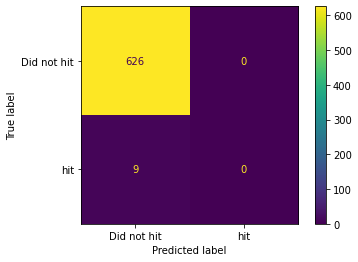

[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   1.0s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=2, reg_lambda=20.0, scale_pos_weight=1; total time=   0.9s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.9s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=10.0, scale_pos_weight=1; total time=   0.9s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=15.0, scale_pos_weight=1; total time=   0.8s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=15.0, scale_pos_weight=1; total time=   0.9s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=15.0, scale_pos_weight=1; total time=   1.0s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=20.0, scale_pos_weight=1; total time=   0.7s
[CV] END gamma=2.0, learning_rate=0.01, max_depth=3, reg_lambda=20.0, scale_pos_weight=1; total time=   0.8s
[CV] END gamma=2.0,

In [269]:
plot_confusion_matrix(clf_xgb2,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=["Did not hit","hit"])

In [241]:
X.columns

Index(['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr'],
      dtype='object')

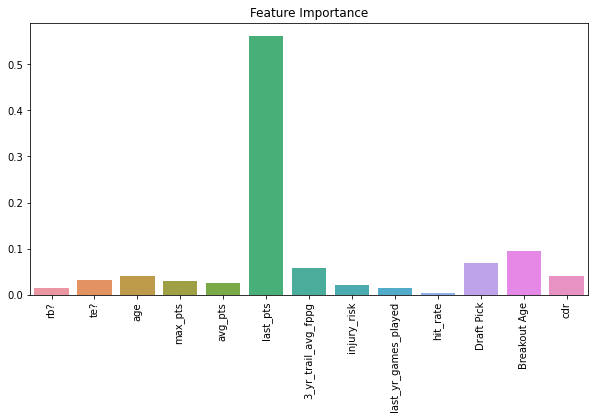

In [242]:
features = ['rb?', 'te?', 'age', 'max_pts', 'avg_pts', 'last_pts',
       '3_yr_trail_avg_fppg', 'injury_risk', 'last_yr_games_played',
       'hit_rate', 'Draft Pick', 'Breakout Age', 'cdr']
f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y=clf_xgb.feature_importances_)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()

## Score 2022

In [194]:
df_2022_X = df_2022_X.drop(columns=['id'])

KeyError: "['id'] not found in axis"

In [250]:
j_scores_2022 = pd.DataFrame(clf_xgb2.predict_proba(df_2022_X)).set_index(df_2022_X_id['id']).sort_values(
    1, axis=0, ascending=False)
j_scores_2022.head(20)

0         1
id                                  
Ja'Marr Chase     0.481052  0.518948
Jonathan Taylor   0.580114  0.419886
Derrick Henry     0.619940  0.380060
Tyreek Hill       0.622995  0.377005
Najee Harris      0.686246  0.313754
Justin Jefferson  0.710946  0.289054
Alvin Kamara      0.728623  0.271377
Ezekiel Elliott   0.740563  0.259437
Davante Adams     0.748727  0.251273
Cooper Kupp       0.748727  0.251273
Austin Ekeler     0.753730  0.246270
Dalvin Cook       0.772451  0.227549
Chris Godwin      0.794070  0.205930
Travis Kelce      0.796397  0.203603
Nick Chubb        0.856699  0.143301
Stefon Diggs      0.868265  0.131735
Mike Evans        0.876877  0.123123
Aaron Jones       0.877158  0.122842
Keenan Allen      0.885512  0.114488
D.J. Moore        0.891040  0.108960

[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=1; total time=   1.6s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=20; total time=   1.7s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=20; total time=   1.5s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=20; total time=   1.8s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=40; total time=   1.5s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=40; total time=   1.3s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=40; total time=   1.5s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=65; total time=   1.0s
[CV] END gamma=1.0, learning_rate=0.05, max_depth=5, reg_lambda=10.0, scale_pos_weight=65; total time=   1.4s
[CV] END ga

In [209]:
j_scores_2022.to_csv('league_winners_2022.csv')

In [104]:
rb_adp = pd.read_csv('rb_adp.csv')
wr_adp = pd.read_csv('wr_adp.csv')
te_adp = pd.read_csv('te_adp.csv')

adp_df = rb_adp.append(wr_adp.append(te_adp))
adp_df

Full Name Position    ADP
0        A.J. Dillon       RB   72.1
1        Aaron Green       RB      -
2        Aaron Jones       RB   19.7
3    Aaron Ripkowski       RB      -
4        Abram Smith       RB  215.8
..               ...      ...    ...
499        Zach Ertz       TE  109.8
500      Zach Gentry       TE    216
501      Zach Miller       TE      -
502      Zach Miller       TE      -
503     Zach Sudfeld       TE      -

[2394 rows x 3 columns]

In [109]:
winner_df = j_scores_2022.reset_index().merge(adp_df[['Full Name','ADP']], left_on='id',right_on='Full Name')
winner_df

id         0         1          Full Name   ADP
0       Jonathan Taylor  0.546470  0.453530    Jonathan Taylor   1.1
1         Ja'Marr Chase  0.594289  0.405711      Ja'Marr Chase   5.3
2          Najee Harris  0.669860  0.330140       Najee Harris   8.1
3      Justin Jefferson  0.669860  0.330140   Justin Jefferson   4.3
4       Ezekiel Elliott  0.716823  0.283177    Ezekiel Elliott  40.8
...                 ...       ...       ...                ...   ...
1414        Brent Celek  0.998565  0.001435        Brent Celek     -
1415  Brandon Pettigrew  0.998565  0.001435  Brandon Pettigrew     -
1416      Brandon Myers  0.998565  0.001435      Brandon Myers     -
1417         Blake Bell  0.998565  0.001435         Blake Bell   216
1418      Jordan Payton  0.998565  0.001435      Jordan Payton     -

[1419 rows x 5 columns]

## Backtest

### 2021

In [210]:
X_2021 = df_2021.drop(columns=['y'])
X_2021

rb?  te?   age   max_pts     avg_pts  last_pts  3_yr_trail_avg_fppg  \
0       1    0  23.1   40.2996   40.299600   40.2996             3.663600   
1       1    0  26.5  315.2000  206.425150  258.9006            17.497633   
3       1    0  36.2  260.8000  117.199886  124.4992             9.793733   
8       1    0  26.8  171.0000   84.274975   21.0999             8.966650   
9       1    0  22.9   86.8998   77.899900   86.8998             5.992300   
...   ...  ...   ...       ...         ...       ...                  ...   
1242    0    1  28.4  161.0000   88.080100  128.2005             8.248900   
1243    0    1  28.6  124.5000   40.216667   41.9000             2.596667   
1248    0    1  24.9   73.8000   56.833600   61.1008             8.339600   
1251    0    1  30.5  280.0000  181.700071   77.5005            12.915167   
1252    0    1  24.7    1.4000    0.700000    0.0000             0.700000   

      injury_risk  last_yr_games_played  hit_rate  Draft Pick  Breakout Age  \
0        0.687500                  11.0      0.00        2.30          19.3   
1        0.850000                  14.0      0.25        5.39          18.8   
3        0.718750                  16.0      0.00        1.07          19.5   
8        0.578125                   3.0      0.00        5.34          19.0   
9        0.812500                  13.0      0.00        3.38          19.2   
...           ...                   ...       ...         ...           ...   
1242     0.864583                  15.0      0.00        4.12          22.7   
1243     0.562500                  10.0      0.00        3.21          20.9   
1248     0.500000                  16.0      0.00        4.20           NaN   
1251     0.906250                  11.0      0.00        2.03          21.8   
1252     0.083333                   2.0      0.00        5.03           NaN   

       cdr  
0     34.8  
1     47.0  
3     42.7  
8     29.9  
9     28.7  
...    ...  
1242  15.6  
1243  11.5  
1248  10.3  
1251  31.8  
1252  15.6  

[550 rows x 13 columns]

In [211]:
id_2021 = full_data[['Full Name','Fantasy Points Per Game (2021)']].dropna(subset=['Fantasy Points Per Game (2021)'])
id_2021

Full Name  Fantasy Points Per Game (2021)
0            A.J. Dillon                         10.9176
1            Aaron Jones                         15.2667
3        Adrian Peterson                          6.6500
8           Alex Collins                          6.2545
9     Alexander Mattison                          7.8688
...                  ...                             ...
1242        Tyler Higbee                          9.8000
1243         Tyler Kroft                          4.3667
1248         Will Dissly                          3.3400
1251           Zach Ertz                         10.6294
1252         Zach Gentry                          2.1000

[550 rows x 2 columns]

In [244]:
j_scores_2021 = pd.DataFrame(clf_xgb2.predict_proba(X_2021)).set_index(id_2021['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2021.to_csv('league_winner_2021.csv')

In [245]:
j_scores_2021_check = j_scores_2021.reset_index()
j_scores_2021_check.head(20)

Full Name         0         1
0    Jonathan Taylor  0.364690  0.635310
1   Justin Jefferson  0.536584  0.463415
2     James Robinson  0.550845  0.449155
3      Austin Ekeler  0.586092  0.413908
4        Tyreek Hill  0.625167  0.374833
5      Davante Adams  0.670266  0.329734
6        Dalvin Cook  0.677168  0.322832
7    DeAndre Hopkins  0.695337  0.304663
8       Alvin Kamara  0.710871  0.289129
9    Ezekiel Elliott  0.750377  0.249623
10      Travis Kelce  0.774891  0.225108
11       Cooper Kupp  0.812771  0.187229
12      Adam Thielen  0.825908  0.174092
13       Aaron Jones  0.840674  0.159326
14      Keenan Allen  0.840674  0.159326
15      Robert Woods  0.857150  0.142850
16      James Conner  0.857626  0.142374
17     Derrick Henry  0.860029  0.139971
18        Mike Evans  0.862504  0.137496
19       Kareem Hunt  0.869283  0.130717

In [246]:
X_2020 = df_2020.drop(columns=['y'])
X_2020

id_2020 = full_data[['Full Name','Fantasy Points Per Game (2020)']].dropna(subset=['Fantasy Points Per Game (2020)'])
id_2020

j_scores_2020 = pd.DataFrame(clf_xgb2.predict_proba(X_2020)).set_index(id_2020['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2020.to_csv('league_winner_2020.csv')

j_scores_2020_check = j_scores_2020.reset_index()
j_scores_2020_check.head(20)

Full Name         0         1
0   Christian McCaffrey  0.545526  0.454474
1          Alvin Kamara  0.567890  0.432110
2         Davante Adams  0.623648  0.376352
3           Tyreek Hill  0.632843  0.367157
4       Ezekiel Elliott  0.642733  0.357267
5        Saquon Barkley  0.668694  0.331305
6        Michael Thomas  0.690206  0.309794
7       DeAndre Hopkins  0.693530  0.306470
8           Dalvin Cook  0.714407  0.285593
9         Melvin Gordon  0.723076  0.276924
10          Julio Jones  0.733977  0.266023
11          Todd Gurley  0.774091  0.225909
12         Travis Kelce  0.775040  0.224960
13         Le'Veon Bell  0.807294  0.192706
14    Leonard Fournette  0.826811  0.173189
15        Austin Ekeler  0.845922  0.154078
16        Derrick Henry  0.848062  0.151938
17           Mike Evans  0.860533  0.139466
18         Amari Cooper  0.863882  0.136118
19          Aaron Jones  0.884679  0.115321

In [247]:
X_2019 = df_2019.drop(columns=['y'])
X_2019

id_2019 = full_data[['Full Name','Fantasy Points Per Game (2019)']].dropna(subset=['Fantasy Points Per Game (2019)'])
id_2019

j_scores_2019 = pd.DataFrame(clf_xgb2.predict_proba(X_2019)).set_index(id_2019['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2019.to_csv('league_winner_2019.csv')

j_scores_2019_check = j_scores_2019.reset_index()
j_scores_2019_check

Full Name         0         1
0    Christian McCaffrey  0.388548  0.611452
1          Melvin Gordon  0.493954  0.506046
2         Michael Thomas  0.546123  0.453877
3         Saquon Barkley  0.602617  0.397383
4            Tyreek Hill  0.639221  0.360779
..                   ...       ...       ...
480        Peyton Barber  0.997357  0.002643
481         Josh Bellamy  0.997357  0.002643
482         Paul Perkins  0.997357  0.002643
483        Patrick Laird  0.997357  0.002643
484            Greg Ward  0.997357  0.002643

[485 rows x 3 columns]

In [248]:
X_2018 = df_2018.drop(columns=['y'])
X_2018

id_2018 = full_data[['Full Name','Fantasy Points Per Game (2018)']].dropna(subset=['Fantasy Points Per Game (2018)'])
id_2018

j_scores_2018 = pd.DataFrame(clf_xgb2.predict_proba(X_2018)).set_index(id_2018['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2018.to_csv('league_winner_2018.csv')

j_scores_2018_check = j_scores_2018.reset_index()
j_scores_2018_check

Full Name         0         1
0    Ezekiel Elliott  0.507926  0.492074
1       Alvin Kamara  0.536584  0.463415
2        Kareem Hunt  0.536746  0.463254
3     Michael Thomas  0.548642  0.451358
4    DeAndre Hopkins  0.578828  0.421172
..               ...       ...       ...
486  Darrel Williams  0.997357  0.002643
487     Josh Bellamy  0.997357  0.002643
488  Dare Ogunbowale  0.997357  0.002643
489     Justin Hardy  0.997357  0.002643
490     Geremy Davis  0.997357  0.002643

[491 rows x 3 columns]

In [249]:
X_2017 = df_2017.drop(columns=['y'])
X_2017

id_2017 = full_data[['Full Name','Fantasy Points Per Game (2017)']].dropna(subset=['Fantasy Points Per Game (2017)'])
id_2017

j_scores_2017 = pd.DataFrame(clf_xgb2.predict_proba(X_2017)).set_index(id_2017['Full Name']).sort_values(
    1, axis=0, ascending=False)
j_scores_2017.to_csv('league_winner_2017.csv')

j_scores_2017_check = j_scores_2017.reset_index()
j_scores_2017_check

Full Name         0         1
0               Le'Veon Bell  0.447344  0.552656
1            DeAndre Hopkins  0.485658  0.514342
2            Ezekiel Elliott  0.513537  0.486463
3             Michael Thomas  0.549140  0.450860
4              David Johnson  0.611823  0.388177
..                       ...       ...       ...
466            De'Veon Smith  0.997357  0.002643
467      Darrius Heyward-Bey  0.997357  0.002643
468             Damiere Byrd  0.997357  0.002643
469  Austin Seferian-Jenkins  0.997357  0.002643
470           Kasen Williams  0.997357  0.002643

[471 rows x 3 columns]